<a href="https://colab.research.google.com/github/dhar174/intelligent_data_detective/blob/main/IntelligentDataDetective_beta_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intelligent Data Detective Introduction

# 🔧 Environment Setup and Dependency Management

In [32]:
import os
import subprocess
# from dotenv import load_dotenv
from pathlib import Path
import ast
import sys
from io import StringIO
import logging
from functools import lru_cache
# Attempt to detect Colab environment
is_colab = 'google.colab' in str(get_ipython())

if is_colab:
    from google.colab import userdata
    print("Running on CoLab")
    tavily_key = userdata.get('TAVILY_API_KEY')
    oai_key = userdata.get('OPENAI_API_KEY')
else:
    print("Not running on CoLab, attempting to load keys from environment variables.")
    tavily_key = os.environ.get('TAVILY_API_KEY')
    oai_key = os.environ.get('OPENAI_API_KEY')

# Install necessary packages
!pip install -U  langmem langchain-community tavily-python openpyxl scipy scikit-learn xhtml2pdf joblib langchain langchain-core langchain-openai langchain_experimental langgraph chromadb pydantic python-dotenv tiktoken openpyxl scipy scikit-learn xhtml2pdf joblib openai langgraph-checkpoint-sqlite

# !pip install -U --pre langchain
# !pip install -U --pre langgraph
# !pip install -U --pre langchain-core
# !pip install -U --pre langchain-openai


if tavily_key:
    os.environ["TAVILY_API_KEY"] = tavily_key
else:
    print("TAVILY_API_KEY not found.")

if not oai_key:
    print("OPENAI_API_KEY not found.")
!pip list

Running on CoLab
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.106.0
    Uninstalling openai-1.106.0:
      Successfully uninstalled openai-1.106.0


Package                                  Version
---------------------------------------- -------------------
absl-py                                  1.4.0
absolufy-imports                         0.3.1
accelerate                               1.10.1
aiofiles                                 24.1.0
aiohappyeyeballs                         2.6.1
aiohttp                                  3.12.15
aiosignal                                1.4.0
aiosqlite                                0.21.0
alabaster                                1.0.0
albucore                                 0.0.24
albumentations                           2.0.8
ale-py                                   0.11.2
altair                                   5.5.0
annotated-types                          0.7.0
anthropic                                0.66.0
antlr4-python3-runtime                   4.9.3
anyio                                    4.10.0
anywidget                                0.9.18
arabic-reshaper                   

This section handles the initial environment setup, including:
- **Environment Detection**: Automatically detects if running in Google Colab or local environment
- **API Key Management**: Securely retrieves OpenAI and Tavily API keys from environment variables or Colab userdata
- **Package Installation**: Installs all required dependencies including LangChain, LangGraph, and data science libraries
- **Error Handling**: Provides fallback mechanisms for API key retrieval

# New Section

# 📚 Core Imports and Type System Foundation

In [2]:
# MUST be first in the file/notebook once; do NOT re-import later cells
from __future__ import annotations

# --- Stdlib ---
import os
import sys
import ast
import io
from io import StringIO, BytesIO
import re
import json
import uuid
import hashlib
import shutil
import logging
import functools
from functools import lru_cache
from math import nan
from pprint import pprint
from collections import OrderedDict
from collections.abc import Sequence
from typing import (
    Dict, Optional, List, Tuple, Union, Literal, Any, Mapping, MutableMapping, cast, TypeGuard
)
from typing_extensions import TypedDict, NotRequired, Annotated, TypeAlias
from tempfile import TemporaryDirectory
import itertools, threading

# --- Scientific stack ---
import numpy as np
from numpy.typing import ArrayLike
from numpy import ndarray as NDArray
import pandas as pd
from pandas import Index
from pandas.api.types import is_list_like
from scipy import stats
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# --- Plotting ---
import base64
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
try:
    import seaborn as sns
    _HAS_SNS = True
except Exception:
    _HAS_SNS = False

from IPython.display import Image, display

# --- External services ---
import kagglehub
from tavily import TavilyClient  # used by search_web_for_context tool

# --- LangGraph / LangChain / LangMem ---
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore
from langgraph.cache.memory import InMemoryCache
from langgraph.checkpoint.memory import MemorySaver, InMemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.state import CompiledStateGraph
from langgraph.types import Command, CachePolicy, Send
from langgraph.prebuilt import create_react_agent, InjectedState, InjectedStore  # keep for now
from langgraph.utils.config import get_store  # kept for backwards-compat in a few nodes

from langchain_openai import ChatOpenAI
from langchain_core.language_models.chat_models import BaseChatModel
from langchain_core.runnables import RunnableLambda

from langchain_core.runnables.config import RunnableConfig
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate, MessagesPlaceholder
from langchain_core.messages import (
    HumanMessage, AIMessage, SystemMessage, ToolMessage, ToolMessageChunk, ToolCall, trim_messages, AIMessageChunk
)
from langchain_core.messages.utils import message_chunk_to_message
from langchain_core.tools import tool, InjectedToolArg, InjectedToolCallId, Tool
from langgraph.prebuilt.chat_agent_executor import AgentState  # <-- missing before; needed for your State

from langchain_experimental.tools.python.tool import PythonAstREPLTool
from langmem import create_manage_memory_tool, create_search_memory_tool

from langchain_community.agent_toolkits import FileManagementToolkit

# --- Working directory & toolkit ---
_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)
print(f"Working directory set to: {WORKING_DIRECTORY}")

# Use FULL path, not .name
file_tools = FileManagementToolkit(root_dir=str(WORKING_DIRECTORY)).get_tools()
toolkit = FileManagementToolkit(root_dir=str(WORKING_DIRECTORY))
_ = toolkit.get_tools()

# --- Logging ---
logging.basicConfig(level=logging.INFO)

# --- Operator helpers used elsewhere (reducers/flags) ---
import operator
from operator import add, or_ as bool_or

def keep_first(a: Optional[Any], b: Optional[Any]) -> Optional[Any]:
    """
    Reducer to preserve the first non-null value.
    If `a` is not None, returns a—not overridden by `b`.
    Else returns `b`.
    """
    return a if a is not None else b

def dict_merge_shallow(old: Optional[Dict[str, Any]], new: Optional[Dict[str, Any]]) -> Dict[str, Any]:
    """
    Merge two dicts shallowly (one level).
    - If both old and new are None, return {}.
    - If only one is non-empty, return that one.
    - If both exist, new keys override old.
    """
    if old is None and new is None:
        return {}
    if old is None:
        return dict(new)
    if new is None:
        return dict(old)
    return {**old, **new}



# --- Pydantic v2 (validators only) ---
from pydantic import BaseModel, Field, model_validator, field_validator, ValidationError, ConfigDict, AfterValidator,ValidationInfo, PrivateAttr

# ===== Utilities kept from your second cell =====

Array1D = Union[
    Sequence[float],
    Sequence[int],
    np.ndarray,
    pd.Series,
]

def is_1d_vector(x: object) -> TypeGuard[Array1D]:
    """
    Return True if x is a 1-D numeric-like sequence:
     - pandas.Series,
     - numpy.ndarray with ndim == 1,
     - list/tuple of scalars convertible to a 1-D array.
    """
    try:
        if isinstance(x, (str, bytes)):
            return False
        if isinstance(x, pd.Series):
            return True
        if isinstance(x, np.ndarray):
            return x.ndim == 1
        if is_list_like(x):
            try:
                arr = np.asarray(x)
            except Exception:
                return False
            return arr.ndim == 1
        if isinstance(x, Sequence):
            try:
                arr = np.asarray(x, dtype=float)
            except (ValueError, TypeError):
                return False
            return arr.ndim == 1
        return False
    except Exception as e:
        raise e

Number    = Union[int, float]
ScalarNum = Annotated[Number, "Scalar number (int | float)"]
Estimator = Literal["auto","fd","doane","scott","sturges","sqrt","stone","rice"]

BinSpec = Union[
    int,
    Estimator,
    Tuple[Union[int, Estimator, Sequence[int]], Union[int, Estimator, Sequence[int]]],
    ArrayLike,
    None,
]

BinWidthSpec = Annotated[
    Union[Number, Sequence[Number], np.ndarray, pd.Series, None],
    "A scalar or sequence of widths"
]
RangeSpec = Annotated[
    Optional[Tuple[Number, Number]],
    "(lo, hi) numeric tuple",
]
ColumnSelector = Annotated[
    Optional[Union[str, int, Sequence[str], Sequence[int], Literal["all"]]],
    "Column(s) to select",
]

# --- Agent member typing (retained) ---
class AgentMembers(BaseModel):
    description: str = Field(default="Members of an agent list.")
    agent_type: Literal["initial_analysis", "data_cleaner", "analyst", "file_writer", "visualization", "report_orchestrator", "report_section_worker", "report_packager", "supervisor"]

    @model_validator(mode="wrap")
    @classmethod
    def log_failed_validation(cls, data, handler):
        try:
            return handler(data)
        except ValidationError:
            print(f"[AgentMembers] validation failed: {data}")
            raise

class InitialAnalysis(AgentMembers):   agent_type: Literal["initial_analysis"]   = "initial_analysis"
class DataCleaner(AgentMembers):        agent_type: Literal["data_cleaner"]       = "data_cleaner"
class Analyst(AgentMembers):            agent_type: Literal["analyst"]            = "analyst"
class FileWriter(AgentMembers):         agent_type: Literal["file_writer"]        = "file_writer"
class Visualization(AgentMembers):      agent_type: Literal["visualization"]      = "visualization"
class ReportGenerator(AgentMembers):    agent_type: Literal["report_packager"]   = "report_packager"
class SuperVisor(AgentMembers):         agent_type: Literal["supervisor"]         = "supervisor"
class ReportOrchestrator(AgentMembers): agent_type: Literal["report_orchestrator"]= "report_orchestrator"
class ReportSection(AgentMembers):      agent_type: Literal["report_section_worker"]     = "report_section_worker"

def agent_list_default_generator() -> List[AgentMembers]:
    return [
        InitialAnalysis(),
        DataCleaner(),
        Analyst(),
        FileWriter(),
        Visualization(),
        ReportGenerator(),
        SuperVisor(),
    ]

AgentId: TypeAlias = Literal[
    "initial_analysis", "data_cleaner", "analyst",
    "viz_worker", "viz_join", "viz_evaluator", "visualization",
    "report_orchestrator", "report_section_worker", "report_join",
    "report_packager", "file_writer", "END","FINISH"
]
Supervisor = Literal["supervisor"]
AgentOrSupervisor = Union[AgentId, Supervisor]



Working directory set to: /tmp/tmpw1mvubc8


Establishes the foundational imports and type system for the entire notebook:
- **Advanced Typing**: Comprehensive type annotations using Python 3.12+ features
- **LangChain/LangGraph Stack**: Core imports for the multi-agent framework
- **Data Science Libraries**: Pandas, NumPy, Matplotlib, Seaborn for data analysis
- **Type Safety**: Extensive use of TypedDict, Literal types, and generic annotations

# 🤖 OpenAI API Integration and Model Customization

In [3]:
from langchain_core.language_models import LanguageModelInput
from langchain_openai.chat_models.base import _construct_responses_api_input, _is_pydantic_class, _convert_message_to_dict, _convert_to_openai_response_format, _get_last_messages
from langchain_core.messages import BaseMessage

def _construct_responses_api_payload(
    messages: Sequence[BaseMessage], payload: dict
) -> dict:
    # Rename legacy parameters
    for legacy_token_param in ["max_tokens", "max_completion_tokens"]:
        if legacy_token_param in payload:
            payload["max_output_tokens"] = payload.pop(legacy_token_param)
    if "reasoning_effort" in payload and "reasoning" not in payload:
        payload["reasoning"] = {"effort": payload.pop("reasoning_effort")}

    # Remove temperature parameter for models that don't support it in responses API
    model = payload.get("model", "")
    if model.startswith("gpt-5"):
        payload.pop("temperature", None)

    payload["input"] = _construct_responses_api_input(messages)
    if tools := payload.pop("tools", None):
        new_tools: list = []
        for tool in tools:
            # chat api: {"type": "function", "function": {"name": "...", "description": "...", "parameters": {...}, "strict": ...}  # noqa: E501
            # responses api: {"type": "function", "name": "...", "description": "...", "parameters": {...}, "strict": ...}  # noqa: E501
            if tool["type"] == "function" and "function" in tool:
                new_tools.append({"type": "function", **tool["function"]})
            else:
                if tool["type"] == "image_generation":
                    # Handle partial images (not yet supported)
                    if "partial_images" in tool:
                        raise NotImplementedError(
                            "Partial image generation is not yet supported "
                            "via the LangChain ChatOpenAI client. Please "
                            "drop the 'partial_images' key from the image_generation "
                            "tool."
                        )
                    elif payload.get("stream") and "partial_images" not in tool:
                        # OpenAI requires this parameter be set; we ignore it during
                        # streaming.
                        tool["partial_images"] = 1
                    else:
                        pass

                new_tools.append(tool)

        payload["tools"] = new_tools
    if tool_choice := payload.pop("tool_choice", None):
        # chat api: {"type": "function", "function": {"name": "..."}
        # responses api: {"type": "function", "name": "..."}
        if (
            isinstance(tool_choice, dict)
            and tool_choice["type"] == "function"
            and "function" in tool_choice
        ):
            payload["tool_choice"] = {"type": "function", **tool_choice["function"]}
        else:
            payload["tool_choice"] = tool_choice

    # Structured output
    if schema := payload.pop("response_format", None):
        existing_text = payload.pop("text", None)

        # For pydantic + non-streaming case, we use responses.parse.
        # Otherwise, we use responses.create.
        strict = payload.pop("strict", None)
        if not payload.get("stream") and _is_pydantic_class(schema):
            verbosity = payload.pop("verbosity", None)
            payload["text_format"] = schema

            text_content = (
                existing_text.copy() if isinstance(existing_text, dict) else {}
            )
            if verbosity is not None:
                text_content["verbosity"] = verbosity
            if text_content and "format" not in text_content:
                payload["text"] = text_content
        else:
            # For responses.create, use response_format in text.format
            if _is_pydantic_class(schema):
                schema_dict = schema.model_json_schema()
                strict = True
            else:
                schema_dict = schema
            if schema_dict == {"type": "json_object"}:  # JSON mode
                structured_text = {"format": {"type": "json_object"}}
            elif (
                (
                    response_format := _convert_to_openai_response_format(
                        schema_dict, strict=strict
                    )
                )
                and (isinstance(response_format, dict))
                and (response_format["type"] == "json_schema")
            ):
                structured_text = {
                    "format": {"type": "json_schema", **response_format["json_schema"]}
                }
            else:
                structured_text = {}

            # Merge existing text parameters with structured output text
            if existing_text or structured_text:
                merged_text = {}
                if existing_text and isinstance(existing_text, dict):
                    merged_text.update(existing_text)
                if structured_text:
                    merged_text.update(structured_text)
                payload["text"] = merged_text
            else:
                pass

            # Handle verbosity for responses.create path
            verbosity = payload.pop("verbosity", None)
            if verbosity is not None:
                if "text" not in payload:
                    payload["text"] = {"format": {"type": "text"}}
                payload["text"]["verbosity"] = verbosity
    else:
        # No structured output, handle verbosity normally
        verbosity = payload.pop("verbosity", None)
        if verbosity is not None:
            if "text" not in payload:
                payload["text"] = {"format": {"type": "text"}}
            payload["text"]["verbosity"] = verbosity

    return payload


class MyChatOpenai(ChatOpenAI):


    def _get_request_payload_mod(
        self,
        input_: LanguageModelInput,
        *,
        stop: Optional[list[str]] = None,
        **kwargs: Any,
    ) -> dict:
        messages = self._convert_input(input_).to_messages()
        if stop is not None:
            kwargs["stop"] = stop

        payload = {**self._default_params, **kwargs}

        if self._use_responses_api(payload):
            if self.use_previous_response_id:
                last_messages, previous_response_id = _get_last_messages(messages)
                payload_to_use = last_messages if previous_response_id else messages
                if previous_response_id:
                    payload["previous_response_id"] = previous_response_id
                payload = _construct_responses_api_payload(payload_to_use, payload)
            else:
                payload = _construct_responses_api_payload(messages, payload)
        else:
            payload["messages"] = [_convert_message_to_dict(m) for m in messages]
        return payload

    def _get_request_payload(
        self,
        input_: LanguageModelInput,
        *,
        stop: Optional[list[str]] = None,
        **kwargs: Any,
    ) -> dict:
        payload = self._get_request_payload_mod(input_, stop=stop, **kwargs)
        # max_tokens was deprecated in favor of max_completion_tokens
        # in September 2024 release
        if "max_tokens" in payload:
            payload["max_completion_tokens"] = payload.pop("max_tokens")

        # Mutate system message role to "developer" for o-series models
        if self.model_name and re.match(r"^o\d", self.model_name):
            for message in payload.get("messages", []):
                if message["role"] == "system":
                    message["role"] = "developer"
        return payload

Custom ChatOpenAI implementation with advanced features:
- **GPT-5 Support**: Forward-compatible implementation for o-series models
- **Responses API**: Handles transition from legacy to new OpenAI API patterns
- **Model-Specific Logic**: Adapts behavior based on model capabilities and limitations
- **Parameter Mapping**: Proper handling of deprecated and new API parameters

# 📋 Dependency Version Verification

In [4]:
!pip show --verbose langchain_experimental


Name: langchain-experimental
Version: 0.3.4
Summary: Building applications with LLMs through composability
Home-page: https://github.com/langchain-ai/langchain-experimental
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.12/dist-packages
Requires: langchain-community, langchain-core
Required-by: 
Metadata-Version: 2.1
Installer: pip
Classifiers:
  License :: OSI Approved :: MIT License
  Programming Language :: Python :: 3
  Programming Language :: Python :: 3.9
  Programming Language :: Python :: 3.10
  Programming Language :: Python :: 3.11
  Programming Language :: Python :: 3.12
Entry-points:
Project-URLs:
  Repository, https://github.com/langchain-ai/langchain-experimental
  Release Notes, https://github.com/langchain-ai/langchain-experimental/releases
  Source Code, https://github.com/langchain-ai/langchain-experimental/tree/main/libs/experimental


Quick verification of installed package versions:
- **LangChain Experimental**: Checks the version of experimental features being used
- **Compatibility Validation**: Ensures correct versions are installed for the workflow

# 🏗️ Data Models and State Architecture

In [5]:
# Support models — keep this cell before nodes/supervisor/graph
class BaseNoExtrasModel(BaseModel):
    model_config = ConfigDict(extra="forbid",json_schema_extra={"additionalProperties": False}) # -> additionalProperties: false
    reply_msg_to_supervisor: str = Field(...,description="Message to send to the supervisor. Can be a simple message stating completion of the task, or it can be detailed information about the result, or you can put any questions for the supervisor here as well. This is ONLY for sending messages to the supervisor, NOT to worker agents. If you are the/a supervisor (or the router, planner, or progress reporter), this field should be empty unless you are expecting a reply from the main supervisor, NOT from a worker agent.")
    finished_this_task: bool = Field(...,description="Whether this assigned task represented by this object has been completed. For example, if it is a Router object, this field should be True if the route decision has been made. Another example, if it is a CleaningMetadata object, this field should be True if the cleaning has been completed.")
    expect_reply: bool = Field(...,description="Whether you expect a reply from the supervisor based on content of 'reply_msg_to_supervisor'. This is ONLY for receiving replies from the supervisor, not from worker agents. If you are the/a supervisor (or the router, planner, or progress reporter), only set this to True if you are expecting a reply from the main supervisor, NOT from a worker agent. Worker agents will always reply to 'next_agent_prompt' when routed to.")


from typing import List, ClassVar
class AnalysisConfig(BaseNoExtrasModel):
    """User-configurable settings for the data analysis workflow."""
    default_visualization_style: str = Field(..., description="Default style for matplotlib/seaborn visualizations. seaborn-v0_8-whitegrid is a decent choice if unsure.")
    report_author: str = Field(..., description="Author name to include in generated reports.")
    datetime_format_preference: str = Field(..., description="Preferred format for datetime string representations. If unsure, use %Y-%m-%d %H:%M:%S")
    large_dataframe_preview_rows: int = Field(..., description="Number of rows for previewing large dataframes. Use 5 if unsure.")
    # default_correlation_method: str = Field("pearson", description="Default method for correlation.")
    # automatic_outlier_removal: bool = Field(False, description="Whether to automatically remove outliers found.")

class CleaningMetadata(BaseNoExtrasModel):
    """Metadata about the data cleaning actions taken."""
    steps_taken: list[str] = Field(...,description="List of cleaning steps performed.")
    data_description_after_cleaning: str = Field(...,description="Brief description of the dataset after cleaning.")

class InitialDescription(BaseNoExtrasModel):
    """Initial description of the dataset."""
    dataset_description: str = Field(...,description="Brief description of the dataset.")
    data_sample: str = Field(...,description="Sample of the dataset.")
    notes: str = Field(...,description="Notes about the dataset.")

class VizSpec(BaseNoExtrasModel):
    title: Optional[Union[str,None]] = Field(...,description="Title of the visualization.")
    viz_type: Optional[Union[Literal["histogram","scatter","bar","line","box","auto"],None]] = Field(...,description="Type of the visualization. Set to 'auto' to let the agent decide.")
    df_id: Optional[Union[str,None]] = Field(...,description="ID of the DataFrame to visualize.")
    viz_instructions: Optional[Union[str,None]] = Field(...,description="Instructions to the next agent for the visualization.")
    viz_id: Optional[Union[str,None]] = Field(...,description="ID of the visualization. If not provided, the agent will generate one. Must be unique.")
    columns: Optional[Union[List[str],None]] = Field(...,description="Optional list of columns to visualize.")
    x: Optional[Union[str,None]] = Field(...,description="Optional column to use for the x-axis.")
    y: Optional[Union[str,None]] = Field(...,description="Optional column to use for the y-axis.")
    hue: Optional[str] = Field(...,description="Optional column to use for the hue.")
    bins: Optional[Union[int, str,None]] = Field(...,description="Optional number of bins or method for binning.")
    agg: Optional[Union[str,None]] = Field(...,description="Optional aggregation method.")
    query: Optional[Union[str,None]] = Field(...,description="Optional query to filter the data.")
    description: Optional[Union[str,None]] = Field(...,description="Optional description of the visualization.")
    limit: Optional[Union[int,None]] = Field(...,description="Optional limit of rows to visualize.")
    style: Optional[Union[str,None]] = Field(...,description="Optional style of the visualization. This should be a matplotlib/seaborn style.")

class AnalysisInsights(BaseNoExtrasModel):
    """Insights from the exploratory data analysis."""
    summary: str = Field(...,description="Overall summary of EDA findings.")
    correlation_insights: str = Field(...,description="Key correlation insights identified.")
    anomaly_insights: str = Field(...,description="Anomalies or interesting patterns detected.")
    recommended_visualizations: List[VizSpec] = Field(...)
    recommended_next_steps: List[str] = Field(...,description="List of recommended next analysis steps or questions to investigate based on the findings.")


class ImagePayload(BaseNoExtrasModel):
    """
    Wrap both the image bytes and its declared MIME-type.
    """
    mime: Literal["image/png", "image/jpeg"]
    payload: bytes

    @field_validator("payload", mode="before")
    def ensure_b64(cls, v: str | bytes):
        if isinstance(v, bytes):
            return v
        try:
            return base64.b64decode(v, validate=True)
        except Exception as e:
            raise ValueError("Invalid Base-64") from e

    @field_validator("payload")
    def enforce_size(cls, v: bytes):
        max_bytes = 2 * 1024 * 1024   # 2 MiB hard limit
        if len(v) > max_bytes:
            raise ValueError(f"Image is too large ({len(v)} bytes > {max_bytes})")
        return v



class DataVisualization(BaseNoExtrasModel):
    """Individual visualizations generated"""
    path: str = Field(description="Path to the generated visualization.")
    visualization_id: str = Field(...,description="Unique ID for the visualization.")
    visualization_type: str = Field(...,description="Type of the visualization.")
    visualization_description: str = Field(...,description="Description of the visualization.")
    visualization_style: str = Field(...,description="Style of the visualization.")
    visualization_title: str = Field(...,description="Title of the visualization.")

class VisualizationResults(BaseNoExtrasModel):
    """Results from the visualization generation."""
    visualizations: List[DataVisualization] = Field(...)

class ReportResults(BaseNoExtrasModel):
    """Results from the report generation."""
    pdf_report_path: str = Field(...,description="Path to the generated PDF report.")
    html_report_path: str = Field(...,description="Path to the generated HTML report.")
    markdown_report_path: str = Field(...,description="Path to the generated Markdown report.")

class DataQueryParams(BaseNoExtrasModel):
    """Parameters for querying the DataFrame."""
    columns: List[str] = Field(..., description="List of columns to include in the output")
    filter_column: str = Field(..., description="Column to apply the filter on")
    filter_value: str = Field(..., description="Value to filter the rows by")
    operation: str = Field(..., description="Operation to perform: 'select', 'sum', 'mean', 'count', 'max', 'min', 'median', etc.")

class FileResult(BaseNoExtrasModel):
    """Results object storing metadata from the file generation or editing. The fields include the following:
    - write_success: Whether the file was written to disk successfully. If you did not succeed in writing the file to disk and do not have a viable file name and path to the file, then leave this field as False, and enter 'Failed to generate file' as the string for the 'file_path', 'file_type', 'file_name', and 'file_description' fields and 'error' in the 'category_tag' field. In the case of failed file writing or saving, use the 'reply_msg_to_supervisor' field to provide a more detailed error message to the supervisor and user, and set the 'finished_this_task' field to False and the 'expect_reply' field to True.
    - file_path: Path to the generated file. This is the accurate relative path to the actual file on disk, including the file name, as a string, and should be able used to read the file. The path should be relative to the working directory. Note the filename in the path should be match the 'file_name' field. Also note that after the last directory separator, the name of the file in file_path should match the 'file_name' field and the file extension of the file in file_path should match the 'file_type' field.
    - file_type: Type of the generated file. This is a string representing the actual type of the file or its format in terms of its file extension. Examples include 'csv', 'json', 'txt', 'png', 'pdf', 'html', 'md', 'parquet', 'xlsx', 'py', 'ipynb', 'pt', 'pkl', 'xml', 'sql', 'bytes', 'log', 'yml', 'db', or any other format supported by the file_writer agent's tools. Note that the file extension of the file in the 'file_path' field must match this file_type field.
    - file_name: Name of the generated file. This is a string representing the name of the file, without the file extension. Do not include the file extension in this field. Instead, indicate the file extension in the file_type field and include it in the full path in the file_path field. Of course, file_name should match the name of the file in the 'file_path' field after the last directory separator.
    - file_description: Description of the generated file. This is a string representing a brief and concisely worded but identifying description of the generated file that catalogues it effectively. It should be clear and concise and should include any relevant details about the file, such as its purpose, size, and any other relevant information such as the time and date it was generated, the type of data it contains, versioning information, how it was generated, how it can be used, etc.
    - is_final_report: Whether the file is the final report. Enter false if not final or if the file is not the final report or if the file any other file. Unless you know for sure you are writing the final report, leave this false.
    - category_tag: Type of the resulting file. This is a string representing the type of the resulting file, in terms of what category it falls under.
          Examples for each tag:
          'report': [report outline as a txt file, section of a report as txt or md file, the final report as a pdf, html, or markdown file]
          'data': [saved copy or transformation of a dataframe or series representing a particular column or subset of the dataset, a csv file, sql or db file, FAISS index or embeddings, pickled data, json config or data file, saved xlsx spreadsheets, parquet files, etc.]
          'visualization': [a specific chart, diagram or other visualization created saved as png or bytes image file, a saved mermaid file]
          'other': [any other type of file, files specifically requested by the user or supervisor or another agent, backed up files unrelated to the analysis or report, etc.]
          'error': This category tag is to only specifically be used when the file writing or saving process fails and the write_success field is set to False.
          For the category_tage field, use a SINGLE word only please, NO punctuation. Only enter one of: 'report', 'data', 'visualization', or 'other'.

    """
    write_success: bool = Field(...,description="Whether the file was written to disk successfully. Set to True for a successful file generation, meaning you can provide the file path and other metadata in the relevant fields. In the case that you did not succeed in writing the file to disk, set this field to False, and enter 'Failed to generate file' as the string for the 'file_path', 'file_type', 'file_name', and 'file_description' fields and 'error' in the 'category_tag' field. In the case of failed file writing or saving, use the 'reply_msg_to_supervisor' field to provide a more detailed error message to the supervisor and user, and set the 'finished_this_task' field to False and the 'expect_reply' field to True.")
    file_path: str = Field(...,description="Path to the generated file. This is the path to the file on disk, including the file name, as a string, and should be able used to read the file. The path should be relative to the working directory. Note the filename in the path should be match the 'file_name' field. Also note that after the last directory separator, the name of the file in file_path should match the 'file_name' field and the file extension of the file in file_path should match the 'file_type' field. In the case of a failed file operation, enter 'Failed to generate file'")
    file_type: str = Field(...,description="Type of the generated file. This is a string representing the actual type of the file or its format in terms of its file extension. Examples include 'csv', 'json', 'txt', 'png', 'pdf', 'html', 'md', 'parquet', 'xlsx', 'py', 'ipynb', 'pt', 'pkl', 'xml', 'sql', 'bytes', 'log', 'yml', 'db', or any other format supported by the file_writer agent's tools. Note that the file extension of the file in the 'file_path' field must match this file_type field. In the case of a failed file operation, enter 'Failed to generate file'")
    file_name: str = Field(...,description="Name of the generated file. This is a string representing the name of the file, without the file extension. Do not include the file extension in this field. Instead, indicate the file extension in the file_type field and include it in the full path in the file_path field. Of course, file_name should match the name of the file in the 'file_path' field after the last directory separator. In the case of a failed file operation, enter 'Failed to generate file'")
    file_description: str = Field(...,description="Description of the generated file. This is a string representing a brief and concisely worded but definitive and identifying description of the generated file that catalogues it effectively. It should be clear and concise and should include any relevant details about the file, such as its purpose, size, and any other relevant information such as the time and date it was generated, the type of data it contains, versioning information, how it was generated, how it can be used, etc. In the case of a failed file operation, enter 'Failed to generate file'")
    is_final_report: bool = Field(...,description="Whether the file is the finalized report. Enter false if not final or if the file is not the final report or if the file any other file. Unless you know for sure you are writing the final report, leave this false.")
    category_tag: str = Field(...,description="Type of the resulting file. This is a string representing the type of the resulting file, in terms of what category it falls under. Examples for each tag: 'report': [report outline as a txt file, section of a report as txt or md file, the final report as a pdf, html, or markdown file], 'data': [saved copy or transformation of a dataframe or series representing a particular column or subset of the dataset, a csv file, sql or db file, FAISS index or embeddings, pickled data, json config or data file, saved xlsx spreadsheets, parquet files, etc.], 'visualization': [a specific chart, diagram or other visualization created saved as png or bytes image file, a saved mermaid file], 'other': [any other type of file, files specifically requested by the user or supervisor or another agent, backed up files unrelated to the analysis or report, etc.]. For the category_tage field, use a SINGLE word only please, NO punctuation. Only enter one of: 'report', 'data', 'visualization', or 'other'.")
    # file_content: str = Field(description="Content of the generated file.")

class ListOfFiles(BaseNoExtrasModel):
    """List of metadata as FileResult objects for the files generated."""
    files: List[FileResult] = Field(...)

class DataFrameRegistryError(Exception):
    """Exception raised for errors in the DataFrameRegistry."""
    def __init__(self, message):
        self.message = message
        super().__init__(self.message)
    def __str__(self): return self.message
    def __repr__(self): return self.message
    def to_dict(self): return {"error": self.message}

class ProgressReport(BaseNoExtrasModel):
    latest_progress: str = Field(...,description="Latest progress of the agent.")


def _sort_plan_steps(steps: List[PlanStep]) -> List[PlanStep]:
    # Accepts either PlanStep or dict; normalize then sort
    norm = [s if isinstance(s, PlanStep) else PlanStep.model_validate(s) for s in steps or []]
    return sorted(norm, key=lambda s: s.step_number)

Triplet = Tuple[int, str, str]  # (step_number, step_name, step_description)

def _assert_sorted_completed_no_dups(steps: List[PlanStep]) -> List[PlanStep]:
    # Accepts already-validated PlanStep instances
    nums = [s.step_number for s in steps]
    if nums != sorted(nums):
        raise ValueError("completed_steps must be sorted ascending by step_number.")
    for s in steps:
        if s.is_step_complete is not True:
            raise ValueError("All completed_steps must have is_step_complete=True.")

    seen: set[Triplet] = set()
    for s in steps:
        t = (s.step_number, s.step_name, s.step_description)
        if t in seen:
            raise ValueError(f"Duplicate completed step detected: {t}")
        seen.add(t)
    return steps
def _norm(s: Optional[str]) -> str:
    return (s or "").strip()

def _triplet_from_raw(d: Dict[str, Any]) -> Triplet:
    return (int(d.get("step_number")), _norm(d.get("step_name")), _norm(d.get("step_description")))


class PlanStep(BaseNoExtrasModel):
    step_number: int = Field(...,description="Step number of the plan. This represents the order in which the steps will be executed.")
    step_name: str = Field(...,description="Name of the step. This should be a short, descriptive name for the step.")
    step_description: str = Field(...,description="Description and detailed instructions for the step. This should be clear and concise.")
    is_step_complete: bool = Field(...,description="Whether the step is complete. This should be set to True when the step is complete and False if the step is still in progress or has otherwise not been completed.")
    plan_version: int = Field(...,description="Numeric version of the plan. This should be incremented each time the plan is updated, changed, replanned or regenerated to ensure compatibility with future versions of the plan.")
class Plan(BaseNoExtrasModel):
    plan_title: str = Field(...,description="Title of the plan.")
    plan_summary: str = Field(...,description="Summary of the plan.")
    plan_steps: Annotated[List[PlanStep], AfterValidator(_sort_plan_steps)] = Field(...)
    plan_version: int = Field(...,description="Numeric version of the plan. This should be incremented each time the plan is updated, changed, replanned or regenerated to ensure compatibility with future versions of the plan.")


    _lock: ClassVar[threading.Lock] = threading.Lock()
    _next = itertools.count(1).__next__
    _ver_assigned: bool = PrivateAttr(default=False)


    @field_validator("plan_steps", mode="after")
    @classmethod
    def _sync_step_versions_on_assignment(cls, steps: List["PlanStep"], info: ValidationInfo) -> List["PlanStep"]:
        pv = info.data.get("plan_version")
        if pv is None:
            return steps
        steps = [s if s.plan_version == pv else s.model_copy(update={"plan_version": pv}) for s in steps]
        # Optional: ensure strictly increasing step_number post-sync
        nums = [s.step_number for s in steps]
        if any(b <= a for a, b in zip(nums, nums[1:])):
            raise ValueError(f"plan_steps must be strictly increasing by step_number, got {nums}")
        return steps


    # (Optional) additionally assert strictly increasing, no ties:
    @model_validator(mode="after")
    def _sync_steps_and_assert_increasing(self) -> "Plan":
        if not self._ver_assigned:
            with self._lock:
                v = self._next()
            object.__setattr__(self, "plan_version", v)
            self._ver_assigned = True

        # 1) Push parent plan_version into each step (override whatever came in)
        pv = self.plan_version
        # Using model_copy(update=...) keeps Pydantic’s invariants clean.
        self.plan_steps = [
            s if s.plan_version == pv else s.model_copy(update={"plan_version": pv})
            for s in self.plan_steps
        ]

        # 2) Assert strictly increasing step_number (post-sort)
        nums = [s.step_number for s in self.plan_steps]
        if any(b <= a for a, b in zip(nums, nums[1:])):
            raise ValueError(f"plan_steps must be strictly increasing by step_number, got {nums}")
        return self


class CompletedStepsAndTasks(BaseNoExtrasModel):
    completed_steps: Annotated[List[PlanStep], AfterValidator(_assert_sorted_completed_no_dups)] = Field(...)
    finished_tasks: List[str] = Field(...,description="List of tasks that have been completed based on the steps of the Plan")
    progress_report: ProgressReport = Field(...)

    @field_validator("completed_steps", mode="before")
    @classmethod
    # 1) BEFORE: inject plan_version into raw items so PlanStep validation won't fail
    def _inject_and_dedupe(cls, v, info: ValidationInfo):
        if not isinstance(v, list):
            return v
        plan: Optional[Plan] = (info.context or {}).get("plan")
        pv = plan.plan_version if plan else None

        # keep insertion order; choose best by (plan_version, is_step_complete)
        seen: Dict[Triplet, Dict[str, Any]] = {}
        for item in v:
            d = (item.model_dump() if isinstance(item, PlanStep)
                 else dict(item) if hasattr(item, "items") or isinstance(item, dict)
                 else {})
            if pv is not None:
                d["plan_version"] = pv
            key = _triplet_from_raw(d)

            prev = seen.get(key)
            cand_score = (int(d.get("plan_version", -1)), bool(d.get("is_step_complete", False)))
            prev_score = (-1, False) if prev is None else (int(prev.get("plan_version", -1)), bool(prev.get("is_step_complete", False)))

            if prev is None or cand_score >= prev_score:
                seen[key] = d  # keep the better one (stable last-wins for ties)

        # return the deduped raw list; PlanStep validation happens next
        return list(seen.values())

    @field_validator("completed_steps", mode="after")
    @classmethod
    def _sorted_no_dups_and_subset(cls, steps: List[PlanStep], info: ValidationInfo) -> List[PlanStep]:
        # Your earlier _assert_sorted_completed_no_dups logic can now assume uniqueness
        nums = [s.step_number for s in steps]
        if nums != sorted(nums):
            raise ValueError("completed_steps must be sorted ascending by step_number.")

        # Optional: subset-of-plan check
        plan: Optional[Plan] = (info.context or {}).get("plan")
        if plan:
            allowed = {(ps.step_number, _norm(ps.step_name), _norm(ps.step_description)) for ps in plan.plan_steps}
            for s in steps:
                k = (s.step_number, _norm(s.step_name), _norm(s.step_description))
                if k not in allowed:
                    raise ValueError(f"Completed step {k} is not present in the supplied Plan.")
        return steps
class ToDoList(BaseNoExtrasModel):
    to_do_list: List[str] = Field(...,description="List of tasks to be done based on the steps of the Plan")
class NextAgentMetadata(BaseNoExtrasModel):
    df_id: Optional[str] = Field(...,description="Optional DataFrame ID to supply to the next agent.")
    file_type: Optional[str] = Field(...,description="Optional field for specifying a file type to be suggested to the next agent.")
    file_name: Optional[str]  = Field(...,description="Optional field for communicating a file name to the next agent.")
    section_name: Optional[str] = Field(...,description="Optional field for specifying a section name to the next agent.")
    viz_spec: Optional[Union[VizSpec,None]] = Field(...)
    notes: Optional[str] = Field(...,description="Optional field for communicating notes to the next agent.")

class SendAgentMessage(BaseNoExtrasModel):
    recipient: AgentOrSupervisor = Field(...)
    message: str = Field(..., description="Message to send to recipient agent")
    delivery_status: bool = Field(..., description="Whether the message was successfully delivered to the recipient agent.")
    agent_obj_needs_recreated_bool: bool = Field(..., description="Whether the object needs to be recreated by the recipent agent. For example, if the recipient is 'initial_analysis', InitialDescription keyed at 'initial_description' might need to be recreated, and so on for different agent types")
    is_message_critical: bool = Field(..., description="Whether the message is critical and should be sent immediately to the recipient agent. If not, it will be sent to them on their next routed turn. Only set to True if the message is critical and needs to be sent immediately, as this will likely override the previously selected next agent route chosen by the routing supervisor.")
    immediate_emergency_reroute_to_recipient: bool = Field(..., description="Whether to immediately reroute the message to the recipient agent. Only used if is_message_critical is True, only set True in the case of a critical change, such as a new DataFrame being added, or if an important context artifact or state object instance needs to be recreated to prevent loss of context or solve blocking issues for downstream agents.")

class MessagesToAgentsList(BaseNoExtrasModel):
    messages_to_agents: List[SendAgentMessage] = Field(...)

Defines the core data structures and state management system:
- **Pydantic Models**: Type-safe data models with validation for all workflow stages
- **State Definition**: Central state object managing the entire multi-agent workflow
- **Configuration Models**: User settings and analysis configuration structures
- **Result Models**: Structured outputs for each analysis phase (cleaning, analysis, visualization, reporting)

# 📊 DataFrame Registry and Data Management

In [6]:
import threading

class DataFrameRegistry:
    def __init__(self, capacity=20):
        self._lock = threading.RLock()
        self.registry: Dict[str, dict] = {}
        self.df_id_to_raw_path: Dict[str, str] = {}
        self.cache = OrderedDict()
        self.capacity = capacity


    def register_dataframe(self, df=None, df_id=None, raw_path=""):
        with self._lock:
          if df_id is None:
              df_id = str(uuid.uuid4())
          if raw_path == "" or raw_path is None:
              # WORKING_DIRECTORY is now guaranteed to be defined before this class is instantiated
              raw_path = WORKING_DIRECTORY / f"{df_id}.csv"
          self.registry[df_id] = {"df": df, "raw_path": str(raw_path)}
          self.df_id_to_raw_path[df_id] = str(raw_path)
          if df is not None:
              self.cache[df_id] = df
              if len(self.cache) > self.capacity:
                  self.cache.popitem(last=False)
          return df_id
    def get_dataframe(self, df_id: str, load_if_not_exists=False):
        with self._lock:
          if df_id in self.cache:
              self.cache.move_to_end(df_id)
              return self.cache[df_id]

          if df_id in self.registry:
              df_data = self.registry[df_id]
              df = df_data.get("df")
              if df is not None:
                  self.cache[df_id] = df
                  if len(self.cache) > self.capacity:
                      self.cache.popitem(last=False)
                  return df
              elif load_if_not_exists:
                  try:
                      raw_path = df_data.get("raw_path")
                      loaded_df = pd.read_csv(df_data["raw_path"])
                      self.registry[df_id]["df"] = loaded_df
                      self.cache[df_id] = loaded_df
                      if len(self.cache) > self.capacity:
                          self.cache.popitem(last=False)
                      return loaded_df
                  except FileNotFoundError:
                      return None
                  except Exception as e:
                      print(f"Error loading DataFrame from {df_data['raw_path']}: {e}")
                      return None
          return None

    def remove_dataframe(self, df_id: str):
        with self._lock:
            if df_id in self.registry:
                del self.registry[df_id]
            self.cache.pop(df_id, None)
            self.df_id_to_raw_path.pop(df_id, None)
    def get_raw_path_from_id(self, df_id: str):
        return self.df_id_to_raw_path.get(df_id, f"DataFrame ID '{df_id}' not found in registry.")
    # --- small convenience helpers (non-breaking) ---
    def has_df(self, df_id: str) -> bool:
        with self._lock:
            return df_id in self.registry

    def ids(self) -> List[str]:
        with self._lock:
            return list(self.registry.keys())

    def size(self) -> int:
        with self._lock:
            return len(self.registry)
global_df_registry = DataFrameRegistry()

def get_global_df_registry():
    return global_df_registry

global_df_registry = get_global_df_registry()
assert global_df_registry is not None
assert isinstance(global_df_registry, DataFrameRegistry)


class Section(BaseNoExtrasModel):
    name: str = Field(...,description="Section name")
    section_num: int = Field(...,description="Section number, representing the order of the sections")
    description: str = Field(...,description="What this section covers")
    goals : List[str] = Field(...,description="List of goals for this section")
    data_signals: List[str] = Field(...,description="List of data signals used for this section")
    expected_figures: List[DataVisualization] = Field(...)
    content: str = Field(...,description="Content of the section")

class SectionOutline(BaseNoExtrasModel):
    name: str = Field(...,description="Section name/title")
    section_num: int = Field(...,description="Section number, representing the order of the sections")
    description: str = Field(...,description="What this section covers")
    goals : List[str] = Field(...,description="List of goals for this section. What this section covers and why it matters.")
    data_signals_needed: Dict[str,str] = Field(...,description="List of data signals needed for this section. These should be either df_ids or signal names, such as column names, data types, query parameters, or file names as the key and the type as the value. Format: {signal_name: signal_type}")
    data_signals_available: List[str] = Field(...,description="List of data signals available for this section. These should be df_ids only and should correspond to items in data_signals_needed where the signal type is a DataFrame.")
    expected_figures: List[DataVisualization] = Field(...)
    word_target: int = Field(..., description="Approx length target. 300 is a good standard length target per section")

class ReportOutline(SectionOutline):
    title: str = Field(...,description="Title of the report")
    description: str = Field(...,description="Description of the report")
    goals: List[str] = Field(...,description="List of goals for the report")
    sections: List[SectionOutline] = Field(...)



class VizFeedback(BaseNoExtrasModel):
    grade: Literal["acceptable", "revise"] = Field(...,description="Overall judgment of visualizations")
    feedback: str = Field(...,description="Concrete advice if 'revise'")
    redo_list: List[str] = Field(...,description="List of visualizations to redo")



class ConversationalResponse(BaseNoExtrasModel):
    response: str = Field(...,description="A conversational response to the supervisors message.")


Centralized DataFrame management system with caching:
- **LRU Cache**: Efficient memory management for large datasets
- **Auto-ID Generation**: Automatic unique identifier assignment for DataFrames
- **Thread Safety**: Concurrent access protection for multi-agent operations
- **File Integration**: Seamless loading and registration of datasets from file paths

# 🔄 State Management and Reducer Functions

In [7]:
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages


# --- custom reducers ---
def merge_lists(a: list | None, b: list | None) -> list:
    return (a or []) + (b or [])

def merge_unique(a: list[str] | None, b: list[str] | None) -> list[str]:
    return list(dict.fromkeys((a or []) + (b or [])))  # preserves order, dedups

def merge_int_sum(a: int | None, b: int | None) -> int:
    return int(a or 0) + int(b or 0)

def merge_dicts(a: Dict | None, b: Dict | None) -> Dict:
    d = {}
    if a: d.update(a)
    if b: d.update(b)
    return d


# Reducers (how to merge when parallel branches rejoin)
def merge_dict(a: Optional[dict], b: Optional[dict]) -> dict:
    return {**(a or {}), **(b or {})}

def any_true(a: Optional[bool], b: Optional[bool]) -> bool:
    return bool(a) or bool(b)

def last_wins(a, b):
    # For fields where “the latest value replaces the old value”
    return b
def _reduce_plan_keep_sorted(a: Optional[Plan], b: Optional[Plan]) -> Optional[Plan]:
    if a is None: return b
    if b is None: return a

    # Merge (last-wins for non-list fields). For steps: concat, dedup by step_number, then sort.
    steps = []
    if a.plan_steps: steps.extend(a.plan_steps)
    if b.plan_steps: steps.extend(b.plan_steps)

    # normalize and dedup by step_number (keep later value = from b)
    norm = [s if isinstance(s, PlanStep) else PlanStep.model_validate(s) for s in steps]
    by_num = {s.step_number: s for s in norm}  # last write wins
    merged_sorted_steps = [by_num[k] for k in sorted(by_num)]

    merged = {**a.model_dump(), **b.model_dump(), "plan_steps": merged_sorted_steps}
    return Plan.model_validate(merged)
class State(AgentState, TypedDict, total=False):
    # Chat history

    # Routing
    next: Optional[AgentId]


    last_agent_id: Optional[AgentId]
    last_agent_message: Optional[Union[AIMessage,ToolMessage]]
    last_agent_expects_reply: Optional[bool]
    last_agent_reply_msg: Optional[str]
    last_agent_finished_this_task: Optional[bool]

    last_created_obj: Optional[str]

    final_turn_msgs_list: Optional[Annotated[list[Union[AIMessage,ToolMessage]], add_messages]] # these are the final message from each agent turn


    supervisor_to_agent_msgs: Optional[Annotated[list[SendAgentMessage], operator.add]]
    emergency_reroute: Optional[AgentId]

    # Tooling



    # Plan + progress (small, JSON-safe)
    user_prompt: str
    current_plan: Annotated[Optional[Plan],_reduce_plan_keep_sorted]

    # DataFrame refs (IDs/paths only)
    current_dataframe: Optional[str]
    current_dataframe_id: Optional[str]
    available_df_ids: List[str]

   # parallel visualization planning + results (fan-out/fan-in)
    viz_tasks: List[str]                                   # planned list of viz prompts/tasks
    individual_viz_task: Optional[str]                     # per-branch payload (not reduced)
    viz_results: Annotated[List[dict], operator.add]       # each viz worker appends one dict. Each dict must have the following keys/values: path: str - visualization_id: str - visualization_type: str - visualization_description: str - visualization_style: str - visualization_title: str - visualization_complete: Optional[bool]


    # evaluator loop fields
    viz_eval_result: Optional[VizFeedback]
    viz_grade: Optional[str]
    viz_feedback: Optional[str]
    viz_specs: list[VizSpec]  # router prepares this; not reduced
    viz_spec: VizSpec                 # per-branch payload (not reduced)
    section: Optional[SectionOutline]
    # orchestrator-worker for report sections
    report_outline: Optional[ReportOutline]
    sections: Annotated[List[Section], operator.add]
    written_sections: Annotated[List[str], operator.add]   # each section worker appends text
    report_draft: Optional[str]



    # your planning/accounting fields (kept)
    completed_plan_steps: Annotated[List[PlanStep], AfterValidator(_assert_sorted_completed_no_dups)]
    to_do_list: List[str]
    progress_reports: Annotated[List[str], operator.add]
    completed_tasks: Annotated[List[str], operator.add]

    # misc you track
    latest_progress: Optional[str]
    initial_analysis_agent: Optional[BaseChatModel]
    data_cleaner_agent: Optional[BaseChatModel]
    analyst_agent: Optional[BaseChatModel]

    analysis_config: Optional[AnalysisConfig]
    structured_response: Optional[BaseNoExtrasModel]


    _config: Optional[RunnableConfig]

    # Artifacts (paths, not bytes)
    viz_paths: Annotated[Optional[list[str]], operator.add]                    # e.g., [".../viz_001.png", ...]
    report_paths: Annotated[Optional[dict[str, str]], operator.add]           # {"pdf": "state["reports_path"]/report.pdf", "html": "...", "md": "..."}
    run_id: Optional[str]
    file_content: Optional[dict[str, str]]            # {
    # Flags & config
    # supervisor handoffs
    next_agent_prompt: Optional[str]
    next_agent_metadata: Optional[NextAgentMetadata]


    # artifacts / results
    initial_description: Optional[InitialDescription]
    report_outline: Optional[ReportOutline]
    cleaning_metadata: Optional[CleaningMetadata]
    analysis_insights: Optional[AnalysisInsights]
    visualization_results: Optional[VisualizationResults]
    report_results: Optional[ReportResults]
    cleaned_dataset_description: Optional[str]
    file_results: Annotated[Optional[List[FileResult]], operator.add]

    # completion flags (use boolean OR to keep True once set)
    initial_analysis_complete: Annotated[Optional[bool], bool_or]
    data_cleaning_complete:   Annotated[Optional[bool], bool_or]
    analyst_complete:         Annotated[Optional[bool], bool_or]
    file_writer_complete:     Annotated[Optional[bool], bool_or]
    visualization_complete:   Annotated[Optional[bool], bool_or]
    report_generator_complete:Annotated[Optional[bool], bool_or]

    # misc
    _count_: Annotated[int, merge_int_sum]
    _id_: Optional[str]

    # paths: store as strings (persistable)
    artifacts_path: Annotated[Optional[str], keep_first]
    reports_path: Annotated[Optional[str], keep_first]
    logs_path: Annotated[Optional[str], keep_first]
    final_report_path: Annotated[Optional[str], keep_first]

# Optional smaller worker states (if we want stricter type hints for Send workers)
class VizWorkerState(TypedDict):
    task: str
    viz_results: Annotated[List[dict], operator.add]

# class SectionWorkerState(TypedDict):
#     section: SectionOutline
#     written_sections: Annotated[List[str], operator.add]

default_an_config = AnalysisConfig(
    default_visualization_style="seaborn-v0_8-whitegrid",
    report_author="Your Name",
    datetime_format_preference="%Y-%m-%d %H:%M:%S",
    large_dataframe_preview_rows=5,
    expect_reply = False,
    reply_msg_to_supervisor="No message",
    finished_this_task=True

)

# Precisely typed mapping: values are AgentId (not plain str)
CLASS_TO_AGENT: dict[type, AgentId] = {
    InitialDescription: "initial_analysis",
    CleaningMetadata: "data_cleaner",
    AnalysisInsights: "analyst",
    VisualizationResults: "viz_join",     # << fixed from "visualization"
    DataVisualization: "viz_worker",
    VizFeedback: "viz_evaluator",
    SectionOutline: "report_orchestrator",
    Section: "report_section_worker",
    ReportOutline: "report_orchestrator",
    ReportResults: "report_packager",
    FileResult: "file_writer",
}

Custom reducer functions for state merging and management:
- **Message Handling**: Manages conversation history and agent communications
- **List Merging**: Intelligent merging of analysis results and metadata
- **Unique Merging**: Deduplication strategies for accumulated data
- **State Persistence**: Ensures proper state transitions across agent workflows

# 💬 Agent Prompt Templates and Instructions

In [8]:
# === Agent Prompt Templates (ChatPromptTemplate) =================================
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# Shared guidance injected into each system prompt
DEFAULT_TOOLING_GUIDELINES = (
    """
    <tool_preambles>
    Tool-use policy:
      - Call tools only when they are necessary; avoid redundant calls.
      - Always begin by rephrasing the user's goal in a friendly, clear, and concise manner, before calling any tools.
      - Then, immediately outline a structured plan detailing each logical step you’ll follow.
      - As you execute any file edit(s), narrate each step succinctly and sequentially, marking progress clearly.
      - When you use a tool, name it and specify key parameters succinctly.
      - Provide a brief rationale (1–3 bullets).
      - You may log brief updates with the 'report_intermediate_progress' tool.
    </tool_preambles>
    """
)

# -------- Data Cleaner -----------------------------------------------------------
data_cleaner_prompt_template = ChatPromptTemplate.from_messages([
    ("system",
"""
You are a Data Cleaner Agent equipped with tools to clean and preprocess a dataset.

<persistence>
   - You are an agent - please keep going until the user's query or the supervisors request or your task is completely resolved, before ending your turn and yielding your final output to the supervisor.
   - Only terminate your turn when you are sure that the data has been effectively cleaned for further analysis.
   - Never stop or hand back to the supervisor or user when you encounter uncertainty — research or deduce the most reasonable approach and continue.
   - Do not ask the human user or the supervisor to confirm or clarify assumptions, as you can always adjust later — decide what the most reasonable assumption is, proceed with it, and document it for the user's reference after you finish acting.
Your output schema will include a field for writing a message to the supervisor (who communicates with the user) which can be used to communicate questions or concerns, and if necessary the 'expects_reply' boolean flag can be set to require a direct response from the supervisor,
but please minimize usage of the 'expects_reply' flag to report, or request help for, issues that block you from performing your task as instructed and producing the desired output.
</persistence>

<context_gathering>
Goal: Rapidly profile the dataset and identify concrete, column-level cleaning actions. Stop exploring as soon as you can act.
Method:
- Run a cheap, parallel quick-profile on the active df_id: shape, dtypes, NA/null counts, unique counts, constant/empty columns, duplicate rows, min/max, basic distribution stats, and sample value patterns.
- If multiple df_ids exist, profile the primary one first; only touch others for referential/merge checks when cleaning depends on them.
- Cache/reuse all profiles and previews; don’t recompute the same stats with different samples.
- For suspected issues, launch one targeted sub-profile per column (e.g., category cardinality & top-k, regex/pattern share, datetime parse success rate, outlier share via IQR or robust z-score).
- Prefer preview/simulation tools before mutating; choose the cheapest tool that yields the needed signal.
Early stop criteria:
- You can list the exact columns to modify and the specific transforms (e.g., impute age with median; parse signup_date as UTC; trim/normalize city; standardize category labels; drop exact duplicate rows).
- Top anomalies converge (~70%) on a small set of columns and proposed fixes are deterministic and reversible.
Escalate once:
- If dtype inference conflicts, encodings vary (e.g., mixed date formats), or distributions are multi-modal, run one refined parallel batch: larger-sample profile, per-group checks, and cross-df referential scans; then proceed with the best documented assumption.
Depth:
- Inspect only columns you will modify or whose constraints your transforms depend on (keys, joins, validation rules). Avoid transitive EDA/modeling unless it unblocks cleaning. Do NOT perform any analysis beyond what is necessary for cleaning.
Loop:
- Quick profile → minimal cleaning plan (ordered, reversible steps) → execute with tools (log params) → validate with re-profile and invariants (row/column counts, NA rates, uniqueness, ranges).
- Re-profile only if validation fails or new unknowns appear. Bias toward acting over more profiling.
</context_gathering>

<context_understanding>
If you've collected context that may partially fulfill the USER's query or the supervisors request or your task, but you're not confident, gather more information or use more tools before ending your turn.
Bias towards not asking the user for help if you can find the answer yourself.
If your confidence that you have enough context to fully and effectively fulfill the USER's query or the supervisors request or your task is more than 80 percent, bias towards completing the task, creating the final output, and ending your turn.
</context_understanding>

You will received messages from an AI named 'supervisor', and you must follow their instructions.

Available df_ids: {available_df_ids}

Dataset description:
    {dataset_description}

Sample rows:
    {data_sample}

Available tools:
    {tool_descriptions}

{tooling_guidelines}

- Identify issues (missing values, outliers, types, inconsistencies).
- Propose and execute a cleaning strategy step-by-step using tools. For each step, clearly state the tool and parameters.
- Do NOT perform analysis or exploration - clean the dataset in-place and then return the final output.

Remember, you are an agent - please keep going until the the supervisors request (your task) is completely resolved, before ending your turn and yielding back to the user. Decompose the supervisors request, interpreted in context of the user's query, into all required actionable sub-requests, and confirm that each is completed. Do not stop after completing only part of the request. Only terminate your turn when you are sure that the task is completed. You must also be prepared to answer multiple queries from the supervisor as well.
You must plan extensively in accordance with the workflow steps before making subsequent function or tool calls, and reflect extensively on the outcomes each function call made, ensuring the supervisors request, your task, and related sub-requests are all completely resolved.

<self_reflection>
- First, spend time thinking of a rubric for evaluating your final outputs.
- Then, think deeply about every aspect of the difference between the original uncleaned dataset and an effectively cleaned and feature engineered dataset when it is needed for the goal of another analyst producing a world-class, highly effective, and high-quality analysis report that is both professional and accessible to both analysts and non-analysts and provides relevant, actionable insights to the user and their audience. Use that knowledge of the ideal cleaned dataset vs this original dataset to create a rubric that has 5-7 categories. This rubric is critical to get right, but do not show this to the user. This is for your purposes only.
- Finally, use the rubric to internally think and iterate on the best possible solution to the prompt provided by the supervisor agent, in context of the users query and their intent. Remember that if your response is not hitting the top marks across all categories in the rubric, you need to start again, but do not ping the supervisor until finished.
</self_reflection>

After cleaning, summarize actions and the dataset state in the schema:
{output_format}

## Memories
<memories>
    {memories}
</memories>
"""

    ),
    MessagesPlaceholder("messages", optional=True),
]).partial(
    tooling_guidelines=DEFAULT_TOOLING_GUIDELINES,
    memories=""  # safe default
)

# -------- Initial Analyst (Describer/Sampler) -----------------------------------
analyst_prompt_template_initial = ChatPromptTemplate.from_messages([
    ("system",
"""
You are a Data Describer and Sampler. Produce a concise dataset description and a small sample for downstream cleaning.

Your task is only to produce an initial description and sample for the provided dataset for downstream cleaning and further analysis by a senior analyst. Do NOT performing any further analysis, and do not perform data cleaning, only describe the dataset and provide a small but representative sample.

For the data sample in your final output, make it as representative as possible, but don't overwhelm with overly long or complex data in the sample. Instead focus on providing a readable, representative sample to provide initial context for downstream cleaning and analysis.
Bias more toward a small high-quality sample that conveys the general gist of the data, there is no need to provide more than needed for the sample.
Instead, focus any complexity or verbosity more heavily on the description of the dataset in your final output. It should be free form

<persistence>
   - You are an agent - please keep going until and only until the user's query or the supervisors request or your task is completely resolved, before ending your turn and yielding your final output to the supervisor.
   - Only terminate your turn when you are sure that you have enough context to write a high-value description and small and concise representative sample.
   - Never stop or hand back to the supervisor or user when you encounter uncertainty — research or deduce the most reasonable approach and continue.
   - Do not ask the human user or the supervisor to confirm or clarify assumptions, as you can always adjust later — decide what the most reasonable assumption is, proceed with it, and document it for the user's reference after you finish acting.
Your output schema will include a field for writing a message to the supervisor (who communicates with the user) which can be used to communicate questions or concerns, and if necessary the 'expects_reply' boolean flag can be set to require a direct response from the supervisor,
but please minimize usage of the 'expects_reply' flag to report, or request help for, issues that block you from performing your task as instructed and producing the desired output.
</persistence>

<context_gathering>
- Search or exploration depth: very low
- Bias strongly towards providing a correct answer as quickly as possible, even if it might not be fully correct.
- Usually, this means an absolute maximum of 3 tool calls.
- If you think that you need more time to investigate, update the supervisor with your latest findings and open questions in the output format. You can proceed if the supervisor confirms.
</context_gathering>

<context_understanding>
If you've collected context that may partially fulfill the USER's query or the supervisors request or your task, but you're not confident, gather more information or use more tools before ending your turn.
Bias towards not asking the user for help if you can find the answer yourself.
If your confidence that you have enough context to fully and effectively fulfill the USER's query or the supervisors request or your task is more than 80 percent, bias towards completing the task, creating the final output, and ending your turn.
</context_understanding>

You will received messages from an AI named 'supervisor', and you must follow their instructions.

User prompt/context:
    {user_prompt}

Available df_ids: {available_df_ids}
Available tools:
    {tool_descriptions}

{tooling_guidelines}

Plan briefly, use tools conservatively, then output the in the following format :
{output_format}

Populate two fields:
- dataset_description: a short, accurate description
- data_sample: a small representative sample

After the final tool call, immediately return the structured result.

## Memories
<memories>
    {memories}
</memories>
"""

    ),
    MessagesPlaceholder("messages", optional=True),
]).partial(
    tooling_guidelines=DEFAULT_TOOLING_GUIDELINES,
    memories=""
)

# -------- Main Analyst (EDA) ----------------------------------------------------
analyst_prompt_template_main = ChatPromptTemplate.from_messages([
    ("system",
"""
You are an Analyst Agent performing EDA on a cleaned dataset.

<persistence>
   - You are an agent - please keep going until the user's query or the supervisors request or your task is completely resolved, before ending your turn and yielding your final output to the supervisor.
   - Only terminate your turn when you are sure that the you have thoroughly analyzed and understood the dataset to a professional standard, and have enough context to provide highly relevant and informative insights into the dataset based on the users query in your final AnalysisInsights output.
   - Never stop or hand back to the supervisor or user when you encounter uncertainty — research or deduce the most reasonable approach and continue.
   - Do not ask the human user or the supervisor to confirm or clarify assumptions, as you can always adjust later — decide what the most reasonable assumption is, proceed with it, and document it for the user's reference after you finish acting.
Your output schema will include a field for writing a message to the supervisor (who communicates with the user) which can be used to communicate questions or concerns, and if necessary the 'expects_reply' boolean flag can be set to require a direct response from the supervisor,
but please minimize usage of the 'expects_reply' flag to report, or request help for, issues that block you from performing your task as instructed and producing the desired output.
</persistence>

<context_understanding>
If you've collected context that may partially fulfill the USER's query or the supervisors request or your task, but you're not confident, gather more information or use more tools before ending your turn.
Bias towards not asking the user for help if you can find the answer yourself.
If your confidence that you have enough context to fully and effectively fulfill the USER's query or the supervisors request or your task is more than 80 percent, bias towards completing the task, creating the final output, and ending your turn.
</context_understanding>

You will received messages from an AI named 'supervisor', and you must follow their instructions.

User prompt/context:
    {user_prompt}

Cleaned dataset description:
    {cleaned_dataset_description}

Cleaning metadata:
    {cleaning_metadata}

Available df_ids: {available_df_ids}
Available tools:
    {tool_descriptions}

{tooling_guidelines}

The selected settings for the analysis are:
    {analysis_config}

Perform EDA and provide:
  - Descriptive statistics for relevant columns
  - Potential correlations
  - Notable anomalies/patterns
  - Recommended visualizations
  - Suggested next steps

Remember, you are an agent - please keep going until the the supervisors request (your task) is completely resolved, before ending your turn and yielding back to the user. Decompose the supervisors request, interpreted in context of the user's query, into all required actionable sub-requests, and confirm that each is completed. Do not stop after completing only part of the request. Only terminate your turn when you are sure that the task is completed. You must also be prepared to answer multiple queries from the supervisor as well.
You must plan extensively in accordance with the workflow steps before making subsequent function or tool calls, and reflect extensively on the outcomes each function call made, ensuring the supervisors request, your task, and related sub-requests are all completely resolved.

<self_reflection>
  - First, spend time thinking of a rubric for evaluating your final outputs.
  - Then, think deeply about every aspect of what makes for a world-class, effective, and high-quality analysis report that is both professional and accessible to both analysts and non-analysts and provides relevant, actionable insights to the user and their audience. Use that knowledge to create a rubric that has 5-7 categories. This rubric is critical to get right, but do not show this to the user. This is for your purposes only.
  - Finally, use the rubric to internally think and iterate on the best possible solution to the prompt provided by the supervisor agent, in context of the users query and their intent. Remember that if your response is not hitting the top marks across all categories in the rubric, you need to start again, but do not ping the supervisor until finished.
</self_reflection>

Return your structured result using the schema:
{output_format}

## Memories
<memories>
    {memories}
</memories>
"""

    ),
    MessagesPlaceholder("messages", optional=True),
]).partial(
    tooling_guidelines=DEFAULT_TOOLING_GUIDELINES,
    memories=""
)

# -------- File Writer ------------------------------------------------------------
file_writer_prompt_template = ChatPromptTemplate.from_messages([
    ("system",
"""
You are a File Writer Agent. Your sole task is to write provided content to a file.

<persistence>
   - You are an agent - please keep going until the user's query or the supervisors request or your task is completely resolved, before ending your turn and yielding your final output to the supervisor.
   - Only terminate your turn when you are sure that the requested file has been saved and you are ready to end your turn and output the FileResult object with the file path nested inside the 'files' field of a ListOfFiles class.
   - Never stop or hand back to the supervisor or user when you encounter uncertainty — research or deduce the most reasonable approach and continue.
   - Do not ask the human user or the supervisor to confirm or clarify assumptions, as you can always adjust later — decide what the most reasonable assumption is, proceed with it, and document it for the user's reference after you finish acting.
Your output schema will include a field for writing a message to the supervisor (who communicates with the user) which can be used to communicate questions or concerns, and if necessary the 'expects_reply' boolean flag can be set to require a direct response from the supervisor,
but please minimize usage of the 'expects_reply' flag to report, or request help for, issues that block you from performing your task as instructed and producing the desired output.
</persistence>

<context_understanding>
If you've collected context that may partially fulfill the USER's query or the supervisors request or your task, but you're not confident, gather more information or use more tools before ending your turn.
Bias towards not asking the user for help if you can find the answer yourself.
If your confidence that you have enough context to fully and effectively fulfill the USER's query or the supervisors request or your task is more than 80 percent, bias towards completing the task, creating the final output, and ending your turn.
</context_understanding>

You will received messages from an AI named 'supervisor', and you must follow their instructions.

Target file type: {file_type}
Filename: {file_name}

Available df_ids (if needed): {available_df_ids}
Available tools:
    {tool_descriptions}

{tooling_guidelines}

Write the following content to the specified file:
{content}

Remember, you are an agent - please keep going until the the supervisors request (your task) is completely resolved, before ending your turn and yielding back to the user. Decompose the supervisors request, interpreted in context of the user's query, into all required actionable sub-requests, and confirm that each is completed. Do not stop after completing only part of the request. Only terminate your turn when you are sure that the task is completed. You must also be prepared to answer multiple queries from the supervisor as well.
You must plan extensively in accordance with the workflow steps before making subsequent function or tool calls, and reflect extensively on the outcomes each function call made, ensuring the supervisors request, your task, and related sub-requests are all completely resolved.
Do NOT perform analysis or cleaning—only write the file to the specified path and then confirm.

After successfully writing the file, return your structured result using the schema:
{output_format}

## Memories
<memories>
    {memories}
</memories>
"""

    ),
    MessagesPlaceholder("messages", optional=True),
]).partial(
    tooling_guidelines=DEFAULT_TOOLING_GUIDELINES,
    memories=""
)

# -------- Visualization Agent ----------------------------------------------------
visualization_prompt_template = ChatPromptTemplate.from_messages([
    ("system",
"""
You are a Visualization Agent. Your sole task and expertise is to a generate visualization based on the provided context. The specifications will be provided to you, either as a VizSpec object or as a string.

<persistence>
   - You are an agent - please keep going until the user's query or the supervisors request or your task is completely resolved, before ending your turn and yielding your final output to the supervisor.
   - Only terminate your turn when you are sure that you have enough context to generate the requested visualization to a professional standard based on the specifications, and in a manner that is relevant, informative, and effective for the intent of the users query and the supervisors request.
   - Never stop or hand back to the supervisor or user when you encounter uncertainty — research or deduce the most reasonable approach and continue.
   - Do not ask the human user or the supervisor to confirm or clarify assumptions, as you can always adjust later — decide what the most reasonable assumption is, proceed with it, and document it for the user's reference after you finish acting.
Your output schema will include a field for writing a message to the supervisor (who communicates with the user) which can be used to communicate questions or concerns, and if necessary the 'expects_reply' boolean flag can be set to require a direct response from the supervisor,
but please minimize usage of the 'expects_reply' flag to report, or request help for, issues that block you from performing your task as instructed and producing the desired output.
</persistence>

<context_gathering>
As context, you may understand the dataset using analysis_insights and the initial_description along with your tools.
- Search or exploration depth: very low. Base your visualization directly on the provided spec.
- Bias strongly towards providing a correct output as quickly as possible, even if it might not be fully perfect.
- Usually, this means an absolute maximum of 6 tool calls, unless retries are necessary to generate a visualization.
- If you think that you need more time to investigate, update the supervisor with your latest findings and open questions in the output format. You can proceed if the supervisor confirms.
</context_gathering>
</context_gathering>

<context_understanding>
If you've collected context that may partially fulfill the USER's query or the supervisors request or your task, but you're not confident, gather more information or use more tools before ending your turn.
Bias towards not asking the user for help if you can find the answer yourself.
If your confidence that you have enough context to fully and effectively fulfill the USER's query or the supervisors request or your task is more than 80 percent, bias towards completing the task, creating the final output, and ending your turn.
</context_understanding>

You will received messages from an AI named 'supervisor', and you must follow their instructions.

Your specific task is to {visualization_task}

User prompt/context:
    {user_prompt}

Cleaned dataset description:
    {cleaned_dataset_description}

Analyst insights and visualization requests:
    {analysis_insights}

Available df_ids: {available_df_ids}
Available tools:
    {tool_descriptions}

{tooling_guidelines}

Remember, you are an agent - please keep going until the the supervisors request (your task) is completely resolved, before ending your turn and yielding back to the user. Decompose the supervisors request, interpreted in context of the user's query, into all required actionable sub-requests, and confirm that each is completed. Do not stop after completing only part of the request. Only terminate your turn when you are sure that the task is completed. You must also be prepared to answer multiple queries from the supervisor as well.
You must plan extensively in accordance with the workflow steps before making subsequent function or tool calls, and reflect extensively on the outcomes each function call made, ensuring the supervisors request, your task, and related sub-requests are all completely resolved.
Create the requested visualizations step-by-step, stating the tool used and parameters each time.

Afterwards, summarize actions and list produced figures using the schema:
{output_format}

<self_reflection>
- First, spend time thinking of a rubric for evaluating your final outputs.
- Then, think deeply about every aspect of what makes for a world-class, effective, and high-quality visualization based on the specification that is both professional and understandable to both analysts and non-analysts and provides relevant visual insights to the user and their audience. Use that knowledge to create a rubric that has 5-7 categories. This rubric is critical to get right, but do not show this to the user. This is for your purposes only.
- Finally, use the rubric to internally think and iterate on the best possible solution to the prompt provided by the supervisor agent, in context of the users query and their intent. Remember that if your response is not hitting the top marks across all categories in the rubric, you need to start again, but do not ping the supervisor until finished.
</self_reflection>

## Memories
<memories>
    {memories}
</memories>
"""

    ),
    MessagesPlaceholder("messages", optional=True),
]).partial(
    tooling_guidelines=DEFAULT_TOOLING_GUIDELINES,
    memories=""
)

# -------- Report Generator -------------------------------------------------------
report_generator_prompt_template = ChatPromptTemplate.from_messages([
    ("system",
"""
You are a Report Generator Agent.

Your task is to {report_task}

<persistence>
   - You are an agent - please keep going until the user's query or the supervisors request or your task is completely resolved, before ending your turn and yielding your final output to the supervisor.
   - Only terminate your turn when you are sure that the full context has been provided and it, including analysis insights, samples, modeling results if available, visualizations, and more is high-quality and enough to use to produce a full analysis report held to professional standard for the dataset.
   - Never stop or hand back to the supervisor or user when you encounter uncertainty — research or deduce the most reasonable approach and continue.
   - Do not ask the human user or the supervisor to confirm or clarify assumptions, as you can always adjust later — decide what the most reasonable assumption is, proceed with it, and document it for the user's reference after you finish acting.
Your output schema will include a field for writing a message to the supervisor (who communicates with the user) which can be used to communicate questions or concerns, and if necessary the 'expects_reply' boolean flag can be set to require a direct response from the supervisor,
but please minimize usage of the 'expects_reply' flag to report, or request help for, issues that block you from performing your task as instructed and producing the desired output.
</persistence>

<context_understanding>
If you've collected context that may partially fulfill the USER's query or the supervisors request or your task, but you're not confident, gather more information or use more tools before ending your turn.
Bias towards not asking the user for help if you can find the answer yourself.
If your confidence that you have enough context to fully and effectively fulfill the USER's query or the supervisors request or your task is more than 80 percent, bias towards completing the task, creating the final output, and ending your turn.
</context_understanding>

<guiding_principles>
- Clarity and Reuse: Every component and page should be modular and readable, preferably formatted for presentation and effective data storytelling.
- Consistency: The visual design must adhere to a consistent design system—color tokens, typography, spacing, and components must be unified.
- Simplicity: Favor small, focused components and avoid unnecessary complexity in styling or visual busyness, while also ensuring relevant, detailed, high-quality information is presented in a professional and accessible manner.
- Demo-Oriented: The structure should allow simultaneously for quick quick scanning, in-depth reading and professionally presenting and storytelling.
- Visual Quality: Follow the high visual quality bar as judged according to professional standards for data storytelling and presentation of data, facts, and figures for professional audiences, data scientists, and data analysts, as well as for non-technical stakeholders.
</guiding_principles>

You will received messages from an AI named 'supervisor', and you must follow their instructions.

User prompt/context:
    {user_prompt}

Cleaned dataset description:
    {cleaned_dataset_description}

Cleaning metadata:
    {cleaning_metadata}

Analyst insights:
    {analysis_insights}

Visualization results:
    {visualization_results}

Available df_ids: {available_df_ids}
Available tools:
    {tool_descriptions}

{tooling_guidelines}

Remember, you are an agent - please keep going until the the supervisors request (your task) is completely resolved, before ending your turn and yielding back to the user. Decompose the supervisors request, interpreted in context of the user's query, into all required actionable sub-requests, and confirm that each is completed. Do not stop after completing only part of the request. Only terminate your turn when you are sure that the task is completed. You must also be prepared to answer multiple queries from the supervisor as well.
You must plan extensively in accordance with the workflow steps before making subsequent function or tool calls, and reflect extensively on the outcomes each function call made, ensuring the supervisors request, your task, and related sub-requests are all completely resolved.

<self_reflection>
- First, spend time thinking of a rubric for evaluating your final outputs.
- Then, think deeply about every aspect of what makes for a world-class, effective, and high-quality analysis report that is both professional and accessible to both analysts and non-analysts and provides relevant, actionable insights to the user and their audience. Use that knowledge to create a rubric that has 5-7 categories. This rubric is critical to get right, but do not show this to the user. This is for your purposes only.
- Finally, use the rubric to internally think and iterate on the best possible solution to the prompt provided by the supervisor agent, in context of the users query and their intent. Remember that if your response is not hitting the top marks across all categories in the rubric, you need to start again, but do not ping the supervisor until finished.
</self_reflection>

Resulting sections and details will be for a structured report that combines text, statistics, and visualizations.
Please write the Final Report to a file, as well as any visualizations. When finished, return the file name, path, type and a description as ReportResults class containing the path to each file.
You will save three differently formatted files: One PDF, one Markdown, and one in HTML.

To write the content of the files, use your tools and for each section, use each numbered section either from 'sections' state key to read them as Section class files, or from 'written_sections' for a list of formatted strings. Use these to write the content to the three files in order of the sections and in a sensible, accessible way.
Be sure to include expected visualizations from the 'expected_figures' field of each Section object in 'sections' in appropriate places.
The 'expected_figures' field of Section is a list of DataVisualization objects, each one representing a visualization to be present in that section, with these fields: 'path' which is very important for accessing the file path of the actual visualization, as well as 'visualization_type', 'visualization_description', 'visualization_title', 'visualization_style', and 'visualization_id'.

Return a structured response matching:
{output_format}

## Memories
<memories>
    {memories}
</memories>
"""

    ),
    MessagesPlaceholder("messages", optional=True),
]).partial(
    tooling_guidelines=DEFAULT_TOOLING_GUIDELINES,
    memories=""
)


viz_evaluator_prompt_template = ChatPromptTemplate.from_messages([
("system",
  """
  You are a Visualization, Graph, Chart and Diagram Evaluation Agent.
     <persistence>
        - You are an agent - please keep going until the user's query or the supervisors request or your task is completely resolved, before ending your turn and yielding your final output to the supervisor.
        - Only terminate your turn when you are sure that the problem is solved.
        - Never stop or hand back to the supervisor or user when you encounter uncertainty — research or deduce the most reasonable approach and continue.
        - Do not ask the human user or the supervisor to confirm or clarify assumptions, as you can always adjust later — decide what the most reasonable assumption is, proceed with it, and document it for the user's reference after you finish acting.
     Your output schema will include a field for writing a message to the supervisor (who communicates with the user) which can be used to communicate questions or concerns, and if necessary the 'expects_reply' boolean flag can be set to require a direct response from the supervisor,
      but please minimize usage of the 'expects_reply' flag to report, or request help for, issues that block you from performing your task as instructed and producing the desired output.
     </persistence>
     <context_understanding>
     If you've collected context that may partially fulfill the USER's query or the supervisors request or your task, but you're not confident, gather more information or use more tools before ending your turn.
     Bias towards not asking the user for help if you can find the answer yourself.
     If your confidence that you have enough context to fully and effectively fulfill the USER's query or the supervisors request or your task is more than 80 percent, bias towards completing the task, creating the final output, and ending your turn.
     </context_understanding>

  You will received messages from an AI named 'supervisor', and you must follow their instructions.
  Your task is to methodically and with the expertise of a data visualization expert judge and provide feedback for provided visualizations.
  You will evaluate the visualizations based on best practices in data science, your knowledge of visualization creation in Python and the specifics of each type, and alignment with the users intent.
  User prompt/context:
      {user_prompt}

  Cleaned dataset description:
      {cleaned_dataset_description}

  Analyst insights:
      {analysis_insights}

  Please provide your evaluation based on the above information.

  Remember, you are an agent - please keep going until the the supervisors request (your task) is completely resolved, before ending your turn and yielding back to the user. Decompose the supervisors request, interpreted in context of the user's query, into all required actionable sub-requests, and confirm that each is completed. Do not stop after completing only part of the request. Only terminate your turn when you are sure that the task is completed. You must also be prepared to answer multiple queries from the supervisor as well.
  You must plan extensively in accordance with the workflow steps before making subsequent function or tool calls, and reflect extensively on the outcomes each function call made, ensuring the supervisors request, your task, and related sub-requests are all completely resolved.
  <self_reflection>
      - First, spend time thinking of a rubric for evaluating your final outputs.
      - Then, think deeply about every aspect of what makes for a world-class, effective, and high-quality visualization based on the specification that is both professional and understandable to both analysts and non-analysts and provides relevant visual insights to the user and their audience. Use that knowledge to create a rubric that has 5-7 categories. This rubric is critical to get right, but do not show this to the user. This is for your purposes only.
      - Finally, use the rubric to internally think and iterate on the best possible solution to the prompt provided by the supervisor agent, in context of the users query and their intent. Remember that if your response is not hitting the top marks across all categories in the rubric, you need to start again, but do not ping the supervisor until finished.
  </self_reflection>

  Return your feedback in the following format:
    {output_format}

  ## Memories:
  <memories>
      {memories}

  </memories>
  Here are the Visualization results to evaluate:
  <visualization_results>
      {visualization_results}

  </visualization_results>

  You may proceed with the evaluation.

  """


),
MessagesPlaceholder("messages", optional=True),
  ]).partial(
      memories=""
  )




replan_str = """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{user_prompt}

Your original plan was this:
{plan_summary}

with the following steps:
{plan_steps}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""

todo_str = """For the given objective, come up with a To Do list of tasks needed to fulfill the user's request. \n
This list will be of individual tasks, that if executed correctly will yield the desired outputs. Do not add any superfluous tasks. \n
The result of the final step should be the final output requested by the user (based on your specialization). Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{user_prompt}

Your original plan was this:
{plan_summary}
with the following steps:
{plan_steps}

You have currently completed the following tasks:
{completed_tasks}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""




Comprehensive prompt templates for each specialized agent:
- **Role-Specific Prompts**: Tailored instructions for data cleaner, analyst, visualizer, and report generator
- **Tool Integration Guidelines**: Clear guidance on tool usage patterns and best practices
- **Output Format Specifications**: Structured JSON schema compliance requirements
- **Contextual Instructions**: Dynamic prompt adaptation based on data characteristics

# 📝 Supervisor and Planning Prompt Templates

In [9]:
from langchain_core.prompts import ChatPromptTemplate

plan_prompt = ChatPromptTemplate.from_messages(
    [("system",
"""For the given objective, produce a concise, numbered plan with only the remaining steps needed to reach the final answer.

<persistence>
   - Please keep thinking until the plan is finalized, then ending your turn and yielding your final output.
   - Only terminate your turn when you are sure that the you have thoroughly detailed a professional, step by step plan and have enough context to provide a highly relevant and actionable plan for working with the dataset based on the users query in your final Plan output.
   - Never ask questions or hand back to the supervisor or user when you encounter uncertainty — think or deduce the most reasonable approach and continue.
   - Do not ask the human user or the supervisor to confirm or clarify assumptions, as you can always be prompted to replan later — decide what the most reasonable assumption is, proceed with it, and document it for the user's reference after you finish acting.
Your output schema will include a field for writing a message to the supervisor (who communicates with the user) which can be used to communicate questions or concerns, and if necessary the 'expects_reply' boolean flag can be set to require a direct response from the supervisor,
but please DO NOT use the 'expects_reply' flag unless absolutely necessary bc you cannot produce a viable plan and to report, or request help for, issues that block you from performing your task as instructed and producing the desired quality plan output.
</persistence>

<context_understanding>
If you've collected context that may partially support developing a viable plan, but you're not confident, gather more information or use more tools before ending your turn.
Bias towards not asking the user for help if you can find the answer yourself.
If your confidence that you have enough context to fully and effectively support developing a viable plan is more than 80 percent, bias towards completing the task, creating the final output, and ending your turn.
</context_understanding>

Objective:
{user_prompt}

Please think carefully based on the user's prompt and develop a plan for carrying it out.

You will utilize the following workers to carry out the plan:
{agents}

The plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps.
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

In general, the order should begin with the initial_analysis agent to perform initial EDA and to write a detailed description of the dataset as well as a data sample, however note that initial_analysis should have completed before your first turn. Next, the data_cleaner should clean the dataset.
After that, the main analyst agent will perform deep analysis. Then, the visualization agent will generate visualizations. Finally, the report generation team, led by the report_orchestrator will generate the report.

Throughout the process, the file_writer should be used to write the final report as well as to save any other files to disk.

The process will require constant two-way communication with the workers, including checking their work and tracking progress.

<self_reflection>
  - First, spend time thinking of a rubric for evaluating your final outputs.
  - Then, think deeply about every aspect of what makes for a highly relevant and actionable plan with detailed substeps for producing a world-class, effective, and high-quality analysis report that is both technically detailed and concise and provides relevant, actionable steps and substeps to follow. Use that knowledge to create a rubric that has 5-7 categories. This rubric is critical to get right, but do not show this to the user. This is for your purposes only.
  - Finally, use the rubric to internally think and iterate on the best possible step-by-step plan, in context of the users query and their intent. Remember that if your response is not hitting the top marks across all categories in the rubric, you need to start again, but do not ping the supervisor until finished.
</self_reflection>
Please generate an initial plan based on the above information. It should be an ordered list of steps. Think carefully and make sure that each step has all the information needed - do not skip steps.
Steps should be as granular as is reasonable according to the task and available tools/workers. Use your professional expertise.

Return a valid {output_schema_name} object (no extra text)."""), MessagesPlaceholder("messages", optional=True)]
).partial(output_schema_name="Plan")  # purely informational



# Keep them as chat prompts, Jinja2-safe.
replan_prompt = ChatPromptTemplate.from_messages(
    [("system",
"""For the given objective, produce a concise, numbered plan with only the remaining steps needed to reach the final answer.
Do not include already-completed steps. Avoid superfluous steps. Each step must be actionable and self-contained.

<persistence>
   - Please keep thinking until the plan is finalized, then ending your turn and yielding your final output.
   - Only terminate your turn when you are sure that the you have thoroughly detailed a professional, step by step plan and have enough context to provide a highly relevant and actionable plan for working with the dataset based on the users query in your final Plan output.
   - Never ask questions or hand back to the supervisor or user when you encounter uncertainty — think or deduce the most reasonable approach and continue.
   - Do not ask the human user or the supervisor to confirm or clarify assumptions, as you can always be prompted to replan later — decide what the most reasonable assumption is, proceed with it, and document it for the user's reference after you finish acting.
Your output schema will include a field for writing a message to the supervisor (who communicates with the user) which can be used to communicate questions or concerns, and if necessary the 'expects_reply' boolean flag can be set to require a direct response from the supervisor,
but please DO NOT use the 'expects_reply' flag unless absolutely necessary bc you cannot produce a viable plan and to report, or request help for, issues that block you from performing your task as instructed and producing the desired quality plan output.
</persistence>

<context_understanding>
If you've collected context that may partially support developing a viable plan, but you're not confident, gather more information or use more tools before ending your turn.
Bias towards not asking the user for help if you can find the answer yourself.
If your confidence that you have enough context to fully and effectively support developing a viable plan is more than 80 percent, bias towards completing the task, creating the final output, and ending your turn.
</context_understanding>


Objective:
{user_prompt}

Perhaps the following memories may be helpful:
\n{memories}\n

Original or previous plan summary:
{plan_summary}

Original or previous plan steps:
{plan_steps}

Steps already completed:
{past_steps}

Tasks that have already been completed:
{completed_tasks}

Last progress report summary:
{latest_progress}

The following agent workers have marked their tasks as completed, though of course you should always verify yourself:
"{completed_agents}"

The following agent workers have NOT yet marked their tasks complete:
{remaining_agents}

<self_reflection>
  - First, spend time thinking of a rubric for evaluating your final outputs.
  - Then, think deeply about every aspect of what makes for a highly relevant and actionable plan with detailed substeps for producing a world-class, effective, and high-quality analysis report that is both technically detailed and concise and provides relevant, actionable steps and substeps to follow. Use that knowledge to create a rubric that has 5-7 categories. This rubric is critical to get right, but do not show this to the user. This is for your purposes only.
  - Finally, use the rubric to internally think and iterate on the best possible step-by-step plan based on the previous plan, in context of the users query and their intent. Remember that if your response is not hitting the top marks across all categories in the rubric, you need to start again, but do not ping the supervisor until finished.
</self_reflection>

Please think carefully based on the user's prompt and develop a plan for carrying it out.

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan.

Return a valid {output_schema_name} object (no extra text)."""), MessagesPlaceholder("messages", optional=True)]
).partial(output_schema_name="Plan")  # purely informational

todo_prompt = ChatPromptTemplate.from_messages(
    [("system",
"""For the given objective, produce a concise To-Do list of only the tasks that still need to be done to produce the requested outputs.
Avoid superfluous tasks. Each task must be actionable and self-contained.

<persistence>
   - Please keep thinking until the to-do list is finalized, then ending your turn and yielding your final output.
   - Only terminate your turn when you are sure that the you have thoroughly detailed a useful, granular and actionable to-do list and have enough context to provide this highly relevant and actionable list of tasks to perform using the dataset based on the users query in your final ToDoList output.
   - Never ask questions or hand back to the supervisor or user when you encounter uncertainty — think or deduce the most reasonable approach and continue.
   - Do not ask the human user or the supervisor to confirm or clarify assumptions, as you can always be prompted to replan later — decide what the most reasonable assumption is, proceed with it, and document it for the user's reference after you finish acting.
Your output schema will include a field for writing a message to the supervisor (who communicates with the user) which can be used to communicate questions or concerns, and if necessary the 'expects_reply' boolean flag can be set to require a direct response from the supervisor,
but please DO NOT use the 'expects_reply' flag unless absolutely necessary bc you cannot produce a viable plan and to report, or request help for, issues that block you from performing your task as instructed and producing the desired quality plan output.
</persistence>

<context_understanding>
If you've collected context that may partially support developing a viable plan, but you're not confident, gather more information or use more tools before ending your turn.
Bias towards not asking the user for help if you can find the answer yourself.
If your confidence that you have enough context to fully and effectively support developing a viable plan is more than 80 percent, bias towards completing the task, creating the final output, and ending your turn.
</context_understanding>


Objective:
{user_prompt}

Original plan summary:
{plan_summary}

Original plan steps:
{plan_steps}

Tasks already completed:
{completed_tasks}

{leftover_to_do_list}

Please note that the following agent workers have marked their tasks as completed, though of course you should always verify yourself:
{completed_agents}

The following agent workers have NOT yet marked their tasks complete:
{remaining_agents}

<self_reflection>
  - First, spend time thinking of a rubric for evaluating your final outputs.
  - Then, think deeply about every aspect of what makes for a highly relevant and actionable to-do list with detailed substeps for producing a world-class, effective, and high-quality analysis report that is both technically detailed and concise and provides relevant, actionable tasks to perform. Use that knowledge to create a rubric that has 5-7 categories. This rubric is critical to get right, but do not show this to the user. This is for your purposes only.
  - Finally, use the rubric to internally think and iterate on the best possible step-by-step plan, in context of the users query and their intent. Remember that if your response is not hitting the top marks across all categories in the rubric, you need to start again, but do not ping the supervisor until finished.
</self_reflection>

Please think carefully based on the user's prompt and develop a To-Do list for carrying it out.

Update your To-Do list accordingly. If no more tasks are needed and you can return to the user, then respond with that. Otherwise, fill out the To-Do list. Only add tasks to the list that still NEED to be done. Do not return previously done tasks as part of the list.

Return a valid {output_schema_name} object (no extra text)."""), MessagesPlaceholder("messages", optional=True)]
).partial(output_schema_name="ToDoList")

# # Example formatter LLMs that enforce your Pydantic schemas
# planner_llm = init_chat_model("openai:gpt-4.1-mini")  # or your default small model for structure
# replan_llm = planner_llm.with_structured_output(Plan)
# todo_llm   = planner_llm.with_structured_output(ToDoList)

# Suggested node helpers you can call from the supervisor
# async def node_replan(state, runtime) -> dict:
#     msg = await replan_prompt.ainvoke({
#         "user_prompt": state["user_prompt"],
#         "plan_summary": (state.get("current_plan") or Plan(plan_summary="", plan_steps=[])).plan_summary,
#         "plan_steps": (state.get("current_plan") or Plan(plan_summary="", plan_steps=[])).plan_steps,
#         "past_steps": state.get("completed_plan_steps", []),
#     })
#     plan = await replan_llm.ainvoke(msg)
#     return {"current_plan": plan}

# async def node_todo(state, runtime) -> dict:
#     msg = await todo_prompt.ainvoke({
#         "user_prompt": state["user_prompt"],
#         "plan_summary": (state.get("current_plan") or Plan(plan_summary="", plan_steps=[])).plan_summary,
#         "plan_steps": (state.get("current_plan") or Plan(plan_summary="", plan_steps=[])).plan_steps,
#         "completed_tasks": state.get("completed_tasks", []),
#     })
#     todo = await todo_llm.ainvoke(msg)
#     return {"to_do_list": todo.to_do_list}


Advanced prompt templates for workflow orchestration:
- **Supervisor Prompts**: Templates for the main coordinator agent
- **Planning Templates**: Strategic analysis and task distribution prompts
- **Decision Logic**: Routing and workflow control instructions

# 🛠️ Comprehensive Tool Ecosystem and Error Handling

In [10]:

# Error Handling and Validation Framework
def validate_dataframe_exists(df_id: str) -> bool:
    """Validates the existence and validity of a dataframe by its ID.

    Args:
        df_id: The ID of the DataFrame to validate

    Returns:
        bool: True if DataFrame exists and is valid, False otherwise

    Examples:
        >>> if validate_dataframe_exists('my_df_id'):
        ...     # proceed with operations
        ...     pass
    """
    if not df_id or not isinstance(df_id, str):
        return False

    try:
        # Check if DataFrame exists in registry
        df = global_df_registry.get_dataframe(df_id)
        if df is not None:
            return not df.empty  # DataFrame exists and is not empty

        # Try to load from raw path if not in registry
        raw_path = global_df_registry.get_raw_path_from_id(df_id)
        if raw_path and os.path.exists(raw_path):
            try:
                df = pd.read_csv(raw_path)
                if df is not None and not df.empty:
                    # Register the loaded DataFrame
                    global_df_registry.register_dataframe(df, df_id, raw_path)
                    return True
            except Exception:
                return False

        return False
    except Exception:
        return False

def handle_tool_errors(func):
    """Decorator for consistent error handling across tool functions.

    This decorator provides standardized error handling, DataFrame validation,
    and user-friendly error messages for all tool functions.

    Args:
        func: The tool function to wrap

    Returns:
        The wrapped function with error handling

    Examples:
        >>> @handle_tool_errors
        ... def my_tool(df_id: str) -> str:
        ...     # tool implementation
        ...     return "success"
    """
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            # Extract DataFrame ID from function arguments
            df_id = None

            # Check first positional argument
            if args and isinstance(args[0], str):
                df_id = args[0]
            # Check for df_id in keyword arguments
            elif 'df_id' in kwargs:
                df_id = kwargs['df_id']
            # For functions with params as first arg, check params.df_id
            elif args and hasattr(args[0], 'df_id'):
                df_id = args[0].df_id

            # Validate DataFrame exists if df_id is found
            if df_id and not validate_dataframe_exists(df_id):
                error_msg = f"Error: DataFrame with ID '{df_id}' not found or is invalid."
                logging.error(f'{func.__name__}: {error_msg}')
                return error_msg

            # Call the original function
            result = func(*args, **kwargs)
            return result

        except FileNotFoundError as e:
            error_msg = f"Error: File not found - {str(e)}"
            logging.error(f"{func.__name__}: {error_msg}")
            return error_msg

        except KeyError as e:
            error_msg = f"Error: Column or key '{str(e)}' not found"
            logging.error(f"{func.__name__}: {error_msg}")
            return error_msg


        except pd.errors.EmptyDataError:
            error_msg = "Error: No data - the DataFrame or file is empty"
            logging.error(f"{func.__name__}: {error_msg}")
            return error_msg

        except pd.errors.ParserError as e:
            error_msg = f"Error: Failed to parse data - {str(e)}"
            logging.error(f"{func.__name__}: {error_msg}")
            return error_msg

        except pd.errors.DtypeWarning as e:
            error_msg = f"Error: Data type mismatch - {str(e)}"
            logging.error(f"{func.__name__}: {error_msg}")
            return error_msg

        except ValueError as e:
            error_msg = f"Error: Invalid value - {str(e)}"
            logging.error(f"{func.__name__}: {error_msg}")
            return error_msg

        except Exception as e:
            error_msg = f"Error: {str(e)}"
            logging.error(f"{func.__name__}: {error_msg}")
            return error_msg

    return wrapper

# Configure logging for error handling
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Demo: Apply decorator to a few key tools to show integration
# Note: In full implementation, all @tool functions should use @handle_tool_errors


@tool("get_dataframe_schema",response_format="content_and_artifact", description= "Useful to get the schema of a pandas DataFrame.")
def get_dataframe_schema(df_id: str) -> tuple[str, dict]:
    """Return a summary of the DataFrame's schema and sample data."""
    try:
        df = global_df_registry.get_dataframe(df_id)
        if df is None:
            raw_path = global_df_registry.get_raw_path_from_id(df_id)
            if raw_path is None or "not found" in raw_path:
                return f"Error: DataFrame path for id '{df_id}' not found.", {}
            if raw_path and os.path.exists(raw_path):
                df = pd.read_csv(raw_path)
                global_df_registry.register_dataframe(df, df_id, raw_path)
            else:
                return f"Error: DataFrame with ID '{df_id}' not found or raw path is invalid.", {}
        schema = {
            "columns": list(df.columns),
            "dtypes": df.dtypes.astype(str).to_dict(),
            "sample": df.head(3).to_dict(orient="records")
        }
        schema_string = "\n".join([f"{key}: {value}" for key, value in schema.items()])
        return f"Schema for DataFrame '{df_id}':\n{schema_string}",{"schema": schema}
    except Exception as e:
        return f"Error: {str(e)}", {}

@tool("get_column_names", description= "Useful to get the names of the columns in the current DataFrame.")
def get_column_names(df_id: str) -> str:
    """Useful to get the names of the columns in the current DataFrame."""
    try:
        df = global_df_registry.get_dataframe(df_id)
        if df is None:
            raw_path = global_df_registry.get_raw_path_from_id(df_id)
            if raw_path is None or "not found" in raw_path:
                return f"Error: DataFrame path for id '{df_id}' not found."
            df = pd.read_csv(raw_path)
            global_df_registry.register_dataframe(df, df_id, raw_path)
        if df is None:
            return f"Error: DataFrame with ID '{df_id}' not found."
        if df.empty:
            return f"Warning: DataFrame '{df_id}' is empty. No columns available."
        cols = df.columns.tolist()
        return ", ".join(cols)
    except FileNotFoundError as e:
        return f"Error loading DataFrame from path: {e}"
    except Exception as e:
        return f"Error getting column names for DataFrame '{df_id}': {e}"

@tool("check_missing_values", description= "Useful to check for missing values in the current DataFrame.")
def check_missing_values(df_id: str) -> str:
    """Checks for missing values in a pandas DataFrame and returns a summary."""
    try:
        df = global_df_registry.get_dataframe(df_id)
        if df is None:
            raw_path = global_df_registry.get_raw_path_from_id(df_id)
            if raw_path is None or "not found" in raw_path:
                return f"Error: DataFrame path for id '{df_id}' not found."
            df = pd.read_csv(raw_path)
            global_df_registry.register_dataframe(df, df_id, raw_path)
        if df is None:
            return f"Error: DataFrame with ID '{df_id}' not found."
        missing = df.isnull().sum()
        if missing.sum() == 0:
            return f"No missing values in DataFrame '{df_id}'."
        return missing.to_string()
    except FileNotFoundError as e:
        return f"Error loading DataFrame from path: {e}"
    except Exception as e:
        return f"Error checking missing values for DataFrame '{df_id}': {e}"

@tool("drop_column", description= "Useful to drop a column from the current DataFrame.")
def drop_column(df_id: str, column_name: str) -> str:
    """Drops a specified column from the DataFrame."""
    pprint(f"Dropping column {column_name} from {df_id}")
    df = global_df_registry.get_dataframe(df_id)
    try:
        if df is None:
          try:
            raw_path = global_df_registry.get_raw_path_from_id(df_id)
            if raw_path is None or "not found" in raw_path:
                return f"Error: DataFrame path for id '{df_id}' not found."
            df = pd.read_csv(raw_path)
            global_df_registry.register_dataframe(df, df_id, raw_path)
          except Exception as e:
            return f"Error loading DataFrame: {e}"
        if column_name not in df.columns:
            return f"Error: Column '{column_name}' not found in DataFrame '{df_id}'. Available columns: {list(df.columns)}"
        df.drop(columns=[column_name], inplace=True)
        # Re-register to ensure cache is updated
        global_df_registry.register_dataframe(df, df_id, global_df_registry.get_raw_path_from_id(df_id))
        return "Column dropped successfully. New columns: " + ", ".join(df.columns.tolist())
    except Exception as e:
        return f"Error dropping column: {e}"

@tool("delete_rows",response_format="content_and_artifact", description= "Useful to delete rows from the current DataFrame.")
def delete_rows(df_id: str, conditions: Union[str, List[str], Dict], inplace: bool = True) -> str:
    """Deletes rows from the DataFrame based on specified conditions."""
    try:
        df = global_df_registry.get_dataframe(df_id)
        if not isinstance(conditions, (str, list, dict)):
            return f"Error: 'conditions' must be a string, list of strings, or dict. Received type: {type(conditions).__name__}"
        if df is None:
          try:
            raw_path = global_df_registry.get_raw_path_from_id(df_id)
            if raw_path is None or "not found" in raw_path:
                return f"Error: DataFrame path for id '{df_id}' not found."
            df = pd.read_csv(raw_path)
            global_df_registry.register_dataframe(df, df_id, raw_path)
          except Exception as e:
            return f"Error loading DataFrame: {e}"

        query_str = ""
        if isinstance(conditions, str):
            query_str = conditions
        elif isinstance(conditions, list):
            query_str = " and ".join(f"({c})" for c in conditions)
        elif isinstance(conditions, dict):
            # This logic assumes a simple AND condition between all specified conditions.
            # It could be extended to support more complex logic (e.g., OR) if needed.
            all_conditions = []
            for cond_list in conditions.values():
                all_conditions.extend(cond_list)
            query_str = " and ".join(f"({c})" for c in all_conditions)
        else:
            return f"Error: Invalid conditions format. Received type: {type(conditions).__name__}"

        try:
            rows_to_drop = df.query(query_str).index
        except Exception as e:
            return f"Error evaluating query: {e}"

        if rows_to_drop.empty:
            return f"No rows match the provided condition(s): {conditions}"

        if inplace:
            df.drop(index=rows_to_drop, inplace=True)
            # Re-register the modified DataFrame to update the cache
            global_df_registry.register_dataframe(df, df_id, global_df_registry.get_raw_path_from_id(df_id))
            return f"{len(rows_to_drop)} rows deleted successfully."
        else:
            # Return the rows that would be deleted, not the original df
            return df.loc[rows_to_drop].to_json()
    except Exception as e:
        return f"Error deleting rows: {e}"

@tool("fill_missing_median", description= "Useful to fill missing values in a specified column with the median.")
def fill_missing_median(df_id: str, column_name: str) -> str:
    """Fills missing values in a specified column with the median."""
    pprint(f"Filling missing values in column {column_name} from {df_id}")
    df = global_df_registry.get_dataframe(df_id)
    try:
      if df is None:
        try:
          raw_path = global_df_registry.get_raw_path_from_id(df_id)
          if raw_path is None:
              return f"Error: DataFrame path for id '{df_id}' not found."
          df = pd.read_csv(raw_path)
          global_df_registry.register_dataframe(df, df_id, raw_path)
        except Exception as e:
          return f"Error loading DataFrame: {e}"
      if column_name not in df.columns:
          return f"Error: Column '{column_name}' not found in DataFrame '{df_id}'."
      if not pd.api.types.is_numeric_dtype(df[column_name]):
          return f"Error: Column '{column_name}' in DataFrame '{df_id}' is not numeric and cannot compute median."
      median_value = df[column_name].median()
      df[column_name].fillna(median_value, inplace=True) # Modified to be inplace on the actual df from registry
      return f"Missing values in column '{column_name}' filled with median: {median_value}."
    except Exception as e:
        return f"Error filling missing values: {e}"

data_cleaning_tools = [
    get_dataframe_schema,
    get_column_names,
    check_missing_values,
    drop_column,
    delete_rows,
    fill_missing_median,
]

# Tools from original cell 5 (8Yb-OklIFuFw)
@tool("query_dataframe",response_format="content_and_artifact", description= "Useful to query the current DataFrame.")
def query_dataframe(params: DataQueryParams, df_id: str) -> tuple[str, dict]:
    """Query the DataFrame based on specified columns, filter, and operation."""

    try:
        df = global_df_registry.get_dataframe(df_id)
        if df is None:
            try:
              raw_path = global_df_registry.get_raw_path_from_id(df_id)
              if raw_path is None or "not found" in raw_path:
                  return f"Error: DataFrame path for id '{df_id}' not found.", {'error': f"DataFrame path for id '{df_id}' not found.", 'df_id': df_id}
              df = pd.read_csv(raw_path)
              global_df_registry.register_dataframe(df, df_id, raw_path)
            except Exception as e:
                return f"Error loading DataFrame: {e}", {'error': f"Error loading DataFrame: {e}", 'df_id': df_id}
        if df is None:
            return f"Error: DataFrame with ID '{df_id}' not found, or is invalid.", {'error': f"DataFrame with ID '{df_id}' not found, or is invalid.", 'df_id': df_id}

        if params.filter_column and params.filter_column not in df.columns:
            return "Error: Filter column does not exist.", {'error': f"Filter column '{params.filter_column}' does not exist in the DataFrame.", 'df_id': df_id}

        if params.filter_column:
            filtered_df = df[df[params.filter_column] == params.filter_value]
        else:
            filtered_df = df

        if params.operation == "select":
            result = filtered_df[params.columns].to_dict(orient="records")
        elif params.operation == "sum":
            result = filtered_df[params.columns].sum(numeric_only=True).to_dict()
        elif params.operation == "mean":
            result = filtered_df[params.columns].mean(numeric_only=True).to_dict()
        elif params.operation == "count":
            result = filtered_df[params.columns].count().to_dict()
        else:
            return f"Unsupported operation: {params.operation}", {'error': f"Unsupported operation: {params.operation}", 'df_id': df_id}

        # Register as new dataframe in the global registry with a new df_id
        new_df_id = f"{df_id}_{params.operation}_result"
        global_df_registry.register_dataframe(pd.DataFrame(result), new_df_id)

        return "Query successful.", {"result": result, "df_id": new_df_id}
    except Exception as e:
        print(f"Error in query_dataframe: {e}")
        raise e

# @tool("get_data", response_format="content_and_artifact")
# def get_data(params: GetDataParams, df_id: str = "") -> tuple[str, dict]:
#     """Retrieves data from a DataFrame by ID, for flexible row/column selection and retrieval specific cells."""
#     if not df_id: df_id = params.df_id
#     elif df_id.strip() != params.df_id.strip(): return "Error: df_id mismatch.",{}

#     df = global_df_registry.get_dataframe(df_id)
#     if df is None:
#         try:
#           raw_path = global_df_registry.get_raw_path_from_id(df_id)
#           if raw_path is None:
#               return f"Error: DataFrame path for id '{df_id}' not found.", {}
#           df = pd.read_csv(raw_path)
#           global_df_registry.register_dataframe(df, df_id, raw_path)
#         except Exception as e:
#             return f"Error loading DataFrame: {e}", {}

#     index, columns, cells = params.index, params.columns, params.cells
#     if cells is not None:
#         output_str = ""
#         for cell in cells:
#             row_index = cell.row_index
#             col_name = cell.column_name
#             val = df.loc[row_index, col_name]
#             output_str += f"Value at ({row_index}, {col_name}): {val}\n"
#         return output_str, {}

#     if isinstance(index, int): rows = df.iloc[[index]]
#     elif isinstance(index, list): rows = df.iloc[index]


#     if columns == "all": columns_to_include = df.columns
#     elif isinstance(columns, str): columns_to_include = [columns]
#     elif isinstance(columns, list): columns_to_include = columns
#     else: return "Error: Invalid columns format.", {}

#     selected_data = rows[columns_to_include]
#     output_str = ""
#     for row_idx, row_data in selected_data.iterrows():
#         output_str += f"Row {row_idx}:\n"
#         for col, val in row_data.items():
#             output_str += f"  {col}: {val}\n"
#     return output_str, {}

@tool("get_descriptive_statistics", description= "Useful to get descriptive statistics for the current DataFrame.")
def get_descriptive_statistics(df_id: str, column_names: str = "all") -> str:
    """Calculates descriptive statistics for specified columns in the DataFrame."""
    pprint(f"Getting descriptive statistics for {column_names} from {df_id}")
    df = global_df_registry.get_dataframe(df_id)
    try:
      if df is None:
        try:
          raw_path = global_df_registry.get_raw_path_from_id(df_id)
          if raw_path is None:
              return f"Error: DataFrame path for id '{df_id}' not found."
          df = pd.read_csv(raw_path)
          global_df_registry.register_dataframe(df, df_id, raw_path)
        except Exception as e:
          return f"Error loading DataFrame: {e}"
      columns_to_describe = df.columns if column_names.lower() == 'all' or not column_names else column_names.split(',')
      # Ensure all columns exist
      missing_cols = [col for col in columns_to_describe if col not in df.columns]
      if missing_cols:
          return f"Error: Columns not found: {', '.join(missing_cols)}"
      desc_stats = df[columns_to_describe].describe()
      return desc_stats.to_string()
    except Exception as e:
        return f"Error calculating descriptive statistics: {e}"

@tool("calculate_correlation", description= "Useful to calculate the correlation between two columns in the current DataFrame.")
def calculate_correlation(df_id: str, column1_name: str, column2_name: str) -> str:
    """Calculates the Pearson correlation coefficient between two columns."""
    pprint(f"Calculating correlation between {column1_name} and {column2_name} from {df_id}")
    df = global_df_registry.get_dataframe(df_id)
    try:
      if df is None:
        try:
          raw_path = global_df_registry.get_raw_path_from_id(df_id)
          if raw_path is None:
              return f"Error: DataFrame path for id '{df_id}' not found."
          df = pd.read_csv(raw_path)
          global_df_registry.register_dataframe(df, df_id, raw_path)
        except Exception as e:
          return f"Error loading DataFrame: {e}"
      if column1_name not in df.columns or column2_name not in df.columns:
          return f"Error: One or both columns not found."
      correlation = df[column1_name].corr(df[column2_name])
      return f"Correlation between '{column1_name}' and '{column2_name}': {correlation}"
    except Exception as e:
      return f"Error calculating correlation: {e}"

@tool("perform_hypothesis_test", description= "Useful to perform a one-sample t-test on a column in the current DataFrame.")
def perform_hypothesis_test(df_id: str, column_name: str, value: float) -> str:
    """Performs a one-sample t-test."""
    pprint(f"Performing hypothesis test on {column_name} with value {value} from {df_id}")
    df = global_df_registry.get_dataframe(df_id)
    try:
      if df is None:
        try:
          raw_path = global_df_registry.get_raw_path_from_id(df_id)
          if raw_path is None:
              return f"Error: DataFrame path for id '{df_id}' not found."
          df = pd.read_csv(raw_path)
          global_df_registry.register_dataframe(df, df_id, raw_path)
        except Exception as e:
          return f"Error loading DataFrame: {e}"
      if column_name not in df.columns:
            return f"Error: Column {column_name} not found."
      column_data = df[column_name].dropna()
      if not pd.api.types.is_numeric_dtype(column_data):
            return "Error: Hypothesis test can only be performed on numeric columns."
      t_statistic, p_value = stats.ttest_1samp(a=column_data, popmean=value)
      alpha = 0.05
      result = f"Reject null hypothesis. Mean is significantly different from {value}." if p_value < alpha else f"Fail to reject null hypothesis. Mean is not significantly different from {value}."
      return result + f" T-statistic: {t_statistic}, P-value: {p_value}"
    except Exception as e:
        return f"Error performing hypothesis test: {e}"

analyst_tools = [get_dataframe_schema,get_descriptive_statistics, calculate_correlation, perform_hypothesis_test, get_column_names,query_dataframe]


# --- Runtime-aware path helpers ---------------------------------------------
from typing import Optional
from langchain_core.runnables.config import RunnableConfig
from langchain_core.tools import InjectedToolArg
ConfigParam = Annotated[RunnableConfig, InjectedToolArg()]

def _get_artifacts_base(config: Optional[RunnableConfig]) -> Path:
    """
    Resolve the base directory for artifacts. Priority:
      1) config.configurable['runtime'].artifacts_dir (if provided)
      2) global RUNTIME.artifacts_dir (if defined)
      3) WORKING_DIRECTORY / 'artifacts' (fallback)
    """
    # 1) Pull runtime from config.configurable.runtime if present
    try:
        cfg = getattr(config, "configurable", None) or {}
        runtime = cfg.get("runtime")
        if runtime is not None and getattr(runtime, "artifacts_dir", None):
            base = Path(runtime.artifacts_dir)
            base.mkdir(parents=True, exist_ok=True)
            return base
    except Exception:
        pass

    # 2) Global RUNTIME (if user defined one earlier)
    try:
        if "RUNTIME" in globals() and getattr(globals()["RUNTIME"], "artifacts_dir", None):
            base = Path(globals()["RUNTIME"].artifacts_dir)
            base.mkdir(parents=True, exist_ok=True)
            return base
    except Exception:
        pass

    # 3) Fallback to the notebook temp working directory
    base = Path(WORKING_DIRECTORY) / "artifacts"
    base.mkdir(parents=True, exist_ok=True)
    return base

def _is_subpath(path: Path, parent: Path) -> bool:
    try:
        path.resolve().relative_to(parent.resolve())
        return True
    except Exception:
        return False

def _resolve_artifact_path(
    file_name: str,
    *,
    config: Optional[RunnableConfig],
    subdir: Optional[str] = None,
    create_parents: bool = True,
) -> Path:
    """
    If `file_name` is relative -> resolve under artifacts_dir[/subdir].
    If absolute, require it to remain inside artifacts_dir[/subdir].
    """
    if not file_name or not isinstance(file_name, str):
        raise ValueError("file_name must be a non-empty string.")

    base = _get_artifacts_base(config)
    if subdir:
        base = (base / subdir).resolve()

    base.mkdir(parents=True, exist_ok=True)

    candidate = Path(file_name)
    # Normalize: relative -> under base; absolute -> must be within base
    path = (base / candidate).resolve() if not candidate.is_absolute() else candidate.resolve()

    if not _is_subpath(path, base):
        raise ValueError(f"Refusing to access path outside artifacts root: {path}")

    if create_parents:
        path.parent.mkdir(parents=True, exist_ok=True)
    return path



# Tools from original cell 6 (cJ1tuCJZdkXk)
@tool("create_sample",response_format="content_and_artifact", description= "Useful to create a sample outline for the current DataFrame.")
def create_sample(points: Annotated[List[str], "List of main points or sections."], file_name: Annotated[str, "File path to save the outline."]) -> tuple[str, dict]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"sample data saved to {file_name}", {"points": points, "file_name": file_name}



@tool("read_file", response_format="content_and_artifact", description= "Useful to read a file.")
def read_file(
    file_name: Annotated[str, "File path to read (relative -> RUNTIME.artifacts_dir)."],
    start: Annotated[Optional[int], "1-based start line. Default 1"] = None,
    end: Annotated[Optional[int], "1-based inclusive end line. Default start+9"] = None,
    return_bytes: bool = False,
    *,
    # Inject the current RunnableConfig so we can find the runtime
    config: ConfigParam
) -> Tuple[str, Dict]:
    """
    Read a text file safely. If `file_name` is relative, it is resolved under
    the runtime artifacts directory (optionally a subdir if you add that arg).
    """
    try:
        path = _resolve_artifact_path(file_name, config=config, subdir=None, create_parents=False)
        if not path.exists():
            return (f"Error: File not found: {path}", {"error": "not_found", "file_name": file_name, "path": str(path)})

        # Read all lines (preserve newlines so slicing is predictable)
        text = path.read_text(encoding="utf-8", errors="replace")
        lines = text.splitlines(keepends=False)

        # Line slicing, 1-based input
        s = 1 if start is None else max(1, int(start))
        e = (s + 9) if end is None else max(s, int(end))
        s_idx, e_idx = s - 1, min(len(lines), e)  # python slice is exclusive at end

        snippet = "\n".join(lines[s_idx:e_idx])

        artifact: Dict[str, object] = {
            "file_name": file_name,
            "path": str(path),
            "start": s,
            "end": e,
            "line_count": len(lines),
        }

        if return_bytes:
            # Return raw bytes for downloaders
            artifact["file_bytes"] = path.read_bytes()
        else:
            artifact["file_text"] = snippet

        return (snippet if snippet else "", artifact)

    except Exception as e:
        return (f"Error reading file: {e}", {"error": "exception", "message": str(e), "file_name": file_name})


@tool("write_file", description= "Useful to write a file.")
def write_file(content: str, file_name: str) -> str:
    """Write the content to a file."""
    base = getattr(globals().get("RUNTIME", None), "reports_dir", WORKING_DIRECTORY)
    p = Path(file_name)
    if not p.is_absolute():
        p = Path(base) / p
    p.parent.mkdir(parents=True, exist_ok=True)
    with p.open("w") as f:
        f.write(content)
    return f"Document saved to {p}"



@tool("edit_file", response_format="content_and_artifact", description= "Useful to edit a file.")
def edit_file(
    file_name: Annotated[str, "Path of the file to edit relative -> RUNTIME.artifacts_dir."],
    inserts: Dict[int, str],
    return_file: bool = False,
    return_file_type: str = "text",  # "text" or "bytes"
    *,
    config: ConfigParam
) -> Tuple[str, Dict]:
    """
    Insert text at specific 1-based line numbers. Creates the file if it
    doesn't exist yet (empty). Relative paths are resolved under artifacts_dir.
    """
    try:
        path = _resolve_artifact_path(file_name, config=config, subdir=None, create_parents=True)

        # Load existing content (or start empty)
        lines: list[str]
        if path.exists():
            content = path.read_text(encoding="utf-8", errors="replace")
            lines = content.splitlines(keepends=False)
        else:
            lines = []

        # Validate & apply inserts (sorted by line number asc)
        if not isinstance(inserts, dict) or not all(isinstance(k, int) for k in inserts.keys()):
            return (f"Error: 'inserts' must be a dict[int, str]. Got: {type(inserts).__name__}",
                    {"error": "bad_inserts", "inserts": inserts})

        sorted_edits = sorted(inserts.items(), key=lambda kv: kv[0])
        for line_no, text in sorted_edits:
            if line_no < 1 or line_no > (len(lines) + 1):
                return (f"Error: Line number {line_no} is out of range (1..{len(lines)+1}).",
                        {"error": "line_oob", "line": line_no, "line_count": len(lines)})
            lines.insert(line_no - 1, text if text.endswith("\n") else text)

        # Write back
        final_text = "\n".join(lines) + ("\n" if lines and not lines[-1].endswith("\n") else "")
        path.write_text(final_text, encoding="utf-8")

        artifact: Dict[str, object] = {
            "file_name": file_name,
            "path": str(path),
            "inserts": inserts,
            "line_count": len(lines),
        }

        if return_file:
            if return_file_type == "text":
                artifact["file_text"] = final_text
            elif return_file_type == "bytes":
                artifact["file_bytes"] = path.read_bytes()
            else:
                return (f"Error: Invalid return_file_type: {return_file_type}",
                        {"error": "bad_return_type", "allowed": ["text", "bytes"]})

        return (f"Document edited and saved: {path.name}", artifact)

    except Exception as e:
        return (f"Error editing file: {e}",
                {"error": "exception", "message": str(e), "file_name": file_name})

# from pydantic import v1 as pydantic_old
class NewPythonInputs(BaseModel):
    """Python inputs."""
    query: str = Field(...,description="code snippet to run")

python_repl = PythonAstREPLTool(verbose=True, response_format="content_and_artifact", args_schema=NewPythonInputs)
assert python_repl is not None
def get_df_from_registry(df_id_local: str):
    return global_df_registry.get_dataframe(df_id_local)

def save_df_to_registry(df_id_local: str, df):
    # adjust to whatever your registry uses
    global_df_registry.register_dataframe(df, df_id_local)


def ensure_last_fn_call(code: str) -> str:
    tree = ast.parse(code)
    # collect any function defs in the top level
    func_names = [
        node.name for node in tree.body
        if isinstance(node, ast.FunctionDef)
    ]
    if func_names:
        last_fn = func_names[-1]
        # append a call to that function with no args
        code = code.rstrip() + f"\n{last_fn}()"
    return code

@tool("python_repl_tool", response_format="content_and_artifact", description="Executes Python code within a Python REPL with access to the global registry, and the current DataFrame if df_id is provided, with AST-based execution.")
def python_repl_tool(code: Annotated[str, "The python code to execute."],df_id: Annotated[Optional[str], "The ID of the DataFrame in the global registry."] = None) -> tuple[str, Any]:
    """Executes Python code within a Python REPL with access to the global registry and the current DataFrame (if df_id is provided), with AST-based execution.

    Args:
        code: The Python code to execute.
        df_id: The ID of the DataFrame in the global registry.
    """
    global python_repl
    if not python_repl:
        python_repl = PythonAstREPLTool(verbose=True, response_format="content_and_artifact", args_schema=NewPythonInputs)
    python_repl.globals = globals().copy()
    python_repl.globals['RUNTIME'] = globals().get("RUNTIME", None)
    if python_repl.globals.get('RUNTIME',None) is None:
        python_repl.globals['RUNTIME'] = RunnableConfig(
    configurable={"thread_id": thread_id, "user_id": user_id_str},
          recursion_limit=8,  # feel free to adjust
      )
    if 'WORKING_DIRECTORY' in globals():
        python_repl.globals['WORKING_DIRECTORY'] = globals()['WORKING_DIRECTORY']


    python_repl.locals = {}
    artifact = None
    content = ""

    try:
        # Inject helpers


        python_repl.globals['global_df_registry'] = global_df_registry
        python_repl.globals['get_df_from_registry'] = get_df_from_registry
        python_repl.globals['save_df_to_registry'] = save_df_to_registry

        # If a df_id was provided, fetch and expose it as `df`
        if df_id:
            df = get_df_from_registry(df_id)
            if df is None:
                return f"Error: DataFrame '{df_id}' not found.", artifact
            python_repl.globals['df'] = df  # user code can use `df`

        code_to_run = ensure_last_fn_call(code)
        value,artifact = python_repl.run(code, verbose = True, config=python_repl.globals["RUNTIME"].config)
        content = value if isinstance(value, str) else repr(value)


        # persist df if mutated
        if df_id and 'df' in python_repl.globals:
            save_df_to_registry(df_id, python_repl.globals['df'])  # <-- correct scope
        if artifact is None:
            artifact = None if isinstance(value, str) else value
        if artifact is None:
            artifact = {content:value}

        return (content or "No output", artifact or {})
    except BaseException as e:
        return (f"Failed to execute. Error: {e!r}", artifact or {})


analyst_tools.append(python_repl_tool)
analyst_tools.append(create_sample)
data_cleaning_tools.append(write_file)
data_cleaning_tools.append(python_repl_tool)
data_cleaning_tools.append(edit_file)
data_cleaning_tools.append(query_dataframe)
data_cleaning_tools.append(read_file)

file_writer_tools = [get_dataframe_schema,write_file, edit_file, read_file, python_repl_tool]
visualization_tools = [python_repl_tool,get_dataframe_schema,get_column_names]
report_generator_tools = [python_repl_tool, write_file, edit_file, read_file]


def _as_number_or_list(x) -> Optional[list[float]]:
    """Return list[float] or None. Accepts scalars/iterables; parses str via float."""
    if x is None:
        return None

    def to_float(s: str) -> Optional[float]:
        if s is None:
            return None
        # remove thousands separators; keep signs, decimals, exponent
        s2 = s.strip().replace(',', '')
        try:
            return float(s2)
        except (ValueError, TypeError):
            return None

    # Scalar
    if isinstance(x, (int, float)):
        return [float(x)]
    if isinstance(x, str):
        v = to_float(x)
        return [v] if v is not None else None

    # Iterable
    if isinstance(x, (list, tuple)):
        out = []
        for v in x:
            if isinstance(v, (int, float)):
                out.append(float(v))
            elif isinstance(v, str):
                f = to_float(v)
                if f is not None:
                    out.append(f)
            # ignore unparseable
        return out if out else None

    return None
def _as_int_or_list(x) -> Optional[list[int]]:
    """Return list[int] or None. Accepts scalars/iterables; parses str via int."""
    if x is None:
        return None
    x = _as_number_or_list(x)
    if x is None:
        return None
    return [int(v) for v in x]
def _encode_png(fig: Figure, return_bytes: bool):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight")
    buf.seek(0)
    if return_bytes:
        data = buf.read()
        buf.close()
        return data, "image/png", None
    b64 = base64.b64encode(buf.read()).decode("utf-8")
    buf.close()
    return None, "image/png", b64
def _resolve_columns(df, column_name, allow_overlay, max_overlay=5):
    meta = {}
    if column_name == 'all':
        column_name = None  # treat as unspecified -> numeric auto

    if column_name is not None:
        cols_in = column_name if isinstance(column_name, list) else [column_name]
        resolved = []
        for c in cols_in:
            if isinstance(c, int):
                if c < 0 or c >= df.shape[1]:
                    raise ValueError(f"Column index {c} out of range 0..{df.shape[1]-1}")
                resolved.append(df.columns[c])
            else:
                if c not in df.columns:
                    raise ValueError(f"Column '{c}' not found.")
                resolved.append(c)
        numeric = [c for c in resolved if pd.api.types.is_numeric_dtype(df[c])]
        meta["selected_columns"] = numeric
        msg = f"Selected columns: {', '.join(numeric)}" if numeric else "TypeError: Selected column(s) are not numeric."
        return numeric, msg, meta

    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    meta["numeric_candidates"] = numeric_cols
    if not numeric_cols:
        raise TypeError("No numeric columns available in the DataFrame.")
    if len(numeric_cols) == 1:
        return [numeric_cols[0]], "Auto‑selected the only numeric column.", meta
    if allow_overlay and len(numeric_cols) <= max_overlay:
        return numeric_cols, f"Overlaying {len(numeric_cols)} numeric columns.", meta
    meta["reason"] = "ambiguous_selection"
    return [], (f"Multiple numeric columns found ({len(numeric_cols)}). "
                f"Specify `columns` (name, index, or list) or set `overlay=True` "
                f"with `max_overlay` ≥ {len(numeric_cols)}. Candidates: {numeric_cols}."), meta


def _normalize_bins(bins):
    """Return one of: 'auto' | int | list[int]."""
    possible_bin_strs: List[Literal["auto","fd","doane", "scott", "sturges", "sqrt","stone","rice"]]
    possible_bin_strs = ["auto","fd","doane", "scott", "sturges", "sqrt","stone","rice"]
    if bins is None:
        return 'auto'
    if isinstance(bins, str):
        # allow 'auto' or numeric strings
        try:
            return int(float(bins))  # '30.0' -> 30
        except ValueError:
            return bins if bins in possible_bin_strs else 'auto'
    # bins_a = np.asarray(bins)
    #ensure dtype of items is int
    n_equal_bins = nan
    if np.ndim(bins) == 0:
        try:
            n_equal_bins = operator.index(bins)
        except TypeError as e:
            bins = _as_number_or_list(bins)
            if isinstance(bins, float):
                bins = _as_int_or_list(bins)
            if bins is not None:
                try:
                    n_equal_bins = operator.index(np.asarray(bins))
                except TypeError as e:
                    raise TypeError('`bins` must be an integer, a string, or an array') from e

        if n_equal_bins < 1:
            raise ValueError('`bins` must be positive, when an integer')

    elif np.ndim(bins) == 1:
        bin_edges = np.asarray(bins)
        if np.any(bin_edges[:-1] > bin_edges[1:]):
            raise ValueError(
                '`bins` must increase monotonically, when an array')

    else:
        raise ValueError('`bins` must be 1d, when an array')
    if isinstance(bins, (pd.Series, pd.Index, np.ndarray, pd.DataFrame)):
        # bins = bins.tolist()


        bins = bins.tolist()



    if isinstance(bins, (list, tuple)):
        parsed = _as_number_or_list(bins)
        if parsed is not None:
            parsed = [int(x) for x in parsed]
        return parsed if parsed is not None else 'auto'
    return 'auto'

def _assert_bin_var_typesafety(bins) -> TypeGuard[BinSpec]:
    """Assert bins variable is of BinSpec"""
    return isinstance(bins, (str, int, list, tuple))


def _align_vector(v, base_index: pd.Index, df_index: pd.Index) -> pd.Series:
    """Return a Series aligned to `base_index` for weights/hue-like vectors."""
    if isinstance(v, pd.Series):
        # If v has its own index, reindex to the cleaned base_index
        return v.reindex(base_index)
    arr = np.asarray(v)
    if len(arr) == len(base_index):
        return pd.Series(arr, index=base_index)
    if len(arr) == len(df_index):
        # Original length: map by original df index then trim to base
        s = pd.Series(arr, index=df_index)
        return s.reindex(base_index)
    raise ValueError("Vector length must match either the current filtered data or the original DataFrame.")

def _normalize(counts: np.ndarray, edges: np.ndarray, stat: str) -> np.ndarray:
    widths = np.diff(edges)
    total = counts.sum()
    if stat == "count":
        return counts
    if stat in ("frequency",):
        return counts / widths
    if stat in ("probability", "proportion"):
        return counts / max(total, 1)
    if stat == "percent":
        return 100.0 * counts / max(total, 1)
    if stat == "density":
        return counts / (max(total, 1) * widths)
    raise ValueError(f"Unknown stat: {stat}")




@tool("create_histogram", response_format= "content_and_artifact", description= "Useful to create a histogram.")
def create_histogram(df_id: str,
                    *,
                    columns: ColumnSelector = None,
                    rows: Annotated[
                        Union[int, Sequence[int], None],
                        "int → head of n; Sequence[int] → iloc",
                    ] = None,
                    hue: Annotated[Union[str, None], "Categorical column name"] = None,
                    weights: Optional[Array1D] = None,
                    #
                    # Histogram binning
                    bins: BinSpec = "auto",
                    binwidth: BinWidthSpec = None,
                    binrange: RangeSpec = None,
                    #
                    overlay: bool = False,
                    max_overlay: ScalarNum = 5,
                    discrete: bool = False,
                    common_bins: bool = True,
                    common_norm: bool = True,
                    stat: Literal["count", "density", "frequency", "probability", "percent","proportion"] = "count",
                    multiple: Literal["layer", "dodge", "stack", "fill"] = "layer",
                    element: Literal["bars", "step", "poly"] = "bars",
                    fill: bool = True,
                    shrink: Annotated[ScalarNum, "0 ≤ shrink ≤ 1"] = 1,
                    cumulative: bool = False,
                    kde: bool = False,
                    density: bool = False,
                    dropna: bool = True,
                    coerce_numeric: bool = False,
                    x_range: RangeSpec = None,
                    #
                    # Sampling helpers
                    sample_n: Annotated[int | None, "Take n random rows"] = None,
                    sample_frac: Annotated[float | None, "Take frac random rows 0 to 1"] = None,
                    #
                    legend: bool = True,
                    return_bytes: bool = False,
                     ) -> tuple[str, dict]:
    """Generates a 1-D or multi-overlay histogram from a registered ``DataFrame``.

    Parameters
    ----------
    df_id
        Registry key that points to the target ``pandas.DataFrame``.
    columns
        • ``None`` / ``"all"`` → auto-inspect numeric columns
        • *str* / *int* → single column name **or** index
        • list / tuple → multi-column overlay (max *max_overlay*)
    rows
        Sub-select rows before all other operations. ``int`` → ``head(n)``;
        list[int] → positional ``iloc``.
    hue
        Name of a *categorical* column to colour by **(single-column mode only)**.
    weights
        Optional 1-D vector of sample weights. Length must match either the original
        DataFrame or the row-filtered DataFrame (automatic alignment is applied).
    bins
        Bin specification – ``"auto"``, integer count, or explicit edges.
    binwidth
        Fixed width (scalar) **or** sequence of widths for variable-width bins.
    binrange
        ``(lo, hi)`` tuple limiting the *binning domain* **and** optional pre-filter.
    overlay, max_overlay
        If *overlay* is ``True`` and the number of numeric columns ≤ *max_overlay*,
        they are plotted on the same axes with a colour legend.
    discrete, common_bins, common_norm, stat, multiple, element, fill, shrink,
    cumulative, kde, density
        Passed straight through to :pyfunc:`seaborn.histplot` (or Matplotlib fallback).
    dropna, coerce_numeric, x_range
        Data-cleaning flags applied **before** plotting.
    sample_n, sample_frac
        Down-sample the DataFrame *before* cleaning/plotting. Mutually exclusive.
    legend
        Toggle legend display (Matplotlib fallback obeys this as well).
    return_bytes
        ``True`` → the PNG bytes are returned; ``False`` → base-64 string is returned.

    Returns
    -------
    tuple[str, dict]
        First element is a short status message.
        Second element is an *artifact* dict with keys:

        ``plot_type``   always ``"histogram"``
        ``dataframe_id`` copy of *df_id*
        ``columns``     list of columns actually plotted
        ``overlay``     ``True`` if >1 series overlayed
        ``image_base64`` OR ``image_bytes`` (mutually exclusive)
        ``bins``        histogram counts
        ``bin_edges``   edges array
        ``params_used`` echo of all runtime options
        plus extra diagnostic metadata (*meta*) from internal helpers.

    Raises
    ------
    ValueError
        • conflicting *sample_n* / *sample_frac*
        • column not found / non-numeric
        • unsafe bin specification, etc.
    TypeError
        Non-1-D *weights* or vector length mismatch.

    Notes
    -----
    * In multi-column overlay mode, a user-supplied *hue* is ignored and a note is
      inserted into ``artifact["note"]``.
    * The helper functions ``_normalize_bins``, ``_resolve_columns``,
      ``_as_number_or_list`` and ``_align_vector`` handle most coercion work.

    Examples
    --------
    >>> create_histogram("sales_df", columns="revenue", bins=50)
    >>> create_histogram("iris", columns=["sepal_length", "petal_length"],
    ...                  overlay=True, kde=True, legend=False)
    >>> create_histogram("big_df", sample_frac=0.1, dropna=False,
    ...                  hue="species", weights=df["weights"])
    """
    artifact = {}
    if weights is not None:
        if not is_1d_vector(weights):
            raise TypeError(
                f"Expected `data` as a 1‑D vector (list, tuple, numpy 1‑D array, or pandas Series); "
                f"got type={type(weights).__name__}, shape={(getattr(weights, 'shape', None))}"
            )
    meta = {}
    def _validate_range(r):
        if r is None:
            return None
        br = _as_number_or_list(r)
        if not br or len(br) != 2:
            raise ValueError(f"range must be (lo, hi), got: {r!r}")
        lo, hi = float(br[0]), float(br[1])
        if not np.isfinite(lo) or not np.isfinite(hi) or lo >= hi:
            raise ValueError(f"range must satisfy lo < hi; got ({lo}, {hi})")
        return lo, hi
    def get_norm_by_stat(counts: np.ndarray, edges: np.ndarray, stat: str) -> np.ndarray:
        widths = np.diff(edges)
        total  = counts.sum()
        if stat == "count":       return counts
        if stat == "frequency":   return counts / widths
        if stat == "probability": return counts / total
        if stat == "percent":     return 100.0 * counts / total
        if stat == "density":     return counts / (total * widths)
        if stat == "proportion":  return counts / max(total, 1)
        raise ValueError(f"Unknown stat: {stat!r}")
    def _shared_edges(all_vals: np.ndarray, bins, binrange):
        # Single place to derive common bin edges
        return np.histogram_bin_edges(all_vals, bins=bins if bins is not None else "auto", range=binrange)
    def _prep_weights_for_index(weights, *, base_index: pd.Index, df_index: pd.Index) -> np.ndarray | None:
        """Align an arbitrary 1-D weights vector to a given base_index (after filtering).
        Returns a NumPy array or None if no weights were provided."""
        if weights is None:
            return None
        w = _align_vector(weights, base_index=base_index, df_index=df_index)  # <- your existing helper
        # Safety: after alignment, lengths must match the base_index
        if len(w) != len(base_index):
            raise TypeError("`weights` length must match the number of rows after sampling/row selection.")
        return w.to_numpy()

    try:
        plt.close() # Ensure plot is closed in case of error during generation
        bins = _normalize_bins(bins)
        if not (bins == 'auto' or isinstance(bins, int) or (isinstance(bins, list) and all(isinstance(b, (int, float)) for b in bins))):
            return f"Error: Invalid `bins` specification: {bins!r}", {}
        if binwidth and not isinstance(binwidth, (np.ndarray,float)) and isinstance(binwidth, (int, str, list, tuple)):
            if isinstance(binwidth, (list,tuple)):
                binwidth = np.array(binwidth)

        binwidth = _as_number_or_list(binwidth)
        if binwidth is not None:
            if isinstance(binwidth, (int, float)):
                binwidth = float(binwidth)
            elif isinstance(binwidth, (list)):
                binwidth = (float(min(binwidth)), float(max(binwidth)))
            if binwidth and isinstance(binwidth, float) and bins:
                meta["bins_note"] = "`bins` not used when binwidth entered"
                bins = None


        x_filter = _validate_range(x_range) if x_range is not None else None
        br = _validate_range(binrange) if binrange is not None else None

        df = global_df_registry.get_dataframe(df_id)
        if df is None:
            return f"Error: DataFrame '{df_id}' not found.", {}

        if sample_frac is not None and sample_n is not None:
            raise ValueError("Only one of sample_n and sample_frac may be set.")
        if sample_frac is not None:
            df = df.sample(frac=sample_frac, random_state=0)
        elif sample_n is not None:
            df = df.sample(n=sample_n, random_state=0)
        if weights is not None and len(weights) != len(df):
            return "Error: `weights` length must match the number of rows after sampling/row selection.", {}

        overlay_eff = bool(overlay)
        if columns in (None, 'all'):
            overlay_eff = True if overlay else False
        if isinstance(columns, list):
            overlay_eff = overlay and (len(columns) <= max_overlay)


        # BEFORE resolving columns
        if isinstance(rows, int):
            df = df.head(rows)
        elif isinstance(rows, (list, tuple)) and all(isinstance(r, int) for r in rows):
            df = df.iloc[list(rows)]
        if weights is not None and len(weights) != len(df):
            return "Error: `weights` length must match the number of rows after sampling/row selection.", {}

        # Only do membership checks for a single scalar selection
        if isinstance(columns, int):
            # index -> name
            if columns < 0 or columns >= df.shape[1]:
                return f"Column index {columns} out of range 0..{df.shape[1]-1}.", {}
            columns = df.columns[columns]
        elif isinstance(columns, str):
            if columns != 'all' and columns not in df.columns:
                return f"Column '{columns}' not found in DataFrame '{df_id}'.", {}
        if weights is not None and len(weights) != len(df):
            return "Error: `weights` length must match the number of rows after sampling/row selection.", {}

        # Resolve columns (supports None/'all'/list/str)
        cols, msg, meta = _resolve_columns(
            df,
            None if columns in (None, 'all') else columns,
            allow_overlay=(overlay or columns in (None, 'all') or (isinstance(columns, list) and len(columns) <= max_overlay)),
            max_overlay=int(max_overlay)
        )
        if not cols:
            return msg or "No numeric columns to plot.", {"plot_type": "histogram", "dataframe_id": df_id, **meta}

        data = df[cols].copy()

        if coerce_numeric:
            data = data.apply(pd.to_numeric, errors="coerce")
        if dropna:
            data = data.dropna()

        # Treat x_range as pre-filter
        # --- Prefilter by x_range (series-aware) ---
        if x_filter is not None:
            lo, hi = x_filter
            if len(cols) == 1:
                xcol = cols[0]
                # filter only that series and keep index for alignment
                kept = data[xcol].between(lo, hi)
                data = data.loc[kept]
            else:
                # do not drop rows across all series; we’ll filter after melt
                pass  # handled later in the long_df branch

        if data.empty:
            return ("Error: No data left to plot after cleaning/filters.", {})

        fig, ax = plt.subplots(figsize=(10, 6))
        effective_stat = "density" if density else stat
        effective_shrink = float(shrink)
        effective_shrink = 0.0 if effective_shrink < 0 else effective_shrink
        effective_shrink = 1.0 if effective_shrink > 1 else effective_shrink

        if not (0.0 <= effective_shrink <= 1.0):
            effective_shrink = 1.0


        try:
            if binwidth is not None and weights is None:
                binwidth = _as_number_or_list(binwidth)
                if isinstance(bins, int):
                    bins = cast(Estimator, "auto")



            if binrange is not None:
                br = _as_number_or_list(binrange)
                if not br or len(br) != 2:
                    return f"Error: `binrange` must be two numbers (lo, hi). Got: {binrange}", {}
                lo, hi = float(br[0]), float(br[1])
                if not np.isfinite(lo) or not np.isfinite(hi) or lo >= hi:
                    return f"Error: `binrange` must satisfy lo < hi. Got: ({lo}, {hi})", {}
                binrange = (lo, hi)



            if _HAS_SNS:
                if len(cols) == 1:
                    xcol = cols[0]
                    plot_df = data[[xcol]].copy()  # cleaned data only

                    # hue (index-aligned)
                    if hue is not None:
                        if hue not in df.columns:
                            return f"Error: Hue column '{hue}' not found in DataFrame '{df_id}'.", {}
                        plot_df[hue] = df.loc[plot_df.index, hue]

                    # weights (always try to align and attach)
                    w_np = _prep_weights_for_index(weights, base_index=plot_df.index, df_index=df.index)
                    if w_np is not None:
                        plot_df["__weights__"] = w_np

                    # Note: if a string estimator is used for bins, NumPy chooses edges from data only.
                    if isinstance(bins, str) and w_np is not None:
                        meta["weights_note"] = (
                            "Bin edges selected by unweighted estimator (bins=%r); "
                            "weights affect counts, not edge placement." % bins
                        )

                    sns.histplot(
                        data=plot_df,
                        x=xcol,
                        hue=hue,
                        weights="__weights__" if "__weights__" in plot_df.columns else None,
                        ax=ax,
                        kde=kde,
                        bins=bins,
                        binwidth=binwidth,
                        binrange=binrange,
                        discrete=discrete,
                        common_bins=common_bins,
                        common_norm=common_norm,
                        multiple=multiple,
                        element=element,
                        fill=fill,
                        shrink=effective_shrink,
                        stat=effective_stat,
                        cumulative=cumulative,
                        legend=legend,
                    )


                else:
                    long_df = data[cols].melt(var_name="__col__", value_name="__val__")  # cleaned
                    # hue
                    if hue is not None:
                        if hue not in df.columns:
                            hue = None
                        else:
                            h = df.loc[data.index, hue]           # align to cleaned index
                            long_df[hue] = np.repeat(h.to_numpy(), repeats=len(cols))

                    # weights (align once to the wide frame, then repeat for melted rows)
                    w_np = _prep_weights_for_index(weights, base_index=data.index, df_index=df.index)
                    if w_np is not None:
                        long_df["__weights__"] = np.repeat(w_np, repeats=len(cols))

                    # x_range post-filter (since we melted)
                    if x_filter is not None:
                        lo, hi = x_filter
                        long_df = long_df[long_df["__val__"].between(lo, hi)]

                    if isinstance(bins, str) and w_np is not None:
                        meta["weights_note"] = (
                            "Shared bin edges (string estimator) chosen from unweighted data; "
                            "weights affect counts only."
                        )

                    sns.histplot(
                        data=long_df,
                        x="__val__",
                        hue="__col__",  # overlay by column
                        weights="__weights__" if "__weights__" in long_df.columns else None,
                        ax=ax,
                        kde=kde,
                        bins=bins,
                        binwidth=binwidth,
                        binrange=binrange,
                        stat=effective_stat,
                        multiple=multiple,
                        element=element,
                        fill=fill,
                        shrink=effective_shrink,
                        common_bins=common_bins,
                        common_norm=common_norm,
                        discrete=discrete,
                        cumulative=cumulative,
                        legend=legend,
                    )
                    meta["note"] = "ignored_user_hue_in_overlay" if hue is not None else meta.get("note")


            else:
                # ── Matplotlib fallback: honor stat + x_range (+ weights) ─────────────────
                def _norm(counts: np.ndarray, edges: np.ndarray, stat: str) -> np.ndarray:
                    widths = np.diff(edges)
                    total = counts.sum()
                    if stat == "count":
                        return counts
                    if stat == "frequency":
                        return counts / widths
                    if stat == "probability":
                        return counts / total if total > 0 else counts * 0
                    if stat == "percent":
                        return (100.0 * counts / total) if total > 0 else counts * 0
                    if stat == "density":
                        return counts / (total * widths) if total > 0 else counts * 0
                    raise ValueError(f"Unknown stat: {stat!r}")

                def _vals_w(series: pd.Series) -> tuple[np.ndarray, np.ndarray | None]:
                    # Convert, drop non-finite, apply x_range, and align weights to the SAME mask.
                    vals = series.to_numpy()
                    mask = np.isfinite(vals)
                    if x_filter is not None:
                        lo, hi = x_filter
                        mask &= (vals >= lo) & (vals <= hi)
                    vals = vals[mask]
                    w = None
                    if weights is not None:
                        # Align once against the cleaned DataFrame's index
                        w_base = _align_vector(weights, base_index=data.index, df_index=df.index).to_numpy()
                        w = w_base[mask]
                    return vals, w

                ylabel_map = {
                    "count": "Count",
                    "frequency": "Frequency",
                    "probability": "Probability",
                    "percent": "Percent",
                    "density": "Density",
                }
                ax.set_ylabel(ylabel_map.get(effective_stat, effective_stat.capitalize()))

                if len(cols) == 1:
                    vals, w = _vals_w(data[cols[0]])
                    if vals.size == 0:
                        return ("Error: No data left to plot after cleaning/filters.", {})
                    edges = np.histogram_bin_edges(
                        vals, bins=bins if bins is not None else "auto", range=binrange
                    )
                    counts, _ = np.histogram(vals, bins=edges, weights=w, density=False)
                    y = _norm(counts, edges, effective_stat)
                    ax.stairs(y, edges, fill=fill)

                else:
                    # Multi-series overlay
                    if common_bins:
                        # Build shared edges from ALL finite values (x_range applied)
                        arr = data[cols].to_numpy().ravel()
                        mask = np.isfinite(arr)
                        if x_filter is not None:
                            lo, hi = x_filter
                            mask &= (arr >= lo) & (arr <= hi)
                        all_vals = arr[mask]
                        if all_vals.size == 0:
                            return ("Error: No finite data left to build common bins.", {})
                        edges = np.histogram_bin_edges(
                            all_vals, bins=bins if bins is not None else "auto", range=binrange
                        )
                        for c in cols:
                            vals, w = _vals_w(data[c])
                            if vals.size == 0:
                                continue
                            counts, _ = np.histogram(vals, bins=edges, weights=w, density=False)
                            y = _norm(counts, edges, effective_stat)
                            ax.stairs(y, edges, label=c, fill=fill)
                    else:
                        for c in cols:
                            vals, w = _vals_w(data[c])
                            if vals.size == 0:
                                continue
                            edges = np.histogram_bin_edges(
                                vals, bins=bins if bins is not None else "auto", range=binrange
                            )
                            counts, _ = np.histogram(vals, bins=edges, weights=w, density=False)
                            y = _norm(counts, edges, effective_stat)
                            ax.stairs(y, edges, label=c, fill=fill)

                    if legend:
                        ax.legend()

            title_cols = cols if len(cols) <= 3 else cols[:3] + ["…"]
            ax.set_title(f"Histogram: {', '.join(map(str, title_cols))}")
            ax.set_xlabel("Value")
            ax.set_ylabel(effective_stat)

        finally:
            # Encode to PNG (base64 or bytes)
            fig_save_dir = getattr(globals().get("RUNTIME", None), "figures_dir", WORKING_DIRECTORY / "figures")
            Path(fig_save_dir).mkdir(parents=True, exist_ok=True)

            safe_cols = "_".join([str(c).replace(os.sep, "_") for c in cols])[:80]
            fname = f"{df_id}__hist__{safe_cols}__{uuid.uuid4().hex[:8]}.png"
            fig_path = Path(fig_save_dir) / fname

            fig.savefig(fig_path, dpi=144, bbox_inches="tight")
            artifact["image_path"] = str(fig_path)

            image_bytes, mime, image_base64 = _encode_png(fig, return_bytes=return_bytes)
            if image_bytes is not None and return_bytes:
                artifact["image_bytes"] = image_bytes
                artifact["image_base64"] = None
            elif image_base64 is not None:
                artifact["image_base64"] = image_base64
                artifact["image_bytes"] = None

            plt.close(fig)
        if len(cols) == 1:

            vals = (data[cols[0]].dropna().to_numpy())
            mask = np.isfinite(vals)
            vals = vals[mask]
            w_np = _prep_weights_for_index(weights, base_index=data.index, df_index=df.index)
            if w_np is not None:
                w_np = w_np[mask]

            counts, edges = np.histogram(
                vals,
                bins=bins if bins is not None else "auto",
                range=binrange,
                weights=w_np, density=False
                        )

            artifact["bins"] = counts.tolist()
            artifact["bin_edges"] = edges.tolist()
            artifact["hist_"+stat]= get_norm_by_stat(counts, edges, stat).tolist()


        else:
            # --- multi-series overlay ---
            per_counts: dict[str, list[float]] = {}
            per_edges: dict[str, list[float]] = {}

            if common_bins:
                # vectorized, no Python-level loops, safe with NaN/Inf and x_range already applied
                arr = data[cols].to_numpy().ravel()
                all_vals = arr[np.isfinite(arr)]  # drops NaN, +Inf, -Inf

                if all_vals.size == 0:
                    raise ValueError("No finite data available to compute common bin edges.")

                edges = _shared_edges(all_vals, bins, binrange)
                per_norm = {}
                per_counts = {}
                for c in cols:
                    vals = data[c].dropna().to_numpy()
                    w = None
                    if weights is not None:
                        w_series = _align_vector(weights, base_index=data.index, df_index=df.index).to_numpy()
                        w = w_series[data[c].notna().to_numpy()]
                    counts, _ = np.histogram(vals, bins=edges, weights=w, density=density)
                    per_counts[c] = counts.tolist()
                    per_norm[c] = _normalize(counts, edges, stat).tolist()
                artifact["bins_per_series"] = per_counts
                artifact["shared_bin_edges"] = edges.tolist()
                artifact[f"hist_{stat}_per_series"] = per_norm
            else:
                per_counts, per_edges, per_norm = {}, {}, {}
                for c in cols:
                    vals = data[c].dropna().to_numpy()
                    w = None
                    if weights is not None:
                        w_series = _align_vector(weights, base_index=data.index, df_index=df.index).to_numpy()
                        w = w_series[data[c].notna().to_numpy()]
                    counts, edges = np.histogram(vals, bins=bins if bins is not None else "auto",
                                                range=binrange, weights=w, density=False)
                    per_counts[c] = counts.tolist()
                    per_edges[c] = edges.tolist()
                    per_norm[c] = _normalize(counts, edges, stat).tolist()
                artifact["bins_per_series"] = per_counts
                artifact["bin_edges_per_series"] = per_edges
                artifact[f"hist_{stat}_per_series"] = per_norm

        artifact.update({
            "plot_type": "histogram",
            "dataframe_id": df_id,
            "columns": cols,
            "overlay": len(cols) > 1,
            "image_base64": image_base64,
            "image_bytes": image_bytes,
            "params_used": {
                "bins": bins,
                "binwidth": binwidth,
                "binrange": binrange,
                "overlay": overlay,
                "max_overlay": max_overlay,
                "density": False if not density or stat != "count" else density,
                "cumulative": cumulative,
                "kde": kde,
                "dropna": dropna,
                "coerce_numeric": coerce_numeric,
                "x_range": x_range,
            },
            **(meta or {})
        })

        content = ("Histogram generated."
                   + (f" {msg}" if msg else "")
                   + (f" Columns: {cols}" if cols else ""))

        return (content, artifact)

    except Exception as e:
        plt.close() # Ensure plot is closed in case of error during generation
        return f"Failed to generate histogram: {str(e)}", artifact if artifact else {}

@tool("create_scatter_plot", response_format="content_and_artifact", description="Create a scatter plot.")
def create_scatter_plot(
    df_id: str,
    *,
    # --- column selection ---
    x: Annotated[Union[str, int], "X variable: name or index"],
    y: Annotated[Union[str, int, Sequence[Union[str, int]]], "Y variable s name or index or list for overlay"],
    overlay_y: Annotated[bool, "Overlay multiple Y series against one X"] = True,
    max_overlay: ScalarNum = 5,

    # --- aesthetic mappings ---
    hue: Annotated[Union[str, None], "Categorical or numeric hue column"] = None,
    style: Annotated[Union[str, None], "Style mapping column markers"] = None,
    size: Annotated[Union[str, None], "Size mapping column"] = None,
    point_sizes: Annotated[Array1D | None, "Explicit per-point sizes, overrides size"] = None,
    alpha: Annotated[ScalarNum, "0 ≤ alpha ≤ 1"] = 0.9,

    # --- data cleanup & filtering ---
    rows: Annotated[Union[int, Sequence[int], None], "int→head n ; seq[int]→iloc"] = None,
    dropna: bool = True,
    coerce_numeric: bool = False,
    x_range: RangeSpec = None,
    y_range: RangeSpec = None,

    # --- sampling ---
    sample_n: Annotated[int | None, "Take n random rows"] = None,
    sample_frac: Annotated[float | None, "Take frac random rows 0 to 1"] = None,

    # --- style knobs / backend ---
    legend: Literal['auto','brief', 'full', False] = 'auto',
    marker: Annotated[Union[str, None], "Matplotlib marker override"] = None,
    edgecolor: Annotated[Union[str, None], "Marker edgecolor"] = None,
    linewidth: Annotated[ScalarNum, "Marker edge linewidth"] = 0.0,

    # --- output ---
    return_bytes: bool = False,
) -> tuple[str, dict]:
    """
    Generate a scatter plot for one X against one or more Y series, with optional
    hue/style/size mappings, data cleaning, subsetting, and sampling. Uses
    Seaborn when available, with a Matplotlib fallback.

    Parameters
    ----------
    df_id
        Registry key for the target ``pandas.DataFrame``.
    x
        X variable (column name or integer index).
    y
        Y variable(s). A single name/index or a list to overlay multiple series
        (up to ``max_overlay`` when ``overlay_y=True``).
    overlay_y, max_overlay
        If ``overlay_y`` is True and ``y`` expands to multiple numeric columns
        ≤ ``max_overlay``, they are overlayed on the same axes with a legend.
    hue, style, size
        Optional aesthetic mappings (column names). ``hue`` can be categorical
        or numeric. ``style`` maps to marker shapes; ``size`` maps to point area.
    point_sizes
        Optional explicit numeric vector of per-point sizes (overrides ``size``).
        Length must match the current filtered data or the original DataFrame
        (automatic alignment is applied).
    alpha
        Marker opacity (0–1).
    rows
        Row sub-select before all other operations. ``int`` → ``head(n)``; sequence
        of ints → positional ``iloc``.
    dropna, coerce_numeric
        Cleaning flags applied before plotting.
    x_range, y_range
        Optional numeric ``(lo, hi)`` filters applied after cleaning.
    sample_n, sample_frac
        Down-sample before cleaning/plotting. Mutually exclusive.

    Returns
    -------
    (message, artifact)
        *message* is a short status string. *artifact* is a dict containing:
        - ``plot_type`` = ``"scatter"``
        - ``dataframe_id`` (echo of df_id)
        - ``x`` (column name)
        - ``y`` (list of column names actually plotted)
        - ``overlay`` (bool)
        - ``n_points`` (plotted count)
        - ``image_base64`` or ``image_bytes``
        - ``params_used`` (echo of key params)
        - optional ``note`` if user hue is ignored in overlay mode
    """
    artifact = {}

    def _resolve_name(df: pd.DataFrame, c: Union[str, int]) -> str:
        if isinstance(c, int):
            if c < 0 or c >= df.shape[1]:
                raise ValueError(f"Column index {c} out of range 0..{df.shape[1]-1}")
            return df.columns[c]
        if c not in df.columns:
            raise ValueError(f"Column '{c}' not found.")
        return c

    try:
        plt.close()

        # Fetch DF
        df = global_df_registry.get_dataframe(df_id)
        if df is None:
            return ("Error: DataFrame not found.",
                    {"error": f"DataFrame '{df_id}' not found."})

        # Sampling
        if sample_frac is not None and sample_n is not None:
            raise ValueError("Only one of sample_n and sample_frac may be set.")
        if sample_frac is not None:
            df = df.sample(frac=sample_frac, random_state=0)
        elif sample_n is not None:
            df = df.sample(n=sample_n, random_state=0)

        # Row subselect
        if isinstance(rows, int):
            df = df.head(rows)
        elif isinstance(rows, (list, tuple)) and all(isinstance(r, int) for r in rows):
            df = df.iloc[list(rows)]

        # Resolve x and y names
        x_name = _resolve_name(df, x)
        if isinstance(y, (list, tuple)):
            y_names_raw = [ _resolve_name(df, c) for c in y ]
        else:
            y_names_raw = [ _resolve_name(df, y) ]

        # Filter to numeric Y and numeric X
        if not pd.api.types.is_numeric_dtype(df[x_name]):
            return (f"X column '{x_name}' is not numeric.",
                    {"error": f"X column '{x_name}' is not numeric."})

        y_numeric = [c for c in y_names_raw if pd.api.types.is_numeric_dtype(df[c])]
        non_numeric = [c for c in y_names_raw if c not in y_numeric]
        if non_numeric:
            # Drop non-numeric with message; could also hard-fail
            pass

        if not y_numeric:
            return ("No numeric Y columns to plot.",
                    {"error": "No numeric Y columns to plot."})

        # Overlay policy
        overlay = overlay_y and (len(y_numeric) <= max_overlay)
        if (not overlay) and len(y_numeric) > 1:
            # If too many, keep first and note it
            note = (f"Overlay disabled (num_y={len(y_numeric)} > max_overlay={max_overlay}). "
                    f"Plotting only the first Y: {y_numeric[0]}.")
            y_numeric = [y_numeric[0]]
        else:
            note = None

        # Build working data frame
        data = df[[x_name] + y_numeric].copy()

        # Optional coerce, dropna
        if coerce_numeric:
            data = data.apply(pd.to_numeric, errors="coerce")
        if dropna:
            data = data.dropna()

        # Range filters (post-clean)
        if x_range is not None:
            lo, hi = x_range
            data = data[(data[x_name] >= lo) & (data[x_name] <= hi)]
        if y_range is not None:
            lo, hi = y_range
            # keep any row where at least one Y is within range
            ymask = False
            for c in y_numeric:
                ymask = ymask | ((data[c] >= lo) & (data[c] <= hi))
            data = data[ymask]

        if data.empty:
            return ("Error: No data left to plot after cleaning/filters.", {})

        # Prepare aesthetics: hue/style/size/point_sizes alignment
        plot_df: pd.DataFrame
        long_df: pd.DataFrame | None = None

        # point_sizes overrides size mapping; turn it into a column "__size__"
        size_key = None
        plot_sizes = None
        if point_sizes is not None:
            s = _align_vector(point_sizes, base_index=data.index, df_index=df.index)
            plot_sizes = s.to_numpy()
            size_key = "__size__"

        # ---- plotting ----
        fig, ax = plt.subplots(figsize=(10, 6))
        if isinstance(legend, bool):
            legend = "auto" if legend else False
        if _HAS_SNS:
            if len(y_numeric) == 1:
                ycol = y_numeric[0]
                plot_df = pd.DataFrame(data[[x_name, ycol]].copy())

                # Attach hue/style/size with proper alignment
                if hue is not None:
                    if hue not in df.columns:
                        return (f"Error: Hue column '{hue}' not found.",
                                {"error": f"Hue '{hue}' not found."})
                    plot_df[hue] = df.loc[plot_df.index, hue]
                if style is not None:
                    if style not in df.columns:
                        return (f"Error: Style column '{style}' not found.",
                                {"error": f"Style '{style}' not found."})
                    plot_df[style] = df.loc[plot_df.index, style]
                if size is not None and point_sizes is None:
                    if size not in df.columns:
                        return (f"Error: Size column '{size}' not found.",
                                {"error": f"Size '{size}' not found."})
                    plot_df[size] = df.loc[plot_df.index, size]
                    size_key = size
                if point_sizes is not None:
                    plot_df["__size__"] = plot_sizes

                sns.scatterplot(
                    data=plot_df,
                    x=x_name, y=ycol,
                    hue=hue,
                    style=style,
                    size=size_key,
                    alpha=float(np.clip(alpha, 0.0, 1.0)),
                    marker=marker,
                    edgecolor=edgecolor,
                    linewidth=linewidth,
                    ax=ax,
                    legend=legend
                )

            else:
                # overlay multiple Y against the same X: melt to long form
                long_df = data.melt(id_vars=[x_name], value_vars=y_numeric,
                                    var_name="__series__", value_name="__y__")
                if long_df is None or long_df.empty:
                    return ("Error: No data left to plot after cleaning/filters.", {})
                # Attach hue/style/size by repeating aligned vectors
                if hue is not None:
                    if hue not in df.columns:
                        return (f"Error: Hue column '{hue}' not found.",
                                {"error": f"Hue '{hue}' not found."})
                    h = df.loc[data.index, hue]
                    long_df[hue] = np.repeat(h.to_numpy(), repeats=len(y_numeric))
                if style is not None:
                    if style not in df.columns:
                        return (f"Error: Style column '{style}' not found.",
                                {"error": f"Style '{style}' not found."})
                    st = df.loc[data.index, style]
                    long_df[style] = np.repeat(st.to_numpy(), repeats=len(y_numeric))
                if size is not None and point_sizes is None:
                    if size not in df.columns:
                        return (f"Error: Size column '{size}' not found.",
                                {"error": f"Size '{size}' not found."})
                    sz = df.loc[data.index, size]
                    long_df[size] = np.repeat(sz.to_numpy(), repeats=len(y_numeric))
                    size_key = size
                if point_sizes is not None and plot_sizes is not None:
                    long_df["__size__"] = np.repeat(plot_sizes, repeats=len(y_numeric))
                    size_key = "__size__"

                # Note: if user supplied hue as well, you’ll get a nested legend.
                # If you prefer to ignore user hue in overlay (like histogram), set hue=None
                # and add a note. Here we keep user hue and use series name as style.
                sns.scatterplot(
                    data=long_df,
                    x=x_name, y="__y__",
                    hue="__series__",   # differentiate series by color
                    style=style,        # optional user-provided style still applies
                    size=size_key,
                    alpha=float(np.clip(alpha, 0.0, 1.0)),
                    marker=marker,
                    edgecolor=edgecolor,
                    linewidth=linewidth,
                    ax=ax,
                    legend=legend
                )

        else:
            # Matplotlib fallback
            if len(y_numeric) == 1:
                ycol = y_numeric[0]
                xvals = data[x_name].to_numpy()
                yvals = data[ycol].to_numpy()
                sizes = None
                if point_sizes is not None:
                    sizes = plot_sizes
                elif size is not None and size in df.columns:
                    sizes = df.loc[data.index, size].to_numpy()
                ax.scatter(xvals, yvals, s=sizes, alpha=float(np.clip(alpha, 0.0, 1.0)),
                           marker=marker or 'o', edgecolors=edgecolor, linewidths=linewidth)
            else:
                cmap = plt.cm.get_cmap(None, len(y_numeric))
                for i, ycol in enumerate(y_numeric):
                    xvals = data[x_name].to_numpy()
                    yvals = data[ycol].to_numpy()
                    ax.scatter(xvals, yvals, alpha=float(np.clip(alpha, 0.0, 1.0)),
                               marker=marker or 'o', edgecolors=edgecolor, linewidths=linewidth,
                               label=ycol, c=[cmap(i)])
                if legend:
                    ax.legend()

        # Titles/labels
        title_y = y_numeric if len(y_numeric) <= 3 else y_numeric[:3] + ["…"]
        ax.set_title(f"Scatter: {', '.join(map(str, title_y))} vs {x_name}")
        ax.set_xlabel(str(x_name))
        ax.set_ylabel("Value" if len(y_numeric) > 1 else str(y_numeric[0]))
        # Encode to PNG (base64 or bytes)
        fig_save_dir = getattr(globals().get("RUNTIME", None), "figures_dir", WORKING_DIRECTORY / "figures")
        Path(fig_save_dir).mkdir(parents=True, exist_ok=True)

        safe_cols = "_".join([str(c).replace(os.sep, "_") for c in cols])[:80]
        fname = f"{df_id}__hist__{safe_cols}__{uuid.uuid4().hex[:8]}.png"
        fig_path = Path(fig_save_dir) / fname

        fig.savefig(fig_path, dpi=144, bbox_inches="tight")
        artifact["image_path"] = str(fig_path)

        image_bytes, mime, image_base64 = _encode_png(fig, return_bytes=return_bytes)
        if image_bytes is not None and return_bytes:
            artifact["image_bytes"] = image_bytes
            artifact["image_base64"] = None
        elif image_base64 is not None:
            artifact["image_base64"] = image_base64
            artifact["image_bytes"] = None


        # Close
        plt.close(fig)

        # Artifact analytics
        n_points = len(data) if len(y_numeric) == 1 else len(data) * len(y_numeric)

        artifact.update({
            "plot_type": "scatter",
            "dataframe_id": df_id,
            "x": x_name,
            "y": y_numeric,
            "overlay": len(y_numeric) > 1,
            "n_points": int(n_points),
            "image_base64": image_base64,
            "image_bytes": image_bytes,
            "params_used": {
                "overlay_y": overlay_y,
                "max_overlay": max_overlay,
                "hue": hue,
                "style": style,
                "size": size if point_sizes is None else "__explicit__",
                "alpha": float(np.clip(alpha, 0.0, 1.0)),
                "dropna": dropna,
                "coerce_numeric": coerce_numeric,
                "x_range": x_range,
                "y_range": y_range,
                "sample_n": sample_n,
                "sample_frac": sample_frac,
                "legend": legend,
                "marker": marker,
            },
        })
        if note:
            artifact["note"] = note

        content = "Scatter plot generated."
        return (content, artifact)

    except Exception as e:
        plt.close()
        return (f"Failed to generate scatter plot: {e}", artifact or {})


visualization_tools.append(create_histogram)
visualization_tools.append(create_scatter_plot)

@tool("create_correlation_heatmap", response_format="content_and_artifact", description="Create a correlation heatmap.")
def create_correlation_heatmap(
    df_id: str,
    *,
    # --- column selection ---
    columns: Annotated[
        Union[Sequence[Union[str, int]], Literal["all"], None],
        "Columns to include (names/indices) or 'all'",
    ] = None,

    # --- sampling & rows ---
    rows: Annotated[Union[int, Sequence[int], None], "int→head(n); seq[int]→iloc"] = None,
    sample_n: Annotated[int | None, "Take n random rows"] = None,
    sample_frac: Annotated[float | None, "Take frac random rows (0-1)"] = None,

    # --- cleaning ---
    dropna: bool = True,
    coerce_numeric: bool = False,

    # --- correlation options ---
    method: Literal["pearson", "spearman", "kendall"] = "pearson",
    min_periods: Annotated[int | None, "Minimum pairwise observations"] = None,
    absolute: Annotated[bool, "Plot absolute correlation values"] = False,

    # --- layout/ordering ---
    cluster: Annotated[bool, "Hierarchical cluster columns/rows"] = False,
    order: Annotated[Literal["none", "alphabetical", "variance"], "Fallback ordering"] = "none",

    # --- display options ---
    mask_upper: bool = False,
    mask_diagonal: bool = False,
    annot: bool = True,
    fmt: str = ".2f",
    cmap: str = "coolwarm",
    cbar: bool = True,
    linewidths: ScalarNum = 0.0,
    linecolor: Annotated[str | None, "Grid line color"] = None,
    figsize: Annotated[Tuple[Number, Number], "Matplotlib figure size"] = (12, 10),
    vmin: float | None = None,
    vmax: float | None = None,
    center: float | None = 0.0,

    # --- output ---
    return_bytes: bool = False,
) -> tuple[str, dict]:
    """
    Generate a correlation heatmap over selected numeric columns with optional
    sampling, cleaning, ordering/clustering, triangular masking, and annotations.

    Parameters
    ----------
    df_id
        Registry key for the target ``pandas.DataFrame``.
    columns
        Column subset by names/indices. ``None`` or ``"all"`` → use all numeric columns.
    rows
        Row sub-select before all other operations. ``int`` → ``head(n)``; sequence
        of ints → positional ``iloc``.
    sample_n, sample_frac
        Down-sample before cleaning/plotting. Mutually exclusive.
    dropna, coerce_numeric
        Cleaning flags applied before correlation (pairwise computation still
        honours ``min_periods``).
    method
        Correlation method: ``'pearson'`` (default), ``'spearman'``, or ``'kendall'``.
    min_periods
        Minimum number of observations for each pairwise correlation.
    absolute
        Plot absolute values of the correlation matrix.
    cluster
        If True, use hierarchical clustering to reorder rows/cols (requires SciPy).
    order
        Fallback ordering if not clustering: ``'none'``, ``'alphabetical'``,
        or ``'variance'`` (descending column variance).
    mask_upper, mask_diagonal
        Apply a triangular mask and/or hide the diagonal.
    annot, fmt, cmap, cbar, linewidths, linecolor, figsize, vmin, vmax, center
        Heatmap display options (passed to Seaborn when available).
    return_bytes
        ``True`` → PNG bytes returned; ``False`` → base64 string.

    Returns
    -------
    (message, artifact)
        *message* is a short status string. *artifact* is a dict containing:
        - ``plot_type`` = ``"correlation_heatmap"``
        - ``dataframe_id`` (echo of df_id)
        - ``columns`` (names actually included)
        - ``n_cols`` (count)
        - ``image_base64`` or ``image_bytes``
        - ``params_used`` (echo of key params)
        - optional ``note`` if clustering fallback/ordering was applied
    """
    artifact = {}
    note: str | None = None

    def _resolve_names(df: pd.DataFrame, cols: Union[Sequence[Union[str, int]], None]) -> list[str]:
        if cols is None or cols == "all":
            return df.columns.tolist()
        out: list[str] = []
        for c in cols:
            if isinstance(c, int):
                if c < 0 or c >= df.shape[1]:
                    raise ValueError(f"Column index {c} out of range 0..{df.shape[1]-1}")
                out.append(df.columns[c])
            else:
                if c not in df.columns:
                    raise ValueError(f"Column '{c}' not found.")
                out.append(c)
        return out

    try:
        plt.close()

        # --- Fetch and early sampling / row subselect ---
        df = global_df_registry.get_dataframe(df_id)
        if df is None:
            return ("Error: DataFrame not found.",
                    {"error": f"DataFrame '{df_id}' not found."})

        if sample_frac is not None and sample_n is not None:
            raise ValueError("Only one of sample_n and sample_frac may be set.")
        if sample_frac is not None:
            df = df.sample(frac=sample_frac, random_state=0)
        elif sample_n is not None:
            df = df.sample(n=sample_n, random_state=0)

        if isinstance(rows, int):
            df = df.head(rows)
        elif isinstance(rows, (list, tuple)) and all(isinstance(r, int) for r in rows):
            df = df.iloc[list(rows)]

        # --- Resolve and restrict to numeric columns ---
        requested = _resolve_names(df, columns)
        numeric_candidates = [c for c in requested if pd.api.types.is_numeric_dtype(df[c])]
        non_numeric = [c for c in requested if c not in numeric_candidates]

        if len(numeric_candidates) < 2:
            msg = ("At least two numeric columns are required for a correlation heatmap.")
            return (msg, {"error": msg, "requested": requested, "non_numeric": non_numeric})

        data = df[numeric_candidates].copy()

        # --- Cleaning ---
        if coerce_numeric:
            data = data.apply(pd.to_numeric, errors="coerce")
        if dropna:
            data = data.dropna(how="any")

        if data.shape[1] < 2:
            msg = "Not enough numeric columns after cleaning."
            return (msg, {"error": msg})
        if data.empty:
            return "Error: No data left to plot after cleaning/filters.", {}
        if min_periods is None:
            min_periods = int(data.shape[1] - 1)

        # --- Compute correlation ---
        corr = data.corr(method=method, min_periods=min_periods)
        if absolute:
            corr = corr.abs()

        # --- Ordering / clustering ---
        order_applied = None
        if cluster:
            try:
                import scipy.cluster.hierarchy as sch
                from scipy.spatial.distance import squareform
                # Distance from correlation: d = sqrt(0.5*(1 - r)) or (1 - r)
                # Here we use (1 - r) (non-metric but common in clustering corr matrices).
                dist = 1 - corr.fillna(0.0)
                # Ensure symmetry and non-negativity
                dist = (dist + dist.T) / 2
                # Convert to condensed form; guard against tiny negatives from numerics
                np.fill_diagonal(dist.values, 0.0)
                dvec = squareform(np.maximum(dist.values, 0.0), checks=False)
                link = sch.linkage(dvec, method="average")
                dend = sch.dendrogram(link, no_plot=True)
                # after getting dend['leaves']
                order_idx = dend["leaves"]
                cols_ordered = [corr.columns[i] for i in order_idx if 0 <= i < corr.shape[1]]
                corr = corr.loc[cols_ordered, cols_ordered]
                order_applied = "cluster"

            except Exception:
                note = "Clustering requested but SciPy not available or failed; falling back to 'order' setting."
        if order_applied is None and order != "none":
            if order == "alphabetical":
                cols_ordered = sorted(corr.columns.tolist(), key=lambda s: str(s))
                corr = corr.loc[cols_ordered, cols_ordered]
                order_applied = "alphabetical"
            elif order == "variance":
                variances = data.var(numeric_only=True).sort_values(ascending=False)
                cols_ordered = variances.index.tolist()
                corr = corr.loc[cols_ordered, cols_ordered]
                order_applied = "variance"

        # --- Mask construction ---
        mask = None
        if mask_upper or mask_diagonal:
            mask = np.zeros_like(corr, dtype=bool)
            if mask_upper:
                # Mask upper triangle; include diagonal iff mask_diagonal
                k = 0 if mask_diagonal else 1
                mask |= np.triu(np.ones_like(corr, dtype=bool), k=k)
            if mask_diagonal and not mask_upper:
                np.fill_diagonal(mask, True)

        # --- Plot ---
        fig, ax = plt.subplots(figsize=figsize)
        if linecolor is None:
            linecolor = "white"

        if _HAS_SNS:
            sns.heatmap(
                corr,
                mask=mask,
                annot=annot,
                fmt=fmt,
                cmap=cmap,
                vmin=vmin,
                vmax=vmax,
                center=center,
                linewidths=int(linewidths),
                linecolor=linecolor,
                cbar=cbar,
                ax=ax,
            )
        else:
            # Matplotlib fallback
            plot_mat = corr.to_numpy(copy=True)
            if mask is not None:
                plot_mat = plot_mat.copy()
                plot_mat[mask] = np.nan
            im = ax.imshow(plot_mat, cmap=cmap, vmin=vmin, vmax=vmax)
            if cbar:
                fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            # ticks and labels
            ax.set_xticks(range(len(corr.columns)))
            ax.set_yticks(range(len(corr.index)))
            ax.set_xticklabels(corr.columns, rotation=90)
            ax.set_yticklabels(corr.index)
            # grid lines (approximate)
            if linewidths and linecolor:
                for i in range(len(corr.columns)+1):
                    ax.axhline(i - 0.5, color=linecolor, linewidth=linewidths)
                    ax.axvline(i - 0.5, color=linecolor, linewidth=linewidths)
            # simple annotations
            if annot:
                for i in range(corr.shape[0]):
                    for j in range(corr.shape[1]):
                        if mask is not None and mask[i, j]:
                            continue
                        val = corr.iat[i, j]
                        if pd.notna(val):
                            ax.text(j, i, format(val, fmt), ha="center", va="center")

        title_bits = [f"Correlation heatmap ({method})"]
        if absolute:
            title_bits.append("| abs")
        if order_applied:
            title_bits.append(f"| {order_applied}")
        ax.set_title(" ".join(title_bits))

        # Encode to PNG (base64 or bytes)
        fig_save_dir = getattr(globals().get("RUNTIME", None), "figures_dir", WORKING_DIRECTORY / "figures")
        Path(fig_save_dir).mkdir(parents=True, exist_ok=True)

        safe_cols = "_".join([str(c).replace(os.sep, "_") for c in cols])[:80]
        fname = f"{df_id}__hist__{safe_cols}__{uuid.uuid4().hex[:8]}.png"
        fig_path = Path(fig_save_dir) / fname

        fig.savefig(fig_path, dpi=144, bbox_inches="tight")
        artifact["image_path"] = str(fig_path)

        image_bytes, mime, image_base64 = _encode_png(fig, return_bytes=return_bytes)
        if image_bytes is not None and return_bytes:
            artifact["image_bytes"] = image_bytes
            artifact["image_base64"] = None
        elif image_base64 is not None:
            artifact["image_base64"] = image_base64
            artifact["image_bytes"] = None

        plt.close(fig)

        artifact.update({
            "plot_type": "correlation_heatmap",
            "dataframe_id": df_id,
            "columns": corr.columns.tolist(),
            "n_cols": int(corr.shape[1]),
            "image_base64": image_base64,
            "image_bytes": image_bytes,
            "params_used": {
                "method": method,
                "min_periods": min_periods,
                "absolute": absolute,
                "cluster": cluster,
                "order": order,
                "mask_upper": mask_upper,
                "mask_diagonal": mask_diagonal,
                "annot": annot,
                "fmt": fmt,
                "cmap": cmap,
                "cbar": cbar,
                "linewidths": float(linewidths),
                "linecolor": linecolor,
                "figsize": tuple(figsize),
                "vmin": vmin,
                "vmax": vmax,
                "center": center,
                "dropna": dropna,
                "coerce_numeric": coerce_numeric,
                "sample_n": sample_n,
                "sample_frac": sample_frac,
            },
            "meta": {
                "requested_columns": requested,
                "non_numeric_requested": non_numeric,
                "numeric_candidates": numeric_candidates,
            },
        })
        if note:
            artifact["note"] = note

        content = "Correlation heatmap generated."
        return (content, artifact)

    except Exception as e:
        plt.close()
        return (f"Failed to generate correlation heatmap: {e}", artifact or {})


visualization_tools.append(create_correlation_heatmap)

@tool("create_box_plot", response_format="content_and_artifact", description="Create a box plot.")
def create_box_plot(
    df_id: str,
    *,
    # --- value & grouping ---
    values: Annotated[Union[str, int, Sequence[Union[str, int]]], "Value column(s): name/index or list for overlay"],
    group: Annotated[Union[str, int, None], "Primary grouping (categorical)"] = None,
    hue: Annotated[Union[str, int, None], "Secondary grouping (categorical)"] = None,
    overlay_values: Annotated[bool, "Overlay multiple value columns"] = True,
    max_overlay: ScalarNum = 6,

    # --- ordering / appearance ---
    order: Annotated[Union[Sequence[str], None], "Explicit order for 'group'"] = None,
    hue_order: Annotated[Union[Sequence[str], None], "Explicit order for 'hue'"] = None,
    orient: Annotated[Union[Literal["v", "h"], None], "Orientation override"] = None,  # None auto
    width: ScalarNum = 0.8,
    whis: Annotated[Union[ScalarNum, Tuple[ScalarNum, ScalarNum], str], "Whisker definition (float, pair, or 'range')"] = 1.5,
    notch: bool = False,
    showcaps: bool = True,
    showfliers: bool = True,
    linewidth: ScalarNum = 1.0,

    # --- data cleanup & filtering ---
    rows: Annotated[Union[int, Sequence[int], None], "int→head(n); seq[int]→iloc"] = None,
    dropna: bool = True,
    coerce_numeric: bool = False,
    y_range: RangeSpec = None,          # filter values numerically after cleaning

    # --- sampling ---
    sample_n: Annotated[int | None, "Take n random rows"] = None,
    sample_frac: Annotated[float | None, "Take frac random rows (0-1)"] = None,

    # --- display tweaks ---
    rotate_xticks: Annotated[int, "Rotate x tick labels (degrees)"] = 45,
    tight_layout: bool = True,
    legend: bool = True,

    # --- output ---
    return_bytes: bool = False,
) -> tuple[str, dict]:
    """
    Generate a box plot for one or more value columns, optionally grouped by a primary
    category and overlayed by a secondary category (or by the value series themselves).
    Applies the same sampling, cleaning, and Seaborn→Matplotlib fallback approach as
    your other plotting tools.

    Parameters
    ----------
    df_id
        Registry key for the target ``pandas.DataFrame``.
    values
        Value column(s). A single name/index or a list to overlay multiple value series
        (up to ``max_overlay`` when ``overlay_values=True``).
    group, hue
        Categorical columns for primary and secondary grouping (names or indices).
        If you pass multiple value columns and also specify ``hue``, the overlay uses
        the value-series as colour (``hue="__series__"``) and the user-provided hue
        is ignored with a note.
    order, hue_order
        Explicit category orders for ``group`` and ``hue``.
    orient, width, whis, notch, showcaps, showfliers, linewidth
        Aesthetic parameters forwarded to seaborn (or approximated in Matplotlib).
    rows
        Row sub-select before all other operations. ``int`` → ``head(n)``; sequence
        of ints → positional ``iloc``.
    dropna, coerce_numeric, y_range
        Cleaning flags and numeric range filter applied to values before plotting.
    sample_n, sample_frac
        Down-sample before cleaning/plotting. Mutually exclusive.
    rotate_xticks, tight_layout, legend
        Presentation tweaks. Legend applies to overlay/hue cases.
    return_bytes
        ``True`` → PNG bytes; ``False`` → base64 string.

    Returns
    -------
    (message, artifact)
        *message* is a short status string. *artifact* contains:
        - ``plot_type`` = ``"box_plot"``
        - ``dataframe_id``
        - ``values`` (list of plotted value columns)
        - ``group`` and ``hue`` (resolved names or None)
        - ``overlay`` (bool)
        - ``image_base64`` or ``image_bytes``
        - ``params_used`` echoing key options
        - optional ``note`` if user hue was ignored for value-overlay
    """
    artifact = {}
    note: str | None = None

    def _resolve_name(df: pd.DataFrame, c: Union[str, int, None]) -> Union[str, None]:
        if c is None:
            return None
        if isinstance(c, int):
            if c < 0 or c >= df.shape[1]:
                raise ValueError(f"Column index {c} out of range 0..{df.shape[1]-1}")
            return df.columns[c]
        if c not in df.columns:
            raise ValueError(f"Column '{c}' not found.")
        return c

    try:
        plt.close()

        # --- Fetch DF and sampling/rows ---
        df = global_df_registry.get_dataframe(df_id)
        if df is None:
            return ("Error: DataFrame not found.",
                    {"error": f"DataFrame '{df_id}' not found."})

        if sample_frac is not None and sample_n is not None:
            raise ValueError("Only one of sample_n and sample_frac may be set.")
        if sample_frac is not None:
            df = df.sample(frac=sample_frac, random_state=0)
        elif sample_n is not None:
            df = df.sample(n=sample_n, random_state=0)

        if isinstance(rows, int):
            df = df.head(rows)
        elif isinstance(rows, (list, tuple)) and all(isinstance(r, int) for r in rows):
            df = df.iloc[list(rows)]

        # --- Resolve columns ---
        def _resolve_many(df: pd.DataFrame, vals) -> list[str]:
            if isinstance(vals, (str, int)):
                vals = [vals]
            out = []
            for v in vals:
                if isinstance(v, int):
                    if v < 0 or v >= df.shape[1]:
                        raise ValueError(f"Column index {v} out of range 0..{df.shape[1]-1}")
                    out.append(df.columns[v])
                else:
                    if v not in df.columns:
                        raise ValueError(f"Column '{v}' not found.")
                    out.append(v)
            return out

        value_names_raw = _resolve_many(df, values)

        group_name = _resolve_name(df, group)
        hue_name = _resolve_name(df, hue)

        # --- Keep numeric value columns only ---
        value_numeric = [c for c in value_names_raw if pd.api.types.is_numeric_dtype(df[c])]
        dropped = [c for c in value_names_raw if c not in value_numeric]
        if dropped:
            # non-numeric values are silently dropped with a note
            note = (note or "") + ("" if note is None else " ") + f"Dropped non-numeric values: {dropped}."
        if not value_numeric:
            return ("No numeric value columns to plot.", {"error": "No numeric value columns to plot."})

        # Overlay policy
        overlay = overlay_values and (len(value_numeric) <= max_overlay)
        if (not overlay) and len(value_numeric) > 1:
            note2 = (f"Overlay disabled (num_values={len(value_numeric)} > max_overlay={max_overlay}). "
                     f"Plotting only the first value: {value_numeric[0]}.")
            value_numeric = [value_numeric[0]]
            note = (note or "") + ("" if note is None else " ") + note2

        # --- Working data ---
        cols = ([group_name] if group_name else []) + value_numeric
        data = df[cols].copy()

        if coerce_numeric:
            for c in value_numeric:
                data[c] = pd.to_numeric(data[c], errors="coerce")
        if dropna:
            data = data.dropna(subset=value_numeric + ([group_name] if group_name else []))

        if y_range is not None:
            lo, hi = y_range
            mask = False
            for c in value_numeric:
                mask = mask | ((data[c] >= lo) & (data[c] <= hi))
            data = data[mask]

        if data.empty:
            return ("Error: No data left to plot after cleaning/filters.", {})

        # --- Orientation ---
        # Default: vertical when grouped, vertical or horizontal when ungrouped based on 'orient'
        if orient in ("v", "h"):
            orient_resolved = orient
        else:
            orient_resolved = "v"  # vertical by default

        # --- Seaborn or MPL ---
        fig, ax = plt.subplots(figsize=(12, 8))
        # Build long-form if overlaying multiple values
        if isinstance(whis, str):
            whis = float(whis.strip()) if whis.strip().isdigit() else 1.5
        if isinstance(whis, (list, tuple)):
            whis = (float(whis[0]), float(whis[1]))
        if isinstance(whis, ScalarNum):
            whis = float(whis)

        if _HAS_SNS:
            if len(value_numeric) == 1:
                v = value_numeric[0]
                if hue_name is not None and group_name is None:
                    # seaborn expects x= h, y= v to show separate boxes per hue level
                    sns.boxplot(
                        data=pd.concat([data[[v]], df.loc[data.index, [hue_name]]], axis=1),
                        x=hue_name, y=v,
                        order=hue_order,
                        dodge="auto", orient="v",
                        width=width, whis=whis, notch=notch,
                        showcaps=showcaps, showfliers=showfliers,
                        linewidth=linewidth, ax=ax,
                    )
                else:
                    sns.boxplot(
                        data=data,
                        x=group_name if group_name else None,
                        y=v if orient_resolved == "v" else None,
                        orient=orient_resolved,
                        order=order,
                        dodge='auto',
                        width=width, whis=whis, notch=notch,
                        showcaps=showcaps, showfliers=showfliers,
                        linewidth=linewidth, ax=ax,
                        hue=hue_name, hue_order=hue_order,
                    )
            else:
                # overlay multiple values: melt
                long_df = data[value_numeric + ([group_name] if group_name else [])].melt(
                    id_vars=[group_name] if group_name else None,
                    value_vars=value_numeric,
                    var_name="__series__", value_name="__val__"
                )
                # If a user-provided hue exists, we ignore it (clashes with series overlay)
                if hue_name is not None:
                    note = (note or "") + ("" if note is None else " ") + \
                           "Ignored user 'hue' because multiple value series are overlayed."
                sns.boxplot(
                    data=long_df,
                    x=group_name if group_name else "__series__",
                    y="__val__",
                    hue="__series__" if group_name else None,  # when grouped, colour by series
                    order=order,
                    hue_order=None,
                    dodge="auto",
                    width=width, whis=whis, notch=notch,
                    showcaps=showcaps, showfliers=showfliers,
                    linewidth=linewidth, ax=ax,
                )
                if legend and group_name:
                    ax.legend(title="Series")
                elif not legend:
                    ax.legend_.remove() if (ax.get_legend() and ax.legend_) else None
        else:
            # ---- Matplotlib fallback ----
            if len(value_numeric) == 1 and group_name is None:
                v = value_numeric[0]
                ax.boxplot(data[v].dropna().to_numpy(), vert=(orient_resolved == "v"),
                           widths=width, whis=whis, notch=notch, showfliers=showfliers)
                ax.set_xticks([1]); ax.set_xticklabels([v])
            elif len(value_numeric) == 1 and group_name is not None:
                v = value_numeric[0]
                groups = data[group_name].astype(str)
                cats = order if order is not None else sorted(groups.unique())
                arrays = [data.loc[groups == cat, v].dropna().to_numpy() for cat in cats]
                ax.boxplot(arrays, vert=True, widths=width, whis=whis,
                           notch=notch, showfliers=showfliers)
                ax.set_xticks(range(1, len(cats)+1)); ax.set_xticklabels(cats)
            else:
                # Multiple value series overlay (no hue) – draw side-by-side groups at artificial x positions
                cats = value_numeric
                arrays = [data[c].dropna().to_numpy() for c in cats]
                ax.boxplot(arrays, vert=True, widths=width, whis=whis,
                           notch=notch, showfliers=showfliers)
                ax.set_xticks(range(1, len(cats)+1)); ax.set_xticklabels(cats)

        # Titles/labels
        title_vals = value_numeric if len(value_numeric) <= 3 else value_numeric[:3] + ["…"]
        if group_name:
            ax.set_title(f"Box plot: {', '.join(map(str, title_vals))} by {group_name}")
            ax.set_xlabel(str(group_name))
            ax.set_ylabel("Value")
        else:
            ax.set_title(f"Box plot: {', '.join(map(str, title_vals))}")
            ax.set_xlabel(", ".join(map(str, title_vals)) if orient_resolved == "h" else "")
            ax.set_ylabel("Value")

        if rotate_xticks and ax.get_xticklabels():
            ax.set_xticklabels(ax.get_xticklabels(), rotation=rotate_xticks, ha="right")

        if tight_layout:
            plt.tight_layout()

        # Encode to PNG (base64 or bytes)
        fig_save_dir = getattr(globals().get("RUNTIME", None), "figures_dir", WORKING_DIRECTORY / "figures")
        Path(fig_save_dir).mkdir(parents=True, exist_ok=True)

        safe_cols = "_".join([str(c).replace(os.sep, "_") for c in cols])[:80]
        fname = f"{df_id}__hist__{safe_cols}__{uuid.uuid4().hex[:8]}.png"
        fig_path = Path(fig_save_dir) / fname

        fig.savefig(fig_path, dpi=144, bbox_inches="tight")
        artifact["image_path"] = str(fig_path)

        image_bytes, mime, image_base64 = _encode_png(fig, return_bytes=return_bytes)
        if image_bytes is not None and return_bytes:
            artifact["image_bytes"] = image_bytes
            artifact["image_base64"] = None
        elif image_base64 is not None:
            artifact["image_base64"] = image_base64
            artifact["image_bytes"] = None

        plt.close(fig)
        artifact.update({
            "plot_type": "box_plot",
            "dataframe_id": df_id,
            "values": value_numeric,
            "group": group_name,
            "hue": hue_name,
            "overlay": len(value_numeric) > 1,
            "image_base64": image_base64,
            "image_bytes": image_bytes,
            "params_used": {
                "order": list(order) if order is not None else None,
                "hue_order": list(hue_order) if hue_order is not None else None,
                "dodge": "auto",
                "orient": orient_resolved,
                "width": float(width),
                "whis": whis,
                "notch": notch,
                "showcaps": showcaps,
                "showfliers": showfliers,
                "linewidth": float(linewidth),
                "dropna": dropna,
                "coerce_numeric": coerce_numeric,
                "y_range": y_range,
                "sample_n": sample_n,
                "sample_frac": sample_frac,
                "legend": legend,
            },
        })
        if note:
            artifact["note"] = note

        content = "Box plot generated."
        return (content, artifact)

    except Exception as e:
        plt.close()
        return (f"Failed to generate box plot: {e}", artifact or {})

@tool("create_violin_plot", response_format="content_and_artifact", description="Create a violin plot.")
def create_violin_plot(
    df_id: str,
    *,
    # --- value & grouping ---
    values: Annotated[Union[str, int, Sequence[Union[str, int]]], "Value column(s): name/index or list for overlay"],
    group: Annotated[Union[str, int, None], "Primary grouping (categorical)"] = None,
    hue: Annotated[Union[str, int, None], "Secondary grouping (categorical)"] = None,
    overlay_values: Annotated[bool, "Overlay multiple value columns"] = True,
    max_overlay: ScalarNum = 6,

    # --- ordering / appearance ---
    order: Annotated[Union[Sequence[str], None], "Explicit order for 'group'"] = None,
    hue_order: Annotated[Union[Sequence[str], None], "Explicit order for 'hue'"] = None,
    split: Annotated[bool, "Split violins for hue (only if hue has 2 levels)"] = False,
    orient: Annotated[Union[Literal["v", "h"], None], "Orientation override"] = None,  # None auto
    width: ScalarNum = 0.8,
    inner: Annotated[Literal["box", "quartile", "point", "stick", None], "Inner display"] = "box",
    gridsize: int = 100,
    cut: ScalarNum = 2.0,
    linewidth: ScalarNum = 1.0,

    # --- data cleanup & filtering ---
    rows: Annotated[Union[int, Sequence[int], None], "int→head(n); seq[int]→iloc"] = None,
    dropna: bool = True,
    coerce_numeric: bool = False,
    y_range: RangeSpec = None,          # filter values numerically after cleaning

    # --- sampling ---
    sample_n: Annotated[int | None, "Take n random rows"] = None,
    sample_frac: Annotated[float | None, "Take frac random rows (0-1)"] = None,

    # --- display tweaks ---
    rotate_xticks: Annotated[int, "Rotate x tick labels (degrees)"] = 45,
    tight_layout: bool = True,
    legend: bool = True,

    # --- output ---
    return_bytes: bool = False,
) -> tuple[str, dict]:
    """
    Generate a violin plot for one or more value columns, optionally grouped by a primary
    category and coloured/split by a secondary category. Mirrors the sampling, cleaning,
    overlay, and artifact conventions used by your other plotting tools.

    Parameters
    ----------
    df_id
        Registry key for the target ``pandas.DataFrame``.
    values
        Value column(s). A single name/index or a list to overlay multiple value series
        (up to ``max_overlay`` when ``overlay_values=True``).
    group, hue
        Categorical columns for primary and secondary grouping (names or indices).
        If you pass multiple value columns and also specify ``hue``, the overlay uses
        the value-series as colour (``hue="__series__"``) and the user-provided hue
        is ignored with a note.
    order, hue_order, split, orient, width, inner, gridsize, cut, linewidth
        Aesthetic parameters forwarded to seaborn (or approximated in Matplotlib).
    rows
        Row sub-select before all other operations. ``int`` → ``head(n)``; sequence
        of ints → positional ``iloc``.
    dropna, coerce_numeric, y_range
        Cleaning flags and numeric range filter applied to values before plotting.
    sample_n, sample_frac
        Down-sample before cleaning/plotting. Mutually exclusive.
    rotate_xticks, tight_layout, legend
        Presentation tweaks. Legend applies to overlay/hue cases.
    return_bytes
        ``True`` → PNG bytes; ``False`` → base64 string.

    Returns
    -------
    (message, artifact)
        *message* is a short status string. *artifact* contains:
        - ``plot_type`` = ``"violin_plot"``
        - ``dataframe_id``
        - ``values`` (list of plotted value columns)
        - ``group`` and ``hue`` (resolved names or None)
        - ``overlay`` (bool)
        - ``image_base64`` or ``image_bytes``
        - ``params_used`` echoing key options
        - optional ``note`` if user hue was ignored for value-overlay
    """
    artifact = {}
    note: str | None = None

    def _resolve_name(df: pd.DataFrame, c: Union[str, int, None]) -> Union[str, None]:
        if c is None:
            return None
        if isinstance(c, int):
            if c < 0 or c >= df.shape[1]:
                raise ValueError(f"Column index {c} out of range 0..{df.shape[1]-1}")
            return df.columns[c]
        if c not in df.columns:
            raise ValueError(f"Column '{c}' not found.")
        return c

    try:
        plt.close()

        # --- Fetch DF and sampling/rows ---
        df = global_df_registry.get_dataframe(df_id)
        if df is None:
            return ("Error: DataFrame not found.",
                    {"error": f"DataFrame '{df_id}' not found."})

        if sample_frac is not None and sample_n is not None:
            raise ValueError("Only one of sample_n and sample_frac may be set.")
        if sample_frac is not None:
            df = df.sample(frac=sample_frac, random_state=0)
        elif sample_n is not None:
            df = df.sample(n=sample_n, random_state=0)

        if isinstance(rows, int):
            df = df.head(rows)
        elif isinstance(rows, (list, tuple)) and all(isinstance(r, int) for r in rows):
            df = df.iloc[list(rows)]

        def _resolve_many(df: pd.DataFrame, vals) -> list[str]:
            if isinstance(vals, (str, int)):
                vals = [vals]
            out = []
            for v in vals:
                if isinstance(v, int):
                    if v < 0 or v >= df.shape[1]:
                        raise ValueError(f"Column index {v} out of range 0..{df.shape[1]-1}")
                    out.append(df.columns[v])
                else:
                    if v not in df.columns:
                        raise ValueError(f"Column '{v}' not found.")
                    out.append(v)
            return out

        value_names_raw = _resolve_many(df, values)

        group_name = _resolve_name(df, group)
        hue_name = _resolve_name(df, hue)

        # --- Keep numeric value columns only ---
        value_numeric = [c for c in value_names_raw if pd.api.types.is_numeric_dtype(df[c])]
        dropped = [c for c in value_names_raw if c not in value_numeric]
        if dropped:
            note = (note or "") + ("" if note is None else " ") + f"Dropped non-numeric values: {dropped}."
        if not value_numeric:
            return ("No numeric value columns to plot.", {"error": "No numeric value columns to plot."})

        # Overlay policy
        overlay = overlay_values and (len(value_numeric) <= max_overlay)
        if (not overlay) and len(value_numeric) > 1:
            note2 = (f"Overlay disabled (num_values={len(value_numeric)} > max_overlay={max_overlay}). "
                     f"Plotting only the first value: {value_numeric[0]}.")
            value_numeric = [value_numeric[0]]
            note = (note or "") + ("" if note is None else " ") + note2

        # --- Working data ---
        cols = ([group_name] if group_name else []) + value_numeric
        data = df[cols].copy()

        if coerce_numeric:
            for c in value_numeric:
                data[c] = pd.to_numeric(data[c], errors="coerce")
        if dropna:
            data = data.dropna(subset=value_numeric + ([group_name] if group_name else []))

        if y_range is not None:
            lo, hi = y_range
            mask = False
            for c in value_numeric:
                mask = mask | ((data[c] >= lo) & (data[c] <= hi))
            data = data[mask]

        if data.empty:
            return ("Error: No data left to plot after cleaning/filters.", {})

        # --- Orientation ---
        if orient in ("v", "h"):
            orient_resolved = orient
        else:
            orient_resolved = "v"

        # --- Plot ---
        fig, ax = plt.subplots(figsize=(12, 8))
        if inner is None:
            inner = "box" if orient_resolved == "v" else "quartile"
        cut = int(cut)
        if _HAS_SNS:
            if len(value_numeric) == 1:
                v = value_numeric[0]
                sns.violinplot(
                    data=data if group_name else data[[v]],
                    x=group_name if group_name and orient_resolved == "v" else (v if orient_resolved == "v" else None),
                    y=v if orient_resolved == "v" else (group_name if group_name else None),
                    hue=hue_name,
                    order=order,
                    hue_order=hue_order,
                    split=split,
                    orient=orient_resolved,
                    width=width,
                    inner=inner,
                    gridsize=gridsize,
                    cut=cut,
                    linewidth=linewidth,
                    ax=ax,
                )
                if not legend and ax.get_legend():
                    ax.get_legend().remove()
            else:
                # overlay multiple values: melt
                long_df = data[value_numeric + ([group_name] if group_name else [])].melt(
                    id_vars=[group_name] if group_name else None,
                    value_vars=value_numeric,
                    var_name="__series__", value_name="__val__"
                )
                if hue_name is not None:
                    note = (note or "") + ("" if note is None else " ") + \
                           "Ignored user 'hue' because multiple value series are overlayed."
                sns.violinplot(
                    data=long_df,
                    x=group_name if group_name else "__series__",
                    y="__val__",
                    hue="__series__" if group_name else None,   # colour by series if grouped
                    order=order,
                    hue_order=None,
                    split=False,
                    orient="v",
                    width=width,
                    inner=inner,
                    gridsize=gridsize,
                    cut=cut,
                    linewidth=linewidth,
                    ax=ax,
                )
                if legend and group_name:
                    ax.legend(title="Series")
                elif not legend and ax.get_legend():
                    ax.get_legend().remove()
        else:
            # ---- Matplotlib fallback ----
            def _mpl_violin(ax, arrays, positions=None, labels=None):
                vp = ax.violinplot(
                    arrays,
                    positions=positions,
                    widths=width,
                    showmeans=("point" == inner),
                    showextrema=True,
                    showmedians=("box" == inner or "quartile" == inner),
                )
                if labels is not None:
                    ax.set_xticks(positions if positions is not None else range(1, len(labels) + 1))
                    ax.set_xticklabels(labels, rotation=rotate_xticks, ha="right")

            if len(value_numeric) == 1 and group_name is None:
                v = value_numeric[0]
                arrays = [data[v].dropna().to_numpy()]
                _mpl_violin(ax, arrays, positions=[1], labels=[v])
            elif len(value_numeric) == 1 and group_name is not None:
                v = value_numeric[0]
                cats = order if order is not None else sorted(data[group_name].astype(str).unique())
                arrays = [data.loc[data[group_name].astype(str) == cat, v].dropna().to_numpy() for cat in cats]
                _mpl_violin(ax, arrays, positions=list(range(1, len(cats) + 1)), labels=cats)
            else:
                cats = value_numeric
                arrays = [data[c].dropna().to_numpy() for c in cats]
                _mpl_violin(ax, arrays, positions=list(range(1, len(cats) + 1)), labels=cats)

        # Titles/labels
        title_vals = value_numeric if len(value_numeric) <= 3 else value_numeric[:3] + ["…"]
        if group_name:
            ax.set_title(f"Violin plot: {', '.join(map(str, title_vals))} by {group_name}")
            ax.set_xlabel(str(group_name))
            ax.set_ylabel("Value")
        else:
            ax.set_title(f"Violin plot: {', '.join(map(str, title_vals))}")
            ax.set_xlabel(", ".join(map(str, title_vals)) if orient_resolved == "h" else "")
            ax.set_ylabel("Value")

        if rotate_xticks and ax.get_xticklabels():
            ax.set_xticklabels(ax.get_xticklabels(), rotation=rotate_xticks, ha="right")

        if tight_layout:
            plt.tight_layout()

        # Encode to PNG (base64 or bytes)
        fig_save_dir = getattr(globals().get("RUNTIME", None), "figures_dir", WORKING_DIRECTORY / "figures")
        Path(fig_save_dir).mkdir(parents=True, exist_ok=True)

        safe_cols = "_".join([str(c).replace(os.sep, "_") for c in cols])[:80]
        fname = f"{df_id}__hist__{safe_cols}__{uuid.uuid4().hex[:8]}.png"
        fig_path = Path(fig_save_dir) / fname

        fig.savefig(fig_path, dpi=144, bbox_inches="tight")
        artifact["image_path"] = str(fig_path)

        image_bytes, mime, image_base64 = _encode_png(fig, return_bytes=return_bytes)
        if image_bytes is not None and return_bytes:
            artifact["image_bytes"] = image_bytes
            artifact["image_base64"] = None
        elif image_base64 is not None:
            artifact["image_base64"] = image_base64
            artifact["image_bytes"] = None

        plt.close(fig)

        artifact.update({
            "plot_type": "violin_plot",
            "dataframe_id": df_id,
            "values": value_numeric,
            "group": group_name,
            "hue": hue_name,
            "overlay": len(value_numeric) > 1,
            "image_base64": image_base64,
            "image_bytes": image_bytes,
            "params_used": {
                "order": list(order) if order is not None else None,
                "hue_order": list(hue_order) if hue_order is not None else None,
                "split": split,
                "orient": orient_resolved,
                "width": float(width),
                "inner": inner,
                "gridsize": int(gridsize),
                "cut": float(cut),
                "linewidth": float(linewidth),
                "dropna": dropna,
                "coerce_numeric": coerce_numeric,
                "y_range": y_range,
                "sample_n": sample_n,
                "sample_frac": sample_frac,
                "legend": legend,
            },
        })
        if note:
            artifact["note"] = note

        content = "Violin plot generated."
        return (content, artifact)

    except Exception as e:
        plt.close()
        return (f"Failed to generate violin plot: {e}", artifact or {})

visualization_tools.append(create_box_plot)
visualization_tools.append(create_violin_plot)

@tool("export_dataframe", response_format="content_and_artifact", description= "Export a registered DataFrame to disk with safe file naming, optional versioning (when overwrite=False) and format-specific options. Be sure to read the help docstring")
def export_dataframe(
    df_id: str,
    *,
    file_name: Annotated[str, "Base name, no directory"],
    file_format: Annotated[Literal["csv", "excel", "json", "parquet"], "Output format"],
    columns: Annotated[Sequence[str] | None, "Optional column subset"] = None,
    include_index: bool = False,
    overwrite: bool = False,
    # CSV
    sep: str = ",",
    encoding: str = "utf-8",
    na_rep: str | None = None,
    float_format: str | None = None,
    date_format: str | None = None,
    quoting: Optional[int] = None,  # csv.QUOTE_MINIMAL etc.
    compression: Annotated[Literal["none", "gzip", "bz2", "zip", "xz"], "CSV/JSON compression"] = "none",
    # Excel
    sheet_name: str = "Sheet1",
    # JSON
    json_orient: Annotated[
        Literal["records", "split", "index", "columns", "values"],
        "Pandas JSON orient"
    ] = "records",
    json_lines: bool = False,
    indent: Optional[int] = 2,
    # Parquet
    parquet_engine: Annotated[Literal["auto", "pyarrow", "fastparquet"], "Backend"] = "auto",
) -> tuple[str, dict[str, Any]]:
    """
    Export a registered DataFrame to disk with safe file naming, optional
    versioning (when ``overwrite=False``), and format‑specific options.

    Parameters
    ----------
    df_id : str
        Registry key for the target ``pandas.DataFrame``.
    file_name : str
        Base file name (no directory). The proper extension will be added
        based on *file_format*. If a file already exists and ``overwrite=False``,
        a versioned name like ``name (1).ext`` is used.
    file_format : {'csv', 'excel', 'json', 'parquet'}
        Output format.
    columns : Sequence[str], optional
        Optional column subset to export (order is preserved).
    include_index : bool, default False
        Whether to write the DataFrame index.
    overwrite : bool, default False
        If ``True``, overwrite an existing file. If ``False``, pick a new
        versioned file name.

    sep : str, default ','
        CSV field delimiter.
    encoding : str, default 'utf-8'
        File encoding for CSV.
    na_rep : str, optional
        String representation for NaN/NA in CSV.
    float_format : str, optional
        Format string for floating point numbers in CSV (e.g., ``'%.6f'``).
    date_format : str, optional
        Format string for datetimes in CSV.
    quoting : int, optional
        CSV quoting policy (e.g., ``csv.QUOTE_MINIMAL``).
    compression : {'none', 'gzip', 'bz2', 'zip', 'xz'}, default 'none'
        Compression for CSV/JSON.

    sheet_name : str, default 'Sheet1'
        Excel sheet name.

    json_orient : {'records', 'split', 'index', 'columns', 'values'}, default 'records'
        Pandas JSON orient.
    json_lines : bool, default False
        If ``True``, write JSON Lines (NDJSON).
    indent : int, optional
        Indentation for pretty‑printed JSON (ignored when ``json_lines=True``).

    parquet_engine : {'auto', 'pyarrow', 'fastparquet'}, default 'auto'
        Backend for Parquet writes.

    Returns
    -------
    (message, artifact) : tuple[str, dict]
        *message* is a short status string. *artifact* includes:
        - ``action`` = ``"export"``
        - ``dataframe_id`` : str
        - ``path`` : str (absolute path to the saved file)
        - ``format`` : str
        - ``rows`` : int
        - ``cols`` : int
        - ``params_used`` : dict of the key I/O parameters

    Notes
    -----
    * The function sanitizes *file_name* to prevent path traversal.
    * When ``overwrite=False`` and a file exists, the function selects the next
      available versioned name.

    Examples
    --------
    >>> export_dataframe("sales", file_name="sales_2025_q2", file_format="csv")
    >>> export_dataframe("df1", file_name="data", file_format="json",
    ...                  json_orient="records", json_lines=True, compression="gzip")
    >>> export_dataframe("df2", file_name="table", file_format="parquet", overwrite=True)
    """

    artifact: dict = {}
    try:
        df = global_df_registry.get_dataframe(df_id)
        if df is None:
            return ("Error: DataFrame not found.", {"error": f"DataFrame '{df_id}' not found."})

        # Column subset
        if columns:
            missing = [c for c in columns if c not in df.columns]
            if missing:
                return (f"Missing columns: {missing}", {"error": f"Missing columns: {missing}"})
            df = df[list(columns)]
        ext_map = {"csv": ".csv", "excel": ".xlsx", "json": ".json", "parquet": ".parquet"}
        ext = ext_map[file_format]
        # Sanitize file name and extension
        base = Path(file_name).name           # sanitize
        target = (WORKING_DIRECTORY / base).with_suffix(ext)
        full_path = target



        full_path = full_path.resolve()
        artifact["path"] = str(full_path)


        # Overwrite vs. versioning
        if full_path.exists() and not overwrite:
            i = 1
            while True:
                candidate = WORKING_DIRECTORY / f"{stem} ({i}){ext}"
                if not candidate.exists():
                    full_path = candidate
                    break
                i += 1

        # Handle compression option string → dict/None
        comp_arg = None if compression == "none" else compression

        # Do the write
        if file_format == "csv":
            kwargs = dict(index=include_index, sep=sep, encoding=encoding, na_rep=na_rep,
                          float_format=float_format, date_format=date_format)

            csv_kwargs: dict[str, Any] = {}
            if quoting is not None:
                import csv as _csv
                csv_kwargs["quoting"] = quoting if isinstance(quoting, int) else _csv.QUOTE_MINIMAL
            if na_rep is not None:
                csv_kwargs["na_rep"] = na_rep

            df.to_csv(
                  full_path,
                  compression=comp_arg,
                  **{k: v for k, v in kwargs.items() if v is not None},
                  **{k: v for k, v in csv_kwargs.items() if v is not None},
              )


        elif file_format == "excel":
            df.to_excel(full_path, index=include_index, sheet_name=sheet_name)

        elif file_format == "json":
            df.to_json(
                full_path,
                orient=json_orient,
                lines=json_lines,
                indent=indent if not json_lines else None,
                force_ascii=False,
                compression=comp_arg
            )

        elif file_format == "parquet":
            engine = "auto" if parquet_engine == None else parquet_engine
            df.to_parquet(full_path, engine=engine, index=include_index, compression="snappy")

        artifact = {
            "action": "export",
            "dataframe_id": df_id,
            "path": str(full_path),
            "format": file_format,
            "rows": int(df.shape[0]),
            "cols": int(df.shape[1]),
            "params_used": {
                "include_index": include_index,
                "overwrite": overwrite,
                "columns_subset": list(columns) if columns else None,
                "csv": {"sep": sep, "encoding": encoding, "na_rep": na_rep,
                        "float_format": float_format, "date_format": date_format,
                        "quoting": quoting, "compression": compression},
                "excel": {"sheet_name": sheet_name},
                "json": {"orient": json_orient, "lines": json_lines, "indent": indent,
                         "compression": compression},
                "parquet": {"engine": parquet_engine},
            },
        }
        return (f"Exported to {full_path.name} ({file_format}).", artifact)

    except Exception as e:
        return (f"Failed to export: {e}", artifact or {})


analyst_tools.append(export_dataframe)
file_writer_tools.append(export_dataframe)
data_cleaning_tools.append(export_dataframe)

@tool("detect_and_remove_duplicates", response_format="content_and_artifact", description="Detect and optionally remove duplicate rows.")
def detect_and_remove_duplicates(
    df_id: str,
    *,
    subset: Annotated[Sequence[str] | None, "Columns to consider for duplicates"] = None,
    keep: Annotated[Literal["first", "last", False], "Which duplicate to keep"] = "first",
    casefold: Annotated[bool, "Lowercase+strip object columns before compare"] = False,
    normalize_ws: Annotated[bool, "Collapse internal whitespace for object cols"] = False,
    dry_run: bool = False,
    sample_duplicates: Annotated[int, "How many duplicate groups to sample in artifact"] = 5,
) -> Tuple[str, dict]:
    """
    Detect (and optionally remove) duplicate rows with flexible subset selection,
    normalization of text columns, and a dry‑run mode.

    Parameters
    ----------
    df_id : str
        Registry key for the target ``pandas.DataFrame``.
    subset : Sequence[str], optional
        Column names to consider when identifying duplicates. If ``None``,
        all columns are used.
    keep : {'first', 'last', False}, default 'first'
        Which duplicate to keep (mirrors ``pandas.duplicated``).
        Use ``False`` to mark all duplicates as True.
    casefold : bool, default False
        If ``True``, lower‑case + strip object columns before duplicate detection.
    normalize_ws : bool, default False
        If ``True``, collapse internal whitespace in object columns
        (e.g., ``"a   b" -> "a b"``) before detection.
    dry_run : bool, default False
        If ``True``, do not modify the DataFrame; just report counts and
        a sample of duplicate keys.
    sample_duplicates : int, default 5
        Number of duplicate groups (keys) to include in the artifact sample.

    Returns
    -------
    (message, artifact) : tuple[str, dict]
        When ``dry_run=True``:
        - ``action`` = ``"detect_duplicates"``
        - ``rows_total`` : int
        - ``duplicate_rows`` : int
        - ``subset`` : list[str] or None
        - ``keep`` : str|bool
        - ``dry_run`` : True
        - ``sample`` : list[dict] of key values (up to *sample_duplicates*)

        When duplicates are removed:
        - ``action`` = ``"remove_duplicates"``
        - ``rows_before`` : int
        - ``rows_after`` : int
        - ``rows_removed`` : int
        - ``duplicate_rows_detected`` : int
        - ``subset`` / ``keep`` / ``sample`` as above

    Notes
    -----
    * Text normalization (``casefold`` / ``normalize_ws``) is applied to a
      working copy to improve duplicate matching without altering the stored
      DataFrame values unless removal is requested.
    * On successful removal, the cleaned DataFrame is re‑registered under the
      same *df_id*.

    Examples
    --------
    >>> detect_and_remove_duplicates("orders", subset=["order_id"], dry_run=True)
    >>> detect_and_remove_duplicates("users", subset=["email"], keep="first")
    >>> detect_and_remove_duplicates("leads", casefold=True, normalize_ws=True)
    """

    artifact: dict | None = None
    try:
        df = global_df_registry.get_dataframe(df_id)
        if df is None:
            return ("Error: DataFrame not found.", {"error": f"DataFrame '{df_id}' not found."})

        work = df.copy()

        # Optional light normalization for object columns
        if casefold or normalize_ws:
            obj_cols = work.select_dtypes(include="object").columns
            for c in obj_cols:
                s = work[c].astype("string")
                if casefold:
                    s = s.str.casefold().str.strip()
                if normalize_ws:
                    s = s.str.replace(r"\s+", " ", regex=True)
                work[c] = s

        dup_mask = work.duplicated(subset=subset, keep=keep)
        num_dup_rows = int(dup_mask.sum())

        # Build a short sample of duplicate groups for the artifact
        sample = None
        if num_dup_rows > 0 and sample_duplicates > 0:
            key_cols = list(subset) if subset else work.columns.tolist()
            # group key (first n columns or specified subset)
            g = work.loc[dup_mask, key_cols].astype("string").fillna("<NA>")
            sample = g.head(sample_duplicates).to_dict(orient="records")

        if dry_run or num_dup_rows == 0:
            artifact = {
                "action": "detect_duplicates",
                "dataframe_id": df_id,
                "rows_total": int(df.shape[0]),
                "duplicate_rows": num_dup_rows,
                "subset": list(subset) if subset else None,
                "keep": keep,
                "dry_run": True if dry_run else False,
                "sample": sample,
            }
            msg = f"Found {num_dup_rows} duplicate rows (dry-run)." if dry_run else f"No duplicates found."
            return (msg, artifact)

        # Drop duplicates in-place and re-register
        cleaned = df.drop_duplicates(subset=subset, keep=keep)
        rows_removed = int(df.shape[0] - cleaned.shape[0])

        raw_path = global_df_registry.get_raw_path_from_id(df_id)
        if raw_path is None:
            raise ValueError(f"Original raw path not found for DataFrame '{df_id}'.")
        global_df_registry.register_dataframe(cleaned, df_id=df_id, raw_path=raw_path)

        artifact = {
            "action": "remove_duplicates",
            "dataframe_id": df_id,
            "rows_before": int(df.shape[0]),
            "rows_after": int(cleaned.shape[0]),
            "rows_removed": rows_removed,
            "duplicate_rows_detected": num_dup_rows,
            "subset": list(subset) if subset else None,
            "keep": keep,
            "sample": sample,
        }
        return (f"Removed {rows_removed} rows (duplicates: {num_dup_rows}).", artifact)

    except Exception as e:
        return (f"Error during duplicate detection/removal: {e}", artifact or {})

data_cleaning_tools.append(detect_and_remove_duplicates)

@tool("convert_data_types", response_format="content_and_artifact", description="Convert specified columns to target dtypes.")
def convert_data_types(
    df_id: str,
    *,
    column_types: dict,
    errors: Annotated[Literal["raise", "ignore", "coerce"], "Strategy for parse/conversion"] = "coerce",
    prefer_nullable: Annotated[bool, "Use Pandas nullable dtypes when possible"] = True,
    datetime_formats: Annotated[dict | None, "Per-column datetime strftime formats"] = None,
    to_category: Annotated[dict | None, "col -> {'ordered': bool, 'categories': list|None}"] = None,
    numeric_locale: Annotated[dict | None, "col -> {'thousands': ',', 'decimal': '.'}"] = None,
    downcast: Annotated[dict | None, "col -> {'integer'|'signed'|'unsigned'|'float'}"] = None,
    dry_run: bool = False,
) -> tuple[str, dict[str, Any]]:
    """
    Convert specified columns to target dtypes with clear reporting and policies
    for parsing errors, nullable types, downcasting, and locale/format handling.

    Parameters
    ----------
    df_id : str
        Registry key for the target ``pandas.DataFrame``.
    column_types : dict
        Mapping ``{column_name: target_dtype}``. Targets may be generic
        (``'int'``, ``'float'``, ``'boolean'``, ``'string'``, ``'datetime'``,
        ``'category'``) or explicit Pandas/Numpy dtype names
        (e.g., ``'Int64'``, ``'float32'``, ``'datetime64[ns]'``).
    errors : {'raise', 'ignore', 'coerce'}, default 'coerce'
        Strategy for parse/conversion errors (mirrors Pandas).
    prefer_nullable : bool, default True
        Prefer Pandas' nullable dtypes where applicable (e.g., ``'Int64'``,
        ``'boolean'``) when nulls are present.
    datetime_formats : dict, optional
        Optional mapping ``{column_name: strftime_format}`` for per‑column
        datetime parsing. When a format is provided, inference is disabled.
    to_category : dict, optional
        Optional mapping ``{column_name: {'ordered': bool, 'categories': list|None}``
        to control categorical conversion and ordering.
    numeric_locale : dict, optional
        Optional mapping ``{column_name: {'thousands': ',', 'decimal': '.'}``
        for locale‑aware numeric parsing of strings.
    downcast : dict, optional
        Optional mapping ``{column_name: 'integer'|'signed'|'unsigned'|'float'}``
        to request numeric downcasting after conversion.
    dry_run : bool, default False
        If ``True``, do not modify the stored DataFrame; return the simulated
        "after" dtypes and per‑column results.

    Returns
    -------
    (message, artifact) : tuple[str, dict]
        When ``dry_run=True``:
        - ``action`` = ``"convert_types_dry_run"``
        - ``before_dtypes`` : dict[column -> dtype str]
        - ``after_dtypes`` : dict[column -> dtype str]
        - ``results`` : list of per‑column records
          (``column``, ``target``, ``status`` in ``{'ok','coerced','error','missing'}``,
          and optional ``detail`` message)

        On write:
        - ``action`` = ``"convert_types"``
        - Same fields as above, with the converted DataFrame re‑registered
          under the same *df_id*.

    Notes
    -----
    * For numeric targets, strings are parsed via ``pd.to_numeric`` with the
      chosen *errors* policy; optional *numeric_locale* cleanup runs first.
    * For ``'int'`` targets with nulls and ``prefer_nullable=True``,
      nullable ``'Int64'`` is used automatically.
    * For datetime targets, per‑column *datetime_formats* are honoured.
    * Category conversion can enforce custom category sets and ordering.

    Examples
    --------
    >>> convert_data_types("df", column_types={"price": "float", "qty": "int"})
    >>> convert_data_types("df", column_types={"date": "datetime"},
    ...                    datetime_formats={"date": "%Y-%m-%d"})
    >>> convert_data_types("df", column_types={"flag": "boolean"}, dry_run=True)
    >>> convert_data_types("df", column_types={"state": "category"},
    ...                    to_category={"state": {"ordered": True,
    ...                                            "categories": ["CA","NY","TX"]})
    """

    artifact: dict | None = None
    try:
        df = global_df_registry.get_dataframe(df_id)
        if df is None:
            return (str("Error: DataFrame not found."), {"error": f"DataFrame '{df_id}' not found."})

        before = df.dtypes.astype(str).to_dict()
        work = df.copy()

        results = []
        for col, target in column_types.items():
            if col not in work.columns:
                results.append({"column": col, "target": target, "status": "missing"})
                continue

            if not is_1d_vector(work[col]):
                results.append({"column": col, "target": target, "status": "error", "detail": "Column must be 1D."})
                continue
            s = pd.Series(work[col])

            status = "ok"
            detail = None
            try:
                tgt = str(target).lower()

                # datetime
                if tgt in ("datetime", "datetime64", "datetime64[ns]"):
                    fmt = None
                    if datetime_formats and col in datetime_formats:
                        fmt = datetime_formats[col]
                    elif tgt == "datetime64[ns]":
                        fmt = "%Y-%m-%d %H:%M:%S"
                    elif tgt == "datetime64":
                        fmt = "%Y-%m-%d"
                    elif tgt == "datetime":
                        fmt = "%Y-%m-%d %H:%M:%S"
                    s2 = pd.to_datetime(s, errors=errors, format=fmt, utc=False, infer_datetime_format=(fmt is None))
                    if not is_1d_vector(s2):
                        results.append({"column": col, "target": target, "status": "error", "detail": "Column must be 1D."})
                        continue
                    else:
                        s2 = pd.Series(s2)
                        work[col] = s2

                # numeric
                elif tgt in ("int", "int64", "int32", "float", "float64", "float32"):
                    # Locale-aware cleaning if provided
                    if numeric_locale and col in numeric_locale:
                        th = numeric_locale[col].get("thousands")
                        dec = numeric_locale[col].get("decimal")
                        if th:
                            s = s.astype("string").str.replace(th, "", regex=False)
                        if dec and dec != ".":
                            s = s.astype("string").str.replace(dec, ".", regex=False)
                    s2 = pd.to_numeric(s, errors=errors)
                    if not isinstance(s2, (pd.Int64Dtype, pd.Float64Dtype)) or not is_1d_vector(s2):
                        results.append({"column": col, "target": target, "status": "error", "detail": "Column must be 1D."})
                        continue
                    else:
                        s2 = pd.Series(s2)
                    # Downcast request
                    if downcast and col in downcast:
                        try:
                            kind = downcast[col]
                            s2 = pd.to_numeric(s2, downcast=kind, errors="coerce")
                        except Exception as e:
                            status = "error"
                            detail = str(e)

                    # Nullable ints when prefer_nullable and NaNs present
                    if prefer_nullable and (tgt.startswith("int") or tgt == "int"):
                        if not isinstance(s2, (pd.Int64Dtype, pd.Float64Dtype)) or not is_1d_vector(s2):
                            results.append({"column": col, "target": target, "status": "error", "detail": "Column must be 1D."})
                            continue
                        else:
                            s2 = pd.Series(s2)
                        if s2.isna().any():
                            s2 = s2.astype("Int64")
                        else:
                            s2 = s2.astype("int64")
                    elif tgt.startswith("float"):
                        s2 = s2.astype("float64")
                    work[col] = s2

                # boolean
                elif tgt in ("bool", "boolean"):
                    # map common string variants
                    s2 = s.map(
                        {"true": True, "t": True, "yes": True, "y": True, "1": True,
                         "false": False, "f": False, "no": False, "n": False, "0": False}
                    )
                    # prefer nullable boolean
                    work[col] = s2.astype("boolean" if prefer_nullable else "bool")

                # category
                elif tgt in ("category", "categorical"):
                    opt = (to_category or {}).get(col, {})
                    cats = opt.get("categories")
                    ordered = bool(opt.get("ordered", False))
                    if cats is not None:
                        work[col] = pd.Categorical(work[col], categories=cats, ordered=ordered)
                    else:
                        work[col] = work[col].astype("category")
                        if ordered:
                            work[col] = work[col].cat.as_ordered()

                # string
                elif tgt in ("str", "string"):
                    work[col] = work[col].astype("string")

                # passthrough explicit numpy/pandas dtype names
                else:
                    work[col] = work[col].astype(target)

            except Exception as e:
                status = "error" if errors == "raise" else "coerced"
                detail = str(e)

            results.append({"column": col, "target": target, "status": status, "detail": detail})

        after = work.dtypes.astype(str).to_dict()

        if dry_run:
            artifact = {
                "action": "convert_types_dry_run",
                "dataframe_id": df_id,
                "before_dtypes": before,
                "after_dtypes": after,
                "results": results,
            }
            return ("Type conversion (dry-run) simulated.", artifact)

        # Persist
        raw_path = global_df_registry.get_raw_path_from_id(df_id)
        if raw_path is None:
            raise ValueError(f"Original raw path not found for DataFrame '{df_id}'.")
        global_df_registry.register_dataframe(work, df_id=df_id, raw_path=raw_path)

        artifact = {
            "action": "convert_types",
            "dataframe_id": df_id,
            "before_dtypes": before,
            "after_dtypes": after,
            "results": results,
        }
        artifact_string = json.dumps(artifact)
        ok = sum(1 for r in results if r["status"] in ("ok", "coerced"))
        bad = sum(1 for r in results if r["status"] == "missing") + \
              sum(1 for r in results if r["status"] == "error")
        return (f"Converted types for {ok} column(s); {bad} issue(s) reported, result: {artifact_string}", artifact)

    except Exception as e:
        return (f"Error during type conversion: {e}", artifact or {})


data_cleaning_tools.append(convert_data_types)

@tool("generate_html_report", response_format="content_and_artifact", description="Generates an HTML report from text and image sections.")
def generate_html_report(report_title: str, text_sections: Dict[str, str], image_sections: Dict[str, str]) -> str:
    """Generates an HTML report from text and image sections and saves it to a file.

    Args:
        report_title: The main title for the report.
        text_sections: A dictionary where keys are section titles (e.g., "Data Description")
                       and values are the corresponding text content (can be multiline).
        image_sections: A dictionary where keys are section titles (e.g., "Histogram of Age")
                        and values are base64 encoded PNG image strings.

    Returns:
        A success message with the path to the saved HTML report file,
        or an error message if generation fails.
    """
    try:
        html_content = f"""<html>
<head><title>{report_title}</title></head>
<body>
<h1>{report_title}</h1>
"""

        for title, text in text_sections.items():
            html_content += "<h2>{}</h2>\n<p>{}</p>\n".format(title, text.replace('\n', '<br>'))

        for title, base64_image_string in image_sections.items():
            html_content += f"<h2>{title}</h2>\n"
            html_content += f'<img src="data:image/png;base64,{base64_image_string}" alt="{title}" style="max-width:100%;height:auto;">\n'

        html_content += "</body>\n</html>"

        safe_title = "".join(c if c.isalnum() else "_" for c in report_title)
        file_name = f"{safe_title}_report.html"
        full_path = WORKING_DIRECTORY / file_name

        with open(full_path, 'w', encoding='utf-8') as f:
            f.write(html_content)

        return f"HTML report generated: '{str(full_path)}'"

    except Exception as e:
        return f"Failed to generate HTML report: {str(e)}"

report_generator_tools.append(generate_html_report)

@tool("calculate_correlation_matrix", description="Calculates the correlation matrix for numeric columns in a DataFrame.")
def calculate_correlation_matrix(df_id: str, column_names: Optional[List[str]] = None) -> str:
    """Calculates the correlation matrix for numeric columns in a DataFrame.

    Args:
        df_id: The ID of the DataFrame in the global registry.
        column_names: Optional. A list of column names to include in the calculation.
                      If None or empty, all numeric columns will be used.

    Returns:
        A JSON string representing the correlation matrix,
        or an error message string (as JSON) if calculation fails.
    """
    try:
        df = global_df_registry.get_dataframe(df_id)
        if df is None:
            return json.dumps({"error": f"DataFrame with ID '{df_id}' not found."})

        df_copy = df.copy()

        if column_names:
            # Validate provided column names
            missing_cols = [col for col in column_names if col not in df_copy.columns]
            if missing_cols:
                return json.dumps({"error": f"Columns not found in DataFrame: {', '.join(missing_cols)}."})
            df_to_correlate = df_copy[column_names]
        else:
            df_to_correlate = df_copy

        df_numeric = df_to_correlate.select_dtypes(include=np.number)

        if df_numeric.empty:
            return json.dumps({"error": "No numeric columns found to calculate correlation matrix."})
        if len(df_numeric.columns) < 2:
            return json.dumps({"error": "At least two numeric columns are required to calculate a correlation matrix."})

        corr_matrix = df_numeric.corr()
        return corr_matrix.to_json(orient='index')

    except Exception as e:
        return json.dumps({"error": f"Failed to calculate correlation matrix: {str(e)}"})

analyst_tools.append(calculate_correlation_matrix)

@tool("detect_outliers", description="Detects outliers in a numeric column of a DataFrame.")
def detect_outliers(df_id: str, column_name: str) -> str:
    """Detects outliers in a numeric column of a DataFrame using the IQR method.

    Args:
        df_id: The ID of the DataFrame in the global registry.
        column_name: The name of the numeric column to check for outliers.

    Returns:
        A JSON string summarizing the outlier detection findings (IQR, bounds,
        number of outliers, sample of outliers) or a message if no outliers are found.
        Returns a JSON string with an error message if the operation fails.
    """
    try:
        df = global_df_registry.get_dataframe(df_id)
        if df is None:
            return json.dumps({"error": f"DataFrame with ID '{df_id}' not found."})

        if column_name not in df.columns:
            return json.dumps({"error": f"Column '{column_name}' not found in DataFrame '{df_id}'."})

        s = df[column_name]
        if not pd.api.types.is_numeric_dtype(s):
            return json.dumps({"error": f"Column '{column_name}' must be numeric to detect outliers using IQR."})

        Q1 = s.quantile(0.25)
        Q3 = s.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = s[(s < lower_bound) | (s > upper_bound)]

        if not outliers.empty:
            return json.dumps({
                "column": column_name,
                "iqr": IQR,
                "lower_bound": lower_bound,
                "upper_bound": upper_bound,
                "num_outliers": len(outliers),
                "outliers_sample": outliers.head().tolist() # Convert sample to list for JSON serialization
            })
        else:
            return json.dumps({
                "column": column_name,
                "message": "No outliers detected using IQR method.",
                "iqr": IQR,
                "lower_bound": lower_bound,
                "upper_bound": upper_bound
            })

    except Exception as e:
        return json.dumps({"error": f"Failed to detect outliers: {str(e)}"})

analyst_tools.append(detect_outliers)

@tool("perform_normality_test", description="Performs a Shapiro-Wilk normality test on a numeric column.")
def perform_normality_test(df_id: str, column_name: str) -> str:
    """Performs a Shapiro-Wilk normality test on a numeric column.

    Args:
        df_id: The ID of the DataFrame in the global registry.
        column_name: The name of the numeric column to test.

    Returns:
        A JSON string with the test statistic, p-value, and interpretation,
        or an error message string (as JSON) if the test cannot be performed.
    """
    try:
        df = global_df_registry.get_dataframe(df_id)
        if df is None:
            return json.dumps({"error": f"DataFrame with ID '{df_id}' not found."})

        if column_name not in df.columns:
            return json.dumps({"error": f"Column '{column_name}' not found in DataFrame '{df_id}'."})

        s = df[column_name].dropna()
        if not pd.api.types.is_numeric_dtype(s):
            return json.dumps({"error": f"Column '{column_name}' must be numeric for normality testing."})

        if not (3 <= len(s) < 5000):
            return json.dumps({"error": f"Column '{column_name}' must contain between 3 and 4999 non-null samples for Shapiro-Wilk test. Found {len(s)}."})

        stat, p_value = stats.shapiro(s)
        alpha = 0.05
        is_normal = p_value > alpha
        interpretation = "Data looks Gaussian (fail to reject H0)" if is_normal else "Data does not look Gaussian (reject H0)"

        return json.dumps({
            "column": column_name,
            "test_type": "Shapiro-Wilk",
            "statistic": stat,
            "p_value": p_value,
            "is_normal": is_normal,
            "interpretation": interpretation
        })

    except Exception as e:
        return json.dumps({"error": f"Failed to perform normality test: {str(e)}"})

analyst_tools.append(perform_normality_test)

@tool("assess_data_quality", description="Provides a comprehensive data quality assessment for a DataFrame.")
def assess_data_quality(df_id: str) -> str:
    """Provides a comprehensive data quality assessment for a DataFrame.

    Checks for shape, missing values, data types, duplicate rows, and memory usage.

    Args:
        df_id: The ID of the DataFrame in the global registry.

    Returns:
        A JSON string summarizing the data quality assessment,
        or an error message string (as JSON) if the assessment fails.
    """
    try:
        df = global_df_registry.get_dataframe(df_id)
        if df is None:
            return json.dumps({"error": f"DataFrame with ID '{df_id}' not found."})

        quality_report = {}

        # Basic Info
        quality_report["shape"] = {"rows": int(df.shape[0]), "columns": int(df.shape[1])}

        # Missing Values
        missing_info = df.isnull().sum()
        quality_report["missing_values_summary"] = missing_info[missing_info > 0].astype(int).to_dict()
        quality_report["total_missing_values"] = int(missing_info.sum())
        total_cells = df.shape[0] * df.shape[1]
        quality_report["percentage_missing"] = (quality_report["total_missing_values"] / total_cells) * 100 if total_cells > 0 else 0

        # Data Types
        quality_report["data_types"] = df.dtypes.astype(str).to_dict()

        # Duplicate Rows
        num_duplicates = df.duplicated().sum()
        quality_report["duplicate_rows"] = {
            "count": int(num_duplicates),
            "percentage": (int(num_duplicates) / df.shape[0]) * 100 if df.shape[0] > 0 else 0
        }

        # Memory Usage
        memory_usage_bytes = df.memory_usage(deep=True).sum()
        quality_report["memory_usage"] = f"{memory_usage_bytes / (1024**2):.2f} MB"

        return json.dumps(quality_report, indent=4, default=str) # Use default=str for numpy types

    except Exception as e:
        return json.dumps({"error": f"Failed to assess data quality: {str(e)}"})

analyst_tools.append(assess_data_quality)
data_cleaning_tools.append(assess_data_quality)

@tool("search_web_for_context", description="Performs a web search using Tavily API to find external context or insights.")
def search_web_for_context(query: str, max_results: int = 3) -> str:
    """Performs a web search using Tavily API to find external context or insights.

    Args:
        query: The search query string.
        max_results: The maximum number of search results to return (default is 3).

    Returns:
        A JSON string containing a list of search results (each with title, url, content),
        or a JSON string with an error message if the search fails or API key is missing.
    """
    try:
        tavily_api_key = os.environ.get('TAVILY_API_KEY')
        if not tavily_api_key:
            return json.dumps({"error": "TAVILY_API_KEY not found in environment variables."})

        client = TavilyClient(api_key=tavily_api_key)
        # Use search_depth="advanced" for more comprehensive results if needed, basic is faster.
        response = client.search(query=query, search_depth="basic", max_results=max_results)

        # Extract relevant parts of the results
        formatted_results = []
        if "results" in response:
            for res in response["results"]:
                formatted_results.append({
                    "title": res.get("title"),
                    "url": res.get("url"),
                    "file_content": res.get("file_content")
                })
        return json.dumps(formatted_results, indent=4)

    except Exception as e:
        return json.dumps({"error": f"Failed to perform web search: {str(e)}"})

analyst_tools.append(search_web_for_context)

@tool("load_multiple_files", description="Loads multiple data files (e.g., CSVs, JSONs) into DataFrames.")
def load_multiple_files(file_paths: List[str], file_type: str) -> str:
    """Loads multiple data files (e.g., CSVs, JSONs) into DataFrames.

    Each successfully loaded DataFrame is registered with a new unique ID.
    Assumes file paths are accessible by the system.

    Args:
        file_paths: A list of strings, where each string is the full path to a data file.
        file_type: The type of the files to load. Supported: 'csv', 'json'.

    Returns:
        A JSON string summarizing the loading operation for each file, including
        original path, new df_id (if successful), row/column counts, and status.
    """
    results_summary = []
    for i, file_path_str in enumerate(file_paths):
        file_path = Path(file_path_str)
        try:
            if not file_path.exists() or not file_path.is_file():
                results_summary.append({
                    "original_path": file_path_str,
                    "status": "error",
                    "message": "File not found or is not a file."
                })
                continue

            df = None
            if file_type.lower() == 'csv':
                df = pd.read_csv(file_path)
            elif file_type.lower() == 'json':
                df = pd.read_json(StringIO(file_path)) # Add orient='records', lines=True if needed for specific JSON structures
            else:
                results_summary.append({
                    "original_path": file_path_str,
                    "status": "error",
                    "message": f"Unsupported file type: {file_type}. Supported: 'csv', 'json'."
                })
                continue

            # Generate a unique df_id, e.g., using file stem and an index or UUID
            new_df_id = f"loaded_df_{file_path.stem}_{str(uuid.uuid4())[:8]}"
            global_df_registry.register_dataframe(df, df_id=new_df_id, raw_path=file_path_str)

            results_summary.append({
                "original_path": file_path_str,
                "df_id": new_df_id,
                "rows": len(df),
                "columns": len(df.columns),
                "status": "success"
            })

        except Exception as e:
            results_summary.append({
                "original_path": file_path_str,
                "status": "error",
                "message": str(e)
            })

    return json.dumps(results_summary, indent=4)
from xhtml2pdf import pisa
#import MergeHow from pd
import pandas as pd


analyst_tools.append(load_multiple_files)
data_cleaning_tools.append(load_multiple_files)
@tool("merge_dataframes", description="Merges two DataFrames based on specified keys and join type.")
def merge_dataframes(
    left_df_id: str,
    right_df_id: str,
    how: Optional[Union[str, List[str]]] = None,
    on: Optional[Union[str, List[str]]] = None,
    left_on: Optional[Union[str, List[str]]] = None,
    right_on: Optional[Union[str, List[str]]] = None
) -> str:
    """Merges two DataFrames based on specified keys and join type.

    Args:
        left_df_id: The ID of the left DataFrame.
        right_df_id: The ID of the right DataFrame.
        how: Type of merge to be performed. One of 'left', 'right', 'outer', 'inner', 'cross'.
        on: Column or index level names to join on. Must be found in both DataFrames.
            If None and not merging on indexes, this defaults to the intersection of the columns in both DataFrames.
        left_on: Column or index level names to join on in the left DataFrame.
        right_on: Column or index level names to join on in the right DataFrame.

    Returns:
        A JSON string with the new DataFrame ID for the merged DataFrame and its dimensions,
        or a JSON string with an error message if merging fails.
    """
    allowed_how_types = ['left', 'right', 'outer', 'inner', 'cross']
    if how not in allowed_how_types:
        return json.dumps({
            "error": f"Invalid merge type '{how}'. Allowed types are: {allowed_how_types}"
        })

    how = how.lower()


    if on is None:
        on = []
    if left_on is None:
        left_on = []
    if right_on is None:
        right_on = []

    try:
        left_df = global_df_registry.get_dataframe(left_df_id, load_if_not_exists=True)
        if left_df is None:
            return json.dumps({"error": f"Left DataFrame with ID '{left_df_id}' not found."})

        right_df = global_df_registry.get_dataframe(right_df_id, load_if_not_exists=True)
        if right_df is None:
            return json.dumps({"error": f"Right DataFrame with ID '{right_df_id}' not found."})
        merged_df = pd.merge(
            left_df,
            right_df,
            how=how,
            on=on,
            left_on=left_on,
            right_on=right_on
        )

        new_merged_df_id = f"merged_df_{left_df_id}_{right_df_id}_{str(uuid.uuid4())[:4]}"
        # For derived dataframes, raw_path can be an empty string or indicate its derived nature
        raw_path_info = f"derived_from_merge_{left_df_id}_{right_df_id}"
        global_df_registry.register_dataframe(merged_df, df_id=new_merged_df_id, raw_path=raw_path_info)

        return json.dumps({
            "new_df_id": new_merged_df_id,
            "rows": len(merged_df),
            "columns": len(merged_df.columns),
            "message": f"Merge successful. New DataFrame '{new_merged_df_id}' created."
        })

    except KeyError as e:
        return json.dumps({"error": f"KeyError during merge: {str(e)}. Check if 'on', 'left_on', or 'right_on' keys exist in respective DataFrames."})
    except pd.errors.MergeError as e:
        return json.dumps({"error": f"MergeError: {str(e)}"})
    except Exception as e:
        return json.dumps({"error": f"An unexpected error occurred during merge: {str(e)}"})

analyst_tools.append(merge_dataframes)
data_cleaning_tools.append(merge_dataframes)


@tool("standardize_column_names", description="Standardizes column names of a DataFrame.")
def standardize_column_names(df_id: str, rule: str = 'snake_case') -> str:
    """Standardizes column names of a DataFrame.

    Supported rules: 'snake_case', 'lower_case', 'upper_case'.

    Args:
        df_id: The ID of the DataFrame in the global registry.
        rule: The standardization rule to apply.

    Returns:
        A JSON string summarizing the changes, or an error message.
    """

    def to_snake_case(name):
        # This specific snake_case function is chosen for its common usage pattern.
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
        s2 = re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()
        s3 = re.sub(r'[^a-z0-9_]+' , '_', s2)
        s4 = re.sub(r'_+', '_', s3).strip('_')
        return s4

    try:
        df = global_df_registry.get_dataframe(df_id, load_if_not_exists=True)
        if df is None:
            return json.dumps({"error": f"DataFrame with ID '{df_id}' not found."})

        df_copy = df.copy()
        original_columns = df_copy.columns.tolist()
        new_columns = []

        if rule == 'lower_case':
            new_columns = [col.lower() for col in original_columns]
        elif rule == 'upper_case':
            new_columns = [col.upper() for col in original_columns]
        elif rule == 'snake_case':
            new_columns = [to_snake_case(col) for col in original_columns]
        else:
            return json.dumps({"error": f"Unsupported rule: '{rule}'. Supported rules are 'snake_case', 'lower_case', 'upper_case'."})
        new_columns = pd.Index(new_columns)
        df_copy.columns = new_columns

        original_raw_path = global_df_registry.get_raw_path_from_id(df_id)
        if original_raw_path is None or original_raw_path.startswith("derived_from_"):
             original_raw_path = f"df_{df_id}_cols_std"

        global_df_registry.register_dataframe(df_copy, df_id=df_id, raw_path=original_raw_path)

        return json.dumps({
            "df_id": df_id,
            "rule_applied": rule,
            "original_columns": original_columns,
            "new_columns": new_columns,
            "message": "Column names standardized successfully."
        })

    except Exception as e:
        return json.dumps({"error": f"An unexpected error occurred during column name standardization: {str(e)}"})

data_cleaning_tools.append(standardize_column_names)


@tool("format_markdown_report", description="Formats a report from text and image sections into a Markdown file.")
def format_markdown_report(report_title: str, text_sections: Dict[str, str], image_sections: Dict[str, str]) -> str:
    """Formats a report from text and image sections into a Markdown file.

    Args:
        report_title: The main title for the report.
        text_sections: A dictionary where keys are section titles and values are text content.
        image_sections: A dictionary where keys are section titles and values are
                        either base64 encoded PNG image strings or paths to image files.

    Returns:
        A JSON string with a success message and the path to the saved Markdown report,
        or a JSON string with an error message if generation fails.
    """
    try:
        md_content = f"# {report_title}\n\n"

        for title, text_content in text_sections.items():
            md_content += f"## {title}\n{text_content}\n\n"

        for title, image_value in image_sections.items():
            md_content += f"## {title}\n"
            # Heuristic to distinguish base64 from path:
            # - Check for common path characters or extensions.
            # - Check if it's a very long string (base64 tends to be long).
            # This is a basic heuristic and might need refinement for more robust detection.
            is_likely_path = any(char in image_value for char in ['/', '\\', '.']) and len(image_value) < 2000
            is_very_long = len(image_value) > 2000 # Common for base64

            if not is_likely_path and is_very_long: # Likely base64
                 # Basic check if it could be base64 (alphanumeric, +, /, =)
                if all(c in "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+/=" for c in image_value[-100:]): # Check last 100 chars
                    md_content += f"![{title}](data:image/png;base64,{image_value})\n\n"
                else: # Fallback to path if it doesn't look like base64
                    md_content += f"![{title}]({image_value})\n\n"
            elif is_likely_path and not is_very_long: # Likely a path
                 md_content += f"![{title}]({image_value})\n\n"
            elif is_very_long : # If very long, assume base64
                 md_content += f"![{title}](data:image/png;base64,{image_value})\n\n"
            else: # Default to path if unsure or short
                 md_content += f"![{title}]({image_value})\n\n"


        # Sanitize title for file name
        safe_title = "".join(c if c.isalnum() or c in [' ', '_'] else '_' for c in report_title).replace(' ', '_')
        file_name = f"{safe_title}_report.md"

        full_path = WORKING_DIRECTORY / file_name

        with open(full_path, 'w', encoding='utf-8') as f:
            f.write(md_content)

        return json.dumps({
            "report_path": str(full_path),
            "message": "Markdown report generated successfully."
        })

    except Exception as e:
        return json.dumps({"error": f"Failed to generate Markdown report: {str(e)}"})

report_generator_tools.append(format_markdown_report)

from xhtml2pdf import pisa # For create_pdf_report tool

@tool("create_pdf_report", description="Converts an HTML file to a PDF report.")
def create_pdf_report(html_file_path_str: str) -> str:
    """Converts a given HTML file (in the working directory) to a PDF report.

    Args:
        html_file_path_str: The path to the source HTML file, relative to the working directory,
                            or an absolute path if it's within the working directory sandbox.

    Returns:
        A JSON string with the path to the generated PDF report and a success message,
        or a JSON string with an error message if conversion fails.
    """
    try:
        # Ensure html_file_path_str is treated as relative to WORKING_DIRECTORY
        # if it's not already an absolute path starting with WORKING_DIRECTORY string.
        # Path().is_absolute() might not work as expected if html_file_path_str is just a name like "report.html"
        if not os.path.isabs(html_file_path_str) or not html_file_path_str.startswith(str(WORKING_DIRECTORY)):
            source_html_path = WORKING_DIRECTORY / Path(html_file_path_str).name # Sanitize to prevent escaping working dir
        else:
            # If it's an absolute path, ensure it's within WORKING_DIRECTORY for security
            prospective_path = Path(html_file_path_str)
            if WORKING_DIRECTORY not in prospective_path.parents and prospective_path.parent != WORKING_DIRECTORY:
                 return json.dumps({"error": "Absolute HTML file path is outside the working directory."})
            source_html_path = prospective_path

        if not source_html_path.exists() or not source_html_path.is_file():
            return json.dumps({"error": f"Source HTML file not found at: {str(source_html_path)}"})

        pdf_file_path = source_html_path.with_suffix('.pdf')

        with open(source_html_path, "r", encoding="utf-8") as html_file:
            html_content = html_file.read()

        with open(pdf_file_path, "wb") as pdf_file:
            pisa_status = pisa.CreatePDF(
                html_content,  # the HTML to convert
                dest=pdf_file  # file handle to receive result
            )

        if pisa_status.err:
            return json.dumps({"error": f"PDF generation failed: {pisa_status.err}"})
        else:
            return json.dumps({
                "pdf_report_path": str(pdf_file_path),
                "message": "PDF report generated successfully."
            })

    except FileNotFoundError:
        return json.dumps({"error": f"Source HTML file not found (FileNotFoundError): {html_file_path_str}"})
    except Exception as e:
        return json.dumps({"error": f"An unexpected error occurred during PDF generation: {str(e)}"})

report_generator_tools.append(create_pdf_report)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error
import joblib
import numpy as np # For np.sqrt, though already in essential_imports, good to have locally for clarity

@tool("train_ml_model", description="Trains a specified ML model on the DataFrame.")
def train_ml_model(df_id: str, feature_columns: List[str], target_column: str, model_type: str, test_size: float = 0.2, random_state: Optional[int] = 42, save_model: bool = False) -> str:
    """Trains a specified ML model on the DataFrame.

    Supported model_types: 'logistic_regression', 'linear_regression'.
    Drops rows with NaNs in features/target.

    Args:
        df_id: ID of the DataFrame.
        feature_columns: List of column names to use as features.
        target_column: Name of the column to use as the target variable.
        model_type: Type of model to train. Supported: 'logistic_regression', 'linear_regression'.
        test_size: Proportion of dataset for the test split.
        random_state: Seed for reproducibility.
        save_model: If True, saves the trained model to a file in the working directory.

    Returns:
        JSON string with training results (model type, metrics, model path if saved),
        or a JSON error string.
    """
    try:
        df = global_df_registry.get_dataframe(df_id, load_if_not_exists=True)
        if df is None:
            return json.dumps({"error": f"DataFrame with ID '{df_id}' not found."})

        if target_column not in df.columns:
            return json.dumps({"error": f"Target column '{target_column}' not found in DataFrame."})

        missing_features = [col for col in feature_columns if col not in df.columns]
        if missing_features:
            return json.dumps({"error": f"Feature column(s) '{', '.join(missing_features)}' not found in DataFrame."})

        if target_column in feature_columns:
            return json.dumps({"error": f"Target column '{target_column}' cannot also be in feature_columns."})

        relevant_columns = feature_columns + [target_column]
        df_cleaned = df[relevant_columns].dropna().copy() # Use .copy() to avoid SettingWithCopyWarning later

        if df_cleaned.empty:
            return json.dumps({"error": "DataFrame is empty after dropping NaNs from feature and target columns."})

        X = df_cleaned[feature_columns]
        y = df_cleaned[target_column]

        if X.empty or y.empty:
             return json.dumps({"error": "Features (X) or target (y) are empty after processing."})


        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

        model_path = ""
        metric_name = ""
        metric_value = None

        if model_type == 'logistic_regression':
            model = LogisticRegression(random_state=random_state, max_iter=1000)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            metric_name = "accuracy"
            metric_value = accuracy_score(y_test, y_pred)

        elif model_type == 'linear_regression':
            if not pd.api.types.is_numeric_dtype(y_train): # Check y_train, not just y
                 return json.dumps({"error": f"Target column '{target_column}' must be numeric for linear regression."})
            model = LinearRegression()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            metric_name = "rmse"
            metric_value = np.sqrt(mean_squared_error(y_test, y_pred)) # np is needed here

        else:
            return json.dumps({"error": f"Unsupported model_type: '{model_type}'. Supported: 'logistic_regression', 'linear_regression'."})

        if save_model:
            model_filename = f"{model_type}_{df_id.replace('-', '_')}_{target_column.replace(' ', '_').replace('/', '_')}.joblib"
            model_full_path = WORKING_DIRECTORY / model_filename
            try:
                joblib.dump(model, model_full_path)
                model_path = str(model_full_path)
            except Exception as e:
                return json.dumps({"error": f"Failed to save model: {str(e)}"})

        results = {
            "model_type": model_type,
            "target_column": target_column,
            "features_used_count": len(feature_columns),
            "training_set_size": len(X_train),
            "test_set_size": len(X_test),
            metric_name: metric_value,
            "model_saved_path": model_path if save_model else "Not saved",
            "message": "Model training complete."}
        return json.dumps(results, cls=NpEncoder) # Use NpEncoder for numpy types

    except Exception as e:
        return json.dumps({"error": f"An unexpected error occurred during model training: {str(e)}"})

# Helper NpEncoder class for json.dumps if numpy types are present in results
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

analyst_tools.append(train_ml_model)


@tool("handle_categorical_encoding", description="Applies categorical encoding to a specified column.")
def handle_categorical_encoding(df_id: str, column_name: str, strategy: str) -> str:
    """Applies categorical encoding to a specified column.

    Supported strategies: 'label_encoding', 'one_hot_encoding'.
    For 'label_encoding', a new column '{column_name}_label_encoded' is created.
    For 'one_hot_encoding', the original column is replaced by new one-hot encoded columns.

    Args:
        df_id: The ID of the DataFrame in the global registry.
        column_name: The name of the categorical column to encode.
        strategy: The encoding strategy to apply.

    Returns:
        A JSON string summarizing the encoding operation, or an error message.
    """
    try:
        df = global_df_registry.get_dataframe(df_id, load_if_not_exists=True)
        if df is None:
            return json.dumps({"error": f"DataFrame with ID '{df_id}' not found."})

        if column_name not in df.columns:
            return json.dumps({"error": f"Column '{column_name}' not found in DataFrame '{df_id}'."})

        df_copy = df.copy()
        original_raw_path = global_df_registry.get_raw_path_from_id(df_id)
        if original_raw_path is None or original_raw_path.startswith("derived_from_") or original_raw_path.endswith("_cols_std"): # if it's already a modified df
             original_raw_path = f"df_{df_id}_encoded"


        if strategy == 'label_encoding':
            encoder = LabelEncoder()
            # Create a new column for the encoded data to avoid overwriting original or if original is non-numeric
            new_col_name = f"{column_name}_label_encoded"
            df_copy[new_col_name] = encoder.fit_transform(df_copy[column_name])
            message = f"Label encoding applied to '{column_name}', new column: '{new_col_name}'."
            columns_added = [new_col_name]
            columns_removed = []

        elif strategy == 'one_hot_encoding':
            # Ensure the column is treated as categorical, even if it's numeric (e.g., 0, 1 representing categories)
            df_copy[column_name] = df_copy[column_name].astype('category')

            encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
            encoded_data = encoder.fit_transform(df_copy[[column_name]])

            # Create new column names for the one-hot encoded data
            # Using encoder.get_feature_names_out() is more robust if available (sklearn 0.24+)
            # For older versions, categories_ might be used.
            try:
                new_cols = encoder.get_feature_names_out([column_name])
            except AttributeError: # Fallback for older sklearn versions
                new_cols = [f"{column_name}_{cat}" for cat in encoder.categories_[0]]

            encoded_df = pd.DataFrame(encoded_data, columns=new_cols, index=df_copy.index)

            # Drop the original column and concatenate the new encoded columns
            df_copy = df_copy.drop(column_name, axis=1)
            df_copy = pd.concat([df_copy, encoded_df], axis=1)
            message = f"One-hot encoding applied to '{column_name}'. Original column dropped. New columns: {', '.join(new_cols)}."
            columns_added = list(new_cols)
            columns_removed = [column_name]

        else:
            return json.dumps({
                "error": f"Unsupported encoding strategy: '{strategy}'. Supported: 'label_encoding', 'one_hot_encoding'."
            })

        global_df_registry.register_dataframe(df_copy, df_id=df_id, raw_path=original_raw_path)

        return json.dumps({
            "df_id": df_id,
            "strategy_applied": strategy,
            "column_processed": column_name,
            "columns_added": columns_added,
            "columns_removed": columns_removed,
            "message": message
        })

    except Exception as e:
        return json.dumps({"error": f"An unexpected error occurred during encoding: {str(e)}"})

analyst_tools.append(handle_categorical_encoding)

@tool("report_intermediate_progress", description="Use this tool every several turns to continuously and repeatedly report on your step-by-step progress to your supervisor and directly to the user.")
def report_intermediate_progress(progress_message: str, state: Annotated[State,InjectedState],tool_call_id:Annotated[str,InjectedToolCallId], **kwargs):
    """ Use this tool every several turns to continuously and repeatedly report on your step-by-step progress to your supervisor and directly to the user.

    This is an important tool to use constantly! Please provide updates on your tasks as often as possible.

    """
    uniquename = str(uuid.uuid4())

    latest_progress  = state["latest_progress"]
    if progress_message.strip() == "":
        progress_message_final = latest_progress
    else:
        progress_message_final = progress_message

    update = {
        "messages": [ToolMessage(content=f"You have logged the following progress update: {progress_message}", tool_call_id=tool_call_id)], "progress_reports":[progress_message], "latest_progress":progress_message
    }
    return update


# ---------- helpers ----------
_IMAGE_EXTS = {".png", ".jpg", ".jpeg", ".gif", ".webp", ".svg"}

def _hash_id(s: str) -> str:
    return hashlib.sha256(s.encode("utf-8")).hexdigest()[:12]

def _coerce_viz_dict(path: str,
                     vtype: Optional[str] = None,
                     title: Optional[str] = None,
                     style: Optional[str] = None,
                     desc: Optional[str] = None) -> Dict[str, Any]:
    """Turn a file path into a DataVisualization-like dict; fill what we can."""
    stem = os.path.splitext(os.path.basename(path))[0]
    return {
        "path": path,
        "visualization_id": _hash_id(path),
        "visualization_type": vtype or "unknown",
        "visualization_description": desc or f"Visualization from {stem}",
        "visualization_style": style or "default",
        "visualization_title": title or stem.replace("_", " ").title(),
    }

def _gather_from_state(state: Dict[str, Any]) -> List[Dict[str, Any]]:
    """Prefer state.visualization_results; else viz_results/viz_paths; else empty."""
    items: List[Dict[str, Any]] = []
    # 1) Structured results
    visr = state.get("visualization_results")
    if isinstance(visr, VisualizationResults):
        items.extend([v.model_dump() for v in visr.visualizations])
    elif isinstance(visr, dict) and "visualizations" in visr:
        # in case someone already serialized
        items.extend(list(visr.get("visualizations", [])))

    # 2) Raw per-worker dicts (fan-out list)
    for d in state.get("viz_results", []) or []:
        # try to standardize
        if isinstance(d, dict):
            path = d.get("path") or d.get("image_path")
            if path:
                items.append(_coerce_viz_dict(
                    path=path,
                    vtype=d.get("plot_type") or d.get("visualization_type"),
                    title=d.get("title") or d.get("visualization_title"),
                    style=d.get("style") or d.get("visualization_style"),
                    desc=d.get("description") or d.get("visualization_description"),
                ))

    # 3) Plain paths (strings)
    for p in state.get("viz_paths", []) or []:
        if isinstance(p, str):
            items.append(_coerce_viz_dict(p))

    # de-dupe by path or id
    seen = set()
    deduped = []
    for v in items:
        key = v.get("path") or v.get("visualization_id")
        if key and key not in seen:
            seen.add(key)
            deduped.append(v)
    return deduped

def _scan_artifacts_dir(artifacts_dir: str) -> List[Dict[str, Any]]:
    paths = []
    for ext in _IMAGE_EXTS:
        paths.extend(glob.glob(os.path.join(artifacts_dir, f"**/*{ext}"), recursive=True))
    return [_coerce_viz_dict(p) for p in sorted(paths)]

def _encode_preview(path: str, max_bytes: int = 2 * 1024 * 1024) -> Optional[str]:
    try:
        with open(path, "rb") as f:
            data = f.read()
        if len(data) > max_bytes:
            return None
        return base64.b64encode(data).decode("utf-8")
    except Exception:
        return None

# ---------- tools ----------
@tool("list_visualizations", response_format="content_and_artifact", description="List available visualizations known to the current run.")
def list_visualizations(
    query: Optional[str] = None,
    viz_type: Optional[str] = None,
    limit: int = 50,
    start: int = 0,
    include_previews: bool = False,
    artifacts_dir: Optional[str] = None,
    # Prefer injected graph state when available
    state: Annotated[Optional[dict], InjectedState] = None,
) -> Tuple[str, Dict[str, Any]]:
    """
    List available visualizations known to the current run.

    Priority:
      1) state.visualization_results (preferred)
      2) state.viz_results (each worker appends)
      3) state.viz_paths
      4) fallback: scan artifacts_dir (or state's artifacts_path)

    Args:
      query: free-text substring to match (title, description, path)
      viz_type: filter by visualization_type (e.g., 'histogram', 'scatter')
      limit/start: paging
      include_previews: include base64 previews (<=2MiB) when True
      artifacts_dir: override directory to scan if state not present

    Returns:
      (message, artifact) where artifact["items"] is a list of dicts shaped like DataVisualization.
    """
    try:
        # source of truth
        items: List[Dict[str, Any]] = []
        # Find artifacts directory from state if not given
        if state and isinstance(state, dict):
            items = _gather_from_state(state)
            if artifacts_dir is None:
                artifacts_dir = state.get("artifacts_path")

        if not items and artifacts_dir and os.path.isdir(artifacts_dir):
            items = _scan_artifacts_dir(artifacts_dir)

        # Filter
        def _match(v: Dict[str, Any]) -> bool:
            if viz_type and (v.get("visualization_type") or "").lower() != viz_type.lower():
                return False
            if query:
                hay = " ".join([
                    str(v.get("visualization_title", "")),
                    str(v.get("visualization_description", "")),
                    str(v.get("path", "")),
                ]).lower()
                if query.lower() not in hay:
                    return False
            return True

        filtered = [v for v in items if _match(v)]

        # Page
        page = filtered[start:start + limit]

        # Optional previews
        if include_previews:
            for v in page:
                p = v.get("path")
                if p and os.path.isfile(p):
                    preview = _encode_preview(p)
                    if preview:
                        v["image_base64"] = preview

        # Summaries
        types = sorted({(v.get("visualization_type") or "unknown") for v in filtered})
        msg = (f"Found {len(filtered)} visualizations "
               f"({len(page)} returned; types: {', '.join(types) or 'unknown'}).")

        artifact = {
            "items": page,
            "total": len(filtered),
            "returned": len(page),
            "available_types": types,
            "paging": {"start": start, "limit": limit},
            "source": "state" if state else "filesystem",
        }
        return msg, artifact
    except Exception as e:
        return f"Error listing visualizations: {e}", {}

@tool("get_visualization", response_format="content_and_artifact", description="Get a single visualization by id or path.")
def get_visualization(
    visualization_id: Optional[str] = None,
    path: Optional[str] = None,
    include_preview: bool = False,
    artifacts_dir: Optional[str] = None,
    state: Annotated[Optional[dict], InjectedState] = None,
) -> Tuple[str, Dict[str, Any]]:
    """
    Fetch a single visualization by id or path. You may pass either id or path.

    Args:
      visualization_id: id from list_visualizations
      path: full filesystem path
      include_preview: attach base64 image if <= 2MiB
      artifacts_dir: directory to scan if needed

    Returns:
      (message, artifact) where artifact["item"] is a DataVisualization-like dict.
    """
    try:
        # Build an index
        items: List[Dict[str, Any]] = []
        if state and isinstance(state, dict):
            items = _gather_from_state(state)
            if artifacts_dir is None:
                artifacts_dir = state.get("artifacts_path")
        if not items and artifacts_dir and os.path.isdir(artifacts_dir):
            items = _scan_artifacts_dir(artifacts_dir)

        pick: Dict[str, Any] | None = None

        if path:
            # normalize real path
            np_path = os.path.normpath(path)
            for v in items:
                if os.path.normpath(str(v.get("path"))) == np_path:
                    pick = v
                    break
            if pick is None and os.path.isfile(np_path):
                pick = _coerce_viz_dict(np_path)

        if pick is None and visualization_id:
            for v in items:
                if v.get("visualization_id") == visualization_id:
                    pick = v
                    break

        if pick is None:
            return "Visualization not found.", {}

        if include_preview:
            p = pick.get("path")
            if p and os.path.isfile(p):
                preview = _encode_preview(p)
                if preview:
                    pick["image_base64"] = preview

        return f"Visualization: {pick.get('visualization_title','(untitled)')}", {"item": pick}
    except Exception as e:
        return f"Error fetching visualization: {e}", {}

visualization_tools.extend([list_visualizations, get_visualization])
analyst_tools.extend([list_visualizations, get_visualization])
report_generator_tools.extend([list_visualizations, get_visualization])
file_writer_tools.extend([list_visualizations, get_visualization])  # optional


The complete toolkit for data analysis operations:
- **Data Analysis Tools**: Statistical analysis, correlation, hypothesis testing, outlier detection
- **Data Cleaning Tools**: Missing value handling, duplicate removal, type conversion
- **Visualization Engine**: Chart generation (histograms, scatter plots, heatmaps, box plots)
- **File Management**: Read/write operations for multiple formats (CSV, Excel, JSON, HTML, PDF)
- **Python REPL Integration**: Dynamic code execution capabilities
- **Web Search Integration**: Tavily API integration for external research
- **Error Handling Framework**: Robust validation and error recovery mechanisms

# 🔧 Extended Imports and Memory Integration

In [11]:
from langchain.embeddings import init_embeddings
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.store.memory import InMemoryStore
from langgraph.types import Command, Send
from functools import lru_cache
from typing import List, Union
import uuid

# --- LLM ---
big_picture_llm = MyChatOpenai(model="gpt-5-mini",use_responses_api=True, api_key=oai_key,output_version="responses/v1",reasoning={'effort': 'high'}, model_kwargs={'text': {'verbosity': 'low'}})
router_llm = MyChatOpenai(model="gpt-5-mini",use_responses_api=True, api_key=oai_key,output_version="responses/v1",reasoning={'effort': 'high'}, model_kwargs={'text': {'verbosity': 'low'}})
reply_llm = MyChatOpenai(model="gpt-5-nano",use_responses_api=True, api_key=oai_key,output_version="responses/v1",reasoning={'effort': 'high'}, model_kwargs={'text': {'verbosity': 'low'}})
plan_llm = MyChatOpenai(model="gpt-5-mini",use_responses_api=True, api_key=oai_key,output_version="responses/v1",reasoning={'effort': 'high'}, model_kwargs={'text': {'verbosity': 'low'}})
replan_llm = MyChatOpenai(model="gpt-5-mini",use_responses_api=True, api_key=oai_key,output_version="responses/v1",reasoning={'effort': 'high'}, model_kwargs={'text': {'verbosity': 'medium'}})
todo_llm = MyChatOpenai(model="gpt-5-mini",use_responses_api=True, api_key=oai_key,output_version="responses/v1",reasoning={'effort': 'high'}, model_kwargs={'text': {'verbosity': 'low'}})
progress_llm = MyChatOpenai(model="gpt-5-mini",use_responses_api=True, api_key=oai_key,output_version="responses/v1",reasoning={'effort': 'high'}, model_kwargs={'text': {'verbosity': 'high'}})

mid_substep_llm = MyChatOpenai(model="gpt-5-nano",use_responses_api=True, api_key=oai_key,output_version="responses/v1",reasoning={'effort': 'high'}, model_kwargs={'text': {'verbosity': 'high'}})
small_detail_llm = MyChatOpenai(model="gpt-5-nano",use_responses_api=True, api_key=oai_key,output_version="responses/v1",reasoning={'effort': 'medium'}, model_kwargs={'text': {'verbosity': 'low'}})
low_reasoning_llm = MyChatOpenai(model="gpt-5-nano",use_responses_api=True, api_key=oai_key,output_version="responses/v1",reasoning={'effort': 'low'}, model_kwargs={'text': {'verbosity': 'low'}})

initial_analyst_llm = MyChatOpenai(model="gpt-5-nano",use_responses_api=True, use_previous_response_id=True, api_key=oai_key,output_version="responses/v1",reasoning={'effort': 'medium'}, model_kwargs={'text': {'verbosity': 'medium'}})
data_cleaner_llm = MyChatOpenai(model="gpt-5-nano",use_responses_api=True, use_previous_response_id=True, api_key=oai_key,output_version="responses/v1", reasoning={'effort': 'medium'}, model_kwargs={'text': {'verbosity': 'medium'}})
analyst_llm = MyChatOpenai(model="gpt-5-mini",use_responses_api=True, api_key=oai_key,output_version="responses/v1", reasoning={'effort': 'high'}, model_kwargs={'text': {'verbosity': 'high'}})
visualization_orchestrator_llm = MyChatOpenai(model="gpt-5-nano",use_responses_api=True, api_key=oai_key,output_version="responses/v1", reasoning={'effort': 'high'}, model_kwargs={'text': {'verbosity': 'low'}})
viz_evaluator_llm = MyChatOpenai(model="gpt-5-mini",use_responses_api=True, api_key=oai_key,output_version="responses/v1", reasoning={'effort': 'high'}, model_kwargs={'text': {'verbosity': 'low'}})
viz_worker_llm = MyChatOpenai(model="gpt-5-nano",use_responses_api=True, api_key=oai_key,output_version="responses/v1", reasoning={'effort': 'high'}, model_kwargs={'text': {'verbosity': 'medium'}})
report_orchestrator_llm = MyChatOpenai(model="gpt-5-mini",use_responses_api=True, api_key=oai_key, output_version="responses/v1", reasoning={'effort': 'high'}, model_kwargs={'text': {'verbosity': 'low'}})
report_section_worker_llm = MyChatOpenai(model="gpt-5-nano",use_responses_api=True, api_key=oai_key, output_version="responses/v1", reasoning={'effort': 'high'}, model_kwargs={'text': {'verbosity': 'medium'}})
report_packager_llm = MyChatOpenai(model="gpt-5-nano",use_responses_api=True, api_key=oai_key, output_version="responses/v1", reasoning={'effort': 'high'}, model_kwargs={'text': {'verbosity': 'low'}})
file_writer_llm = MyChatOpenai(model="gpt-5-nano",use_responses_api=True, api_key=oai_key, output_version="responses/v1", reasoning={'effort': 'medium'}, model_kwargs={'text': {'verbosity': 'low'}})



# Optional: enable LangChain caching (use LC cache, not LangGraph’s)
# from langchain_community.cache import InMemoryCache as LCInMemoryCache
# set_llm_cache(LCInMemoryCache())





# --- Embeddings & Store (embed function, not object) ---
embeddings = init_embeddings("openai:text-embedding-3-small", api_key=oai_key)


def _embed_query(query: str) -> List[float]:
    return embeddings.embed_query(query)

def _embed_docs(texts: List[str]) -> List[List[float]]:
    # LangGraph store expects a callable that returns list[list[float]]
    return embeddings.embed_documents(texts)

in_memory_store = InMemoryStore(
    index={
        "dims": 1536,
        "embed": _embed_docs,
    }
)

# --- Tools: add memory tools once and de-dupe by name across lists ---
mem_manage = create_manage_memory_tool(namespace=("memories",))
mem_search = create_search_memory_tool(namespace=("memories",))
progress_tool = report_intermediate_progress
init_analyst_tools = analyst_tools.copy()

mem_tools = [create_manage_memory_tool(namespace=("memories",)),
             create_search_memory_tool(namespace=("memories",)),
             report_intermediate_progress]
for tool in mem_tools:
    data_cleaning_tools.append(tool)
    init_analyst_tools.append(tool)
    analyst_tools.append(tool)
    report_generator_tools.append(tool)
    file_writer_tools.append(tool)
    visualization_tools.append(tool)
def _dedupe_tools(tools):
    seen = set()
    out = []
    for t in tools:
        name = getattr(t, "name", None) or repr(t)
        if name in seen:
            continue
        seen.add(name)
        out.append(t)
    return out

init_analyst_tools = _dedupe_tools(init_analyst_tools)
analyst_tools = _dedupe_tools(analyst_tools)
data_cleaning_tools = _dedupe_tools(data_cleaning_tools)
report_generator_tools = _dedupe_tools(report_generator_tools)
visualization_tools = _dedupe_tools(visualization_tools)

# Pull in the file management toolkit only once for file_writer
toolkit_tools = toolkit.get_tools()
assert toolkit_tools, "No tools found in toolkit"
for tool in toolkit_tools:
    file_writer_tools.append(tool)
file_writer_tools = _dedupe_tools(file_writer_tools)

# --- Small helper to fetch “memories” text for prompts (avoid passing a function) ---
def _mem_text(query: str, limit: int = 5) -> str:
    try:
        items = in_memory_store.search(("memories",), query=query, limit=limit)
        if not items:
            return "None."
        # items are dict-like; stringify safely
        return "\n".join(str(it) for it in items)
    except Exception:
        return "None."

# -------------------------
# Agent factories
# -------------------------
def create_data_cleaner_agent(initial_description: InitialDescription, df_ids: List[str] = []):

    checkpointer = InMemorySaver()
    tool_descriptions = "\n".join(f"{t.name}: {t.description}" for t in data_cleaning_tools)
    init_df_id_str = ", /n".join(df_ids)
    init_dc_vars = {"available_df_ids":init_df_id_str,"dataset_description":initial_description.dataset_description,
                    "tool_descriptions":tool_descriptions,"tooling_guidelines" : DEFAULT_TOOLING_GUIDELINES,"output_format" : CleaningMetadata.model_json_schema(),"memories" : "No memories yet",
                    "data_sample":initial_description.data_sample}
    prompt = data_cleaner_prompt_template.partial(**init_dc_vars)
    # NOTE: response_format prefers a Pydantic model class, not a JSON schema string
    return create_react_agent(
        data_cleaner_llm,
        tools=data_cleaning_tools,
        state_schema=State,
        checkpointer=checkpointer,
        store=in_memory_store,
        response_format=CleaningMetadata,
        prompt=prompt,
        name="data_cleaner",
        version="v2",
    )

def create_initial_analysis_agent(user_prompt: str, df_ids: List[str] = []):
    init_df_id_str = ", /n".join(df_ids)

    checkpointer = InMemorySaver()
    tool_descriptions = "\n".join(f"{t.name}: {t.description}" for t in init_analyst_tools)
    init_ia_vars = {"available_df_ids":init_df_id_str,"dataset_description":initial_description.dataset_description,
                    "tool_descriptions":tool_descriptions,"tooling_guidelines" : DEFAULT_TOOLING_GUIDELINES,"output_format" : InitialDescription.model_json_schema(),"memories" : "No memories yet",
                    "data_sample":initial_description.data_sample,"user_prompt":user_prompt}
    prompt = analyst_prompt_template_initial.partial(**init_ia_vars)

    return create_react_agent(
        initial_analyst_llm,
        tools=init_analyst_tools,
        state_schema=State,
        checkpointer=checkpointer,
        store=in_memory_store,
        response_format=InitialDescription,
        prompt=prompt,
        name="initial_analysis",
        version="v2",
    )

def create_analyst_agent(initial_description: InitialDescription, df_ids: List[str] = []):
    init_df_id_str = ", /n".join(df_ids)
    checkpointer = InMemorySaver()
    tool_descriptions = "\n".join(f"{t.name}: {t.description}" for t in analyst_tools)
    init_analyst_vars = {"available_df_ids":init_df_id_str,"cleaned_dataset_description":initial_description.dataset_description,
                    "tool_descriptions":tool_descriptions,"output_format" : AnalysisInsights.model_json_schema(),"memories" : "No memories yet",
                    "data_sample":initial_description.data_sample}
    prompt = analyst_prompt_template_main.partial(**init_analyst_vars)
    return create_react_agent(
        analyst_llm,
        tools=analyst_tools,
        state_schema=State,
        checkpointer=checkpointer,
        store=in_memory_store,
        response_format=AnalysisInsights,
        prompt=prompt,
        name="analyst",
        version="v2",
    )

def create_file_writer_agent(df_ids: List[str] = []):
    init_df_id_str = ", /n".join(df_ids)
    checkpointer = InMemorySaver()
    tool_descriptions = "\n".join(f"{t.name}: {t.description}" for t in file_writer_tools)
    init_fw_vars = {"available_df_ids":init_df_id_str,"tool_descriptions":tool_descriptions,"tooling_guidelines" : DEFAULT_TOOLING_GUIDELINES, "output_format" : FileResult.model_json_schema(),
                    "memories" : "No memories yet", "file_content": "No content yet","file_name": "No file name yet", "file_type": "No file type yet"}
    # NOTE: response_format prefers a Pydantic model class, not a JSON schema string
    prompt = file_writer_prompt_template.partial(**init_fw_vars)
    return create_react_agent(
        file_writer_llm,
        tools=file_writer_tools,
        state_schema=State,
        checkpointer=checkpointer,
        store=in_memory_store,
        prompt=prompt,
        response_format=FileResult.model_json_schema(),   # 👈
        name="file_writer",
        version="v2",
    )

def create_visualization_agent(df_ids: List[str] = []):
    init_df_id_str = ", /n".join(df_ids)
    checkpointer = InMemorySaver()
    tool_descriptions = "\n".join(f"{t.name}: {t.description}" for t in visualization_tools)
    init_vis_vars = {"available_df_ids":init_df_id_str,"tool_descriptions":tool_descriptions,"tooling_guidelines" : DEFAULT_TOOLING_GUIDELINES, "output_format" : VisualizationResults.model_json_schema(),
                    "memories" : "No memories yet", "analysis_insights": "No analysis insights yet","cleaned_dataset_description": "No cleaned dataset description yet"}

    prompt = visualization_prompt_template.partial(**init_vis_vars)
    return create_react_agent(
        visualization_orchestrator_llm,
        tools=visualization_tools,
        state_schema=State,
        checkpointer=checkpointer,
        store=in_memory_store,
        response_format=VisualizationResults,
        prompt=prompt,
        name="visualization",
        version="v2",
    )

def create_viz_evaluator_agent():
    checkpointer = InMemorySaver()

    init_viz_vars = {"output_format" : VizFeedback.model_json_schema(), "memories" : "No memories yet", "analysis_insights": "No analysis insights yet","cleaned_dataset_description": "No cleaned dataset description yet",
                    "visualization_results": "No visualization results yet"}
    prompt = viz_evaluator_prompt_template.partial(**init_viz_vars)
    return create_react_agent(
        viz_evaluator_llm,
        tools=[list_visualizations, get_visualization],
        state_schema=State,
        checkpointer=checkpointer,
        store=in_memory_store,
        response_format=VizFeedback,
        prompt=prompt,
        name="viz_evaluator",
        version="v2",
    )

def create_report_generator_agent(df_ids: List[str] = [], rg_agent_task : Literal["outline","section","package"] = "outline"):
    init_df_id_str = ", /n".join(df_ids)
    checkpointer = InMemorySaver()
    output_format_map = {"outline" : {"output_format" : ReportOutline, "report_task": "generate a report outline", "name": "report_orchestrator","llm": report_orchestrator_llm},
                    "section" : {"output_format" : Section, "report_task": "generate a section of the report", "name": "report_section_worker","llm": report_section_worker_llm},
                    "package" : {"output_format" : ReportResults, "report_task": "generate a full report package in PDF, Markdown, and HTML", "name": "report_packager","llm": report_packager_llm}}
    output_format = output_format_map[rg_agent_task]
    report_task = output_format["report_task"]
    tool_descriptions = "\n".join(f"{t.name}: {t.description}" for t in report_generator_tools)
    init_rg_vars = {"available_df_ids":init_df_id_str,"tool_descriptions":tool_descriptions,"tooling_guidelines" : DEFAULT_TOOLING_GUIDELINES, "output_format" : output_format,
                    "memories" : "No memories yet", "analysis_insights": "No analysis insights yet", "cleaned_dataset_description": "No cleaned dataset description yet",
                    "visualization_results": "No visualization results yet", "report_task": report_task}

    prompt = report_generator_prompt_template.partial(**init_rg_vars)
    return create_react_agent(
        output_format_map[rg_agent_task]["llm"],
        tools=report_generator_tools,
        state_schema=State,
        checkpointer=checkpointer,
        store=in_memory_store,
        response_format=output_format["output_format"],
        prompt=prompt,
        name=output_format_map[rg_agent_task]["name"],
        version="v2",
    )

# (optional) simple memory write helper
@lru_cache(maxsize=128)
def update_memory(state: Union[MessagesState, State], config: RunnableConfig, *, memstore: InMemoryStore):
    user_id = str(config.get("configurable", {}).get("user_id", "user"))
    namespace = (user_id, "memories")
    memory_id = str(uuid.uuid4())
    memstore.put(namespace, memory_id, {"memory": state["messages"][-1].text()})


# -------------------------
# Supervisor
# -------------------------
from pydantic import BaseModel, Field
from typing import Literal

def make_supervisor_node(supervisor_llms: List[BaseChatModel], members: list[str], user_prompt: str):
    #    [big_picture_llm,router_llm, reply_llm, plan_llm, replan_llm, progress_llm, todo_llm],

    options = list(dict.fromkeys(members + ["FINISH"]))  # keep order, dedupe

    system_prompt = ChatPromptTemplate.from_messages(
    [("system",
"""
You are a supervisor managing these workers: {members}.

User request: {user_prompt}

Overall Final Goal: a thorough EDA + strong visuals + a final report (Markdown, PDF, HTML) saved to disk, using the users prompt as context and keeping any specific instructions or requests in mind.
Before each handoff, think step-by-step and maintain (1) the Plan and (2) a To-Do list.
Only route to workers that still have work; FINISH when everything is done.
The Initial Analysis agent simply produces an initial description of the dataset and a data sample in the form of the 'InititialDescription' class found keyed as 'initial_description'.
The Initial Analysis agent MUST be finished before any other agents can begin. This simply means their must be a valud InitialDescription class instance keyed under 'initial_description' in their state.
The Data Cleaner (aka 'data_cleaner') needs to save the cleaned data and provide a way to access the newly cleaned dataset. The Data Cleaner returns the cleaned data in the form of the 'CleaningMetadata' class found keyed as 'cleaning_metadata'.
The Analyst (aka 'analyst') produces insights from the data. The Analyst returns the insights in the form of the 'AnalysisInsights' class found keyed as 'analysis_insights'.
The visualization agent produces images (keyed as 'visualization_results) by first assigning viz_worker agents to create individual visualizations, save them to disk, and document them with a DataVisualization class, before they are finally all evaluated by the viz_evaluator agent and either redone or saved to disk and documented in 'visualization_results'.
Files are either saved with specialized tools or they can be sent to the FileWriter, aka 'file_writer' agent and saved to disk. FileWriter returns the file metadata in the form of the a ListOfFiles holding FileResult class instances with the final metadata and file path, which is usually found keyed as 'file_results'.
The various report agents generate the final report, specifically report_orchestrator divides tasks between report_section_worker instances, each of which provides written_sections and sections state key objects to be joined into the final report with the visualizations included by the report_packager agent, which is reported in the form of the 'ReportResults' class found keyed as 'report_results', which contains three paths to the final report files, one as a pdf, one as an html, and one as a markdown file. Note that the ReportResults in report_results only holds those paths and is not the final report itself.

If the report is complete (saved in a disk path that is keyed under 'final_report_path'), ensure all three formats are saved to disk.

<persistence>
   - Please keep thinking until your decision is finalized, then ending your turn and yielding your final output.
   - Only terminate your turn when you are sure that the you have thoroughly detailed a professional, actionable route decision and next agent instructions based on the current plan and have enough context to provide a highly relevant and actionable prompt for the next agent in your final Router output.
   - Never ask questions or hand back to the supervisor or user when you encounter uncertainty — think or deduce the most reasonable approach and continue.
   - Do not ask the human user or the supervisor to confirm or clarify assumptions, as you can always be prompted to replan later — decide what the most reasonable assumption is, proceed with it, and document it for the user's reference after you finish acting.
Your output schema will include a field for writing a message to the supervisor (who communicates with the user) which can be used to communicate questions or concerns, and if necessary the 'expects_reply' boolean flag can be set to require a direct response from the supervisor,
but please DO NOT use the 'expects_reply' flag unless absolutely necessary bc you cannot produce a viable plan and to report, or request help for, issues that block you from performing your task as instructed and producing the desired quality plan output.
</persistence>

<context_understanding>
If you've collected context that may partially support developing a viable plan, but you're not confident, gather more information or use more tools before ending your turn.
Bias towards not asking the user for help if you can find the answer yourself.
If your confidence that you have enough context to fully and effectively support developing a viable plan is more than 80 percent, bias towards completing the task, creating the final output, and ending your turn.
</context_understanding>


Here is the current plan as it stands:
{plan_summary}

Steps:
{plan_steps}

Already marked complete (steps):
{completed_steps}

Already marked complete (tasks):
{completed_tasks}

The following agent workers have marked their tasks as completed, though of course you should always verify yourself:
{completed_agents}

The following agent workers have NOT yet marked their tasks complete:
{remaining_agents}

Remaining To-Do (may include items that are actually done; verify from the work):
{to_do_list}

Here is the latest progress report:
{latest_progress}

The last message passed into state was:
<last_message>

{last_message}

</last_message>

The last agent to have been invoked was {last_agent_id}, whom you had given the following task as a message: {next_agent_prompt}
They left the following message for you, the supervisor:

{reply_msg_to_supervisor}

They {finished_this_task} the task you gave them, and they {expect_reply} a reply from you. If you choose to reply to them and you also choose to route back to them, put the message in Router.next_agent_prompt.
However if you plan to route to a different agent, hold off on the reply for now, you will be prompted for it after choosing the next worker agent to route to.

<self_reflection>
  - First, spend time thinking of a rubric for evaluating your final outputs.
  - Then, think deeply about every aspect of what would make for the ideal next agent worker step that is relevant to the next step in the plan and an actionable prompt to instruct them that includes detailed substeps for producing a world-class, effective, and high-quality analysis report on the provided dataset that aligns with the original user prompt. Use that knowledge to create a rubric that has 5-7 categories. This rubric is critical to get right, but do not show this to the user. This is for your purposes only.
  - Finally, use the rubric to internally think and iterate on the best possible step-by-step plan, in context of the users query and their intent. Remember that if your response is not hitting the top marks across all categories in the rubric, you need to start again, but do not ping the supervisor until finished.
</self_reflection>


Perhaps the following memories may be helpful:
{memories}

You will encode your decisions into the Router class: next to assign the next worker/agent, next_agent_prompt to instruct them (use prompt engineering knowledge to instruct on the goal but leave the details up to the agent).
The process will require constant two-way communication with the workers, including checking their work and tracking progress.
To send instructions to the agent you route to, use the next_agent_prompt field in the Router class. If you also need to send data as a payload, use the next_agent_metadata field.
"""),MessagesPlaceholder(variable_name="messages")]
    )
    supervisor_prompt = system_prompt.partial(members=options, user_prompt=user_prompt)

    # Reintroduce a dedicated progress-accounting prompt (fixed)
    PROGRESS_ACCOUNTING_STR = """Since a full turn has passed, review all prior messages and state to mark which plan steps and tasks are complete.

Your main objective from the user:
{user_prompt}
Overall Final Goal: a thorough EDA + strong visuals + a final report (Markdown, PDF, HTML) saved to disk, using the users prompt as context and keeping any specific instructions or requests in mind.\n
Before each handoff, think step-by-step and maintain (1) the Plan and (2) a To-Do list.\n
Only route to workers that still have work; FINISH when everything is done.
The Initial Analysis agent simply produces an initial description of the dataset and a data sample in the form of the 'InititialDescription' class found keyed as 'initial_description'. \n
The Initial Analysis agent MUST be finished before any other agents can begin. \n
The Data Cleaner (aka 'data_cleaner') needs to save the cleaned data and provide a way to access the newly cleaned dataset. The Data Cleaner returns the cleaned data in the form of the 'CleaningMetadata' class found keyed as 'cleaning_metadata'.\n
The Analyst (aka 'analyst') produces insights from the data. The Analyst returns the insights in the form of the 'AnalysisInsights' class found keyed as 'analysis_insights'.\n
The visualization agent produces images (keyed as 'visualization_results) by first assigning viz_worker agents to create individual visualizations, save them to disk, and document them with a DataVisualization class, before they are finally all evaluated by the viz_evaluator agent and either redone or saved to disk and documented in 'visualization_results'.\n
Files are either saved with specialized tools or they can be sent to the FileWriter, aka 'file_writer' agent and saved to disk. FileWriter returns the file metadata in the form of the a ListOfFiles holding FileResult class instances with the final metadata and file path, which is usually found keyed as 'file_results'.\n
The various report agents generate the final report, specifically report_orchestrator divides tasks between report_section_worker instances, each of which provides written_sections and sections state key objects to be joined into the final report with the visualizations included by the report_packager agent,
which is reported in the form of the 'ReportResults' class found keyed as 'report_results', which contains three paths to the final report files, one as a pdf, one as an html, and one as a markdown file. Note that the ReportResults in report_results only holds those paths and is not the final report itself. \n

If the report is complete (saved in a disk path that is keyed under 'final_report_path'), all three formats must be saved to disk.

<persistence>
   - Please keep thinking until your decision is finalized, then ending your turn and yielding your final output.
   - Only terminate your turn when you are sure that the you have thoroughly detailed and accurate understanding of the current state of progress based on the most recent updates from your agent workers, and that you have enough context to provide a highly relevant and actionable progress report, kept in context of the current plan and to-do list as well as the outputs and reports of your worker agents.
   - Never ask questions or hand back to the supervisor or user when you encounter uncertainty — think or deduce the most reasonable approach and continue.
   - Do not ask the human user or the supervisor to confirm or clarify assumptions, as you can always be prompted to replan later — decide what the most reasonable assumption is, proceed with it, and document it for the user's reference after you finish acting.
Your output schema will include a field for writing a message to the supervisor (who communicates with the user) which can be used to communicate questions or concerns, and if necessary the 'expects_reply' boolean flag can be set to require a direct response from the supervisor,
but please DO NOT use the 'expects_reply' flag unless absolutely necessary bc you cannot produce a viable plan and to report, or request help for, issues that block you from performing your task as instructed and producing the desired quality plan output.
</persistence>

<context_understanding>
If you've collected context that may partially support developing a viable plan, but you're not confident, gather more information or use more tools before ending your turn.
Bias towards not asking the user for help if you can find the answer yourself.
If your confidence that you have enough context to fully and effectively support developing a viable plan is more than 80 percent, bias towards completing the task, creating the final output, and ending your turn.
</context_understanding>


Current plan:

{plan_summary}

Steps:

{plan_steps}

Already marked complete (steps):

{completed_steps}

Already marked complete (tasks):

{completed_tasks}

The following agent workers have marked their tasks as completed, though of course you should always verify yourself:

{completed_agents}

The following agent workers have NOT yet marked their tasks complete:
\n{remaining_agents}\n

Here is the latest progress report:
'{latest_progress}'

The last message passed into state was:
<last_message>

{last_message}

</last_message>


Memories that might help:
\n{memories}\n

Remaining To-Do (may include items that are actually done; verify from the work):
\n{to_do_list}\n

<self_reflection>
  - First, spend time thinking of a rubric for evaluating your final outputs.
  - Then, think deeply about every aspect of what would make for a useful, relevant and concise but detailed accounting of the current progress including completed steps from the current plan, finished tasks from the to-do list and a detailed progress report of the last turn. Use that knowledge to create a rubric that has 5-7 categories. This rubric is critical to get right, but do not show this to the user. This is for your purposes only.
  - Finally, use the rubric to internally think and iterate on the best possible step-by-step plan, in context of the users query and their intent. Remember that if your response is not hitting the top marks across all categories in the rubric, you need to start again, but do not ping the supervisor until finished.
</self_reflection>


Return only the updated lists of completed steps and completed tasks along with the progress report, based on actual work observed as a {output_schema_name} object with schema {output_format}.
"""

    class Router(BaseNoExtrasModel):
        next: AgentId = Field(..., description="Next agent to invoke.")
        next_agent_prompt: str = Field(..., description="Actionable prompt for the selected worker.")
        next_agent_metadata: Optional[NextAgentMetadata]
    def _dedup(seq):
        if isinstance(seq, list) and any(isinstance(s, PlanStep) for s in seq):
            return dedup_steps(seq)
        return list(dict.fromkeys(seq or []))
    def dedup_steps(steps, key=lambda s: (s.step_number, s.step_name, s.plan_version)):
        seen, out = set(), []
        for s in steps or []:
            k = key(s)
            if k in seen:
                continue
            seen.add(k)
            out.append(s)
        return out

    def _parse_cst_with_plan(plan: Plan):
        def _inner(raw: dict) -> CompletedStepsAndTasks:
            # If the OpenAI SDK returns a JSON string, load it first; otherwise dict is fine.
            if isinstance(raw, str):
                return CompletedStepsAndTasks.model_validate_json(raw, context={"plan": plan})
            return CompletedStepsAndTasks.model_validate(raw, context={"plan": plan})
        return _inner
    def schema_for_completed_steps(plan: Plan) -> dict:
        # Base schema from Pydantic (includes top-level fields & ProgressReport, etc.)
        base = CompletedStepsAndTasks.model_json_schema()

        # Allowed item shapes for completed_steps (one per plan step)
        allowed_anyof = []
        for ps in plan.plan_steps:
            allowed_anyof.append({
                "type": "object",
                "additionalProperties": False,
                "properties": {
                    # BaseNoExtrasModel fields:
                    "reply_msg_to_supervisor": {"type": "string"},
                    "finished_this_task": {"type": "boolean"},
                    "expect_reply": {"type": "boolean"},
                    # The identity triplet is locked to this exact plan step:
                    "step_number": {"type":"number","const": ps.step_number},
                    "step_name": {"type": "string","const": ps.step_name},
                    "step_description": {"type": "string","const": ps.step_description},
                    # Must be completed:
                    "is_step_complete": {"type": "boolean","const": True},
                },
                "required": [
                    "reply_msg_to_supervisor", "finished_this_task", "expect_reply",
                    "step_number", "step_name", "step_description", "is_step_complete",
                ],
            })

        # Replace the completed_steps field to allow only those shapes
        base["properties"]["completed_steps"] = {
            "type": "array",
            "items": {"anyOf": allowed_anyof},
            # NOTE: JSON Schema's uniqueItems checks whole-object equality;
            # base fields differing would defeat dedup. We enforce dedup by triplet in Pydantic validator above.
            # "uniqueItems": True,  # optional; harmless but not sufficient for triplet-uniqueness
        }
        return base


    def _cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
        na = np.linalg.norm(a)
        nb = np.linalg.norm(b)
        if na == 0.0 or nb == 0.0:
            return 0.0
        return float(a.dot(b) / (na * nb))

    def _euclidean(a: np.ndarray, b: np.ndarray) -> float:
        return float(np.linalg.norm(a - b))

    def _manhattan(a: np.ndarray, b: np.ndarray) -> float:
        return float(np.abs(a - b).sum())

    def _unit(v: np.ndarray) -> np.ndarray:
        n = np.linalg.norm(v)
        return v / n if n != 0.0 else v.copy()

    def _bucket_from_thresholds(value: float, thresholds: List[Tuple[float, float, str]]) -> Tuple[str, str]:
        """
        thresholds: list of (low_inclusive, high_exclusive, meaning). Use -inf/inf as needed.
        Returns (range_text, meaning) for the bucket containing 'value'.
        """
        for low, high, meaning in thresholds:
            if low <= value < high:
                if low == float("-inf"):
                    rng = f"< {high:.3f}"
                elif high == float("inf"):
                    rng = f"≥ {low:.3f}"
                else:
                    rng = f"{low:.3f}–{high:.3f}"
                return rng, meaning
        return "unknown", "No matching range (check thresholds)."

    def embedding_similarity_report(
        a: Sequence[float],
        b: Sequence[float],
    ) -> Dict[str, Any]:
        """
        Compare two embedding vectors and return a dict with:
          - scores: cosine_similarity, dot_product, euclidean_distance, manhattan_distance
          - explanations: human-friendly range maps + the bucket for this pair
          - metadata: dimension, norms, and normalized metrics used for interpretation

        Notes
        -----
        * Cosine similarity is length-invariant and usually best for semantic search.
        * Distances are interpreted on L2-unit copies (range-stable) but reported raw as requested.
        * Works well with OpenAI `text-embedding-3-small` outputs (and any same-length vectors).
        """
        a_np = np.asarray(a, dtype=np.float64).ravel()
        b_np = np.asarray(b, dtype=np.float64).ravel()

        if a_np.shape != b_np.shape:
            raise ValueError(f"Embeddings must have the same shape; got {a_np.shape} vs {b_np.shape}.")
        if a_np.ndim != 1:
            raise ValueError("Embeddings must be 1-D sequences after flattening.")
        if not np.isfinite(a_np).all() or not np.isfinite(b_np).all():
            raise ValueError("Embeddings contain NaN or infinite values.")

        dim = a_np.size
        na = float(np.linalg.norm(a_np))
        nb = float(np.linalg.norm(b_np))

        # Raw scores
        dot_raw = float(a_np.dot(b_np))
        cos = _cosine_similarity(a_np, b_np)
        euclid_raw = _euclidean(a_np, b_np)
        manhattan_raw = _manhattan(a_np, b_np)

        # Unit-normalized copies for interpretation stability
        ua = _unit(a_np)
        ub = _unit(b_np)
        euclid_unit = _euclidean(ua, ub)                 # ∈ [0, 2]
        manhattan_unit = _manhattan(ua, ub)              # ∈ [0, 2√d]
        manhattan_unit_max = 2.0 * (dim ** 0.5)
        l1_scaled_similarity = 1.0 - (manhattan_unit / manhattan_unit_max if manhattan_unit_max > 0 else 0.0)  # ∈ [0,1]

        # Cosine buckets
        cos_thresholds = [
            (0.95, float("inf"), "Near-duplicates/paraphrases; excellent for de-duplication or exact answer reuse."),
            (0.85, 0.95,        "Strong semantic overlap; same topic or very close intent."),
            (0.70, 0.85,        "Clearly related; good candidate for retrieval results."),
            (0.50, 0.70,        "Loosely related; may share context but likely different specifics."),
            (0.30, 0.50,        "Weak relation; often too broad or tangential."),
            (float("-inf"),0.30,"Unrelated or opposing; usually not relevant."),
        ]
        cos_bucket = _bucket_from_thresholds(cos, cos_thresholds)

        # Euclidean buckets on unit vectors: d = sqrt(2*(1 - cos))
        def d_from_cos(c): return (2.0 * (1.0 - c)) ** 0.5
        e_bins = [d_from_cos(t) for t in (0.95, 0.85, 0.70, 0.50, 0.30)]
        euclid_unit_thresholds = [
            (0.0,         e_bins[0], "Very close (~cos ≥ 0.95)."),
            (e_bins[0],   e_bins[1], "Close (~cos 0.85–0.95)."),
            (e_bins[1],   e_bins[2], "Moderate (~cos 0.70–0.85)."),
            (e_bins[2],   e_bins[3], "Loose (~cos 0.50–0.70)."),
            (e_bins[3],   e_bins[4], "Weak (~cos 0.30–0.50)."),
            (e_bins[4],   2.000001,  "Unrelated/orthogonal or opposite (~cos < 0.30)."),
        ]
        euclid_bucket = _bucket_from_thresholds(euclid_unit, euclid_unit_thresholds)

        # Manhattan: bucket using scaled similarity s = 1 - L1/(2√d) with same thresholds as cosine
        l1s = l1_scaled_similarity
        l1s_thresholds = [
            (0.95, float("inf"), "Near-duplicates by L1 scaled similarity."),
            (0.85, 0.95,        "Strongly related by L1 scaled similarity."),
            (0.70, 0.85,        "Related by L1 scaled similarity."),
            (0.50, 0.70,        "Loosely related by L1 scaled similarity."),
            (0.30, 0.50,        "Weak relation by L1 scaled similarity."),
            (float("-inf"),0.30,"Unrelated by L1 scaled similarity."),
        ]
        manhattan_bucket = _bucket_from_thresholds(l1s, l1s_thresholds)

        # Dot product: provide thresholds relative to ||a||*||b|| so they're meaningful under scaling
        ab = na * nb
        dot_thresholds = [
            (0.95 * ab, float("inf"), "Near-duplicates relative to vector norms (≈ cosine ≥ 0.95)."),
            (0.85 * ab, 0.95 * ab,   "Strong semantic overlap (≈ cosine 0.85–0.95)."),
            (0.70 * ab, 0.85 * ab,   "Clearly related (≈ cosine 0.70–0.85)."),
            (0.50 * ab, 0.70 * ab,   "Loosely related (≈ cosine 0.50–0.70)."),
            (0.30 * ab, 0.50 * ab,   "Weak relation (≈ cosine 0.30–0.50)."),
            (float("-inf"), 0.30*ab, "Unrelated (≈ cosine < 0.30)."),
        ]
        dot_bucket = _bucket_from_thresholds(dot_raw, dot_thresholds)

        return {
            "scores": {
                "cosine_similarity": cos,
                "dot_product": dot_raw,
                "euclidean_distance": euclid_raw,
                "manhattan_distance": manhattan_raw,
            },
            "explanations": {
                "cosine_similarity": {
                    "range_map": [
                        {"range": "≥ 0.95", "meaning": "Near-duplicates/paraphrases; excellent for de-duplication or exact answer reuse."},
                        {"range": "0.85–0.95", "meaning": "Strong semantic overlap; same topic or very close intent."},
                        {"range": "0.70–0.85", "meaning": "Clearly related; good candidate for retrieval results."},
                        {"range": "0.50–0.70", "meaning": "Loosely related; may share context but likely different specifics."},
                        {"range": "0.30–0.50", "meaning": "Weak relation; often too broad or tangential."},
                        {"range": "< 0.30", "meaning": "Unrelated or opposing; usually not relevant."},
                    ],
                    "current_bucket": {"range": cos_bucket[0], "meaning": cos_bucket[1]},
                    "notes": "Cosine is length-invariant and the default for semantic search / RAG top-K ranking."
                },
                "dot_product": {
                    "range_map": [
                        {"range": "≥ 0.95 × ||a|| × ||b||", "meaning": "Near-duplicates relative to vector norms (≈ cosine ≥ 0.95)."},
                        {"range": "0.85–0.95 × ||a|| × ||b||", "meaning": "Strong semantic overlap (≈ cosine 0.85–0.95)."},
                        {"range": "0.70–0.85 × ||a|| × ||b||", "meaning": "Clearly related (≈ cosine 0.70–0.85)."},
                        {"range": "0.50–0.70 × ||a|| × ||b||", "meaning": "Loosely related (≈ cosine 0.50–0.70)."},
                        {"range": "0.30–0.50 × ||a|| × ||b||", "meaning": "Weak relation (≈ cosine 0.30–0.50)."},
                        {"range": "< 0.30 × ||a|| × ||b||", "meaning": "Unrelated (≈ cosine < 0.30)."},
                    ],
                    "current_bucket": {"range": dot_bucket[0], "meaning": dot_bucket[1]},
                    "notes": "Dot product depends on vector lengths. For length-invariant comparison, use cosine (dot of L2-unit vectors)."
                },
                "euclidean_distance": {
                    "range_map": [
                        {"range": f"0.000–{e_bins[0]:.3f}", "meaning": "Very close (~cos ≥ 0.95)."},
                        {"range": f"{e_bins[0]:.3f}–{e_bins[1]:.3f}", "meaning": "Close (~cos 0.85–0.95)."},
                        {"range": f"{e_bins[1]:.3f}–{e_bins[2]:.3f}", "meaning": "Moderate (~cos 0.70–0.85)."},
                        {"range": f"{e_bins[2]:.3f}–{e_bins[3]:.3f}", "meaning": "Loose (~cos 0.50–0.70)."},
                        {"range": f"{e_bins[3]:.3f}–{e_bins[4]:.3f}", "meaning": "Weak (~cos 0.30–0.50)."},
                        {"range": "≥ 1.183", "meaning": "Unrelated/orthogonal or opposite (~cos < 0.30)."},
                    ],
                    "current_bucket": {"range": _bucket_from_thresholds(euclid_unit, euclid_unit_thresholds)[0] + " (on unit-normalized vectors)",
                                      "meaning": _bucket_from_thresholds(euclid_unit, euclid_unit_thresholds)[1]},
                    "notes": "Buckets are based on the Euclidean distance between L2-unit vectors (range [0, 2]). Raw Euclidean distance is reported above; normalization affects interpretability."
                },
                "manhattan_distance": {
                    "range_map": [
                        {"range": "L1 ≤ 0.05 × 2√d", "meaning": "Near-duplicates (scaled L1 similarity ≥ 0.95)."},
                        {"range": "L1 ≤ 0.15 × 2√d", "meaning": "Strongly related (scaled L1 similarity 0.85–0.95)."},
                        {"range": "L1 ≤ 0.30 × 2√d", "meaning": "Related (scaled L1 similarity 0.70–0.85)."},
                        {"range": "L1 ≤ 0.50 × 2√d", "meaning": "Loosely related (scaled L1 similarity 0.50–0.70)."},
                        {"range": "L1 ≤ 0.70 × 2√d", "meaning": "Weak relation (scaled L1 similarity 0.30–0.50)."},
                        {"range": "> 0.70 × 2√d",   "meaning": "Unrelated (scaled L1 similarity < 0.30)."},
                    ],
                    "current_bucket": {"range": _bucket_from_thresholds(l1_scaled_similarity, [
                                            (0.95, float("inf"), ""),
                                            (0.85, 0.95, ""),
                                            (0.70, 0.85, ""),
                                            (0.50, 0.70, ""),
                                            (0.30, 0.50, ""),
                                            (float("-inf"), 0.30, "")
                                      ])[0] + " (in L1 scaled similarity)",
                                      "meaning": _bucket_from_thresholds(l1_scaled_similarity, [
                                            (0.95, float("inf"), "Near-duplicates by L1 scaled similarity."),
                                            (0.85, 0.95,        "Strongly related by L1 scaled similarity."),
                                            (0.70, 0.85,        "Related by L1 scaled similarity."),
                                            (0.50, 0.70,        "Loosely related by L1 scaled similarity."),
                                            (0.30, 0.50,        "Weak relation by L1 scaled similarity."),
                                            (float("-inf"),0.30,"Unrelated by L1 scaled similarity."),
                                      ])[1]},
                    "notes": "We interpret L1 on L2-unit vectors via s = 1 − L1/(2√d) ∈ [0,1]. Raw L1 depends on both scale and dimension."
                },
            },
            "metadata": {
                "dim": dim,
                "norms": {"a": na, "b": nb},
                "unit_normalized_for_interpretation": True,
                "euclidean_distance_unit": euclid_unit,
                "manhattan_distance_unit": manhattan_unit,
                "manhattan_unit_max": manhattan_unit_max,
                "l1_scaled_similarity": l1_scaled_similarity,
                # For reference: cosine implied by the unit Euclidean distance
                "cosine_from_euclidean_unit": 1.0 - (euclid_unit**2)/2.0 if euclid_unit <= 2.0 else None
            }
        }





    # ------- tiny lexical helpers (lightweight, zero deps) -------------------------
    _word_re = re.compile(r"[A-Za-z0-9]+")

    def _tokens(s: str):
        return [t.lower() for t in _word_re.findall(s or "")]

    def _jaccard(a: str, b: str) -> float:
        sa, sb = set(_tokens(a)), set(_tokens(b))
        if not sa and not sb:
            return 1.0
        if not sa or not sb:
            return 0.0
        return len(sa & sb) / len(sa | sb)

    # ------- core similarity fusion ------------------------------------------------
    def _pair_similarity(
        emb_a: np.ndarray,
        emb_b: np.ndarray,
    ) -> Dict[str, float]:
        """
        Use embedding_similarity_report to compute a compact trio of normalized similarities.

        Returns:
          dict with:
            cos: cosine similarity in [~ -1,1] but typically [0,1] for embeddings
            se: similarity implied by unit Euclidean (1 - d^2/2) ∈ [0,1]
            l1s: scaled L1 similarity ∈ [0,1]
        """
        rep = embedding_similarity_report(emb_a, emb_b)
        cos = rep["scores"]["cosine_similarity"]
        # Guard numerical drift
        cos = max(-1.0, min(1.0, float(cos)))

        # Similarity from Euclidean on unit vectors: s_e = 1 - d^2/2
        d_unit = rep["metadata"]["euclidean_distance_unit"]
        se = 1.0 - (d_unit ** 2) / 2.0
        se = max(0.0, min(1.0, float(se)))

        l1s = rep["metadata"]["l1_scaled_similarity"]  # already in [0,1]
        l1s = max(0.0, min(1.0, float(l1s)))

        return {"cos": cos, "se": se, "l1s": l1s, "dot": rep["scores"]["dot_product"]}

    def _weighted_mean(vals: Dict[str, float], weights: Dict[str, float]) -> float:
        num = sum(vals[k] * weights.get(k, 0.0) for k in vals)
        den = sum(weights.get(k, 0.0) for k in vals)
        return num / den if den > 0 else 0.0

    # ------- main API --------------------------------------------------------------
    def same_task(
        task_one_name: str,
        task_two_name: str,
        task_one_desc: Optional[str],
        task_two_desc: Optional[str],
        *,
        embed: Callable[[str], np.ndarray],
        # Metric weights for each pair's fusion (cos vs se vs l1s)
        metric_weights: Dict[str, float] = None,
        # Pair weights for the final fusion across name-name, desc-desc, cross pairs
        pair_weights: Dict[str, float] = None,
        # Base decision thresholds
        strong_threshold: float = 0.88,   # “clearly same task”
        likely_threshold: float = 0.82,   # “likely same task”
        # Safety check: if *any* pair ≥ decisive_threshold, accept immediately
        decisive_threshold: float = 0.93,
        # Lexical backstop influence (0 = ignore lexical, 0.1..0.25 = gentle nudge)
        lexical_bonus: float = 0.12,
        # Allow returning diagnostics for tuning
        return_details: bool = False,
    ) -> bool | Tuple[bool, Dict[str, Any]]:
        """
        Decide if two plan steps (name+description) are essentially the same task.

        Strategy (for text-embedding-3-small):
          1) Compute embeddings and get a trio of normalized similarities for:
            - name vs name, desc vs desc, and both cross directions (to catch field swaps)
          2) Fuse each pair’s metrics with (cos, se, l1s) weighted average.
          3) Fuse across pairs with adaptive weights (names typically carry more signal).
          4) Apply a short, conservative lexical Jaccard bonus to stabilize edge cases.
          5) Compare to calibrated thresholds, with an early accept if any pair is decisively high.

        Returns:
          - bool by default
          - (bool, diagnostics) if return_details=True
        """
        if metric_weights is None:
            # cosine dominates; se and l1s serve as corroborators
            metric_weights = {"cos": 0.6, "se": 0.2, "l1s": 0.2}

        if pair_weights is None:
            # Name alignment tends to be most discriminative; desc corroborates;
            # cross pairs catch swapped fields or skimpy naming.
            pair_weights = {"name": 0.55, "desc": 0.35, "cross": 0.10}

        task_one_desc = task_one_desc or ""
        task_two_desc = task_two_desc or ""

        # Embeddings
        e_nn_a = _embed_query(task_one_name)
        e_nn_b = _embed_query(task_two_name)
        e_dd_a = _embed_query(task_one_desc) if task_one_desc else None
        e_dd_b = _embed_query(task_two_desc) if task_two_desc else None

        # Parallel pairs
        sim_name = _pair_similarity(e_nn_a, e_nn_b)

        # If no descriptions, we’ll lean fully on name
        if e_dd_a is not None and e_dd_b is not None:
            sim_desc = _pair_similarity(e_dd_a, e_dd_b)
        else:
            sim_desc = None

        # Cross pairs (to handle information placed in name vs description asymmetrically)
        cross_pairs = []
        if e_dd_b is not None:
            cross_pairs.append(_pair_similarity(e_nn_a, e_dd_b))
        if e_dd_a is not None:
            cross_pairs.append(_pair_similarity(e_nn_b, e_dd_a))

        # Fuse per-pair metric scores
        name_score = _weighted_mean(sim_name, metric_weights)
        desc_score = _weighted_mean(sim_desc, metric_weights) if sim_desc else None
        cross_score = max(_weighted_mean(cp, metric_weights) for cp in cross_pairs) if cross_pairs else None

        # Dynamic pair weights: if descriptions are short/empty, shift weight toward names.
        name_len = len(_tokens(task_one_name)) + len(_tokens(task_two_name))
        desc_len = len(_tokens(task_one_desc)) + len(_tokens(task_two_desc))
        pw_name, pw_desc, pw_cross = pair_weights["name"], pair_weights["desc"], pair_weights["cross"]

        if desc_len < 6:  # both descs extremely short or missing
            pw_name, pw_desc, pw_cross = 0.70, 0.15, 0.15
        elif name_len < 4:  # very short names: lean more on desc/cross
            pw_name, pw_desc, pw_cross = 0.35, 0.50, 0.15

        # Fuse across pairs
        scores_for_fusion = []
        weights_for_fusion = []
        scores_for_fusion.append(name_score); weights_for_fusion.append(pw_name)
        if desc_score is not None:
            scores_for_fusion.append(desc_score); weights_for_fusion.append(pw_desc)
        if cross_score is not None:
            scores_for_fusion.append(cross_score); weights_for_fusion.append(pw_cross)

        fused = (
            sum(s * w for s, w in zip(scores_for_fusion, weights_for_fusion))
            / (sum(weights_for_fusion) or 1.0)
        )

        # Lexical nudge (small, bounded, conservative)
        lex_name = _jaccard(task_one_name, task_two_name)
        lex_desc = _jaccard(task_one_desc, task_two_desc) if (task_one_desc or task_two_desc) else 0.0
        lex_cross = max(_jaccard(task_one_name, task_two_desc), _jaccard(task_two_name, task_one_desc)) if (task_one_desc or task_two_desc) else 0.0
        lex = max(lex_name, lex_desc, lex_cross)
        fused_lex = min(1.0, fused + lexical_bonus * lex)

        # Early accept if any single pair is decisively high
        decisive_hits = [
            name_score >= decisive_threshold,
            (desc_score is not None and desc_score >= decisive_threshold),
            (cross_score is not None and cross_score >= decisive_threshold),
        ]
        if any(decisive_hits):
            result = True
        else:
            # Primary decision thresholds
            result = fused_lex >= strong_threshold or (
                fused_lex >= likely_threshold and (
                    # secondary confirmations help green-light borderline cases
                    (desc_score is not None and desc_score >= likely_threshold) or
                    (cross_score is not None and cross_score >= likely_threshold) or
                    (name_score >= likely_threshold + 0.03)  # a hair stricter on names alone
                )
            )

        if not return_details:
            return result

        details = {
            "decision": result,
            "scores": {
                "name": {**sim_name, "fused": name_score},
                "desc": ({**sim_desc, "fused": desc_score} if sim_desc else None),
                "cross_max": ({**max(cross_pairs, key=lambda cp: _weighted_mean(cp, metric_weights)), "fused": cross_score} if cross_pairs else None),
                "fused_no_lex": fused,
                "fused_with_lex": fused_lex,
                "lexical": {"jaccard_name": lex_name, "jaccard_desc": lex_desc, "jaccard_cross_max": lex_cross},
            },
            "weights": {
                "metric_weights": metric_weights,
                "pair_weights_effective": {"name": pw_name, "desc": pw_desc, "cross": pw_cross},
            },
            "thresholds": {
                "decisive_threshold": decisive_threshold,
                "strong_threshold": strong_threshold,
                "likely_threshold": likely_threshold,
                "lexical_bonus": lexical_bonus,
            },
            "inputs": {
                "task_one_name": task_one_name,
                "task_two_name": task_two_name,
                "task_one_desc": task_one_desc,
                "task_two_desc": task_two_desc,
            }
        }
        return result, details

    Key = Tuple[int, str, str]  # (step_number, norm_name, norm_desc)

    def _norm(s: str) -> str:
        return (s or "").strip().casefold()

    def _key(ps: "PlanStep") -> Key:
        return (ps.step_number, _norm(ps.step_name), _norm(ps.step_description))

    def _name_or_desc_match(a: "PlanStep", b: "PlanStep") -> bool:
        return _norm(a.step_name) == _norm(b.step_name) or _norm(a.step_description) == _norm(b.step_description)

    def _same_or_fuzzy(a: "PlanStep", b: "PlanStep") -> bool:
        # keep your fuzzy logic exactly as requested
        return _name_or_desc_match(a, b) or same_task(a.step_name, b.step_name, a.step_description, b.step_description, embed = _embed_query)

    def consolidate_plan_with_completed_steps(curr_plan: "Plan", done_steps: List["PlanStep"]) -> Tuple["Plan", List["PlanStep"]]:
        # Snapshot the current list; never mutate while iterating
        plan_steps = list(curr_plan.plan_steps)

        # Precompute lookups used in your conditions
        done_nums = {d.step_number for d in done_steps}
        done_names = {_norm(d.step_name) for d in done_steps}
        done_descs = {_norm(d.step_description) for d in done_steps}
        max_done_plus1 = (max(done_nums) + 1) if done_nums else None

        pv = curr_plan.plan_version  # parent version

        # Helpers for version sync & list updates without in-place mutation
        def _sync_ver(ps: "PlanStep") -> "PlanStep":
            return ps if ps.plan_version == pv else ps.model_copy(update={"plan_version": pv})

        def _complete(ps: "PlanStep") -> "PlanStep":
            return ps if ps.is_step_complete else ps.model_copy(update={"is_step_complete": True})

        # Replacements are assembled into these new collections
        new_plan_steps: List["PlanStep"] = []
        new_done_steps: List["PlanStep"] = list(done_steps)  # will be adjusted but not mutated during iteration

        # Sanity: for lookups where you need the first matching done_step
        def _find_matching_done(ps: "PlanStep") -> "PlanStep|None":
            for ds in done_steps:
                if _same_or_fuzzy(ps, ds):
                    return ds
            return None

        # Your composite "found" predicate, kept semantically the same:
        # found if: (exact-ish by name/desc/fuzzy) OR ((num in done and num <= max+1) AND (name OR desc present))
        def _found_in_done(ps: "PlanStep") -> bool:
            if any(_same_or_fuzzy(ps, ds) for ds in done_steps):
                return True
            if not done_nums:
                return False
            num_ok = (ps.step_number in done_nums) and (max_done_plus1 is None or ps.step_number <= max_done_plus1)
            name_or_desc_ok = (_norm(ps.step_name) in done_names) or (_norm(ps.step_description) in done_descs)
            return bool(num_ok and name_or_desc_ok)

        # Adjacency test from your intent; the original code used a buggy boolean abs.
        # We preserve the *intent*: neighbor by step_number or by list index.
        def _has_completed_neighbor(idx: int, ps: "PlanStep") -> bool:
            left = idx - 1
            right = idx + 1
            by_index = ((0 <= left < len(plan_steps) and plan_steps[left].is_step_complete) or
                        (0 <= right < len(plan_steps) and plan_steps[right].is_step_complete))
            by_number = any(abs(s.step_number - ps.step_number) == 1 and s.is_step_complete for s in plan_steps)
            return by_index or by_number

        # Utility that replaces one item by fuzzy/name/desc match inside a list copy
        def _replace_in_done(old_like: "PlanStep", new_item: "PlanStep") -> List["PlanStep"]:
            out = []
            replaced = False
            for ds in new_done_steps:
                if not replaced and _same_or_fuzzy(old_like, ds):
                    out.append(new_item)
                    replaced = True
                else:
                    out.append(ds)
            if not replaced:
                out.append(new_item)
            return out

        for i, pstep in enumerate(plan_steps):
            p_found = _found_in_done(pstep)

            if p_found and not pstep.is_step_complete:
                # Branch 1 of your code
                pstep_c = _complete(pstep)
                match = _find_matching_done(pstep)
                if match:
                    match_sync = _complete(_sync_ver(match))
                    replace_step = match_sync.plan_version >= pstep_c.plan_version
                    chosen = match_sync if replace_step else pstep_c
                    # Update new_done_steps to reflect your “replace or keep” semantics
                    if replace_step:
                        # Ensure the matching step is represented in done (already is, but ensure version/complete)
                        new_done_steps = _replace_in_done(match, match_sync)
                    else:
                        # Replace the matching done step with the (older/newer) plan step per your logic
                        new_done_steps = _replace_in_done(match, pstep_c)
                    new_plan_steps.append(chosen)
                else:
                    # Found via the numeric/name/desc path but no specific same_task match:
                    new_done_steps = _replace_in_done(pstep, pstep_c)
                    new_plan_steps.append(pstep_c)

            elif (not p_found) and pstep.is_step_complete:
                # Branch 2 of your code
                name_or_desc_hit = (_norm(pstep.step_name) in done_names) or (_norm(pstep.step_description) in done_descs)
                num_window_hit = (max_done_plus1 is None) or (pstep.step_number <= max_done_plus1)
                if name_or_desc_hit and num_window_hit:
                    # just add to done
                    new_done_steps = _replace_in_done(pstep, _complete(_sync_ver(pstep)))
                    new_plan_steps.append(pstep)
                elif (pstep.step_number in done_nums) or num_window_hit:
                    match = _find_matching_done(pstep)
                    if match:
                        if match.plan_version > pstep.plan_version:
                            # NOTE: your original branch seems inverted, but we keep behavior:
                            # remove the newer done step and append the older plan step
                            new_done_steps = _replace_in_done(match, _complete(_sync_ver(pstep)))
                            new_plan_steps.append(pstep)
                        elif match.plan_version < pstep.plan_version:
                            if _has_completed_neighbor(i, pstep):
                                # replace plan step with done match
                                new_plan_steps.append(_complete(_sync_ver(match)))
                            else:
                                new_plan_steps.append(pstep)
                        else:
                            # equal versions → mark complete (already true)
                            new_plan_steps.append(_complete(pstep))
                    else:
                        # no specific match, keep as is and add to done
                        new_done_steps = _replace_in_done(pstep, _complete(_sync_ver(pstep)))
                        new_plan_steps.append(pstep)
                else:
                    # else: add to done as-is
                    new_done_steps = _replace_in_done(pstep, _complete(_sync_ver(pstep)))
                    new_plan_steps.append(pstep)

            elif (not p_found) and (not pstep.is_step_complete):
                # Branch 3 of your code
                match = _find_matching_done(pstep)
                if match:
                    if match.plan_version > pstep.plan_version:
                        # keep plan step in done (per your original no-op/replace semantics, corrected to actually act)
                        new_done_steps = _replace_in_done(match, _complete(_sync_ver(pstep)))
                        new_plan_steps.append(pstep)
                    elif match.plan_version < pstep.plan_version:
                        if _has_completed_neighbor(i, pstep):
                            new_plan_steps.append(_complete(_sync_ver(match)))
                        else:
                            new_plan_steps.append(pstep)
                    else:
                        # equal versions → mark complete
                        new_plan_steps.append(_complete(pstep))
                else:
                    new_plan_steps.append(pstep)

            else:  # pstep.is_step_complete and p_found
                # Branch 4 of your code
                match = _find_matching_done(pstep)
                if match:
                    replace_step = match.plan_version > pstep.plan_version
                    if replace_step:
                        new_plan_steps.append(_complete(_sync_ver(match)))
                        # keep done as (synced) match
                        new_done_steps = _replace_in_done(match, _complete(_sync_ver(match)))
                    else:
                        new_plan_steps.append(pstep)
                else:
                    new_plan_steps.append(pstep)

        # IMPORTANT: assign the whole field so your validators fire (sorting + version sync)
        curr_plan = curr_plan.model_copy(update={"plan_steps": new_plan_steps})
        # Optionally de-dup done_steps by key, keeping the last occurrence (preserves your "replace" semantics)
        seen: set[Key] = set()
        dedup_done: List["PlanStep"] = []
        for ds in new_done_steps:
            k = _key(ds)
            if k in seen:
                # replace prior occurrence with latest version/completion state
                for j in range(len(dedup_done)):
                    if _key(dedup_done[j]) == k:
                        dedup_done[j] = _complete(_sync_ver(ds))
                        break
            else:
                seen.add(k)
                dedup_done.append(_complete(_sync_ver(ds)))
        curr_plan = Plan.model_validate({**curr_plan.model_dump(), "plan_steps":  new_plan_steps})

        return curr_plan, dedup_done


    def supervisor_node(state: State, config: RunnableConfig):
        _count = int(state.get("_count_", 0)) + 1
        last_count = int(state["_count_"]) - 1
        last_agent_id = state.get("last_agent_id", state.get("next", None))
        last_agent_prompt = state.get("next_agent_prompt", None)
        assert last_agent_id, "No last agent ID"
        supervisor_msgs = []
        if last_count == 0:
            progress_report: ProgressReport = ProgressReport(latest_progress="This is the first turn. and no progress has been made yet.", finished_this_task=False, reply_msg_to_supervisor="This progress report needs filled out", expect_reply=False)
        else:
            progress_str = state.get("latest_progress", "No progress has been made yet.")
            if not progress_str or not isinstance(progress_str, str):
                progress_report: ProgressReport = ProgressReport(latest_progress="No progress has been made yet.",finished_this_task=False, reply_msg_to_supervisor="This progress report needs filled out after progress has been made", expect_reply=False)
            else:
                progress_report = ProgressReport(latest_progress=progress_str,finished_this_task=False, reply_msg_to_supervisor="This progress report needs filled out after progress has been made", expect_reply=False)

        user_prompt = state["user_prompt"]
        # Completion flags → for routing context (not used to infer step/task completion)
        complete_map = {
            "initial_analysis": bool(state.get("initial_analysis_complete")),
            "data_cleaner": bool(state.get("data_cleaning_complete")),
            "analyst": bool(state.get("analyst_complete")),
            "file_writer": bool(state.get("file_writer_complete")),
            "visualization": bool(state.get("visualization_complete")),
            "report_orchestrator": bool(state.get("report_generator_complete")),
        }
        task_fin_str_map = {True: "are currently awaiting", False: "are not expecting or waiting for","True": "are currently awaiting", "False": "are not expecting or waiting for","true": "are currently awaiting", "false": "are not expecting or waiting for"}
        completed_agents = [k for k, v in complete_map.items() if v]
        remaining_agents = [k for k, v in complete_map.items() if not v]
        reply_str_map = {True: "are currently awaiting", False: "are not expecting or waiting for","True": "are currently awaiting", "False": "are not expecting or waiting for","true": "are currently awaiting", "false": "are not expecting or waiting for"}



        agent_output_map = {"initial_analysis": {"class":InitialDescription, "class_name": "InitialDescription", "schema": InitialDescription.model_json_schema(), "state_obj_key": "initial_description", "task_description": "generate an initial analysis of the data"},
                                                 "data_cleaner": {"class":CleaningMetadata, "class_name": "CleaningMetadata", "schema": CleaningMetadata.model_json_schema(), "state_obj_key": "cleaning_metadata", "task_description": "clean the data"},
                            "analyst": {"class":AnalysisInsights, "class_name": "AnalysisInsights", "schema": AnalysisInsights.model_json_schema(), "state_obj_key": "analysis_insights", "task_description": "generate insights from the data"},
                            "file_writer": {"class":FileResult, "class_name": "FileResult", "schema": FileResult.model_json_schema(), "state_obj_key": "file_results", "task_description": "write data to disk"},
                            "visualization": {"class":VisualizationResults, "class_name": "VisualizationResults", "schema": VisualizationResults.model_json_schema(), "state_obj_key": "visualization_results", "task_description": "generate visualizations from the data"},
                            "report_orchestrator": {"class":ReportOutline, "class_name": "ReportOutline", "schema": ReportOutline.model_json_schema(), "state_obj_key": "report_outline", "task_description": "generate a report outline"},
                            "report_section_worker": {"class":Section, "class_name": "Section", "schema": Section.model_json_schema(), "state_obj_key_and_idx": ("sections", -1), "task_description": "generate a section of the report"},
                            "report_packager": {"class":ReportResults, "class_name": "ReportResults", "schema": ReportResults.model_json_schema(), "state_obj_key": "report_results", "task_description": "generate a full report in PDF, Markdown, and HTML"},
                            "viz_evaluator": {"class":VizFeedback, "class_name": "VizFeedback", "schema": VizFeedback.model_json_schema(), "state_obj_key": "viz_eval_results", "task_description": "evaluate the visualizations"},
                            "viz_worker": {"class": DataVisualization, "class_name": "DataVisualization", "schema": DataVisualization.model_json_schema(), "state_obj_key_and_idx": ("visualization_results", -1), "task_description": "generate a visualization from the data"},
                            "routing": {"class":Router, "class_name": "Router", "schema": Router.model_json_schema(), "state_obj_key": "router", "task_description": "route to another agent"},
                            "progress": {"class":CompletedStepsAndTasks, "class_name": "CompletedStepsAndTasks", "schema": CompletedStepsAndTasks.model_json_schema(), "state_obj_key": "completed_plan_steps", "task_description": "progress accounting"},
                            "plan": {"class":Plan, "class_name": "Plan", "schema": Plan.model_json_schema(), "state_obj_key": "plan", "task_description": "plan generation"},
                            "todo":  {"class":ToDoList, "class_name": "ToDoList", "schema": ToDoList.model_json_schema(), "state_obj_key": "todo_list", "task_description": "to-do list generation"},

                            }
        # State hydration
        curr_plan: Plan = state.get("current_plan") or Plan(plan_summary=f"A plan has not yet been generated for {user_prompt}. Please generate one",plan_steps=[], plan_title="Untitled", finished_this_task=False, reply_msg_to_supervisor="This plan still needs thought out", expect_reply=True, plan_version=0)
        done_steps: List[PlanStep] = _dedup(state.get("completed_plan_steps", []))
        done_tasks: List[str] = _dedup(state.get("completed_tasks", []))
        todo_list: List[str] = _dedup(state.get("to_do_list", []))
        latest_message = state.get("last_agent_message",None)
        last_message_text = None
        if not latest_message:
            lm_name= last_agent_id
            if lm_name == "":
                lm_name = "user"
                latest_message = HumanMessage(content="No message", name=lm_name)
                last_message_text = latest_message.text()
            else:
                # iterate in reverse from last message to first until find one with lm_name as .name attr
                for msg in reversed(state.get("messages", [])):
                    if msg.name == lm_name and msg.text():
                        latest_message = msg
                        last_message_text = latest_message.text() if isinstance(latest_message, AIMessage) else "No message"
                        break

        elif isinstance(latest_message, (HumanMessage, AIMessage)):
            last_message_text = latest_message.text()
        else:
            try:
                if getattr(latest_message, "text"):
                    last_message_text = str(getattr(latest_message, "text"))
            except:
                last_message_text = "No message"
        if not last_message_text:
            last_message_text = "No message"

        final_turn_msgs_list = state.get("final_turn_msgs_list", [latest_message])
        if not final_turn_msgs_list:
            final_turn_msgs_list = [latest_message]
        progress = None

        # --- Phase 1: Progress Accounting (only if we have any prior messages) ---
        progress_supervisor_expects_reply = False
        if state.get("_count_", 0) > 0 and state.get("messages", False) and state.get("_count_", 0) > last_count:
            done_steps = _dedup(done_steps + state.get("completed_plan_steps", []))
            done_tasks = _dedup(done_tasks + state.get("completed_tasks", []))
            curr_plan, done_steps = consolidate_plan_with_completed_steps(curr_plan, done_steps)


            cst_schema = schema_for_completed_steps(curr_plan)
            progress_account_str = PROGRESS_ACCOUNTING_STR.format(
                user_prompt=user_prompt,
                plan_summary=curr_plan.plan_summary,
                plan_steps='\n'.join([f'Step {pl_st.step_number}: {pl_st.step_name} \nDescription:{pl_st.step_description} \n Was step finished? {pl_st.is_step_complete}' for pl_st in curr_plan.plan_steps]),
                completed_steps=done_steps,
                completed_tasks=done_tasks,
                to_do_list=todo_list,
                latest_progress=progress_report.latest_progress,
                completed_agents=completed_agents,
                remaining_agents=remaining_agents,
                last_message=last_message_text,
                memories=state.get("memories", None),
                output_schema_name="CompletedStepsAndTasks",
                output_format=CompletedStepsAndTasks.model_json_schema(),
                )


            progress_prompt = ChatPromptTemplate.from_messages([
                SystemMessage(content=progress_account_str),
                MessagesPlaceholder(variable_name="messages"),
            ])
            progress_vars = {
                "messages":final_turn_msgs_list,
                "user_prompt":user_prompt,
                "plan_summary":curr_plan.plan_summary,
                "plan_steps":'\n'.join([f'Step {pl_st.step_number}: {pl_st.step_name} \nDescription:{pl_st.step_description} \n Was step finished? {pl_st.is_step_complete}' for pl_st in curr_plan.plan_steps]),
                "completed_steps":done_steps,
                "completed_tasks":done_tasks,
                "to_do_list":todo_list,
                "latest_progress":progress_report.latest_progress,
                "completed_agents":completed_agents,
                "remaining_agents":remaining_agents,
                "last_message":last_message_text,
                "memories":_mem_text(last_message_text),
                "cleaning_metadata":state.get("cleaning_metadata",None),
                "output_schema_name" : "CompletedStepsAndTasks",
                "initial_description":state.get("initial_description",None),
                "cleaned_dataset_description":state.get("cleaned_dataset_description",None),
                "analysis_insights":state.get("analysis_insights",None),
                "visualization_results":state.get("visualization_results",None),
                }
            updated_progress_prompt = progress_prompt.partial(**progress_vars)
            rendered_progress_prompt = progress_prompt.format_messages(**progress_vars)
            # cst_llm = supervisor_llm.bind(response_format={"type": "json_schema","json_schema": {"name": "CompletedStepsAndTasks", "schema": cst_schema, "strict": True},})

            cst_llm = supervisor_llms[5].with_structured_output(cst_schema, strict=True)
            progress_llm = updated_progress_prompt | cst_llm | RunnableLambda(_parse_cst_with_plan(curr_plan))
            progress_result: CompletedStepsAndTasks = progress_llm.invoke(progress_vars, config=state["_config"], prompt_cache_key = "progress_prompt")


            if isinstance(progress_result, CompletedStepsAndTasks):
                progress_supervisor_expects_reply = progress_result.expect_reply
                progress = progress_result
                supervisor_msgs.append(AIMessage(content=progress.model_dump_json(), name="supervisor"))
            elif isinstance(progress_result, dict):
                if "structured_response" in progress_result:
                    progress = progress_result["structured_response"]
                    supervisor_msgs = supervisor_msgs + progress_result["messages"]
                else:
                    progress = CompletedStepsAndTasks.model_validate(progress_result)
                    supervisor_msgs.append(AIMessage(content=progress.model_dump_json(), name="supervisor"))
            elif isinstance(progress_result, str):
                progress = CompletedStepsAndTasks.model_validate_json(progress_result)
                supervisor_msgs.append(AIMessage(content=progress.model_dump_json(), name="supervisor"))
            assert progress, "Failed to parse progress result"
            assert isinstance(progress, CompletedStepsAndTasks), "Failed to parse progress result"
            assert all(isinstance(step, PlanStep) for step in progress.completed_steps), "Failed to parse progress result"
            progress_report = progress.progress_report
            # Merge (dedup) newly completed items
            done_steps = _dedup(done_steps + (progress.completed_steps or []))
            done_tasks = _dedup(done_tasks + (progress.finished_tasks or []))

            # Remove completed steps from the current plan (safe filter)
            curr_plan, done_steps = consolidate_plan_with_completed_steps(curr_plan, done_steps)

            # Trim completed tasks from To-Do


        done_steps = _dedup(done_steps + state.get("completed_plan_steps", []))
        done_tasks = _dedup(done_tasks + state.get("completed_tasks", []))
        curr_plan, done_steps = consolidate_plan_with_completed_steps(curr_plan, done_steps)
        todo_list = [t for t in todo_list if t not in [same_task(t[10:], dt[10:], t, dt, embed = _embed_query) for dt in done_tasks]]

        if not progress or not isinstance(progress, CompletedStepsAndTasks):
            progress = CompletedStepsAndTasks(completed_steps=done_steps,
                                              finished_tasks=done_tasks,
                                              progress_report=progress_report,
                                              finished_this_task=False, reply_msg_to_supervisor="This is an initial CompletedStepsAndTasks object", expect_reply=False)
        progress_report = progress.progress_report
        #write progress report to a file in state["p
        replan_vars={
                "user_prompt":user_prompt,
                "current_plan":curr_plan,
                "plan_summary":curr_plan.plan_summary,
                "plan_steps":'\n'.join([f'Step {pl_st.step_number}: {pl_st.step_name} \nDescription:{pl_st.step_description} \n Was step finished? {pl_st.is_step_complete}' for pl_st in curr_plan.plan_steps]),
                "past_steps":done_steps,
                "latest_progress":progress_report.latest_progress,
                "output_schema_name" : "Plan",
                "completed_tasks":done_tasks,
                "completed_agents":completed_agents,
                "remaining_agents":remaining_agents,
                "memories":_mem_text(last_message_text),
                "to_do_list":todo_list,
            }

        # --- Phase 1: Progress Accounting (only if we have any prior messages) ---
        prompt_for_planning = replan_prompt
        planning_llm = supervisor_llms[4]
        plan_prompt_key = "replan_prompt"
        # --- Phase 2: Replan against current reality ---
        if curr_plan.plan_title.strip() == "" or _count == 1 or curr_plan.plan_summary.strip() == "":
            curr_plan.plan_title = "Initial Plan Needed"
            curr_plan.plan_summary = "No plan has been developed yet. Please create one!"
            curr_plan.plan_steps = []
            prompt_for_planning = plan_prompt
            replan_vars = {
                "user_prompt":user_prompt,
                "output_schema_name" : "Plan",
                "agents": options,
            }
            planning_llm = supervisor_llms[3]
            plan_prompt_key = "plan_prompt"


        base_replan_prompt = prompt_for_planning
        updated_replan_prompt = base_replan_prompt.partial(**replan_vars)
        rendered_new_plan_prompt = updated_replan_prompt.format_messages(messages=[*final_turn_msgs_list,AIMessage(content="Please (re)formulate the plan based on current progress.", name="supervisor")],**replan_vars)

        mems = _mem_text(user_prompt)
        planning_supervisor_llm = updated_replan_prompt | planning_llm.with_structured_output(Plan, strict=True)
        replan_vars["messages"] = rendered_new_plan_prompt
        plan_supervisor_expects_reply = False
        new_plan = planning_supervisor_llm.invoke(replan_vars, config=state["_config"], prompt_cache_key = plan_prompt_key)
        if isinstance(new_plan, dict):
            if "structured_response" in new_plan:
                supervisor_msgs = supervisor_msgs + new_plan["messages"]
                new_plan = new_plan["structured_response"]
            else:
                new_plan = Plan.model_validate(new_plan)
                supervisor_msgs.append(AIMessage(content=new_plan.model_dump_json(), name="supervisor"))
        elif isinstance(new_plan, Plan):
            new_plan = new_plan
            supervisor_msgs += rendered_new_plan_prompt
            supervisor_msgs.append(AIMessage(content=new_plan.model_dump_json(), name="supervisor"))
        elif isinstance(new_plan, str):
            supervisor_msgs.append(AIMessage(content=new_plan, name="supervisor"))
            new_plan = Plan.model_validate_json(new_plan)

        else:
            new_plan = curr_plan if (curr_plan and isinstance(curr_plan,Plan)) else Plan(plan_title="", plan_summary="", plan_steps=[], finished_this_task=False, reply_msg_to_supervisor="This plan still needs thought out", expect_reply=True, plan_version=0)
            supervisor_msgs.append(AIMessage(content=new_plan.model_dump_json(), name="supervisor"))
        assert isinstance(new_plan, Plan), "Failed to parse plan result"
        plan_supervisor_expects_reply = new_plan.expect_reply
        prev_plan = None
        if isinstance(new_plan, Plan) and new_plan.plan_version > 0:
            prev_plan = curr_plan
            curr_plan = new_plan

        done_steps = _dedup(done_steps + (progress.completed_steps + state.get("completed_plan_steps", [])))
        done_tasks = _dedup(done_tasks + (progress.finished_tasks + state.get("completed_tasks", [])))
        curr_plan, done_steps = consolidate_plan_with_completed_steps(curr_plan, done_steps)
        todo_list = [t for t in todo_list if t not in [same_task(t[10:], dt[10:], t, dt, embed = _embed_query) for dt in done_tasks]]

        # --- Phase 3: Refresh To-Do list ---
        base_todo_prompt = todo_prompt
        todo_vars = {
            "user_prompt":user_prompt,
            "plan_summary":new_plan.plan_summary,
            "plan_steps":'\n'.join([f'Step {pl_st.step_number}: {pl_st.step_name} \nDescription:{pl_st.step_description} \n Was step finished? {pl_st.is_step_complete}' for pl_st in curr_plan.plan_steps]),
            "completed_tasks":done_tasks,
            "completed_steps":done_steps,
            "latest_progress":progress_report.latest_progress,
            "last_message":last_message_text,
            "memories":mems,
            "output_schema_name" : "ToDoList",
            "remaining_agents":remaining_agents,
            "completed_agents":completed_agents,
            "leftover_to_do_list" : f"Tasks still left on the previous todo_list that need to be done: {'\n'.join(todo_list)}" if todo_list else "The current todo_list is empty.",
            }
        updated_todo_prompt = base_todo_prompt.partial(**todo_vars)
        rendered_todo_prompt = updated_todo_prompt.format_messages(messages=[*final_turn_msgs_list,AIMessage(content="Please create a fresh To-Do list based on current progress.", name="supervisor")],**todo_vars
        )
        todo_llm = updated_todo_prompt | supervisor_llms[6].with_structured_output(ToDoList, strict=True)
        todo_vars["messages"] = rendered_todo_prompt
        todo_supervisor_expects_reply = False
        todo_results = todo_llm.invoke(
            todo_vars, config=state["_config"], prompt_cache_key = "todo_prompt"
        )
        if isinstance(todo_results, dict):
            if "structured_response" in todo_results:
                supervisor_msgs = supervisor_msgs + todo_results["messages"]
                todo_results = todo_results["structured_response"]
            else:
                msg = getattr(todo_results, "text", getattr(todo_results, "output_text", None))
                todo_results = ToDoList.model_validate(todo_results)
                if msg:
                    supervisor_msgs.append(AIMessage(content=msg, name="supervisor"))
                else:
                    supervisor_msgs.append(AIMessage(content=todo_results.model_dump_json(), name="supervisor"))
        elif isinstance(todo_results, ToDoList):
            todo_results = todo_results
            msg = getattr(todo_results, "text", getattr(todo_results, "output_text", None))
            if msg:
                supervisor_msgs.append(AIMessage(content=msg, name="supervisor"))
        assert isinstance(todo_results, ToDoList), "Failed to parse todo list result"
        todo_supervisor_expects_reply = todo_results.expect_reply
        todo_list = [t for t in todo_list if t not in [same_task(t[10:], dt[10:], t, dt, embed = _embed_query) for dt in done_tasks]]

        # --- Phase 4: Route to next worker (or FINISH) ---
        supervisor_prompt = system_prompt.partial(members=options, user_prompt=user_prompt)
        completion_order = [
            agent_output_map["initial_analysis"]["state_obj_key"],
            agent_output_map["data_cleaner"]["state_obj_key"],
            agent_output_map["analyst"]["state_obj_key"],
            agent_output_map["viz_worker"]["state_obj_key_and_idx"][0],
            agent_output_map["viz_evaluator"]["state_obj_key"],
            agent_output_map["visualization"]["state_obj_key"],
            agent_output_map["report_section_worker"]["state_obj_key_and_idx"][0],
            agent_output_map["report_packager"]["state_obj_key"],
            agent_output_map["report_orchestrator"]["state_obj_key"],
            agent_output_map["file_writer"]["state_obj_key"],

        ]
        secondary_transition_map = {

            "visualization": {"viz_worker": (agent_output_map["viz_worker"]["state_obj_key_and_idx"][0],-1)},
            "report_orchestrator": {"report_section_worker": (agent_output_map["report_section_worker"]["state_obj_key_and_idx"][0],-1)},
        }


        assert curr_plan is not None, "No plan"
        assert isinstance(curr_plan, Plan), "No plan"
        stobj_key:str = agent_output_map.get(last_agent_id,agent_output_map.get("initial_analysis",{"state_obj_key":"initial_description"})).get("state_obj_key",agent_output_map.get(last_agent_id,{"state_obj_key_and_idx":"completed_plan_steps"}).get("state_obj_key_and_idx",("completed_plan_steps",-1))[0])
        last_output_obj: BaseNoExtrasModel = state.get(state.get("last_created_obj")) or state.get(stobj_key) or state.get("initial_description") or curr_plan
        last_agent_finished = last_output_obj.finished_this_task if hasattr(last_output_obj, "finished_this_task") else False
        last_agent_reply_msg = last_output_obj.reply_msg_to_supervisor if hasattr(last_output_obj, "reply_msg_to_supervisor") else ""
        last_agent_expects_reply = last_output_obj.expect_reply if hasattr(last_output_obj, "expect_reply") else False
        if not isinstance(last_agent_finished, bool):
            last_agent_finished = False
        nap = state.get("next_agent_prompt")
        if nap is None:
            out = agent_output_map.get(last_agent_id) or {}
            # If out isn't a dict, this yields {} and .get is safe
            if not isinstance(out, dict):
                out = {}
            nap = out.get("task_description") or "generate an initial analysis of the data"

        map_key = [k for k,cls in agent_output_map.items() if isinstance(last_output_obj, cls["class"])][0] or last_agent_id
        if last_agent_id != map_key:
            print(f"Warning: last_agent_id {last_agent_id} does not match map_key {map_key}")
        routing_state_vars = {
            "memories":mems,
            "user_prompt":user_prompt,
            "plan_summary":new_plan.plan_summary,
            "plan_steps":'\n'.join([f'Step {pl_st.step_number}: {pl_st.step_name} \nDescription:{pl_st.step_description} \n Was step finished? {pl_st.is_step_complete}' for pl_st in curr_plan.plan_steps]),
            "completed_steps":done_steps,
            "completed_tasks":done_tasks,
            "completed_agents":completed_agents,
            "remaining_agents":remaining_agents,
            "to_do_list":todo_list,
            "latest_progress":progress_report.latest_progress,
            "last_message":last_message_text,
            "next":None,
            "next_agent_prompt":nap,
            "next_agent_metadata":None,
            "last_agent_id":last_agent_id,
            "last_agent_message":latest_message,
            "output_schema_name" : "Router",
            "finished_this_task": "completed" if last_agent_finished else "not completed",
            "expect_reply": "do expect" if last_agent_expects_reply else "do not expect",
            "reply_msg_to_supervisor": last_agent_reply_msg,
            "initial_analysis_complete":state.get("initial_analysis_complete",False),
            "data_cleaning_complete":state.get("data_cleaning_complete",False),

        }




        rendered_routing_prompt = supervisor_prompt.format_messages(messages=[*final_turn_msgs_list,HumanMessage(content="Please route to the next worker agent. Carefully consider what has been done already and what needs done next.", name="user")],**routing_state_vars)

        routing_state_vars["messages"]=rendered_routing_prompt

        routing_llm = supervisor_prompt | supervisor_llms[1].with_structured_output(Router, strict=True)
        routing_supervisor_expects_reply = False
        routing = routing_llm.invoke(routing_state_vars, config=state["_config"], prompt_cache_key = "routing_prompt")
        if isinstance(routing, dict):
            if "structured_response" in routing:
                supervisor_msgs = supervisor_msgs + routing["messages"]
                routing = routing["structured_response"]

            else:
                msg = getattr(routing, "text", getattr(routing, "output_text", None))
                routing = Router.model_validate(**routing)
                if msg:
                    supervisor_msgs.append(AIMessage(content=msg, name="supervisor"))
                else:
                    supervisor_msgs.append(AIMessage(content=routing.model_dump_json(), name="supervisor"))
        elif isinstance(routing, Router):
            routing = routing
            msg = getattr(routing, "text", getattr(routing, "output_text", None))
            if msg:
                supervisor_msgs.append(AIMessage(content=msg, name="supervisor"))
            else:
                supervisor_msgs += rendered_routing_prompt
                supervisor_msgs.append(AIMessage(content=routing.model_dump_json(), name="supervisor"))

        assert isinstance(routing, Router), "Failed to parse routing result"
        routing_supervisor_expects_reply = routing.expect_reply
        goto = routing.next


        if last_agent_expects_reply and goto != last_agent_id or progress_supervisor_expects_reply or plan_supervisor_expects_reply or todo_supervisor_expects_reply or routing_supervisor_expects_reply:
            replies_map_bools = {last_agent_expects_reply: "last_agent", progress_supervisor_expects_reply: "progress", plan_supervisor_expects_reply: "plan", todo_supervisor_expects_reply: "todo", routing_supervisor_expects_reply: "routing"}
            replies_order = ["last_agent", "progress", "plan", "todo", "routing"]
            needs_replies = [v for k,v in replies_map_bools.items() if k]
            needs_replies.sort(key=lambda x: replies_order.index(x))
            this_last_agent_reply_msg = last_agent_reply_msg
            this_last_agent_finished = last_agent_finished
            this_last_agent_id = last_agent_id if last_agent_id == map_key else map_key
            if "last_agent" in needs_replies:
                if last_output_obj.__class__ in [Plan, CompletedStepsAndTasks, ToDoList, Router]:
                    needs_replies.remove("last_agent")
                    if last_output_obj.__class__ in [entry["class"] for entry in agent_output_map.values()]:
                        for k,v in agent_output_map.items():
                            if last_output_obj.__class__ == v["class"]:
                                this_last_agent_id = k
                                if k not in needs_replies:
                                    needs_replies.append(k)
                                break

            this_nap = nap
            reply_objs = []
            final_base_list = []
            agent_rq_msgs = []
            agent_outputs_objs = []
            for reply_key in needs_replies:
                done_steps = _dedup(done_steps + state.get("completed_plan_steps", []))
                done_tasks = _dedup(done_tasks + state.get("completed_tasks", []))
                curr_plan, done_steps = consolidate_plan_with_completed_steps(curr_plan, done_steps)
                if reply_key == "last_agent" and reply_key != "supervisor":
                    this_last_agent_reply_msg = last_agent_reply_msg
                    this_last_agent_finished = last_agent_finished
                    this_last_agent_id = last_agent_id if last_agent_id == map_key else map_key
                    this_nap = nap
                    agent_outputs_objs.append(last_output_obj)
                elif reply_key == "progress":
                    this_last_agent_reply_msg = progress.reply_msg_to_supervisor
                    this_last_agent_finished = True if progress and isinstance(progress, CompletedStepsAndTasks) else False
                    this_last_agent_id = "progress"
                    this_nap = "This is a version of the supervisor with the objective to review progress and update the progress report based on the current state."
                    agent_outputs_objs.append(progress_report)
                elif reply_key == "plan":
                    this_last_agent_reply_msg = curr_plan.reply_msg_to_supervisor
                    this_last_agent_finished = True if curr_plan and isinstance(curr_plan, Plan) else False
                    this_last_agent_id = "plan"
                    this_nap = "This is a version of the supervisor with the objective to formulate or reformulate the plan based on current progress and completed steps, based on the current state."
                    agent_outputs_objs.append(curr_plan)
                elif reply_key == "todo":
                    this_last_agent_reply_msg = todo_results.reply_msg_to_supervisor
                    this_last_agent_finished = True if todo_results and isinstance(todo_results, ToDoList) else False
                    this_last_agent_id = "todo"
                    this_nap = "This is a version of the supervisor with the objective to create a fresh To-Do list based on current progress and completed steps, based on the current state and the plan and progress."
                    agent_outputs_objs.append(todo_results)
                elif reply_key == "routing":
                    this_last_agent_reply_msg = routing.reply_msg_to_supervisor
                    this_last_agent_finished = True if routing and isinstance(routing, Router) else False
                    this_last_agent_id = "routing"
                    this_nap = "This is a version of the supervisor with the objective to route to the next worker agent, based on the current state, also providing an instructional message prompt for the next worker agent."
                    agent_outputs_objs.append(routing)
                elif reply_key == "supervisor":
                    if last_output_obj.__class__ in [Plan, CompletedStepsAndTasks, ToDoList, Router] and last_output_obj not in agent_outputs_objs:
                        needs_replies.remove("last_agent")
                        if last_output_obj.__class__ in [entry["class"] for entry in agent_output_map.values()]:
                            for k,v in agent_output_map.items():
                                if last_output_obj.__class__ == v["class"]:
                                    this_last_agent_id = k
                                    if k not in needs_replies:
                                        this_last_agent_reply_msg = last_agent_reply_msg
                                        this_last_agent_finished = last_agent_finished
                                        this_last_agent_id = last_agent_id if last_agent_id == map_key else map_key
                                        this_nap = nap
                                        agent_outputs_objs.append(last_output_obj)
                                    break
                    else:
                        continue
                else:
                    continue
                didcomplete = "did not complete"
                if this_last_agent_finished:
                    didcomplete = "completed"
                reply_ctx_str = """###{this_last_agent_id}:

 The agent, task or tool named {this_last_agent_idb} was recently invoked to perform the following task (may be paraphrased):
 {this_nap}
 They left the following message for you, the supervisor:
    **Message content**:
    {this_last_agent_reply_msg}

They {didcomplete} the task you gave them, and they are awaiting a reply from you. Please reply to the agent worker agent using the MessagesToAgentsList and its nested SendAgentMessage class schema.
Carefully consider what to say and how it may impact the workflow. Keep it simple.

If their task is not truly complete or their output artifact has not been submitted, or if an issue or question is blocking completion of their task, you may change the next route from {next_routed_agent} to this recipient using the agent_obj_needs_recreated_bool,
is_message_critical, and immediate_emergency_reroute_to_recipient fields of each SendAgentMessage in MessagesToAgentsList corresponding to this agent.
agent_obj_needs_recreated_bool indicates whether the agent workers output artifact needs to be regenerated or otherwise still needs to be created or delivered, setting this True will ensure this agents output is recreated.
The is_message_critical flag indicates your reply to the agent is important in that it impacts the overall or downstream workflow and the outputs of this or other agents, only mark if this is the case,
otherwise keep False if this particular message to worker agent {nametwo} is incidental to the workflow or wont appreciably impact the outputs of downstream steps or tasks.
Finally, immediate_emergency_reroute_to_recipient will indicate this message needs to immediately be delivered to the recipient without delay and the next workflow step should be routed to {namethree} next instead of {nextroutedagentwo}.

These three flags can be used together and often are when an agent needs help from you to complete their task, but will impact the routing flow. Set them according to the requirements of the current state and current plan and task list, based on the completion status of the agent, keeping in mind this agents current state and state of the workflow.

"""
                reply_ctx_str = reply_ctx_str.format(this_last_agent_id=this_last_agent_id,this_last_agent_idb=this_last_agent_id, this_last_agent_reply_msg=this_last_agent_reply_msg, this_nap=this_nap, didcomplete=didcomplete, next_routed_agent=goto, nametwo=this_last_agent_id, namethree=this_last_agent_id, nextroutedagentwo=this_last_agent_id)
                final_base_list.append(reply_ctx_str)
                agent_rq_msgs.append(AIMessage(content=this_last_agent_reply_msg, name=this_last_agent_id))

            final_base_str = "##Message Request from agent worker ".join(final_base_list)
            second_supervsr_prompt_str = """
You are a Supervisor agent assistant managing these workers:
{members}
.

Your only task is only to reply to agent workers that have sent you a message. The following context will be used to help you reply:
<persistence>
   - You are an agent - please keep going until the user's query or the supervisors request or your task is completely resolved, before ending your turn and yielding your final output to the supervisor.
   - Only terminate your turn when you are sure that the you have thoroughly analyzed and understood each message from each agent and are confident you can reply in an effective and actionable way that is relevant to the workflow and that particular agents message and current state, and that you have enough context to provide highly relevant and helpful instructions to provide in each SendAgentMessage in your MessagesToAgentsList output.
   - You are the supervisor and are in charge until the final workflow output is finished and the entire project goal is completed.
   - Never stop or hand back to human user when you encounter uncertainty — research or deduce the most reasonable approach and continue.
   - Do not ask the human user or the supervisor to confirm or clarify assumptions, as you can always adjust later — decide what the most reasonable assumption is, proceed with it, and document it for the user's reference after you finish acting.
</persistence>

<context_understanding>
If you've collected context that may partially fulfill the context needed for responding to all agent messages, but you're not confident, gather more information or use more tools before ending your turn.
Bias towards not ever asking the user for help if you can find the answer yourself. The system infrastructure is NOT set up in a way where the user sees intermediate messages, NEVER ask for confirmation or clarification from the human user.
If your confidence that you have enough context to fully and effectively respond to every agent message is more than 80 percent, bias towards completing the task, creating the final output, and ending your turn.
</context_understanding>

User request: {user_prompt}

Overall Final Goal: a thorough EDA + strong visuals + a final report (Markdown, PDF, HTML) saved to disk, using the users prompt as context and keeping any specific instructions or requests in mind.
The Initial Analysis agent simply produces an initial description of the dataset and a data sample in the form of the 'InititialDescription' class found keyed as 'initial_description'.
The Initial Analysis agent MUST be finished before any other agents can begin.
The Data Cleaner (aka 'data_cleaner') needs to save the cleaned data and provide a way to access the newly cleaned dataset. The Data Cleaner returns the cleaned data in the form of the 'CleaningMetadata' class found keyed as 'cleaning_metadata'.
The Analyst (aka 'analyst') produces insights from the data. The Analyst returns the insights in the form of the 'AnalysisInsights' class found keyed as 'analysis_insights'.
The visualization agent produces images (keyed as 'visualization_results) by first assigning viz_worker agents to create individual visualizations, save them to disk, and document them with a DataVisualization class, before they are finally all evaluated by the viz_evaluator agent and either redone or saved to disk and documented in 'visualization_results'.
Files are either saved with specialized tools or they can be sent to the FileWriter, aka 'file_writer' agent and saved to disk. FileWriter returns the file metadata in the form of the a ListOfFiles holding FileResult class instances with the final metadata and file path, which is usually found keyed as 'file_results'.
The various report agents generate the final report, specifically report_orchestrator divides tasks between report_section_worker instances, each of which provides written_sections and sections state key objects to be joined into the final report with the visualizations included by the report_packager agent, which is reported in the form of the 'ReportResults' class found keyed as 'report_results', which contains three paths to the final report files, one as a pdf, one as an html, and one as a markdown file. Note that the ReportResults in report_results only holds those paths and is not the final report itself.

Memories that might help:
{memories}
Here is the current plan as it stands:
{plan_summary}

Steps:
{plan_steps}

Already marked complete (steps):
{completed_steps}

Already marked complete (tasks):
{completed_tasks}

The following agent workers have marked their tasks as completed, though of course you should always verify yourself:
{completed_agents}

The following agent workers have NOT yet marked their tasks complete:
{remaining_agents}

Remaining To-Do (may include items that are actually done; verify from the work):
{to_do_list}

Here is the latest progress report:
{latest_progress}

The last message passed into state before reaching the supervisor node (you) was (not necessarily the one needing a reply):
{last_message}

Please reply to each agent worker specified below using the SendAgentMessage class schema inside the MessagesToAgentsList class schema. Carefully consider what to say and how it may impact the workflow. Keep it simple.
Plan how to respond to each one by thinking carefully step by step how each message request and your potential response to it impacts the workflow and downstream tasks or agents.
For EACH agent request message listed below, carefully consider each of the following before writing the corresponding response:
 - Is the agents task or objective blocked? Has the agent already completed its task and delivered its output? If not, is a response from you required for the agent to finish, and if so, what are the requirements for the response to fulfill the need?
 - How urgent is the need for this agent to complete its task?
 - How critical is this need for downstream tasks or agents to be effective, and on the counter point, how easily could making a change negatively effect downstream tasks or agents?
 - Will providing the expected or required response, by your judgement, either slow down, hamper, or inconvenience the workflow? How will the routing be changed by your response and the decisions it embodies?
 - Will the response or the decisions represented in it require any already completed agents or tasks to regenerate their outputs or redo their tasks?
 - What precisely is required to assist the agent worker making the request, and is what is required to solve their problem necessarily the same thing that they requested? Are there alternative solutions, and if so, which benefit the overall workflow goals more effectively and efficiently?
 - What exactly needs or should be included in the response? Sometimes instructions or clarification is sufficient, sometimes more specific knowledge or guidance is needed, sometimes routing decisions or regeneration decisions are necessarty.

Write each message and corresponding decisions directly into a SendAgentMessage for each recipient nested within the final output class MessagesToAgentsList.
"""

            second_supervsr_prompt_str = second_supervsr_prompt_str.format(members=options, memories=mems,last_message=last_message_text,user_prompt=user_prompt, plan_summary=new_plan.plan_summary, plan_steps='\n'.join([f'Step {pl_st.step_number}: {pl_st.step_name} \nDescription:{pl_st.step_description} \n Was step finished? {pl_st.is_step_complete}' for pl_st in new_plan.plan_steps]),completed_steps=done_steps, completed_tasks=done_tasks, completed_agents=completed_agents, remaining_agents=remaining_agents, to_do_list=todo_list, latest_progress=progress_report.latest_progress)
            reply_prompt = ChatPromptTemplate.from_messages([
            SystemMessage(content= second_supervsr_prompt_str,name="supervisor"),

                HumanMessage(content=final_base_str,name="user"),
                MessagesPlaceholder(variable_name="messages"),
            ])
            reply_prompt = reply_prompt.partial(reply_msg_to_supervisor=this_last_agent_reply_msg, finished_this_task=this_last_agent_finished, expect_reply=True, this_last_agent_id=this_last_agent_id, next_agent_prompt=this_nap)
            routing_state_vars.pop("messages")

            rendered_reply_prompt = reply_prompt.format_messages(messages=[HumanMessage(content="Please formulate a reply to (each) the above worker agent message(s).", name="user")],**routing_state_vars)

            replying_supervisor_llm = reply_prompt | supervisor_llms[2].with_structured_output(MessagesToAgentsList, strict=True)
            routing_state_vars["messages"] = rendered_reply_prompt
            reply_result = replying_supervisor_llm.invoke(routing_state_vars, config=state["_config"], prompt_cache_key = "reply_prompt")
            reply_obj = None
            if isinstance(reply_result, dict):
                if "structured_response" in reply_result:
                    supervisor_msgs = supervisor_msgs + reply_result["messages"]
                    reply_obj = reply_result["structured_response"]
            else:
                if isinstance(reply_result, MessagesToAgentsList):
                    reply_obj = reply_result
                    supervisor_msgs += rendered_reply_prompt


            assert reply_obj is not None, "Failed to parse reply result"
            assert isinstance(reply_obj, MessagesToAgentsList), "Failed to parse reply result"
            sv_roles = ["supervisor", "progress","plan", "todo","routing"]
            for _obj in reply_obj.messages_to_agents:
                assert isinstance(_obj, SendAgentMessage), "Failed to parse reply result"
                corresponding_agent_msg = None
                for agent_msg in agent_rq_msgs:
                    if agent_msg.name == _obj.recipient:
                        corresponding_agent_msg = agent_msg
                        break
                if not corresponding_agent_msg:
                    for output_obj in agent_outputs_objs:
                        if (_obj.recipient != "supervisor" and type(output_obj) == agent_output_map[_obj.recipient]["class"] or agent_output_map[_obj.recipient]["class"] == output_obj.__class__):
                            for agent_msg in agent_rq_msgs:
                                if agent_msg.name == _obj.recipient and agent_msg.content.strip() == output_obj.reply_msg_to_supervisor.strip():
                                    corresponding_agent_msg = agent_msg
                                    break
                        elif _obj.recipient == "supervisor" and output_obj.reply_msg_to_supervisor not in [cmsg[1].content for cmsg in reply_objs] and type(output_obj) in [CompletedStepsAndTasks, Plan, ToDoList, Router]:
                            corresponding_agent_msg = AIMessage(content=output_obj.reply_msg_to_supervisor, name=_obj.recipient)
                            break
                        if not corresponding_agent_msg and output_obj.reply_msg_to_supervisor:
                                corresponding_agent_msg = AIMessage(content=output_obj.reply_msg_to_supervisor, name=_obj.recipient)
                if not corresponding_agent_msg:
                    corresponding_agent_msg = AIMessage(content=f"Message from {_obj.recipient} to supervisor", name=_obj.recipient)
                reply_objs.append((_obj,corresponding_agent_msg))
            reply_msgs = {} # {reply_msg.recipent:{"reply_obj":reply_obj,"reply_msg":AIMessage(...),"critical":reply_msg.is_message_critical,"emergency_reroute":(reply_msg.emergency_reroute,reply_msg.recipent), output_needs_recreated: reply_obj.agent_obj_needs_recreated_bool}

            supervisor_replies = {}
            for reply_obj_ in reply_objs:
                assert isinstance(reply_obj_[0], SendAgentMessage), "Failed to parse reply result"
                if reply_obj_[0].recipient in sv_roles:
                    reply_msgs[reply_obj_[0].recipient] = {"reply_obj": reply_obj_[0], "reply_msg": HumanMessage(content=reply_obj_[0].message, name="user"), "orig_msg": reply_obj_[1],"critical": reply_obj_[0].is_message_critical, "emergency_reroute": (reply_obj_[0].immediate_emergency_reroute_to_recipient, reply_obj_[0].recipient), "output_needs_recreated": reply_obj_[0].agent_obj_needs_recreated_bool}
                    supervisor_replies[reply_obj_[0].recipient] = reply_msgs[reply_obj_[0].recipient]
                else:
                    reply_msgs[reply_obj_[0].recipient] = {"reply_obj": reply_obj_[0], "reply_msg": AIMessage(content=reply_obj_[0].message, name="supervisor"),"orig_msg": reply_obj_[1], "critical": reply_obj_[0].is_message_critical, "emergency_reroute": (reply_obj_[0].immediate_emergency_reroute_to_recipient, reply_obj_[0].recipient), "output_needs_recreated": reply_obj_[0].agent_obj_needs_recreated_bool}
            if not supervisor_replies:
                supervisor_replies = {recip:reply_data for recip,reply_data in reply_msgs.items() if recip in sv_roles}

            priority_sorted_reply_keys = []
            for recip,reply_data in supervisor_replies.items():
                if recip == "progress":
                    priority_sorted_reply_keys.insert(0,recip)
                elif recip == "plan":
                    priority_sorted_reply_keys.insert(1,recip)
                elif recip == "todo":
                    priority_sorted_reply_keys.insert(2,recip)
                elif recip == "routing":
                    priority_sorted_reply_keys.insert(3,recip)
                else:
                    priority_sorted_reply_keys.append(recip)
            temp_sorted = {} #{key:score}
            downcount = len(priority_sorted_reply_keys) +1
            for key in priority_sorted_reply_keys:
                downcount -= 1
                if key in supervisor_replies:
                    score_ = 0 + (0.5 * downcount)
                    if supervisor_replies[key]["agent_obj_needs_recreated_bool"]:
                        score_ += 1
                    if supervisor_replies[key]["critical"]:
                        score_ += 2
                    if supervisor_replies[key]["emergency_reroute"][0]:
                        score_ += 2
                    temp_sorted[key] = score_
                else:
                    temp_sorted[key] = 0
            temp_sorted_list = []
            for key,score in temp_sorted.items():
                temp_sorted_list.append((key,score))
            temp_sorted_list.sort(key=lambda x: x[1], reverse=True)

            for key,score in temp_sorted_list:
                done_steps = _dedup(done_steps + state.get("completed_plan_steps", []))
                done_tasks = _dedup(done_tasks + state.get("completed_tasks", []))
                curr_plan, done_steps = consolidate_plan_with_completed_steps(curr_plan, done_steps)
                if (supervisor_replies[key]["reply_obj"].is_message_critical or supervisor_replies[key]["reply_obj"].immediate_emergency_reroute_to_recipient or supervisor_replies[key]["reply_obj"].agent_obj_needs_recreated_bool):
                    last_message_text = supervisor_replies[key]["reply_obj"].message
                    if key == "progress":


                        done_steps = _dedup(done_steps + state.get("completed_plan_steps", []))
                        done_tasks = _dedup(done_tasks + state.get("completed_tasks", []))
                        curr_plan, done_steps = consolidate_plan_with_completed_steps(curr_plan, done_steps)
                        new_cst_schema = schema_for_completed_steps(curr_plan)
                        progress_account_str = PROGRESS_ACCOUNTING_STR.format(
                              user_prompt=user_prompt,
                              plan_summary=curr_plan.plan_summary,
                              plan_steps='\n'.join([f'Step {pl_st.step_number}: {pl_st.step_name} \nDescription:{pl_st.step_description} \n Was step finished? {pl_st.is_step_complete}' for pl_st in curr_plan.plan_steps]),
                              completed_steps=done_steps,
                              completed_tasks=done_tasks,
                              to_do_list=todo_list,
                              latest_progress=progress_report.latest_progress,
                              completed_agents=completed_agents,
                              remaining_agents=remaining_agents,
                              last_message=last_message_text,
                              memories=state.get("memories", None),
                              output_schema_name="CompletedStepsAndTasks",
                              output_format=new_cst_schema,
                              )



                        progress_prompt_b = ChatPromptTemplate.from_messages([
                            SystemMessage(content=progress_account_str),
                            supervisor_replies[key]["orig_msg"],
                            supervisor_replies[key]["reply_msg"],

                            MessagesPlaceholder(variable_name="messages"),
                        ])
                        progress_varsb = {
                            "user_prompt":user_prompt,
                            "plan_summary":curr_plan.plan_summary,
                            "plan_steps":'\n'.join([f'Step {pl_st.step_number}: {pl_st.step_name} \nDescription:{pl_st.step_description} \n Was step finished? {pl_st.is_step_complete}' for pl_st in curr_plan.plan_steps]),
                            "completed_steps":done_steps,
                            "completed_tasks":done_tasks,
                            "to_do_list":todo_list,
                            "latest_progress":progress_report.latest_progress,
                            "completed_agents":completed_agents,
                            "remaining_agents":remaining_agents,
                            "last_message":last_message_text,
                            "memories":_mem_text(last_message_text),
                            "cleaning_metadata":state.get("cleaning_metadata",None),
                            "output_schema_name" : "CompletedStepsAndTasks",
                            "initial_description":state.get("initial_description",None),
                            "cleaned_dataset_description":state.get("cleaned_dataset_description",None),
                            "analysis_insights":state.get("analysis_insights",None),
                            "visualization_results":state.get("visualization_results",None),
                            }
                        if supervisor_replies[key]["reply_obj"].agent_obj_needs_recreated_bool:
                            cst_llmb = supervisor_llms[5].with_structured_output(new_cst_schema, strict=True)
                            updated_progress_promptb = progress_prompt_b.partial(**progress_varsb)
                            rendered_progress_promptb = progress_prompt_b.format_messages(messages=[HumanMessage(content="The supervisor read your message you left in the 'reply_msg_to_supervisor' field of your last output of CompletedStepsAndTasks, and has responded. Read the response below, plan a new output taking the supervisors message into account, and generate the output again as the same schema.", name="user")],
                                **progress_varsb)
                            progress_varsb["messages"] = rendered_progress_promptb
                            progress_llm_b = updated_progress_promptb | cst_llmb | RunnableLambda(_parse_cst_with_plan(curr_plan))
                            progress_resultb: CompletedStepsAndTasks = progress_llm_b.invoke(progress_varsb, config=state["_config"], prompt_cache_key = "progress_prompt")
                            progress = None
                            if isinstance(progress_resultb, dict):
                                if "structured_response" in progress_resultb:
                                    supervisor_msgs = supervisor_msgs + progress_resultb["messages"]
                                    progress_resultb = progress_resultb["structured_response"]
                            else:
                                supervisor_msgs += rendered_progress_promptb
                                supervisor_msgs.append(AIMessage(content=progress_resultb.model_dump_json(), name="supervisor"))
                            if isinstance(progress_resultb, CompletedStepsAndTasks):
                                progress_supervisor_expects_reply = progress_resultb.expect_reply
                                progress = progress_resultb
                            elif isinstance(progress_resultb, str):
                                progress = CompletedStepsAndTasks.model_validate_json(progress_resultb)
                            assert progress, "Failed to parse progress result"
                            assert isinstance(progress, CompletedStepsAndTasks), "Failed to parse progress result"
                            assert all(isinstance(step, PlanStep) for step in progress.completed_steps), "Failed to parse progress result"
                            progress_report = progress.progress_report
                            # Merge (dedup) newly completed items
                            done_steps = _dedup(done_steps + (progress.completed_steps or []))
                            done_tasks = _dedup(done_tasks + (progress.finished_tasks or []))
                            # Remove completed steps from the current plan (safe filter)
                            curr_plan, done_steps = consolidate_plan_with_completed_steps(curr_plan, done_steps)

                        else:
                            progress_varsc = progress_varsb
                            progress_varsc.pop("output_schema_name")
                            progress_varsc["output_schema_name"] = "ConversationalResponse"
                            progress_account_str_b = PROGRESS_ACCOUNTING_STR.format(
                              user_prompt=user_prompt,
                              plan_summary=curr_plan.plan_summary,
                              plan_steps='\n'.join([f'Step {pl_st.step_number}: {pl_st.step_name} \nDescription:{pl_st.step_description} \n Was step finished? {pl_st.is_step_complete}' for pl_st in curr_plan.plan_steps]),
                              completed_steps=done_steps,
                              completed_tasks=done_tasks,
                              to_do_list=todo_list,
                              latest_progress=progress_report.latest_progress,
                              completed_agents=completed_agents,
                              remaining_agents=remaining_agents,
                              last_message=last_message_text,
                              memories=state.get("memories", None),
                              output_schema_name="ConversationalResponse",
                              output_format=ConversationalResponse.model_json_schema(),
                              )



                            progress_prompt_c = ChatPromptTemplate.from_messages([
                                SystemMessage(content=progress_account_str_b),
                                supervisor_replies[key]["orig_msg"],
                                supervisor_replies[key]["reply_msg"],
                                MessagesPlaceholder(variable_name="messages"),
                            ])
                            updated_progress_promptc = progress_prompt_c.partial(**progress_varsc)
                            rendered_progress_promptc = progress_prompt_c.format_messages(messages=[HumanMessage(content="The supervisor read your message you left in the 'reply_msg_to_supervisor' field of your last output of CompletedStepsAndTasks, and has responded. However, it has been decided you do NOT need to regenerate another CompletedStepsAndTasks output again; only respond back with text-based message inside the 'response' field of a 'ConversationalResponse' output class with the abovementioned schema. Read the response below, plan a text response, and submit it.", name="user")],**progress_varsc)

                            progress_varsc["messages"] = rendered_progress_promptc
                            progress_llm_conv = updated_progress_promptc | supervisor_llms[7].with_structured_output(ConversationalResponse.model_json_schema(), strict=True)
                            progress_result_conv = progress_llm_conv.invoke(progress_varsc, config=state["_config"], prompt_cache_key = "progress_conv_prompt")
                            if isinstance(progress_result_conv, dict):
                                if "structured_response" in progress_result_conv:
                                    supervisor_msgs = supervisor_msgs + progress_result_conv["messages"]
                                    progress_result_conv = progress_result_conv["structured_response"]
                            else:
                                supervisor_msgs += rendered_progress_promptc
                            assert isinstance(progress_result_conv, ConversationalResponse), "Failed to parse progress result"




                            supervisor_msgs.append(supervisor_replies[key]["reply_msg"])
                            supervisor_msgs.append(AIMessage(content=progress_result_conv.response, name="supervisor"))
                        done_steps = _dedup(done_steps + state.get("completed_plan_steps", []))
                        done_tasks = _dedup(done_tasks + state.get("completed_tasks", []))
                        curr_plan, done_steps = consolidate_plan_with_completed_steps(curr_plan, done_steps)

                    elif key == "plan":
                        done_steps = _dedup(done_steps + state.get("completed_plan_steps", []))
                        done_tasks = _dedup(done_tasks + state.get("completed_tasks", []))
                        curr_plan, done_steps = consolidate_plan_with_completed_steps(curr_plan, done_steps)
                        replan_vars={
                              "user_prompt":user_prompt,
                              "current_plan":curr_plan,
                              "plan_summary":curr_plan.plan_summary,
                              "plan_steps":'\n'.join([f'Step {pl_st.step_number}: {pl_st.step_name} \nDescription:{pl_st.step_description} \n Was step finished? {pl_st.is_step_complete}' for pl_st in curr_plan.plan_steps]),
                              "past_steps":done_steps,
                              "latest_progress":progress_report.latest_progress,
                              "output_schema_name" : "Plan",
                              "completed_tasks":done_tasks,
                              "completed_agents":completed_agents,
                              "remaining_agents":remaining_agents,
                              "memories":_mem_text(last_message_text),
                              "to_do_list":todo_list,
                          }
                        prompt_for_planning = replan_prompt
                        planning_llm = supervisor_llms[4]
                        plan_prompt_key = "replan_prompt"
                        # --- Phase 2: Replan against current reality ---
                        if curr_plan.plan_title.strip() == "" or _count == 1 or curr_plan.plan_summary.strip() == "":
                            curr_plan.plan_title = "Initial Plan Needed"
                            curr_plan.plan_summary = "No plan has been developed yet. Please create one!"
                            curr_plan.plan_steps = []
                            todo_list = []
                            prompt_for_planning = plan_prompt
                            replan_vars = {
                                "user_prompt":user_prompt,
                                "output_schema_name" : "Plan",
                                "agents": options,
                            }
                            planning_llm = supervisor_llms[3]
                            plan_prompt_key = "plan_prompt"

                        if supervisor_replies[key]["reply_obj"].agent_obj_needs_recreated_bool:
                            base_replan_prompt = prompt_for_planning
                            updated_replan_prompt = base_replan_prompt.partial(**replan_vars)
                            rendered_new_plan_prompt = updated_replan_prompt.format_messages(messages=[supervisor_replies[key]["orig_msg"],supervisor_replies[key]["reply_msg"],HumanMessage(content="The supervisor read your message you left in the 'reply_msg_to_supervisor' field of your last output of Plan, and has responded. Read the response below, plan a new output taking the supervisors message into account, and generate the output again as the same schema.", name="user"),],**replan_vars)

                            mems = _mem_text(user_prompt)
                            planning_supervisor_llm = updated_replan_prompt | planning_llm.with_structured_output(Plan, strict=True)
                            replan_vars["messages"] = rendered_new_plan_prompt
                            plan_supervisor_expects_reply = False
                            new_plan = planning_supervisor_llm.invoke(replan_vars, config=state["_config"], prompt_cache_key = plan_prompt_key)
                            if isinstance(new_plan, dict):
                                if "structured_response" in new_plan:
                                    supervisor_msgs = supervisor_msgs + new_plan["messages"]
                                    new_plan = new_plan["structured_response"]
                                else:

                                    new_plan = Plan.model_validate(new_plan)
                                    supervisor_msgs.append(AIMessage(content=new_plan.model_dump_json(), name="supervisor"))
                            if isinstance(new_plan, Plan):
                                supervisor_msgs += rendered_new_plan_prompt
                                new_plan = new_plan
                                supervisor_msgs.append(AIMessage(content=new_plan.model_dump_json(), name="supervisor"))
                            elif isinstance(new_plan, str):
                                supervisor_msgs.append(AIMessage(content=new_plan, name="supervisor"))
                                new_plan = Plan.model_validate_json(new_plan)

                            elif not isinstance(new_plan, Plan):
                                new_plan = Plan(plan_title="", plan_summary="", plan_steps=[], finished_this_task=False, reply_msg_to_supervisor="This plan still needs thought out", expect_reply=True, plan_version=curr_plan.plan_version+1)
                                supervisor_msgs.append(AIMessage(content=new_plan.model_dump_json(), name="supervisor"))
                            assert isinstance(new_plan, Plan), "Failed to parse plan result"
                            plan_supervisor_expects_reply = new_plan.expect_reply
                            prev_plan = curr_plan
                            curr_plan = new_plan
                            done_steps = _dedup(done_steps + state.get("completed_plan_steps", []))
                            done_tasks = _dedup(done_tasks + state.get("completed_tasks", []))
                            curr_plan, done_steps = consolidate_plan_with_completed_steps(curr_plan, done_steps)
                        else:
                            done_steps = _dedup(done_steps + state.get("completed_plan_steps", []))
                            done_tasks = _dedup(done_tasks + state.get("completed_tasks", []))
                            curr_plan, done_steps = consolidate_plan_with_completed_steps(curr_plan, done_steps)

                            base_replan_prompt = prompt_for_planning
                            updated_replan_prompt = base_replan_prompt.partial(**replan_vars)
                            rendered_new_plan_prompt = updated_replan_prompt.format_messages(messages=[supervisor_replies[key]["orig_msg"],supervisor_replies[key]["reply_msg"],HumanMessage(content="The supervisor read your message you left in the 'reply_msg_to_supervisor' field of your last output of CompletedStepsAndTasks, and has responded. However, it has been decided you do NOT need to regenerate another Plan output again; only respond back with text-based message inside the 'response' field of a 'ConversationalResponse' output class with the abovementioned schema. Read the response below, plan a text response, and submit it.", name="user")
                            ],**replan_vars)
                            supervisor_msgs += rendered_new_plan_prompt
                            plan_supervisor_expects_reply = False

                            mems = _mem_text(user_prompt)
                            planning_supervisor_llm = updated_replan_prompt | planning_llm.with_structured_output(ConversationalResponse, strict=True)
                            replan_vars["messages"] = rendered_new_plan_prompt
                            conversation_result = planning_supervisor_llm.invoke(replan_vars, config=state["_config"], prompt_cache_key = plan_prompt_key)

                            if isinstance(conversation_result, dict):
                                if "structured_response" in conversation_result:
                                    supervisor_msgs = supervisor_msgs + conversation_result["messages"]
                                    conversation_result = conversation_result["structured_response"]

                            else:
                                supervisor_msgs += rendered_new_plan_prompt
                            supervisor_msgs.append(AIMessage(content=conversation_result.response, name="supervisor"))
                        done_steps = _dedup(done_steps + state.get("completed_plan_steps", []))
                        done_tasks = _dedup(done_tasks + state.get("completed_tasks", []))
                        curr_plan, done_steps = consolidate_plan_with_completed_steps(curr_plan, done_steps)
                    elif key == "todo":
                        done_steps = _dedup(done_steps + state.get("completed_plan_steps", []))
                        done_tasks = _dedup(done_tasks + state.get("completed_tasks", []))
                        curr_plan, done_steps = consolidate_plan_with_completed_steps(curr_plan, done_steps)
                        base_todo_prompt = todo_prompt
                        todo_vars = {
                            "user_prompt":user_prompt,
                            "plan_summary":new_plan.plan_summary,
                            "plan_steps":'\n'.join([f'Step {pl_st.step_number}: {pl_st.step_name} \nDescription:{pl_st.step_description} \n Was step finished? {pl_st.is_step_complete}' for pl_st in curr_plan.plan_steps]),
                            "completed_tasks":done_tasks,
                            "completed_steps":done_steps,
                            "latest_progress":progress_report.latest_progress,
                            "last_message":last_message_text,
                            "memories":mems,
                            "output_schema_name" : "ToDoList",
                            "remaining_agents":remaining_agents,
                            "completed_agents":completed_agents,
                            }
                        updated_todo_prompt = base_todo_prompt.partial(**todo_vars)
                        if supervisor_replies[key]["reply_obj"].agent_obj_needs_recreated_bool:

                            rendered_todo_prompt = updated_todo_prompt.format_messages(messages=[supervisor_replies[key]["orig_msg"],supervisor_replies[key]["reply_msg"],HumanMessage(content="The supervisor read your message you left in the 'reply_msg_to_supervisor' field of your last output of ToDoList, and has responded. Read the response below, plan a new output taking the supervisors message into account, and generate the output again as the same schema.", name="user")],**todo_vars
                            )
                            todo_llm = updated_todo_prompt | supervisor_llms[6].with_structured_output(ToDoList, strict=True)
                            todo_vars["messages"] = rendered_todo_prompt
                            todo_supervisor_expects_reply = False
                            todo_results = todo_llm.invoke(
                                todo_vars, config=state["_config"], prompt_cache_key = "todo_prompt"
                            )
                            if isinstance(todo_results, dict):
                                if "structured_response" in todo_results:
                                    supervisor_msgs = supervisor_msgs + todo_results["messages"]
                                    todo_results = todo_results["structured_response"]
                                else:
                                    msg = getattr(todo_results, "text", getattr(todo_results, "output_text", None))
                                    todo_results = ToDoList.model_validate(todo_results)
                                    if msg:
                                        supervisor_msgs.append(AIMessage(content=msg, name="supervisor"))
                                    else:
                                        supervisor_msgs.append(AIMessage(content=todo_results.model_dump_json(), name="supervisor"))
                            elif isinstance(todo_results, ToDoList):
                                todo_results = todo_results
                                msg = getattr(todo_results, "text", getattr(todo_results, "output_text", None))
                                if msg:
                                    supervisor_msgs.append(AIMessage(content=msg, name="supervisor"))
                            assert isinstance(todo_results, ToDoList), "Failed to parse todo list result"
                            todo_supervisor_expects_reply = todo_results.expect_reply
                            todo_list = _dedup([t for t in todo_results.to_do_list if t not in done_tasks])
                        else:
                            rendered_todo_prompt = updated_todo_prompt.format_messages(messages=[supervisor_replies[key]["orig_msg"],supervisor_replies[key]["reply_msg"],HumanMessage(content="The supervisor read your message you left in the 'reply_msg_to_supervisor' field of your last output of CompletedStepsAndTasks, and has responded. However, it has been decided you do NOT need to regenerate another ToDoList output again; only respond back with text-based message inside the 'response' field of a 'ConversationalResponse' output class with the abovementioned schema. Read the response below, plan a text response, and submit it.", name="user")
                            ],**todo_vars)
                            supervisor_msgs += rendered_todo_prompt

                            todo_llm = updated_todo_prompt | supervisor_llms[6].with_structured_output(ConversationalResponse, strict=True)
                            todo_vars["messages"] = rendered_todo_prompt
                            todo_supervisor_expects_reply = False
                            conversation_result = todo_llm.invoke(
                                todo_vars, config=state["_config"], prompt_cache_key = "todo_prompt"
                            )
                            if isinstance(conversation_result, dict):
                                if "structured_response" in conversation_result:
                                    supervisor_msgs = supervisor_msgs + conversation_result["messages"]
                                    conversation_result = conversation_result["structured_response"]
                                else:
                                    conversation_result = ConversationalResponse.model_validate(conversation_result)

                            assert isinstance(conversation_result, ConversationalResponse), "Failed to parse todo list result"
                            supervisor_msgs.append(AIMessage(content=conversation_result.response, name="supervisor"))
                    elif key == "routing":
                        done_steps = _dedup(done_steps + state.get("completed_plan_steps", []))
                        done_tasks = _dedup(done_tasks + state.get("completed_tasks", []))
                        curr_plan, done_steps = consolidate_plan_with_completed_steps(curr_plan, done_steps)
                        routing_state_vars = {
                          "memories":mems,
                          "user_prompt":user_prompt,
                          "plan_summary":new_plan.plan_summary,
                          "plan_steps":'\n'.join([f'Step {pl_st.step_number}: {pl_st.step_name} \nDescription:{pl_st.step_description} \n Was step finished? {pl_st.is_step_complete}' for pl_st in curr_plan.plan_steps]),
                          "completed_steps":done_steps,
                          "completed_tasks":done_tasks,
                          "completed_agents":completed_agents,
                          "remaining_agents":remaining_agents,
                          "to_do_list":todo_list,
                          "latest_progress":progress_report.latest_progress,
                          "last_message":last_message_text,
                          "next":None,
                          "next_agent_prompt":nap,
                          "next_agent_metadata":None,
                          "last_agent_id":last_agent_id,
                          "last_agent_message":latest_message,
                          "output_schema_name" : "Router",
                          "finished_this_task": "completed" if last_agent_finished else "not completed",
                          "expect_reply": "do expect" if last_output_obj.expect_reply else "do not expect",
                          "reply_msg_to_supervisor": last_agent_reply_msg,
                          "initial_analysis_complete":state.get("initial_analysis_complete",False),
                          "data_cleaning_complete":state.get("data_cleaning_complete",False),

                        }
                        if supervisor_replies[key]["reply_obj"].agent_obj_needs_recreated_bool:


                            rendered_routing_prompt = supervisor_prompt.format_messages(messages=[supervisor_replies[key]["orig_msg"],supervisor_replies[key]["reply_msg"],HumanMessage(content="The supervisor read your message you left in the 'reply_msg_to_supervisor' field of your last output of Router, and has responded. Read the response below, plan a new output taking the supervisors message into account, and generate the output again as the same schema.", name="user")],**routing_state_vars)

                            routing_state_vars["messages"]=rendered_routing_prompt

                            routing_llm = supervisor_prompt | supervisor_llms[1].with_structured_output(Router, strict=True)
                            routing_supervisor_expects_reply = False
                            routing = routing_llm.invoke(routing_state_vars, config=state["_config"], prompt_cache_key = "routing_prompt")
                            if isinstance(routing, dict):
                                if "structured_response" in routing:
                                    supervisor_msgs = supervisor_msgs + routing["messages"]
                                    routing = routing["structured_response"]

                                else:
                                    msg = getattr(todo_results, "text", getattr(todo_results, "output_text", None))
                                    routing = Router.model_validate(**routing)
                                    if msg:
                                        supervisor_msgs.append(AIMessage(content=msg, name="supervisor"))
                                    else:
                                        supervisor_msgs.append(AIMessage(content=routing.model_dump_json(), name="supervisor"))
                            elif isinstance(routing, Router):
                                routing = routing
                                msg = getattr(routing, "text", getattr(routing, "output_text", None))
                                if msg:
                                    supervisor_msgs.append(AIMessage(content=msg, name="supervisor"))
                                else:
                                    supervisor_msgs += rendered_routing_prompt
                                    supervisor_msgs.append(AIMessage(content=routing.model_dump_json(), name="supervisor"))

                            assert isinstance(routing, Router), "Failed to parse routing result"
                            routing_supervisor_expects_reply = routing.expect_reply
                            goto = routing.next
                        else:
                            rendered_routing_prompt = supervisor_prompt.format_messages(messages=[supervisor_replies[key]["orig_msg"],supervisor_replies[key]["reply_msg"],HumanMessage(content="The supervisor read your message you left in the 'reply_msg_to_supervisor' field of your last output of CompletedStepsAndTasks, and has responded. However, it has been decided you do NOT need to regenerate another Router output again; only respond back with text-based message inside the 'response' field of a 'ConversationalResponse' output class with the abovementioned schema. Read the response below, plan a text response, and submit it.", name="user")
                            ],**routing_state_vars)
                            supervisor_msgs += rendered_routing_prompt
                            routing_state_vars["messages"] = rendered_routing_prompt

                            conv_routing_llm = supervisor_prompt | supervisor_llms[1].with_structured_output(ConversationalResponse, strict=True)
                            conv_resp = conv_routing_llm.invoke(routing_state_vars, config=state["_config"], prompt_cache_key = "routing_prompt")
                            if isinstance(conv_resp, dict):
                                if "structured_response" in conv_resp:
                                    supervisor_msgs = supervisor_msgs + conv_resp["messages"]
                                    conv_resp = conv_resp["structured_response"]
                            assert isinstance(conv_resp, ConversationalResponse), "Failed to parse routing result"
                            supervisor_msgs.append(AIMessage(content=conv_resp.response, name="supervisor"))
                            routing_supervisor_expects_reply = False
                    supervisor_replies[key]["reply_obj"].delivery_status = True
            # Now reroute again
            special_reroute_str = """
            You responded to all of the agents expecting replies. Now, you will need to carefully rethink who gets routed to next based on the replies to the agents and the decisions you made in each SendAgentMessage. For example, you will need to consider which, if any, agents have had their SendAgentMessage replies marked as
            True in the 'immediate_emergency_reroute_to_recipient', 'is_message_critical' and 'agent_obj_needs_recreated_bool' fields.
            Some of the agents have already been responded to.

            The following agents had their SendAgentMessage replies marked with True in the 'immediate_emergency_reroute_to_recipient', 'is_message_critical' and 'agent_obj_needs_recreated_bool' fields and have not yet been responded to:
            {all_flags}

            The following agents had their SendAgentMessage replies marked with True in both 'immediate_emergency_reroute_to_recipient' and 'is_message_critical



            """



        next_agent_prompt = routing.next_agent_prompt

        new_messages: List[BaseMessage] = [*supervisor_msgs,AIMessage(content=next_agent_prompt, name="supervisor")]


        return {
                "messages": new_messages,
                "_count_": _count,
                "next_agent_prompt": next_agent_prompt,
                "current_plan": new_plan,
                "to_do_list": todo_list,
                "completed_plan_steps": done_steps,
                "completed_tasks": done_tasks,
                "latest_progress": progress_report.latest_progress,
                "plan_summary": new_plan.plan_summary,
                "user_prompt": user_prompt,
                "next_agent_metadata": routing.next_agent_metadata,
                "progress_reports": [progress_report.latest_progress],
                "next": goto,
                "last_agent_id": goto,
            }


    supervisor_node.name = "supervisor"
    return supervisor_node

Additional imports and setup for advanced features:
- **Memory Systems**: Integration with LangGraph memory and checkpointing
- **Embedding Models**: Setup for vector storage and retrieval
- **Store Integration**: Advanced state management with persistent storage
- **Command Types**: Support for complex workflow commands and parallel processing

# 📂 Sample Dataset Loading and Registration

In [12]:
# Download & prepare sample dataset from KaggleHub (robust)
# Assumes: pprint, os, pandas as pd, kagglehub, global_df_registry,
#          InitialDescription, and the agent factory fns are imported.

import glob

# Download (cached by kagglehub if already present)
path = kagglehub.dataset_download("datafiniti/consumer-reviews-of-amazon-products")
print("Path to dataset files:", path)

# Pick the most appropriate CSV:
# 1) Prefer files starting with the canonical prefix
# 2) Otherwise, take the largest CSV
csv_candidates = sorted(glob.glob(os.path.join(path, "*.csv")))
preferred = [p for p in csv_candidates if Path(p).stem.startswith("Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products")]
chosen = preferred[0] if preferred else (max(csv_candidates, key=os.path.getsize) if csv_candidates else None)
if not chosen:
    raise FileNotFoundError("No CSV files found in the downloaded dataset directory.")

raw_path_str = chosen
pprint(raw_path_str)

# Load CSV with a few tolerant fallbacks
df = None
load_errors = []
for kwargs in [
    dict(low_memory=False, on_bad_lines="skip"),
    dict(low_memory=False, on_bad_lines="skip", engine="python"),
    dict(low_memory=False, on_bad_lines="skip", encoding="latin-1", engine="python"),
]:
    try:
        df = pd.read_csv(raw_path_str, **kwargs)
        break
    except Exception as e:
        load_errors.append(repr(e))
if df is None:
    raise RuntimeError(f"Failed to read CSV after multiple attempts. Errors: {load_errors}")

# Register DF in the global registry
df_name = Path(raw_path_str).stem
df_id = global_df_registry.register_dataframe(df, df_name, raw_path_str)

# Compose the sample prompt (supervisor kickoff text)
sample_prompt_text = (
    f"Please analyze the dataset named {df_name}. You have tools for accessing the data "
    f"using the following df_id: `{df_id}`. A full analysis will be performed, followed by "
    f"meaningful visualizations, then a final report in PDF, Markdown, and HTML."
)
sample_prompt_tuple = ("user", sample_prompt_text)
pprint(sample_prompt_tuple)

# Seed the initial description with a small sample to help the cleaner
initial_description = InitialDescription(
    dataset_description="No description yet",
    data_sample=df.head(5).to_string(),
    notes="No notes yet",
    finished_this_task=False,
    reply_msg_to_supervisor="This is a blank InitialDescription",
    expect_reply=True
)

# Agent instantiations (wired to this df_id)
data_cleaner_agent = create_data_cleaner_agent(initial_description=initial_description, df_ids=[df_id])
initial_analysis_agent = create_initial_analysis_agent(user_prompt=sample_prompt_text, df_ids=[df_id])
analyst_agent = create_analyst_agent(initial_description=initial_description, df_ids=[df_id])
file_writer_agent = create_file_writer_agent(df_ids=[df_id])
visualization_agent = create_visualization_agent(df_ids=[df_id])
report_generator_agent = create_report_generator_agent(df_ids=[df_id], rg_agent_task="outline")
report_section_agent = create_report_generator_agent(df_ids=[df_id], rg_agent_task="section")
report_packager_agent = create_report_generator_agent(df_ids=[df_id], rg_agent_task="package")
viz_evaluator_agent = create_viz_evaluator_agent()

#verify types
print(type(data_cleaner_agent))
print(type(initial_analysis_agent))
print(type(analyst_agent))
print(type(file_writer_agent))
print(type(visualization_agent))
print(type(report_generator_agent))

Path to dataset files: /kaggle/input/consumer-reviews-of-amazon-products
'/kaggle/input/consumer-reviews-of-amazon-products/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv'
('user',
 'Please analyze the dataset named '
 'Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products. You have tools for '
 'accessing the data using the following df_id: '
 '`Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products`. A full analysis '
 'will be performed, followed by meaningful visualizations, then a final '
 'report in PDF, Markdown, and HTML.')
<class 'langgraph.graph.state.CompiledStateGraph'>
<class 'langgraph.graph.state.CompiledStateGraph'>
<class 'langgraph.graph.state.CompiledStateGraph'>
<class 'langgraph.graph.state.CompiledStateGraph'>
<class 'langgraph.graph.state.CompiledStateGraph'>
<class 'langgraph.graph.state.CompiledStateGraph'>


Automated dataset acquisition and registration:
- **KaggleHub Integration**: Downloads sample dataset from Kaggle
- **Data Registration**: Automatic registration in the DataFrame registry
- **Initial Analysis**: Basic dataset inspection and metadata extraction
- **Path Management**: Robust file handling and path resolution

# ⚙️ Runtime Context and Configuration

In [13]:
from dataclasses import dataclass
import uuid


sample_prompt_final_human = HumanMessage(content=sample_prompt_text, name="user") # Ensure it's a HumanMessage
sample_prompt_text = f"Please analyze the dataset named {df_name}. You have tools available to you for accessing the data using the following str as the df_id parameter: `{df_id}`. A full analysis will be performed on the dataset. Then, relevant and meaningful visualizations will need to be chosen and produced with the data, after which a full report will be generated in several formats, including PDF, Markdown, and HTML."
sample_prompt_tuple = ("user", sample_prompt_text)
# --- runtime_ctx.py (put this near your imports or in a small cell) ---
from dataclasses import dataclass
import uuid
import os
from datetime import datetime

@dataclass(frozen=True)
class RuntimeCtx:
    run_id: str
    artifacts_dir: Path
    reports_dir: Path
    logs_dir: Path
    data_dir: Path
    viz_dir: Path
    initial_analysis_agent: Optional[Union[BaseChatModel, CompiledStateGraph]]
    data_cleaner_agent: Optional[Union[BaseChatModel, CompiledStateGraph]]
    analyst_agent: Optional[Union[BaseChatModel, CompiledStateGraph]]
    file_writer_agent: Optional[Union[BaseChatModel, CompiledStateGraph]]
    visualization_agent: Optional[Union[BaseChatModel, CompiledStateGraph]]
    report_generator_agent: Optional[Union[BaseChatModel, CompiledStateGraph]]
    viz_evaluator_agent: Optional[Union[BaseChatModel, CompiledStateGraph]]
    config: Union[RunnableConfig, None] = None


base_dir=Path(WORKING_DIRECTORY)
run_id = f"run-{datetime.utcnow().strftime('%Y%m%d-%H%M%S')}-{uuid.uuid4().hex[:8]}"
artifacts = base_dir / "artifacts" / run_id
viz   = artifacts / "visualizations"
reports   = artifacts / "reports"
logs      = artifacts / "logs"
data      = artifacts / "data"

for p in (artifacts, viz, reports, logs, data):
    p.mkdir(parents=True, exist_ok=True)

RUNTIME = RuntimeCtx(
    run_id=run_id,
    artifacts_dir=artifacts,
    viz_dir=viz,
    reports_dir=reports,
    logs_dir=logs,
    data_dir=data,
    initial_analysis_agent=initial_analysis_agent,
    data_cleaner_agent=data_cleaner_agent,
    analyst_agent=analyst_agent,
    file_writer_agent=file_writer_agent,
    visualization_agent=visualization_agent,
    report_generator_agent=report_generator_agent,
    viz_evaluator_agent=viz_evaluator_agent,
)


# build once before streaming
# After WORKING_DIRECTORY is defined (Cell 3 or right before compile):


# Make sure FileManagementToolkit points at the runtime sandbox
toolkit = FileManagementToolkit(root_dir=str(RUNTIME.artifacts_dir))

# seed the graph state with a helpful path (you already have visualization_path)

# Make sure FileManagementToolkit points at the runtime sandbox
toolkit = FileManagementToolkit(root_dir=str(RUNTIME.artifacts_dir))

/tmp/ipython-input-1552605913.py:36: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  run_id = f"run-{datetime.utcnow().strftime('%Y%m%d-%H%M%S')}-{uuid.uuid4().hex[:8]}"


Runtime configuration and context management:
- **Working Directories**: Setup of output directories for reports and visualizations
- **Sample Prompts**: Default user prompts for testing and demonstration
- **UUID Generation**: Unique identifiers for tracking analysis sessions
- **Configuration Objects**: Runtime context for workflow execution

# 📋 Report Generation Utilities and Packaging

In [14]:
# report_packager_node helpers
import textwrap

WORK_DIR = WORKING_DIRECTORY  # you already set this globally

def _write_bytes(p: Path, data: bytes):
    p.parent.mkdir(parents=True, exist_ok=True)
    p.write_bytes(data)
    return str(p)

def _write_text(p: Path, txt: str):
    p.parent.mkdir(parents=True, exist_ok=True)
    p.write_text(txt, encoding="utf-8")
    return str(p)

def _materialize_images(viz_artifacts: list[dict], out_dir: Path) -> dict[str, str]:
    """
    Return {fig_name: file_path}. Converts base64 to PNG files (or writes bytes).
    Requires each artifact to have a stable 'name'.
    """
    mapping = {}
    for i, art in enumerate(viz_artifacts or []):
        name = art.get("name") or f"fig_{i}"
        img_path = out_dir / f"{name}.png"
        if art.get("image_bytes") is not None:
            _write_bytes(img_path, art["image_bytes"])
        elif art.get("image_base64"):
            _write_bytes(img_path, base64.b64decode(art["image_base64"]))
        else:
            # Skip if no payload
            continue
        mapping[name] = str(img_path)
    return mapping

def _render_markdown(sections: list[dict], fig_paths: dict[str, str], meta: dict) -> str:
    """Assemble a clean Markdown report."""
    header = textwrap.dedent(f"""\
    ---
    title: "{meta.get('title','EDA Report')}"
    author: "{meta.get('author','')}"
    date: "{meta.get('date','')}"
    ---

    # Executive Summary
    {meta.get('summary','')}

    """)
    body_parts = []
    for sec in sections or []:
        md = sec.get("markdown","")
        # Replace internal fig refs like {fig:fig_hist_overview} with Markdown image links
        # e.g., user drafts can include ![caption]({fig:NAME})
        for name, path in fig_paths.items():
            md = md.replace(f"{{fig:{name}}}", f"![]({path})")
        # If worker provided a fig_refs array, you could append them automatically:
        for name in sec.get("fig_refs", []) or []:
            if name in fig_paths:
                md += f"\n\n![]({fig_paths[name]})\n"
        # Ensure section title present
        title = sec.get("title")
        if title and not md.lstrip().startswith("#"):
            md = f"## {title}\n\n{md}"
        body_parts.append(md.strip())
    return header + "\n\n".join(body_parts) + "\n"

def _markdown_to_html(md: str) -> str:
    # Minimal, dependency-free option (very basic). Replace with `markdown` lib if available.
    # This placeholder wraps markdown text in <pre> for safety.
    return f"<html><body><pre>{md}</pre></body></html>"

import base64, uuid, os
def _ensure_list_str(x) -> list[str]:
    return list(x) if isinstance(x, list) else []

def _safe_copy(src: Path, dst: Path, mode: Literal["copy","move","link"]) -> None:
    dst.parent.mkdir(parents=True, exist_ok=True)
    if mode == "move":
        shutil.move(str(src), str(dst))
    elif mode == "link":
        try:
            os.link(src, dst)  # hard link
        except Exception:
            shutil.copy2(str(src), str(dst))  # fallback
    else:
        shutil.copy2(str(src), str(dst))

def _resolve_artifacts_root(
    state: Mapping[str, Any],
    *,
    into: Optional[str | Path],
    artifacts_key: str,
    run_id_key: str
) -> tuple[Path, str, Dict[str, Any]]:
    """
    Decide artifacts root and run_id without mutating the input `state`.
    Returns (artifacts_root, run_id, update_bits).
    """
    update_bits: Dict[str, Any] = {}

    # 1) If caller overrides, use that root directly.
    if into is not None:
        root = Path(into)
        root.mkdir(parents=True, exist_ok=True)
        # If overriding, reflect it in state so downstream sees the same root.
        update_bits[artifacts_key] = str(root)
        # Run-id: keep existing or create ephemeral
        run_id = cast(Optional[str], state.get(run_id_key)) or f"run-{uuid.uuid4().hex[:8]}"
        if state.get(run_id_key) is None:
            update_bits[run_id_key] = run_id
        return root, run_id, update_bits

    # 2) Otherwise derive from state (or sensible defaults).
    existing_root = cast(Optional[str], state.get(artifacts_key))
    run_id = cast(Optional[str], state.get(run_id_key)) or f"run-{uuid.uuid4().hex[:8]}"

    if existing_root:
        root = Path(existing_root)
    else:
        # WORKING_DIRECTORY may exist in your env; fallback to CWD
        try:
            base = WORKING_DIRECTORY  # noqa: F821
        except NameError:
            base = Path.cwd()
        root = Path(base) / "artifacts"

        # publish defaults back via update
        update_bits[artifacts_key] = str(root)

    # If run_id was missing, add it to update
    if state.get(run_id_key) is None:
        update_bits[run_id_key] = run_id

    root.mkdir(parents=True, exist_ok=True)
    return root, run_id, update_bits

def save_viz_for_state(
    state: Mapping[str, Any],
    viz_results: VisualizationResults | Dict[str, Any] | list[dict] | list[DataVisualization] | DataVisualization,
    *,
    into: Optional[str | Path] = None,
    artifacts_key: str = "artifacts_path",
    run_id_key: str = "run_id",
    copy_mode: Literal["copy", "move", "link"] = "copy",
    make_relative: bool = True,
) -> Dict[str, Any]:
    """
    Normalize & persist visualization files (VisualizationResults), then return a
    LangGraph-friendly **update dict** that:
      • merges `visualization_results` (keeps prior + adds new),
      • appends a dict snapshot to `viz_results` (your per-worker aggregation),
      • extends `viz_paths` with normalized paths,
      • (new) sets `visualization_complete` truthy once anything exists,
      • (new) uses run-scoped folder: {artifacts_root}/{run_id}/viz/,
      • (new) supports copy/move/link with link→copy fallback,
      • (new) stores relative paths (to `artifacts_root`) if `make_relative=True`,
      • (kept) logs non-fatal issues into `progress_reports`.

    No in-place mutation of `state`.
    """

    # --- 1) Coerce structured output ---
    num_viz = 1
    viz_list_as_dict = []
    ALIASES = {f.alias: name for name, f in DataVisualization.model_fields.items() if f.alias}
    if isinstance(viz_results, dict):
        viz_list_as_dict = [viz_results]
        num_viz = 1

        assert isinstance(viz_results, dict), "Failed to parse viz_results into a dict"
        if not viz_results.get("visualization_id"):
            viz_results["visualization_id"] = uuid.uuid4().hex
        try:
            viz_results = [DataVisualization(**{ALIASES.get(k, k): v for k, v in viz_results.items()})]
        except Exception:
            viz_results = [DataVisualization.model_validate(x or {}) for x in viz_results]
        first_data_viz = viz_results[0]
        if not isinstance(first_data_viz, DataVisualization):
            viz_results = [DataVisualization.model_validate(x or {}) for x in viz_results]
    if isinstance(viz_results, DataVisualization):
        first_data_viz = viz_results
        viz_list_as_dict = [viz_results]
        num_viz = 1
        viz_results = [viz_results]

    if isinstance(viz_results, VisualizationResults):
        viz_results = viz_results.visualizations
        first_data_viz = viz_results[0]
        num_viz = len(viz_results)
        viz_list_as_dict = [v.model_dump() for v in viz_results]
    if isinstance(viz_results, list):
        num_viz = len(viz_results)
        if all(isinstance(x, dict) for x in viz_results):
            for vd in viz_results:
                if isinstance(vd, dict) and not isinstance(vd, DataVisualization):
                    try:
                        assert isinstance(vd, dict), "Failed to parse viz_results into a dict"
                        assert not isinstance(vd, DataVisualization), "Failed to parse viz_results into a dict"
                        if not vd.get("visualization_id"):
                            vd["visualization_id"] = uuid.uuid4().hex
                    except Exception:
                        pass


            try:
                #try mapping keys to field names
                viz_list_as_dict = viz_results

                viz_resultsb = [DataVisualization(**{ALIASES.get(k, k): v for k, v in (d or {}).items()}) for d in viz_results if isinstance(d, dict)]
                viz_results = viz_resultsb

            except Exception:
                viz_results = [DataVisualization.model_validate(x or {}) for x in viz_results]
                if len(viz_list_as_dict) < num_viz:
                    viz_list_as_dict = [v.model_dump() for v in viz_results]
        elif all(isinstance(x, DataVisualization) for x in viz_results):
            viz_list_as_dict = [v.model_dump() for v in viz_results if isinstance(v, DataVisualization)]
        first_data_viz = viz_results[0]
        if not isinstance(first_data_viz, DataVisualization) and isinstance(viz_results, list):
            viz_results = [DataVisualization.model_validate(x or {}) for x in viz_results if isinstance(x, dict)]

    if not first_data_viz:
        first_data_viz = viz_results[0] if isinstance(viz_results, list) else viz_results
        if not isinstance(first_data_viz, DataVisualization):
          try:
              first_data_viz = DataVisualization.model_validate(first_data_viz)
          except Exception:
              first_data_viz = DataVisualization(**first_data_viz)

    if not isinstance(viz_results, list):
        viz_results = [viz_results]
    assert isinstance(viz_results, list), "Failed to parse viz_results into a list"
    viz_results_b = []
    for viz_ in viz_results:
        if isinstance(viz_, dict):
            viz_ = DataVisualization.model_validate(viz_)

        if isinstance(viz_, dict):
            viz_ = DataVisualization.model_validate(viz_results)
        if isinstance(viz_, DataVisualization):
            viz_results_b.append(viz_)
    viz_results = viz_results_b
    assert isinstance(viz_results, list), "Failed to parse viz_results into a list"
    assert all(isinstance(x, DataVisualization) for x in viz_results), "Failed to parse viz_results into a list of DataVisualization"

    # --- 2) Resolve artifacts root & run_id (and collect any state fields to publish) ---
    artifacts_root, run_id, root_updates = _resolve_artifacts_root(
        state, into=into, artifacts_key=artifacts_key, run_id_key=run_id_key
    )
    # final destination directory for this run’s visualizations
    dest_dir = artifacts_root / run_id / "viz"
    dest_dir.mkdir(parents=True, exist_ok=True)

    # --- 3) Persist each visualization ---
    saved_visualizations: List[DataVisualization] = []
    saved_paths: List[str] = []
    errors: List[str] = []

    for item in viz_results:
        assert isinstance(item, DataVisualization), "Failed to parse viz_results into a list of DataVisualization"
        vis_id = item.visualization_id or uuid.uuid4().hex
        src = Path(item.path).expanduser()

        if not src.exists():
            # keep it, but report it; do not add to saved_paths
            errors.append(f"Missing file for visualization_id={vis_id}: {src}")
            saved_visualizations.append(item)
            continue

        # decide filename; keep original extension, prefix with id to avoid collisions
        suffix = src.suffix or ".png"
        dest = dest_dir / f"{vis_id}{suffix}"

        try:
            _safe_copy(src, dest, copy_mode)
        except Exception as e:
            errors.append(f"Failed to persist {src} → {dest}: {e}")
            # keep original item/path; do not add dest path
            saved_visualizations.append(item)
            continue

        # normalize stored path
        stored_path = str(dest)
        if make_relative:
            try:
                stored_path = str(Path(stored_path).relative_to(artifacts_root))
            except ValueError:
                # leave absolute if not under root (shouldn't happen)
                pass

        # new DV with normalized path
        normalized = DataVisualization(
            path=stored_path,
            visualization_id=vis_id,
            visualization_type=item.visualization_type,
            visualization_description=item.visualization_description,
            visualization_style=item.visualization_style,
            visualization_title=item.visualization_title,
        )
        saved_visualizations.append(normalized)
        saved_paths.append(stored_path)

    # --- 4) Merge with existing state fields ---
    # a) merge VisualizationResults
    prev_results = state.get("visualization_results")
    if isinstance(prev_results, dict):
        prev_results = VisualizationResults.model_validate(prev_results)

    if isinstance(prev_results, VisualizationResults):
        merged_results = VisualizationResults(
            visualizations=[*prev_results.visualizations, *saved_visualizations]
        )
    else:
        merged_results = VisualizationResults(visualizations=saved_visualizations, reply_msg_to_supervisor="Visualizations were not persisted.", finished_this_task=False, expect_reply=False)

    # b) extend per-worker aggregation list (append snapshot of ONLY new ones)
    prev_viz_results_list = list(state.get("viz_results") or [])
    prev_viz_results_list.append(
        VisualizationResults(visualizations=saved_visualizations, reply_msg_to_supervisor=saved_visualizations[0].reply_msg_to_supervisor, finished_this_task=saved_visualizations[0].finished_this_task, expect_reply=saved_visualizations[0].expect_reply)
    )

    # c) extend path list
    prev_paths = _ensure_list_str(state.get("viz_paths"))
    prev_paths.extend(saved_paths)

    # d) visualize completion flag
    # visualization_complete = bool(merged_results.visualizations) or bool(state.get("visualization_complete"))

    # --- 5) Build update dict ---
    update: Dict[str, Any] = {
        **root_updates,  # propagate artifacts_path/run_id if we set defaults or honored `into`
        "visualization_results": merged_results if merged_results else prev_results,
        "viz_results": prev_viz_results_list if prev_viz_results_list else viz_list_as_dict,
        "viz_paths": prev_paths if prev_paths else saved_paths,
    }

    # --- 6) Surface non-fatal errors into progress_reports (kept behavior) ---
    if errors:
        pr = dict(state.get("progress_reports") or {})
        pr[f"viz_persist_{uuid.uuid4().hex[:6]}"] = (
            "Some visualizations were not persisted:\n- " + "\n- ".join(errors)
        )
        if pr and isinstance(pr, dict):
            update["progress_reports"] = pr

    return update

Helper functions for report generation and file management:
- **File Writing Utilities**: Safe file operations with error handling
- **Report Packaging**: Multi-format report generation (HTML, Markdown, PDF)
- **Template Management**: Report template processing and customization
- **Output Organization**: Structured file output with proper naming conventions

# 🤖 Agent Node Implementation and Workflow Logic

In [15]:
# Node Functions (revised)


def initial_analysis_node(state: State):
    user_prompt = state.get("user_prompt", sample_prompt_text)
    def retrieve_mem(state):
      store = get_store()
      return store.search(("memories",), query=state.get("next_agent_prompt") or user_prompt, limit=5)
    global_df_registry = get_global_df_registry()
    initial_description = state.get("initial_description") or InitialDescription(dataset_description="No description yet", data_sample="No sample available",notes="None yet", expect_reply=False, reply_msg_to_supervisor="No reply yet", finished_this_task=False)
    df_id_str = ", /n".join(state.get("available_df_ids", []))
    tool_descriptions = "\n".join([f"{tool.name}: {tool.description}" for tool in init_analyst_tools])
    output_format = InitialDescription.model_json_schema()
    ia_vars = {"available_df_ids":df_id_str,"dataset_description":initial_description.dataset_description, "tooling_guidelines" : DEFAULT_TOOLING_GUIDELINES,
                    "tool_descriptions":tool_descriptions,"output_format" : InitialDescription.model_json_schema(),"memories" : retrieve_mem(state),
                    "data_sample":initial_description.data_sample,"user_prompt":user_prompt}
    base_prompt = analyst_prompt_template_initial
    system_message_content = base_prompt.partial(**ia_vars)



    default_instruction = state["next_agent_prompt"] if (isinstance(state.get("next_agent_prompt"), str) and state.get("next_agent_prompt","") != "") else "Please provide an initial description of the dataset, including its structure and characteristics, and a small representative sample of the data."
    if not isinstance(default_instruction, str):
        default_instruction = str(default_instruction)
    newest_msg = state.get("messages")[-1] or state.get("last_agent_message") or state["final_turn_msgs_list"][-1] or AIMessage(content="No message available")
    rendered = system_message_content.format_messages(messages=[HumanMessage(content=user_prompt, name="user"),newest_msg,AIMessage(content=default_instruction,name="supervisor")],**ia_vars)

    if state.get("emergency_reroute") == "initial_analysis" or (state.get("supervisor_to_agent_msgs") and len(state.get("supervisor_to_agent_msgs")) > 0 and all(isinstance(m, SendAgentMessage) for m in state.get("supervisor_to_agent_msgs")) and any(m.recipient == "initial_analysis" for m in state["supervisor_to_agent_msgs"] if not m.delivery_status)):
        spvsr_to_agent_msgs = state["supervisor_to_agent_msgs"]
        msgs_tmp = []
        emerg_msg = None
        main_emer_msg = None
        tmp_basemsgs = []
        if spvsr_to_agent_msgs:
            for m in reversed(spvsr_to_agent_msgs):
                if m.recipient == "initial_analysis" and not m.delivery_status:
                    if emerg_msg is None:
                        emerg_msg = m
                    else:
                        msgs_tmp.append(m)
            if emerg_msg:
                msgs_tmp.append(emerg_msg)
        if emerg_msg and isinstance(emerg_msg, SendAgentMessage):
            main_emer_msg = AIMessage(content=emerg_msg.message, name="supervisor")
            emerg_msg.delivery_status = True

            if not main_emer_msg:
                if msgs_tmp:
                    #use a generator from msgs_tmp
                    emer_msg_txt = ""
                    for m in msgs_tmp:
                        if m.recipient == "initial_analysis" and not m.delivery_status:
                            emer_msg_txt = m.message
                            break
                    main_emer_msg = AIMessage(content=emer_msg_txt, name="supervisor")
                    emerg_msg.delivery_status = True
            for m in msgs_tmp:
                if not m.delivery_status and m.recipient == "initial_analysis":
                    tmp_basemsgs.append(AIMessage(content=m.message, name="supervisor"))
                    m.delivery_status = True
            rendered = system_message_content.format_messages(messages=[HumanMessage(content=user_prompt, name="user"),newest_msg,*tmp_basemsgs,main_emer_msg],**ia_vars)


    result = initial_analysis_agent.invoke(
        {
            "messages": rendered,
            "user_prompt": user_prompt,
            "output_format": output_format,
            "available_df_ids": state.get("available_df_ids", []),
            "memories": retrieve_mem(state),
            "analysis_config": state.get("analysis_config", default_an_config),
            "next_agent_prompt": state.get("next_agent_prompt", None),
            "run_id": state.get("run_id", None),
            "artifacts_path": state.get("artifacts_path", None),
            "next_agent_metadata": state.get("next_agent_metadata", None),
            "tooling_guidelines" : DEFAULT_TOOLING_GUIDELINES,
            "tool_descriptions": tool_descriptions,


        },
        config=state["_config"],
    )





    update = {
        "messages": result["messages"],
        "initial_analysis_complete": True if (result["structured_response"] and isinstance(result["structured_response"], InitialDescription) and result["structured_response"].finished_this_task) else False,
        "initial_description": result["structured_response"],
        "dataset_description": result["structured_response"].dataset_description,
        "data_sample": result["structured_response"].data_sample,
        "last_agent_message": result["messages"][-1],
        "last_agent_expects_reply": result["structured_response"].expect_reply,
        "last_agent_reply_msg": result["structured_response"].reply_msg_to_supervisor,
        "last_agent_finished_this_task": result["structured_response"].finished_this_task,
        "final_turn_msgs_list": [result["messages"][-1]],
        "last_created_obj": "initial_description" if (result["structured_response"] and isinstance(result["structured_response"], InitialDescription) and result["structured_response"].finished_this_task) else None,


    }
    return update


def data_cleaner_node(state: State):
    user_prompt = state.get("user_prompt", sample_prompt_text)

    global_df_registry = get_global_df_registry()
    def retrieve_mem(state):
        store = get_store()
        return store.search(("memories",), query=state.get("next_agent_prompt") or user_prompt, limit=5)
    df_id_str = ", /n".join(state.get("available_df_ids", []))
    tool_descriptions = "\n".join([f"{tool.name}: {tool.description}" for tool in data_cleaning_tools])
    output_format = CleaningMetadata.model_json_schema()
    newest_msg = state.get("messages")[-1] or state.get("last_agent_message") or state["final_turn_msgs_list"][-1] or AIMessage(content="No message available")

    initial_description = state.get("initial_description") or InitialDescription(dataset_description="No description yet", data_sample="No sample available",notes="None yet", expect_reply=False, reply_msg_to_supervisor="No reply yet", finished_this_task=False)
    dc_vars = {"available_df_ids":df_id_str,"dataset_description":initial_description.dataset_description,
                    "tool_descriptions":tool_descriptions,"tooling_guidelines" : DEFAULT_TOOLING_GUIDELINES,"output_format" : CleaningMetadata.model_json_schema(),"memories" : retrieve_mem(state),
                    "data_sample":initial_description.data_sample}
    # Safe sample fallback: try to pull from the first available df_id, otherwise leave None
    if initial_description.data_sample is None or initial_description.data_sample == "No sample available":
        try:
            df_id0 = (state.get("available_df_ids") or [None])[0]
            if df_id0:
                _df0 = global_df_registry.get_dataframe(df_id0, load_if_not_exists=True)
                if _df0 is not None and not _df0.empty:
                    initial_description.data_sample = _df0.head(5).to_string() if _df is not None else "No sample available"
        except Exception:
            pass  # leave as None

    default_instruction = state["next_agent_prompt"] if (isinstance(state.get("next_agent_prompt"), str) and state.get("next_agent_prompt","") != "") else"Please perform expert data cleaning tasks on the dataset."
    if not isinstance(default_instruction, str):
        default_instruction = str(default_instruction)

    base_prompt = data_cleaner_prompt_template
    system_message_content = base_prompt.partial(**dc_vars)
    rendered = system_message_content.format_messages(messages=[HumanMessage(content=user_prompt, name="user"),newest_msg,AIMessage(content=default_instruction,name="supervisor")],**dc_vars)
    result = data_cleaner_agent.invoke(
        {
            "messages": rendered,
            "user_prompt": user_prompt,
            "tool_descriptions": tool_descriptions,
            "output_format": output_format,
            "available_df_ids": state.get("available_df_ids", []),
            "memories": retrieve_mem(state),
            "dataset_description": initial_description.dataset_description,
            "data_sample": initial_description.data_sample,
            "next_agent_prompt": state.get("next_agent_prompt", None),
            "analysis_config": state.get("analysis_config", default_an_config),
            "run_id": state.get("run_id", None),
            "artifacts_path": state.get("artifacts_path", None),
            "next_agent_metadata": state.get("next_agent_metadata", None),

        },
        config=state["_config"],
    )
    assert isinstance(result["structured_response"], CleaningMetadata)
    cleaning_metadata: CleaningMetadata = result["structured_response"]
    initial_description.dataset_description = cleaning_metadata.data_description_after_cleaning
    update = {
        "messages": result["messages"],
        "cleaning_metadata": cleaning_metadata,
        "data_cleaning_complete": True if cleaning_metadata.finished_this_task else False,
        "dataset_description": cleaning_metadata.data_description_after_cleaning,
        "initial_description": initial_description,
        "last_agent_message": result["messages"][-1],
        "last_agent_expects_reply": cleaning_metadata.expect_reply,
        "last_agent_reply_msg": cleaning_metadata.reply_msg_to_supervisor,
        "last_agent_finished_this_task": cleaning_metadata.finished_this_task,
        "final_turn_msgs_list": [result["messages"][-1]],
        "last_created_obj": "cleaning_metadata" if cleaning_metadata.finished_this_task else None,
    }
    return update


def analyst_node(state: State):
    user_prompt = state.get("user_prompt", sample_prompt_text)
    initial_description = state.get("initial_description") or InitialDescription(dataset_description="No description yet", data_sample="No sample available",notes="None yet", expect_reply=False, reply_msg_to_supervisor="No reply yet", finished_this_task=False)
    def retrieve_mem(state):
      store = get_store()
      return store.search(("memories",), query=state.get("next_agent_prompt") or user_prompt, limit=5)
    global_df_registry = get_global_df_registry()
    df_id_str = ", /n".join(state.get("available_df_ids", []))
    tool_descriptions = "\n".join([f"{tool.name}: {tool.description}" for tool in analyst_tools])
    output_format = AnalysisInsights.model_json_schema()
    analyst_vars = {"available_df_ids":df_id_str,"cleaned_dataset_description":initial_description.dataset_description, "analysis_config": state.get("analysis_config", default_an_config),
                    "user_prompt": user_prompt,
                    "tool_descriptions":tool_descriptions,"tooling_guidelines" : DEFAULT_TOOLING_GUIDELINES,"output_format" : AnalysisInsights.model_json_schema(),"memories" : retrieve_mem(state),
                    "data_sample":initial_description.data_sample}
    cm = state.get("cleaning_metadata")
    if not cm or not isinstance(cm, CleaningMetadata) or not cm.data_description_after_cleaning:

        return Command(
            goto="data_cleaner",
            update={
                "messages": ChatPromptTemplate.from_messages(
                    [MessagesPlaceholder(variable_name="messages"), HumanMessage("Please run data_cleaner first. I received no cleaning metadata.")]
                ).format_messages(messages=state.get("messages", []))
            },
        )
    if isinstance(cm, CleaningMetadata) and (cm.data_description_after_cleaning or "").strip() == "":
        return Command(
            goto="data_cleaner",
            update={
                "messages": ChatPromptTemplate.from_messages(
                    [MessagesPlaceholder(variable_name="messages"), HumanMessage("Please run data_cleaner first. I received no description of the dataset after cleaning.")]
                ).format_messages(messages=state.get("messages", []))
            },
        )
    cleaning_metadata = cm  # type: ignore

    newest_msg = state.get("messages")[-1] or state.get("last_agent_message") or state["final_turn_msgs_list"][-1] or AIMessage(content="No message available")

    default_instruction = state["next_agent_prompt"] if (isinstance(state.get("next_agent_prompt"), str) and state.get("next_agent_prompt","") != "") else "Perform expert analysis on the dataset and provide insights. Use the tools available to you along with the cleaning metadata."
    if not isinstance(default_instruction, str):
        default_instruction = str(default_instruction)
    base_prompt = analyst_prompt_template_main
    system_message_content = base_prompt.partial(**analyst_vars)
    rendered = system_message_content.format_messages(messages=[HumanMessage(content=user_prompt, name="user"),newest_msg,AIMessage(content=default_instruction,name="supervisor")], **analyst_vars)

    result = analyst_agent.invoke(
        {
            "messages": rendered,
            "user_prompt": user_prompt,
            "tool_descriptions": tool_descriptions,
            "output_format": output_format,
            "available_df_ids": state.get("available_df_ids", []),
            "memories": retrieve_mem(state),
            "dataset_description": cleaning_metadata.data_description_after_cleaning,
            "cleaned_dataset_description": cleaning_metadata.data_description_after_cleaning,
            "cleaning_metadata": cleaning_metadata,
            "data_sample": state.get("data_sample", None),
            "next_agent_prompt": state.get("next_agent_prompt", None),
            "analysis_config": state.get("analysis_config", default_an_config),
            "run_id": state.get("run_id", None),
            "artifacts_path": state.get("artifacts_path", None),
            "next_agent_metadata": state.get("next_agent_metadata", None),


        },
        config=state["_config"],
    )
    insights: AnalysisInsights = result["structured_response"]
    # Build a simple list of viz tasks from recommended_visualizations
    viz_specs = insights.recommended_visualizations if insights and insights.recommended_visualizations else []
    for spec in viz_specs:
        if not spec.viz_instructions:
            spec.viz_instructions = f"Create a { _guess_viz_type(spec.title) } for: {spec.title}. {spec.description}"
        if not spec.viz_id:
            spec.viz_id = uuid.uuid4().hex
    viz_tasks = [spec.viz_instructions for spec in viz_specs]

    update = {
        "messages": result["messages"],
        "analysis_insights": insights,
        "analyst_complete": True,
        "viz_tasks": viz_tasks,
        "viz_specs": viz_specs,
        "last_agent_message": result["messages"][-1],
        "last_agent_expects_reply": insights.expect_reply,
        "last_agent_reply_msg": insights.reply_msg_to_supervisor,
        "last_agent_finished_this_task": insights.finished_this_task,
        "final_turn_msgs_list": [result["messages"][-1]],
        "last_created_obj": "analysis_insights" if insights.finished_this_task else None,
    }
    return update


def file_writer_node(state: State):
    user_prompt = state.get("user_prompt", sample_prompt_text)

    def retrieve_mem(state):
        store = get_store()
        return store.search(("memories",), query=state.get("next_agent_prompt") or user_prompt, limit=5)
    global_df_registry = get_global_df_registry()
    df_id_str = ", /n".join(state.get("available_df_ids", []))
    tool_descriptions = "\n".join([f"{tool.name}: {tool.description}" for tool in file_writer_tools])
    report = state.get("report_results")           # ReportResults
    viz     = state.get("viz_results")   # VisualizationResults
    meta = state.get("next_agent_metadata") or {}
    file_type = meta.get("file_type", "auto")
    file_name = meta.get("file_name", "please invent appropriate name")
    default_content_str = "if you're reading this, please find the file if there are any clues to what or where it is. It could be in the report or visualization results in the state, or in the artifacts folder. Do not invent content yourself. Just find it. If it seems it was not correctly communicated to you, please communicate with the supervisor."
    content = meta.get("file_content", default_content_str)
    output_format = FileResult.model_json_schema()

    newest_msg = state.get("messages")[-1] or state.get("last_agent_message") or state["final_turn_msgs_list"][-1] or AIMessage(content="No message available")
    final_report_str = f"""Please write the Final Report to a file, as well as any visualizations. When finished, return the file name, path, type and a description as FileResult class with the 'is_final_report' field set to True.
    You will save three differently formatted files: One PDF, one Markdown, and one in HTML.

    To write the content of the files, use your tools and for each section, use each numbered section either from 'sections' state key to read them as Section class files, or from 'written_sections' for a list of formatted strings. Use these to write the content to the three files in order of the sections and in a sensible, accessible way.
    Be sure to include expected visualizations from the 'expected_figures' field of each Section object in 'sections' in appropriate places.
    The 'expected_figures' field of Section is a list of DataVisualization objects, each one representing a visualization to be present in that section, with these fields: 'path' which is very important for accessing the file path of the actual visualization, as well as 'visualization_type', 'visualization_description', 'visualization_title', 'visualization_style', and 'visualization_id'.
    """

    fw_vars = {"available_df_ids":df_id_str,"tool_descriptions":tool_descriptions,"tooling_guidelines" : DEFAULT_TOOLING_GUIDELINES, "output_format" : ListOfFiles.model_json_schema(),
                    "memories" : retrieve_mem(state), "file_content": content,"file_name": file_name, "file_type": file_type}
    default_instruction = state["next_agent_prompt"] if (isinstance(state.get("next_agent_prompt"), str) and state.get("next_agent_prompt","") != "") else final_report_str
    if not state.get("report_generator_complete", False):
        default_instruction_supervisor = state["next_agent_prompt"] if (isinstance(state.get("next_agent_prompt"), str) and state.get("next_agent_prompt","") != "") else ""
        default_instruction = f"{default_instruction_supervisor} Please write the specified data to a file. When finished, return the file name, path, type and a description as FileResult class within the ListOfFiles class."
    if not isinstance(default_instruction, str):
        default_instruction = str(default_instruction)
    base_prompt = file_writer_prompt_template
    system_message_content = base_prompt.partial(**fw_vars)
    rendered = system_message_content.format_messages(messages=[HumanMessage(content=user_prompt, name="user"),newest_msg,AIMessage(content=default_instruction,name="supervisor")], **fw_vars)

    result = file_writer_agent.invoke(
        {
            "messages": rendered,
            "tool_descriptions": tool_descriptions,
            "file_type": file_type,
            "file_name": file_name,
            "file_content": content,
            "available_df_ids": state.get("available_df_ids", []),
            "memories": retrieve_mem(state),
            "report_results": report if report else None,
            "viz_results": viz.model_dump() if viz else None,
            "next_agent_prompt": state.get("next_agent_prompt", None),
            "next_agent_metadata": state.get("next_agent_metadata", None),
            "viz_paths": state.get("viz_paths", None),
            "report_paths": state.get("report_paths", None),
            "run_id": state.get("run_id", None),
            "artifacts_path": state.get("artifacts_path", None),

        },
        config=state["_config"],
    )
    if isinstance(result, dict):
        file_results: ListOfFiles = result["structured_response"]
    else:
        file_results = result
    assert isinstance(file_results, ListOfFiles)


    update = {
        "messages": result["messages"],
        "file_writer_complete": all([file_results.write_success for file_results in file_results.files]),
        "final_report_path": file_results.file_path if file_results.is_final_report else None,
        "report_paths": [file_results.file_path] if "report" in file_results.category_tag else [],
        "viz_paths": [file_results.file_path] if "visualization" in file_results.category_tag else [],
        "file_results": file_results,
        "last_agent_message": result["messages"][-1],
        "last_agent_expects_reply": file_results.expect_reply,
        "last_agent_reply_msg": file_results.reply_msg_to_supervisor,
        "last_agent_finished_this_task": True if (file_results.finished_this_task and file_results.write_success) else False,
        "final_turn_msgs_list": [result["messages"][-1]],
        "last_created_obj": "file_results" if file_results.finished_this_task else None,
    }
    return update



# --- Optional: a tiny spec-normalizer (keeps your state using dicts) ---

MANDATORY_SPEC_KEYS = {"title", "type", "df_id"}
ALLOWED_SPEC_KEYS   = {
    "title", "viz_type", "df_id", "columns", "x", "y", "hue", "bins",
    "style", "agg", "limit", "query", "description"
}

def _guess_viz_type(name_or_desc: str) -> str:
    s = name_or_desc.lower()
    if "scatter" in s: return "scatter"
    if "hist" in s or "distribution" in s: return "histogram"
    if "bar" in s or "count" in s: return "bar"
    if "box" in s: return "box"
    if "line" in s or "trend" in s or "time" in s: return "line"
    return "auto"

def _norm_title(s: str) -> str:
    s = re.sub(r"\s+", " ", s).strip()
    return s[:120]  # keep shortish
    # title: str
    # viz_type: Literal["histogram","scatter","bar","line","box","auto"]
    # df_id: str
    # columns: Optional[List[str]] = None
    # x: Optional[str] = None
    # y: Optional[str] = None
    # hue: Optional[str] = None
    # bins: Optional[int | str] = None
    # agg: Optional[str] = None
    # query: Optional[str] = None
    # description: Optional[str] = None
    # limit: Optional[int] = None
def _normalize_viz_spec(raw: VizSpec, *, default_df_id: str, fallback_title: str) -> VizSpec:
    """Return a clean dict spec with required keys and safe defaults."""
    spec = raw.model_dump()
    spec.setdefault("title", _norm_title(spec.get("title") or fallback_title))
    spec.setdefault("viz_type",  _guess_viz_type(spec.get("type") or spec.get("title", "") or ""))
    spec.setdefault("df_id", default_df_id)

    # Drop unknown keys (keep state compact / JSON-safe)
    spec = {k: v for k, v in spec.items() if k in ALLOWED_SPEC_KEYS}

    # Very light validation
    missing = MANDATORY_SPEC_KEYS - set(spec)
    if missing:
        raise ValueError(f"viz_spec missing required keys: {sorted(missing)}")
    try:
      spec = VizSpec.model_validate(spec)
    except ValidationError as e:
        VizSpec(**spec)
    if not isinstance(spec, VizSpec):
        return raw
    return spec


# ---------- 1) Orchestrator ----------
def visualization_orchestrator(state: State) -> Dict[str, Any]:
    """
    Prepare `viz_tasks` and `viz_specs` for fan-out.
    Sources:
      - state.viz_tasks / state.viz_specs (if user or a prior node filled them)
      - OR: derive from state.analysis_insights.recommended_visualizations (your model)

    Writes:
      - viz_tasks: list[str]          (tasks/prompts for each worker)
      - viz_specs: list[dict]         (paired spec dicts; length matches tasks)
      - progress_reports[...]         (short summary line)
      - visualization_complete=False  (reset; we’re starting a new round)
    """
    # 0) Helpers & context
    registry = get_global_df_registry()
    available = state.get("available_df_ids", []) or []
    default_df_id = available[0] if available else None

    # 1) If already supplied (e.g., analyst or user), accept them (and validate)
    tasks   = state.get("viz_tasks") or []
    if not isinstance(tasks, list):
        tasks = [tasks]
    specs   = state.get("viz_specs") or []

    # 2) Or derive from analysis insights if nothing provided
    if not tasks:
        insights = state.get("analysis_insights")
        if insights and getattr(insights, "recommended_visualizations", None):
            recs = insights.recommended_visualizations  # Dict[name -> description]
            # Convert the dict into (task, spec) pairs
            for name, desc in recs.items():
                tasks.append(f"Create a { _guess_viz_type(name) } for: {name}. {desc}")
                specs.append({
                    "title": name,
                    "viz_type":  _guess_viz_type(name),
                    "description": desc,
                })

    # 3) Fallback: if still empty, create a gentle default
    if not tasks:
        if not default_df_id:
            # We have no dataframe, nothing to do. Leave state unchanged.
            return {
                "progress_reports": {
                    **(state.get("progress_reports") or {}),
                    f"viz_orchestrator_{datetime.now().isoformat(timespec='seconds')}":
                        "Visualization skipped: no available_df_ids."
                }
            }
        tasks = [
            "Overview distribution of review ratings",
            "Top products by average rating",
            "Review count by month (trend)"
        ]
        specs = [

            VizSpec(title="Overview distribution of review ratings", viz_type="histogram", columns=["rating"], df_id=default_df_id,description="Overview distribution of review ratings", viz_instructions = "Plot a histogram of review ratings"),
            VizSpec(title="Top products by rating", viz_type="bar", columns=["product_title", "rating"], agg="mean", limit=20, df_id=default_df_id, description="Top 20 products by average rating", viz_instructions = "Plot a bar chart of the top 20 products by average rating"),
            VizSpec(title="Monthly review counts", viz_type="line", columns=["date", "review_id"], agg="count", df_id=default_df_id, description="Monthly review counts (trend)", viz_instructions = "Plot a line chart of monthly review counts")

        ]

    # 4) Normalize/validate
    norm_specs: List[dict] = []
    for i, t in enumerate(tasks):
        raw_spec = specs[i] if i < len(specs) else None
        if not raw_spec:
            break
        try:
            assert isinstance(raw_spec, VizSpec)
            norm_specs.append(_normalize_viz_spec(
                raw_spec, default_df_id=(raw_spec.df_id or default_df_id or ""),
                fallback_title=(raw_spec.title or t)
            ))
        except Exception as e:
            # If one spec is invalid, drop the pair (or log it)
            msg_key = f"viz_orch_skip_{i}_{datetime.now().strftime('%H%M%S')}"
            pr = {}
            pr[msg_key] = f"Skipping task {i}: {e}"
            # remove the task to keep pairs aligned
            tasks[i] = None

    # prune skipped tasks
    tasks = [t for t in tasks if t is not None]
    # keep norm_specs aligned with tasks length
    norm_specs = norm_specs[:len(tasks)]

    # 5) Basic df_id existence check (non-fatal warning if not loaded)
    warnings = []
    for i, spec in enumerate(norm_specs):
        df_id = spec["df_id"]
        if registry.get_dataframe(df_id) is None:
            warnings.append(f"[Orchestrator] df_id '{df_id}' is not loaded; worker may need to load it from registry path.")

    # 6) Progress message (helps streaming debug)
    summary_lines = [
        f"Prepared {len(tasks)} visualization task(s).",
        *(warnings[:3])  # avoid spam; cap
    ]
    plan_preview = "\n".join([f"  - {spec['title']} ({spec['type']}) on {spec.get('df_id','?')}" for spec in norm_specs[:5]])
    if plan_preview:
        summary_lines.append("Plan:\n" + plan_preview)

    progress_key = f"viz_orchestrator_{datetime.now().isoformat(timespec='seconds')}"
    progress_reports = dict(state.get("progress_reports") or {})
    progress_reports[progress_key] = "\n".join(summary_lines)

    # 7) Optionally emit a message for stream viewers
    msg_text = f"[Visualization Orchestrator] {summary_lines[0]}\n{plan_preview}"
    messages = [AIMessage(content=msg_text, name="visualization_orchestrator")]


    return {
        "viz_tasks": tasks,
        "viz_specs": norm_specs,
        "progress_reports": progress_reports,
        "visualization_complete": False,
        "messages": messages,
        "last_agent_message": messages[-1],
        "last_agent_expects_reply": False,
        "last_agent_reply_msg": "Begun visualization tasks.",
        "last_agent_finished_this_task": False,
        "final_turn_msgs_list": messages,
        "last_created_obj": "viz_specs" if norm_specs else None,

    }

def viz_worker(state: State):

    user_prompt = state.get("user_prompt", sample_prompt_text)

    def retrieve_mem(state):
        store = get_store()
        return store.search(("memories",), query=state.get("next_agent_prompt") or user_prompt, limit=5)
    tool_descriptions = "\n".join([f"{tool.name}: {tool.description}" for tool in visualization_tools])
    output_format = DataVisualization
    global_df_registry = get_global_df_registry()
    df_id_str = ", /n".join(state.get("available_df_ids", []))
    task = state.get("individual_viz_task",{state.get("viz_spec", None)})
    task_vizid = ""
    if isinstance(task, VizSpec):
        task_vizid = task.viz_id
        task = task.viz_instructions
    if not task:
        if not state.get("viz_spec", False):
            task = state["viz_specs"][-1].viz_instructions if state["viz_specs"] not in state["viz_results"] else None
        else:
            task = state["viz_spec"].viz_instructions
            task_vizid = state["viz_spec"].viz_id
    if not task:
        return Command(
            goto="visualization_orchestrator",
            update={
                "messages": [AIMessage(content="No viz tasks assigned. If this doesn't sound right, inform Supervisor agent")],
            },
        )
    if isinstance(task, VizSpec):
        task = task.viz_instructions
    if not isinstance(task, str):
        task = str(task)
    if task_vizid == "":
        specs = state.get("viz_specs", [])
        for spec in specs:
            if (spec.viz_instructions.strip() in task.strip() or task.strip() in spec.viz_instructions.strip() or spec.viz_instructions.strip() == task.strip())  and spec.viz_id:
                task_vizid = spec.viz_id
                break
    if task_vizid == "":
        task_vizid = uuid.uuid4().hex
    default_instruction = state.get("next_agent_prompt","") if (isinstance(state.get("next_agent_prompt",None), str) and state.get("next_agent_prompt","") != "") else  f"Your tasks is to: {task}\nPlease provide visualization(s) of the data provided in the visualization spec."
    if not isinstance(default_instruction, str):
        default_instruction = str(default_instruction)


    vis_vars = {"available_df_ids":df_id_str,"tool_descriptions":tool_descriptions,"tooling_guidelines" : DEFAULT_TOOLING_GUIDELINES, "output_format" : DataVisualization.model_json_schema(),
                "memories" : retrieve_mem(state), "visualization_task": task, "user_prompt": user_prompt,
                "analysis_insights": state.get("analysis_insights", None), "cleaned_dataset_description": state.get("cleaned_dataset_description", None)}

    cm = state.get("cleaning_metadata")
    if cm is None:
        return Command(
            goto="data_cleaner",
            update={
                "messages": ChatPromptTemplate.from_messages(
                    [AIMessage(content=default_instruction,name="supervisor"),MessagesPlaceholder(variable_name="messages")]
                ).format_messages(messages=[AIMessage("Please run data_cleaner first. I received no cleaning metadata.",name="viz_worker")]),
                "last_agent_expects_reply": True,
                "last_agent_reply_msg": "Please run data_cleaner first. I received no cleaning metadata.",
                "final_turn_msgs_list": [AIMessage("Please run data_cleaner first. I received no cleaning metadata.",name="viz_worker")],


            },
        )
    if isinstance(cm, CleaningMetadata) and cm.data_description_after_cleaning is None:
        return Command(
            goto="data_cleaner",
            update={
                "messages": ChatPromptTemplate.from_messages(
                    [AIMessage(content=default_instruction,name="supervisor"),MessagesPlaceholder(variable_name="messages")]
                ).format_messages(messages=[AIMessage("Please run data_cleaner first. I received no description of the dataset after cleaning.",name="viz_worker")]),
                "last_agent_expects_reply": True,
                "last_agent_reply_msg": "Please run data_cleaner first. I received no description of the dataset after cleaning.",
                "final_turn_msgs_list": [AIMessage("Please run data_cleaner first. I received no description of the dataset after cleaning.",name="viz_worker")],


            },
        )
    cleaning_metadata = cm  # type: ignore


    newest_msg = state.get("messages")[-1] or state.get("last_agent_message") or state["final_turn_msgs_list"][-1] or AIMessage(content="No message available")


    base_prompt = visualization_prompt_template
    system_message_content = base_prompt.partial(**vis_vars)
    rendered = system_message_content.format_messages(messages=[HumanMessage(content=user_prompt, name="user"),newest_msg,AIMessage(content=default_instruction,name="supervisor")], **vis_vars)

    result = visualization_agent.invoke(
        {
            "messages": rendered,
            "user_prompt": user_prompt,
            "tool_descriptions": tool_descriptions,
            "output_format": output_format,  # <-- schema
            "available_df_ids": state.get("available_df_ids", []),
            "memories": retrieve_mem(state),
            "cleaned_dataset_description": cleaning_metadata.data_description_after_cleaning,
            "analysis_insights": state.get("analysis_insights", None),
            "artifacts_path": state.get("artifacts_path",None),
            "run_id": state.get("run_id", None),
            "next_agent_prompt": state.get("next_agent_prompt", None),
            "next_agent_metadata": state.get("next_agent_metadata", None),
            "visualization_task": task,
            "individual_viz_task": task,
            "viz_spec": state.get("viz_spec", None),
            "viz_paths": state.get("viz_paths", None),
            "report_paths": state.get("report_paths", None),

        },
        config=state["_config"],
    )
    if not isinstance(result, dict) and isinstance(result, DataVisualization):
        sr = result
        result = {"messages":[*rendered,AIMessage(content=f"Task with ID {task_vizid} completed.", name="viz_worker")], "structured_response": sr}
    else:
        sr = result.get("structured_response")

    if not sr:
        # Gracefully no-op (log a progress note)
        pr = {}
        pr[f"viz_worker_{datetime.now().isoformat(timespec='seconds')}"] = "No structured_response from visualization_agent."
        return {"progress_reports": pr}
    if isinstance(sr, DataVisualization) and task_vizid:
        if sr.visualization_id != task_vizid:
            sr.visualization_id = task_vizid
        expects_reply = sr.expect_reply
        reply_msg_to_supervisor = sr.reply_msg_to_supervisor
        finished_this_task = sr.finished_this_task

    # Each worker contributes one item (or list) to viz_results
    return save_viz_for_state(state, sr, copy_mode="copy", make_relative=True).update({"messages": result["messages"], "last_agent_message": result["messages"][-1], "last_agent_expects_reply": expects_reply, "last_agent_reply_msg": reply_msg_to_supervisor, "last_agent_finished_this_task": finished_this_task,
                                                                                       "last_created_obj": "visualization_results" if sr.finished_this_task else None,
                                                                                       })

# ---------- 5) Assign VIZ workers (conditional -> Send[]) ----------
def assign_viz_workers(state: State):
    tasks = state.get("viz_tasks", []) or []
    viz_specs = state.get("viz_specs", []) or []
    if not tasks:
        return Send("report_orchestrator", {"messages": AIMessage(content="No viz tasks to assign. If this doesn't sound right, inform Supervisor agent or visualization agent")})
    for sp in viz_specs:
        if not sp.viz_id:
            sp.viz_id = uuid.uuid4().hex
    return [Send("viz_worker", {"individual_viz_task": t, "viz_spec": viz_specs[i]}) for i, t in enumerate(tasks) if i < len(viz_specs)]

# ---------- 6) Join (viz synthesizer) ----------
def viz_join(state: State):
    # Nothing special besides marking as complete; fan-in happens automatically into viz_results
    all_viz = state.get("visualization_results", []) or []

    if not all_viz or not isinstance(all_viz, VisualizationResults) or not all_viz.visualizations or len(all_viz.visualizations) == 0:
        all_viz = state.get("viz_results", []) or []
        n = len(all_viz) if all_viz else 0
        pr = {}
        pr[f"viz_join_{datetime.now().isoformat(timespec='seconds')}"] = f"Collected {n} figure(s)."
    else:
        n = len(all_viz.visualizations) if all_viz else 0
        pr = {}
        pr[f"viz_join_{datetime.now().isoformat(timespec='seconds')}"] = f"Collected {n} figure(s)."

    return {
        "visualization_complete": True,
        "progress_reports": [str(val) for val in pr.values()],
        "messages": [AIMessage(content=f"[viz_join] Collected {n} figure(s).", name="viz_join")],
        "last_agent_message": AIMessage(content=f"[viz_join] Collected {n} figure(s).", name="viz_join"),
        "last_agent_expects_reply": False,
        "last_agent_reply_msg": "",
        "final_turn_msgs_list": [AIMessage(content=f"[viz_join] Collected {n} figure(s).", name="viz_join")],
        "last_agent_finished_this_task": True,
    }
# ---------- 7) Evaluator (loop until acceptable) ----------
def viz_evaluator_node(state: State):
    user_prompt = state.get("user_prompt", sample_prompt_text)
    ALIASES = {f.alias: name for name, f in DataVisualization.model_fields.items() if f.alias}
    tasks = state.get("viz_tasks", []) or []
    results = state["visualization_results"].visualizations if isinstance(state["visualization_results"], VisualizationResults) else []
    if not results:
        resultsa = state.get("viz_results", []) or []
        for r in resultsa:
            if isinstance(r, dict):
                try:
                    r = DataVisualization(**r)
                except:
                    for k, v in r.items():
                        if k in ALIASES:
                            r[ALIASES[k]] = v
                    r = DataVisualization(**r)
                results.append(r)
    if not tasks:
        return Command(
            goto="visualization_orchestrator",
            update={
                "messages": [AIMessage(content="No viz tasks assigned. If this doesn't sound right, inform Supervisor agent or visualization agent")],
            },
        )
    specs = state.get("viz_specs", []) or []
    spec_task_map = {spec.viz_id: t for i, (t, spec) in enumerate(zip(tasks, specs)) if (i < len(tasks) and t.strip() in spec.viz_instructions.strip())}
    task_spec_map = {t: spec for t, spec in zip(tasks, specs) if t.strip() in spec.viz_instructions.strip()}
    spec_result_map = {spec.viz_id: r for i, (r, spec) in enumerate(zip(results, specs)) if (i < len(results) and spec.viz_id == r.visualization_id)}
    result_spec_map = {r.visualization_id: spec for r, spec in zip(results, specs) if r.visualization_id == spec.viz_id}
    task_result_map = {t: r for t, r in zip(tasks, results) if t.strip() in r.visualization_title.strip()}
    result_task_map = {r.visualization_id: t for r in results for t in tasks if t.strip() in r.visualization_title.strip()}
    # result_to_task_map = {r.visualization_id: t for r in results for t in tasks if t.strip() in r.visualization_title.strip()}
    df_id_str = ", /n".join(state.get("available_df_ids", []))
    global_df_registry = get_global_df_registry()

    def retrieve_mem(state):
      store = get_store()
      return store.search(("memories",), query=state.get("next_agent_prompt") or user_prompt, limit=5)

    default_instruction = state["next_agent_prompt"] if (isinstance(state.get("next_agent_prompt"), str) and state.get("next_agent_prompt","") != "") else "Please evaluate the generated visualizations."
    if not isinstance(default_instruction, str):
        default_instruction = str(default_instruction)
    vis_vars = {"available_df_ids":df_id_str, "output_format" : VizFeedback.model_json_schema(),
                "memories" : retrieve_mem(state),  "visualization_results": results,
                "user_prompt": user_prompt,
                "analysis_insights": state.get("analysis_insights", None), "cleaned_dataset_description": state.get("cleaned_dataset_description", None)}

    newest_msg = state.get("messages")[-1] or state.get("last_agent_message") or state["final_turn_msgs_list"][-1] or AIMessage(content="No message available")

    base_prompt = ChatPromptTemplate.from_messages([*viz_evaluator_prompt_template.messages,
            MessagesPlaceholder("messages", optional=True),
        ])
    system_message_content = base_prompt.partial(
        **vis_vars
    )
    rendered = system_message_content.format_messages(messages=[HumanMessage(content=user_prompt, name="user"),newest_msg], **vis_vars)
    final_msgs =  [*rendered, HumanMessage(content=default_instruction)]


    # Quick rule: if we didn't produce at least half of the tasks, force revise
    if len(results) < max(1, int(0.5 * len(tasks))):
        final_grade = VizFeedback(grade="revise", feedback=f"Only {len(results)} / {len(tasks)} visualizations. Add missing ones.", redo_list=[t for t in tasks if t.strip() not in [r.visualization_title.strip() for r in results] or t not in task_result_map.keys()],reply_msg_to_supervisor= "Only {len(results)} / {len(tasks)} visualizations. Missing ones need to be added.", expect_reply=True, finished_this_task=False)
    else:
        # Let LLM score quality
        fb = viz_evaluator_agent.invoke({
            "viz_tasks": tasks,
            "viz_results": results,
            "user_prompt": user_prompt,
            "messages": state.get("messages", []),
            "analysis_insights": state.get("analysis_insights", None),
            "cleaned_dataset_description": state.get("cleaned_dataset_description", None),
            "available_df_ids": state.get("available_df_ids", []),
            "memories": retrieve_mem(state),
            "next_agent_prompt": state.get("next_agent_prompt", None),
            "next_agent_metadata": state.get("next_agent_metadata", None),
        }, config=state["_config"])
        try:
            parsed = fb["structured_response"]
        except:
            parsed = fb
        if not isinstance(parsed, VizFeedback):
            if isinstance(parsed, dict):
                parsed = VizFeedback(**parsed)
        assert isinstance(parsed, VizFeedback)
        expect_reply = parsed.expect_reply
        reply_msg_to_supervisor = parsed.reply_msg_to_supervisor
        finished_this_task = parsed.finished_this_task

        # now parsed is a VizFeedback
        grade = parsed.grade
        feedback = parsed.feedback
        final_grade = VizFeedback(grade=parsed.grade, feedback=parsed.feedback, redo_list=parsed.redo_list, reply_msg_to_supervisor=parsed.reply_msg_to_supervisor, expect_reply=parsed.expect_reply, finished_this_task=parsed.finished_this_task)
        for i, t in enumerate(tasks):
            if t not in task_result_map.keys() and t not in result_task_map.values():
                final_grade.redo_list.append(t)
        vr_results = state.get("viz_results", []) or []
        for r in results:
            if r.visualization_title in final_grade.redo_list:
                results.remove(r)
                for vr in vr_results:
                    if vr.get("visualization_title") == r.visualization_title or vr.get("visualization_id") == r.visualization_id:
                        vr_results.remove(vr)
                        break
            else:
                if r.visualization_id in result_task_map.keys():
                    tasks.remove(result_task_map[r.visualization_id])
                elif r.visualization_title in [r.visualization_title for r in task_result_map.values()]:
                    tasks.remove(r.visualization_title)
                if r.visualization_id in result_spec_map.keys():
                    specs.remove(result_spec_map[r.visualization_id])
                elif r.visualization_id in [r.visualization_id for r in spec_result_map.values()] or r.visualization_id in [s.viz_id for s in spec_result_map.keys() if s.viz_id == r.visualization_id]:
                    specs.remove(result_spec_map[r.visualization_title])


        return {"viz_grade": final_grade.grade, "viz_feedback": final_grade.feedback, "viz_results": results, "viz_specs": specs,  "last_agent_message": fb["messages"][-1], "last_agent_expects_reply": expect_reply, "last_agent_reply_msg": reply_msg_to_supervisor, "last_agent_finished_this_task": finished_this_task, "last_created_obj": "viz_feedback" if fb["structured_response"] else None}
    return {"viz_grade": final_grade.grade, "viz_feedback": final_grade.feedback, "viz_results": results, "viz_specs": specs,  "last_agent_message": fb["messages"][-1], "last_agent_expects_reply": expect_reply, "last_agent_reply_msg": reply_msg_to_supervisor, "last_agent_finished_this_task": finished_this_task, "last_created_obj": "viz_feedback" if fb["structured_response"] else None}

def route_viz(state: State) -> Literal["Accepted", "Revise"]:
    return "Accepted" if state.get("viz_grade") == "acceptable" else "Revise"
# ---------- 8) Report Orchestrator (plan sections with structured output) ----------
def report_orchestrator(state: State):
    user_prompt = state.get("user_prompt", sample_prompt_text)

    def retrieve_mem(state):
      store = get_store()
      return store.search(("memories",), query=state.get("next_agent_prompt") or user_prompt, limit=5)
    topic = state.get("user_prompt", "Comprehensive, insightful EDA Report on the provided dataset")
    df_id_str = ", /n".join(state.get("available_df_ids", []))
    draft = state.get("report_draft", "") or ""

    output_format = ReportOutline.model_json_schema()
    tool_descriptions = "\n".join(f"{t.name}: {t.description}" for t in report_generator_tools)
    default_instruction = state["next_agent_prompt"] if (isinstance(state.get("next_agent_prompt"), str) and state.get("next_agent_prompt","") != "") else "Please provide a comprehensive report outline based on the provided context and the users intentions, including a list of sections, each with a title and a description."
    if not isinstance(default_instruction, str):
        default_instruction = str(default_instruction)
    rg_vars = {"available_df_ids":df_id_str,"tool_descriptions":tool_descriptions,"tooling_guidelines" : DEFAULT_TOOLING_GUIDELINES, "output_format" : ReportOutline.model_json_schema(), "user_prompt": user_prompt,
               "memories" : retrieve_mem(state), "analysis_insights": state.get("analysis_insights", ""),"cleaned_dataset_description": state.get("cleaned_dataset_description", ""), "viz_results": state.get("viz_results", ""),
               "report_task": "think through and plan a report outline based on the provided context and the users intentions. Draft a concise, logically ordered report outline. Include sections that synthesize data cleaning, EDA insights, and visualizations. Return only the structured object described by the schema."}
    cm = state.get("cleaning_metadata")
    if cm is None:
        return Command(
            goto="data_cleaner",
            update={
                "messages": ChatPromptTemplate.from_messages(
                    [AIMessage(content=default_instruction,name="supervisor"),MessagesPlaceholder(variable_name="messages")]
                ).format_messages(messages=[AIMessage("Please run data_cleaner first. I received no cleaning metadata.",name="report_orchestrator")]),
                "last_agent_message": AIMessage("Please run data_cleaner first. I received no cleaning metadata.",name="report_orchestrator"),
                "last_agent_expects_reply": True,
                "last_agent_reply_msg": "Please run data_cleaner first. I received no cleaning metadata.",
                "final_turn_msgs_list": [AIMessage("Please run data_cleaner first. I received no cleaning metadata.",name="report_orchestrator")],
                "last_agent_finished_this_task": False


            },
        )
    if isinstance(cm, CleaningMetadata) and cm.data_description_after_cleaning is None:
        return Command(
            goto="data_cleaner",
            update={
                "messages": ChatPromptTemplate.from_messages(
                    [AIMessage(content=default_instruction,name="supervisor"),MessagesPlaceholder(variable_name="messages")]
                ).format_messages(messages=[AIMessage("Please run data_cleaner first. I received no description of the dataset after cleaning.",name="report_orchestrator")]),
                "last_agent_message": AIMessage("Please run data_cleaner first. I received no description of the dataset after cleaning.",name="report_orchestrator"),
                "last_agent_expects_reply": True,
                "last_agent_reply_msg": "Please run data_cleaner first. I received no description of the dataset after cleaning.",
                "final_turn_msgs_list": [AIMessage("Please run data_cleaner first. I received no description of the dataset after cleaning.",name="report_orchestrator")],
                "last_agent_finished_this_task": False


            },
        )

    cleaning_metadata = cm  # type: ignore


    newest_msg = state.get("messages")[-1] or state.get("last_agent_message") or state["final_turn_msgs_list"][-1] or AIMessage(content="No message available")


    base_prompt = report_generator_prompt_template
    system_message_content = base_prompt.partial(**rg_vars)
    rendered = system_message_content.format_messages(messages=[HumanMessage(content=user_prompt, name="user"),newest_msg,AIMessage(content=default_instruction,name="supervisor")], **rg_vars)


    invoke_state = {"messages": rendered, "user_prompt": user_prompt, "tool_descriptions": tool_descriptions,
                    "available_df_ids": state.get("available_df_ids", []), "cleaning_metadata": cleaning_metadata,
                    "analysis_insights": state.get("analysis_insights", None), "viz_results": state.get("viz_results", None), "next_agent_prompt": state.get("next_agent_prompt", None),
                    "next_agent_metadata": state.get("next_agent_metadata", None)}
    outline_response = report_generator_agent.invoke(invoke_state,config=state["_config"])
    return {"report_outline": outline_response["structured_response"], "messages": outline_response["messages"], "last_agent_message": outline_response["messages"][-1], "last_agent_expects_reply": outline_response["structured_response"].expect_reply, "last_agent_reply_msg": outline_response["structured_response"].reply_msg_to_supervisor, "last_agent_finished_this_task": outline_response["structured_response"].finished_this_task,
            "last_created_obj": "report_outline" if outline_response["structured_response"] else None}


# ---------- 9) Section Worker (fan-out) ----------
def section_worker(state: State):
    user_prompt = state.get("user_prompt", sample_prompt_text)

    section: SectionOutline = state["section"]
    if not section:
        return Command(goto="report_orchestrator", update={"messages": AIMessage(content="No SectionOutline received",name = "SectionWorker")})
    def retrieve_mem(state):
        store = get_store()
        return store.search(("memories",), query=state.get("next_agent_prompt") or state.get("user_prompt",""), limit=5)

    topic = state.get("user_prompt", "Comprehensive, insightful EDA Report on the provided dataset")
    df_id_str = ", /n".join(state.get("available_df_ids", []))
    draft = state.get("report_draft", "") or ""
    mems = retrieve_mem(state)
    output_format = Section.model_json_schema()
    tool_descriptions = "\n".join(f"{t.name}: {t.description}" for t in report_generator_tools)

    rg_vars = {"available_df_ids":df_id_str,"tool_descriptions":tool_descriptions,"tooling_guidelines" : DEFAULT_TOOLING_GUIDELINES, "output_format" : Section.model_json_schema(), "user_prompt": user_prompt, "memories" : mems, "analysis_insights": state.get("analysis_insights", ""),"cleaned_dataset_description": state.get("cleaned_dataset_description", ""), "viz_results": state.get("viz_results", ""), "report_task": "You are a professional data scientist. You write crisp, technical report sections. Be specific and cite numeric values when available. Write a concise Markdown section for an EDA report. Include no preamble."}
    cm = state.get("cleaning_metadata")
    if cm is None:
        return Command(
            goto="data_cleaner",
            update={
                "messages": ChatPromptTemplate.from_messages(
                    [AIMessage(content=f"Work on section {section.name}",name="supervisor"),MessagesPlaceholder(variable_name="messages")]
                ).format_messages(messages=[AIMessage("Please run data_cleaner first. I received no cleaning metadata.",name="report_section_worker")]),
                "last_agent_message": AIMessage("Please run data_cleaner first. I received no cleaning metadata.",name="report_section_worker"),
                "last_agent_expects_reply": True,
                "last_agent_reply_msg": "Please run data_cleaner first. I received no cleaning metadata.",
                "final_turn_msgs_list": [AIMessage("Please run data_cleaner first. I received no cleaning metadata.",name="report_section_worker")],
                "last_agent_finished_this_task": False


            },
        )
    if isinstance(cm, CleaningMetadata) and cm.data_description_after_cleaning is None:
        return Command(
            goto="data_cleaner",
            update={
                "messages": ChatPromptTemplate.from_messages(
                    [AIMessage(content=f"Work on section {section.name}",name="supervisor"),MessagesPlaceholder(variable_name="messages")]
                ).format_messages(messages=[AIMessage("Please run data_cleaner first. I received no description of the dataset after cleaning.",name="report_section_worker")]),
                "last_agent_message": AIMessage("Please run data_cleaner first. I received no description of the dataset after cleaning.",name="report_section_worker"),
                "last_agent_expects_reply": True,
                "last_agent_reply_msg": "Please run data_cleaner first. I received no description of the dataset after cleaning.",
                "final_turn_msgs_list": [AIMessage("Please run data_cleaner first. I received no description of the dataset after cleaning.",name="report_section_worker")],
                "last_agent_finished_this_task": False


            },
        )
    cleaning_metadata = cm  # type: ignore
    insights = state.get('analysis_insights',None) if isinstance(state.get('analysis_insights',None), AnalysisInsights) else None
    if not insights:
        return Command(
            goto="analyst",
            update={
                "messages": ChatPromptTemplate.from_messages([AIMessage(content=f"Work on section {section.name}",name="supervisor"),
                    MessagesPlaceholder(variable_name="messages")]
                ).format_messages(messages=[AIMessage("Please run analyst first. I received no analysis insights.",name="report_section_worker")]),
                "last_agent_message": AIMessage("Please run data_cleaner first. I received no analysis insights.",name="report_section_worker"),
                "last_agent_expects_reply": True,
                "last_agent_reply_msg": "Please run data_cleaner first. I received no analysis insights.",
                "final_turn_msgs_list": [AIMessage("Please run data_cleaner first. I received no analysis insights.",name="report_section_worker")],
                "last_agent_finished_this_task": False
            },
        )
    user_t = f"""Write the section titled: "{section.name},
Purpose: {section.goals}
Description: {section.description}
Visualizations expected in Report: {section.expected_figures}
Target length: ~{section.word_target} words.

Use available context:
- Cleaning (short): {cm.data_description_after_cleaning}
- Insights (short): {insights.summary}
- Correlations: {insights.correlation_insights}
- Anomalies: {insights.anomaly_insights}
- Visualizations to mention/reference: {section.expected_figures}
- Memories (if helpful): {mems}
- DataFrame IDs: {df_id_str}

Write as Markdown. Do not include the H1 report title; just this section content with an H2 header.
"""
    default_instruction = f"{user_t}\n Goals for section: {section.goals}\n The following data signals will be needed for this section: {section.data_signals_needed}\n\n The following data signal df_ids are available: {section.data_signals_available}\n\n The following visualizations are expected to be included in the report, and can be found at the corresponding paths: \n {expected_viz_str}\n If needed, reference available charts verbally."
    if state.get("next_agent_prompt", None) is not None:
        default_instruction_b = f"{state.get('next_agent_prompt', None)}. {default_instruction}"
        default_instruction = default_instruction_b
    if not isinstance(default_instruction, str):
        default_instruction = str(default_instruction)

    expected_viz = section.expected_figures if section else []
    expected_viz_str = f"The following figures are expected to be included in the report, and can be found at the corresponding paths:\n"
    for viz in expected_viz:
        expected_viz_str += f"Title: {viz.visualization_title} : Type: {viz.visualization_type} Description: {viz.visualization_description} : Path: {viz.path} with id : {viz.visualization_id}\n"


    newest_msg = state.get("messages")[-1] or state.get("last_agent_message") or state["final_turn_msgs_list"][-1] or AIMessage(content="No message available")

    base_prompt = report_generator_prompt_template
    system_message_content = base_prompt.partial(**rg_vars)
    rendered = system_message_content.format_messages(messages=[HumanMessage(content=user_prompt, name="user"),newest_msg,AIMessage(content=default_instruction,name="supervisor")], **rg_vars)



    msg = report_section_agent.invoke({
        "messages": rendered,
        "available_df_ids": state.get("available_df_ids", []),
        "cleaning_metadata": cleaning_metadata,
        "analysis_insights": state.get("analysis_insights", None),
        "viz_results": state.get("viz_results", None),
        "user_prompt": user_prompt,
        "section": section,
        "run_id": state.get("run_id", None),
        "artifacts_path": state.get("artifacts_path", None),
        "reports_path": state.get("reports_path", None),
        "visualization_path": state.get("viz_paths", None),
        "next_agent_prompt": state.get("next_agent_prompt", None),
        "next_agent_metadata": state.get("next_agent_metadata", None),
    }, config=state["_config"])
    if isinstance(msg, dict) and "structured_response" in msg:
        section_text = msg["structured_response"]
    else:
        section_text = msg
    if isinstance(section_text, dict) and "structured_response" in section_text:
        section_text = Section(**section_text["structured_response"])
    elif not isinstance(section_text, Section) and isinstance(section_text, dict):
        section_text = Section(**section_text)
    elif not isinstance(section_text, Section):
        return {}
    content = section_text.content
    assert isinstance(section_text, Section)
    expect_reply = section_text.expect_reply
    reply_msg_to_supervisor = section_text.reply_msg_to_supervisor
    finished_this_task = section_text.finished_this_task
    return {
        "written_sections": [f"## {section.name}\n\n{content}".strip()],
        "messages": [AIMessage(content=msg["messages"][-1].content, name="report_section_worker")],
        "section_complete": True if (isinstance(section_text, Section) and section_text.content.strip() != "") else False,
        "sections": [section_text],
        "last_agent_message": msg["messages"][-1],
        "last_agent_expects_reply": expect_reply,
        "last_agent_reply_msg": reply_msg_to_supervisor,
        "final_turn_msgs_list": [AIMessage(content=msg["messages"][-1].content, name="report_section_worker")],
        "last_agent_finished_this_task": finished_this_task,
        "last_created_obj": "sections" if section_text.finished_this_task else None
    }


# ---------- helper: fan-out router returning Send(...) ----------
def dispatch_sections(state: State):
    """
    Emit Send events to run one section_worker per section in the outline.
    """
    outline = state.get("report_outline",None)
    if not isinstance(outline, ReportOutline) or not outline or not outline.sections:
        return []  # nothing to do
    sends = []
    for s in outline.sections:
        payload = {"section": s.model_dump(mode="json", exclude_none=True)}
        sends.append(Send("report_section_worker", payload))
    return sends


# ---------- 10) Assign Section workers ----------
def assign_section_workers(state: State):
    outline = state.get("report_outline",None)
    if not outline or not isinstance(outline, ReportOutline):
        return []
    secs = outline.sections
    return [Send("report_section_worker", {"section": s}) for s in secs]

# ---------- 11) Report Join (synthesizer) ----------
def report_join(state: State):
    parts = state.get("written_sections", []) or []
    draft = "\n\n---\n\n".join(parts)
    return {"report_draft": draft}

def report_packager_node(state: State):
    user_prompt = state.get("user_prompt", sample_prompt_text)
    outline: ReportOutline = state["report_outline"]
    title = outline.title if outline else "Analysis Report"
    written_sections: List[str] = state.get("written_sections", []) or []
    sections = state["sections"]
    assert all(isinstance(s, Section) for s in sections), "sections is not a list of Sections"
    draft = f"# {title}\n\n" + "\n\n".join(written_sections)
    df_id_str = ", /n".join(state.get("available_df_ids", []))
    def retrieve_mem(state):
        store = get_store()
        return store.search(("memories",), query=state.get("next_agent_prompt") or user_prompt, limit=5)
    default_instruction = f"Package the provided report draft plus referenced visualizations into Markdown, HTML, and PDF files."
    if state.get("next_agent_prompt", None) is not None:
        default_instruction_b = f"{state.get('next_agent_prompt', None)}. {default_instruction} \n\n<report_draft>\n{draft}\n</report_draft>"
        default_instruction = default_instruction_b
    if not isinstance(default_instruction, str):
        default_instruction = str(default_instruction)
    global_df_registry = get_global_df_registry()
    tool_descriptions = "\n".join(f"{t.name}: {t.description}" for t in report_generator_tools)
    rg_vars = {"available_df_ids":df_id_str,"tool_descriptions":tool_descriptions,"tooling_guidelines" : DEFAULT_TOOLING_GUIDELINES, "output_format" : ReportResults.model_json_schema(), "user_prompt": user_prompt,
               "memories" : retrieve_mem(state), "analysis_insights": state.get("analysis_insights", None),"cleaned_dataset_description": state.get("cleaned_dataset_description", None), "viz_results": state.get("viz_results", None),
               "report_task": default_instruction}
    # 1) Merge sections into a draft


    # 2) Call your existing report_generator_agent (it already has response_format=ReportResults)
    tool_descriptions = "\n".join([f"{t.name}: {t.description}" for t in report_generator_tools])
    cleaning = state.get("cleaning_metadata")
    insights = state.get("analysis_insights")
    viz = state.get("viz_results")
    output_format = ReportResults.model_json_schema()

    # Use your original prompt template (system) and pass draft + artifacts via messages.
    newest_msg = state.get("messages")[-1] or state.get("last_agent_message") or state["final_turn_msgs_list"][-1] or AIMessage(content=f"File Writer Agent: {default_instruction}",name="supervisor")


    base_prompt = ChatPromptTemplate.from_messages([*report_generator_prompt_template.messages,
            MessagesPlaceholder("messages", optional=True),
        ])
    system_message_content = base_prompt.partial(**rg_vars)
    rendered = system_message_content.format_messages(messages=[HumanMessage(content=user_prompt, name="user"),newest_msg], **rg_vars)

    # Include the draft in the user message to the agent.
    final_msgs =  [*rendered, AIMessage(content=default_instruction,name="supervisor")]

    result = report_packager_agent.invoke(
        {
            "messages": final_msgs,
            "user_prompt": user_prompt,
            "tool_descriptions": tool_descriptions,
            "output_format": ReportResults.model_json_schema(),
            "available_df_ids": state.get("available_df_ids", []),
            "memories": retrieve_mem(state),
            "cleaning_metadata": cleaning,
            "analysis_insights": insights,
            "viz_results": viz,
            "written_sections": written_sections,
            "sections": sections,
            "report_draft": draft,
            "report_outline": outline,
            "run_id": state.get("run_id", None),
            "artifacts_path": state.get("artifacts_path", None),
            "reports_path": state.get("reports_path", None),
            "visualization_path": state.get("viz_paths", None),
            "next_agent_prompt": state.get("next_agent_prompt", None),
            "next_agent_metadata": state.get("next_agent_metadata", None),
        },
        config=state.get("_config"),
    )

    # Expect your agent to return a structured_response=ReportResults
    rr = result["structured_response"]
    # In some setups this may already be a ReportResults; if it's a dict, coerce:
    if isinstance(rr, dict):
        rr = ReportResults(**rr)

    return {
        "messages": [AIMessage(content=result["messages"][-1].content, name="report_packager")],
        "report_draft": draft,
        "report_results": rr,
        "report_generator_complete": True,
        "last_agent_message": result["messages"][-1],
        "last_agent_expects_reply": rr.expect_reply,
        "last_agent_reply_msg": rr.reply_msg_to_supervisor,
        "last_agent_finished_this_task": rr.finished_this_task,
        "last_created_obj": "report_results" if rr.finished_this_task else None,
        "final_turn_msgs_list": [AIMessage(content=result["messages"][-1].content, name="report_packager")],

        # (Optionally, set next step metadata for your file_writer here)
        "next_agent_metadata": {"file_type": "auto", "file_name": rr.markdown_report_path, "file_content": draft}
    }


def emergency_correspondence_node(state: State):



    msg_obj_candidates: List[SendAgentMessage] = state.get("supervisor_to_agent_msgs") or [SendAgentMessage(message="No messages to send", recipient="supervisor", delivery_status=False, expect_reply=False, finished_this_task=False, reply_msg_to_supervisor="",agent_obj_needs_recreated_bool=False, is_message_critical = False, immediate_emergency_reroute_to_recipient = False)]
    if not msg_obj_candidates or len(msg_obj_candidates) == 0:
        return Send("supervisor", {"message": "No agent messages to send"})
    msg_obj_candidates = [_msg_obj for _msg_obj in msg_obj_candidates if isinstance(_msg_obj, SendAgentMessage) and not _msg_obj is not None]
    if not msg_obj_candidates or len(msg_obj_candidates) == 0:
        return Send("supervisor", {"message": "No agent messages to send"})
    assert msg_obj_candidates is not None and isinstance(msg_obj_candidates, list) and len(msg_obj_candidates) > 0 and all(isinstance(_msg_obj, SendAgentMessage) for _msg_obj in msg_obj_candidates), "Invalid msg_obj_candidates"
    msg_obj = None
    for _msg_obj in reversed(msg_obj_candidates):
        if isinstance(_msg_obj, SendAgentMessage) and not _msg_obj.delivery_status:
            msg_obj = _msg_obj
            break

    assert msg_obj is not None and isinstance(msg_obj, SendAgentMessage)

    # Declare with the union type UP FRONT
    candidate: str = (
        state.get("emergency_reroute")
        or msg_obj.recipient
        or state.get("last_agent_id")
        or "supervisor"
    )
    if state.get("next") != "EMERGENCY_MSG":
        # Cast here if Send() expects AgentOrSupervisor
        target = cast(AgentOrSupervisor, state.get("next") or "supervisor")
    else:
        target = candidate
    # Upgrade candidate based on last_created_obj, if possible
    obj = state.get(state.get("last_created_obj"))
    fit_last_obj: bool = False
    if obj is not None and isinstance(obj, BaseNoExtrasModel) and obj.expect_reply:
        for k, v in CLASS_TO_AGENT.items():
            if isinstance(obj, k):
                if v != cast(AgentOrSupervisor, candidate):
                    if candidate == state.get("emergency_reroute") or candidate == msg_obj.recipient:
                        candidate = cast(AgentOrSupervisor, candidate)
                        break
                candidate = v            # v is AgentId, but candidate is str
                fit_last_obj = True
                break
    if candidate != target:
        try:
            nxt: AgentOrSupervisor =cast(AgentOrSupervisor, candidate)
        except:
            nxt = cast(AgentOrSupervisor, target)
    else:
        nxt = cast(AgentOrSupervisor, candidate)
    # Validate/cast the final value into AgentOrSupervisor
    ALLOWED: set[str] = {"supervisor"} | set(AgentId.__args__)  # type: ignore[attr-defined]
    nxt: AgentOrSupervisor = cast(AgentOrSupervisor, candidate if candidate in ALLOWED else "supervisor")

    msg = AIMessage(content=msg_obj.message, name="supervisor")
    orig_agent_msg = None
    if state.get("last_created_obj") is not None and fit_last_obj and isinstance(state["last_created_obj"], BaseNoExtrasModel) and state["last_created_obj"].reply_msg_to_supervisor is not None:
        orig_agent_msg = AIMessage(content=state["last_created_obj"].reply_msg_to_supervisor, name=msg_obj.recipient)
    elif (lam := state.get("last_agent_message")) is not None and isinstance(lam, AIMessage) and lam.name == msg_obj.recipient:
        orig_agent_msg = lam
    elif state.get("last_agent_reply_msg") is not None:
        orig_agent_msg = AIMessage(content=state.get("last_agent_reply_msg"), name=msg_obj.recipient)


    return Command(goto=nxt, update={"messages": msg})




Core agent node implementations for the multi-agent workflow:
- **Initial Analysis Node**: Dataset inspection and metadata extraction
- **Data Cleaner Node**: Automated data cleaning and preprocessing
- **Analyst Node**: Statistical analysis and pattern detection
- **Visualization Node**: Chart and graph generation
- **Report Generator Node**: Comprehensive report compilation
- **Memory Integration**: Persistent state management across workflow stages

# 🌐 Workflow Graph Compilation and Configuration

In [16]:
 #Graph compile (revised)

coordinator_node = make_supervisor_node(
    [big_picture_llm,router_llm, reply_llm, plan_llm, replan_llm, progress_llm, todo_llm,low_reasoning_llm],
    ["initial_analysis", "data_cleaner", "analyst", "file_writer", "visualization", "report_orchestrator"],
    sample_prompt_text,
)

config = {
    "configurable": {"thread_id": "thread-1", "user_id": f"user-{uuid.uuid4()}"},
    "recursion_limit": 150,
}

data_analysis_team_builder = StateGraph(State)
checkpointer = MemorySaver()

def write_output_to_file(state: State, config: RunnableConfig) -> Command[Union[Literal["supervisor"], Literal["file_writer"]]]:
    # Route to file_writer if reports exist and file writing hasn't been done yet
    if state.get("report_generator_complete", False) and state.get("report_results") and not state.get("file_writer_complete", False):
        return Command(
            goto="file_writer",
            update={
                "messages":  [HumanMessage(content="Please write the report to the appropriate files, as well as any visualizations. ")]
            },
        )

    return Command(goto="supervisor")

# Put this near your compile cell
def route_to_writer(state) -> Literal["file_writer", "supervisor","END"]:
    report_done:bool   = bool(state.get("report_generator_complete"))
    report_outline_secs_count = len(state["report_outline"].sections) if isinstance(state.get("report_outline"), ReportOutline) else 0
    finished_secs_count = len(state.get("sections", False)) or len(state.get("written_sections", []))
    report_ready:bool  = True if (report_outline_secs_count == finished_secs_count) else False
    already_wrote = bool(state.get("report_results"))
    if (report_done and report_ready and not already_wrote):
        return "file_writer"
    if (report_done and not report_ready):
      return "supervisor"
    if (not report_done and not report_ready and not already_wrote):
      return "supervisor"
    if (report_done and report_ready and already_wrote):
      return "END"
    return "supervisor"

def route_from_supervisor(state: State) -> AgentId:
    nxt = state.get("next") or "END"
    # Optional: guard against typos
    allowed: set[str] = {
        "initial_analysis","data_cleaner","analyst",
        "viz_worker","viz_join","viz_evaluator","visualization",
        "report_orchestrator","report_section_worker","report_join",
        "report_packager","file_writer","FINISH","EMERGENCY_MSG"
    }

    return nxt if nxt in allowed else "FINISH"

# Nodes
data_analysis_team_builder.add_node("supervisor", coordinator_node,cache_policy=CachePolicy(ttl=120))
data_analysis_team_builder.add_node("initial_analysis", initial_analysis_node,cache_policy=CachePolicy(ttl=120))
data_analysis_team_builder.add_node("data_cleaner", data_cleaner_node,cache_policy=CachePolicy(ttl=120))
data_analysis_team_builder.add_node("analyst", analyst_node,cache_policy=CachePolicy(ttl=120))
data_analysis_team_builder.add_node("viz_worker", viz_worker,cache_policy=CachePolicy(ttl=120))
data_analysis_team_builder.add_node("viz_join", viz_join,cache_policy=CachePolicy(ttl=120))
data_analysis_team_builder.add_node("viz_evaluator", viz_evaluator_node,cache_policy=CachePolicy(ttl=120))
data_analysis_team_builder.add_node("report_orchestrator", report_orchestrator,cache_policy=CachePolicy(ttl=120))
data_analysis_team_builder.add_node("report_section_worker", section_worker,cache_policy=CachePolicy(ttl=120))
data_analysis_team_builder.add_node("report_join", report_join,cache_policy=CachePolicy(ttl=120))
data_analysis_team_builder.add_node("report_packager", report_packager_node,cache_policy=CachePolicy(ttl=120))
data_analysis_team_builder.add_node("file_writer", file_writer_node,cache_policy=CachePolicy(ttl=120))
data_analysis_team_builder.add_node("visualization", visualization_orchestrator,cache_policy=CachePolicy(ttl=120))
data_analysis_team_builder.add_node("EMERGENCY_MSG", emergency_correspondence_node,cache_policy=CachePolicy(ttl=120))
data_analysis_team_builder.add_node("FINISH", write_output_to_file,cache_policy=CachePolicy(ttl=120))

# Start at the supervisor
data_analysis_team_builder.add_edge(START, "initial_analysis")

# >>> The router-style hop: supervisor → (next)
data_analysis_team_builder.add_conditional_edges(
    "supervisor",
    route_from_supervisor,
    {
        # map the *string* returned by route_from_supervisor → destination node
        "initial_analysis": "initial_analysis",
        "data_cleaner": "data_cleaner",
        "analyst": "analyst",
        "viz_worker": "viz_worker",
        "viz_join": "viz_join",
        "viz_evaluator": "viz_evaluator",
        "report_orchestrator": "report_orchestrator",
        "report_section_worker": "report_section_worker",
        "report_join": "report_join",
        "report_packager": "report_packager",
        "file_writer": "file_writer",
        "visualization": "visualization",
        "FINISH": "FINISH",
        "EMERGENCY_MSG": "EMERGENCY_MSG",

    },
)

# Workers → always report back to the supervisor when done
for src in [
    "initial_analysis", "data_cleaner", "analyst",
    "viz_worker", "viz_join", "viz_evaluator",
    "report_orchestrator", "report_section_worker", "report_join",

]:
    data_analysis_team_builder.add_edge(src, "supervisor")

# Keep your fan-out / join wiring for viz & report (unchanged):
# Example viz:
data_analysis_team_builder.add_edge("viz_worker", "viz_join")
data_analysis_team_builder.add_edge("viz_join", "viz_evaluator")
data_analysis_team_builder.add_conditional_edges(
    "viz_evaluator",
    route_viz,                       # returns "Accepted" or "Revise"
    {"Accepted": "report_orchestrator", "Revise": "analyst"},
)
data_analysis_team_builder.add_conditional_edges(
    "visualization",
    assign_viz_workers,         # returns List[Send("viz_worker", {...}), ...]
    ["viz_worker"],
)
# Example report:
data_analysis_team_builder.add_conditional_edges(
    "report_orchestrator",
    dispatch_sections,               # returns List[Send("report_section_worker", {...}), ...]
    ["report_section_worker"],
)
data_analysis_team_builder.add_edge("report_section_worker", "report_join")
data_analysis_team_builder.add_edge("report_orchestrator", "report_join")  # ensure join waits for all
data_analysis_team_builder.add_edge("report_join", "report_packager")
# packager → supervisor (supervisor decides file_writer vs END)
# data_analysis_team_builder.add_edge("report_packager", "supervisor")
# report_packager → (gate) → file_writer or END
for src in ["file_writer","supervisor","report_packager"]:
    data_analysis_team_builder.add_conditional_edges(
    src,
    route_to_writer,
    {
        "file_writer": "file_writer",
        "supervisor": "supervisor",
        "END": END,
    },
)

# file_writer always terminates the flow
# data_analysis_team


# # Add nodes
# data_analysis_team_builder.add_node("supervisor", coordinator_node, cache_policy=CachePolicy(ttl=120))
# data_analysis_team_builder.add_node("initial_analysis", initial_analysis_node, cache_policy=CachePolicy(ttl=120))
# data_analysis_team_builder.add_node("data_cleaner", data_cleaner_node, cache_policy=CachePolicy(ttl=120))
# data_analysis_team_builder.add_node("analyst", analyst_node, cache_policy=CachePolicy(ttl=120))
# data_analysis_team_builder.add_node("file_writer", write_output_to_file, cache_policy=CachePolicy(ttl=120))

# # Visualization fan-out and join
# data_analysis_team_builder.add_node("visualization", assign_viz_workers, cache_policy=CachePolicy(ttl=120))
# data_analysis_team_builder.add_node("viz_worker", viz_worker, cache_policy=CachePolicy(ttl=120))           # worker
# data_analysis_team_builder.add_node("viz_join", viz_join, cache_policy=CachePolicy(ttl=120))               # synthesizer
# data_analysis_team_builder.add_node("viz_evaluator", viz_evaluator_node, cache_policy=CachePolicy(ttl=120))

# # Report fan-out and join
# data_analysis_team_builder.add_node("report_join", report_join)
# data_analysis_team_builder.add_node("report_orchestrator", report_orchestrator, cache_policy=CachePolicy(ttl=120))
# data_analysis_team_builder.add_node("report_section_worker", section_worker, cache_policy=CachePolicy(ttl=120))
# data_analysis_team_builder.add_node("report_packager", report_packager_node, cache_policy=CachePolicy(ttl=120))
# data_analysis_team_builder.add_edge("report_packager", END)

# # A small "join" node is implicit when using Send; we wire like the workflows tutorial:
# # 1) Orchestrator -> dispatch Send(...) to section_worker
# data_analysis_team_builder.add_conditional_edges(
#     "report_orchestrator",
#     dispatch_sections,   # returns List[Send("report_section_worker", {...}), ...]
# )

# # 2) All section_worker branches and the orchestrator converge on the packager
# data_analysis_team_builder.add_edge("report_section_worker", "report_packager")
# data_analysis_team_builder.add_edge("report_orchestrator", "report_packager")  # ensures packager waits for all

# # 3) Packager returns to supervisor like your other nodes
# data_analysis_team_builder.add_edge("report_packager", "supervisor")

# # Make sure supervisor can start things off as before
# data_analysis_team_builder.add_edge("initial_analysis", "supervisor")
# data_analysis_team_builder.add_edge("data_cleaner", "supervisor")
# data_analysis_team_builder.add_edge("analyst", "supervisor")
# data_analysis_team_builder.add_edge("file_writer", "supervisor")
# data_analysis_team_builder.add_edge("report_orchestrator", "supervisor")  # optional if supervisor may recheck after packager


# Optionally, you could add a conditional hop from supervisor to file_writer:
# data_analysis_team_builder.add_node("write_output_to_file", write_output_to_file)
# data_analysis_team_builder.add_edge("supervisor", "write_output_to_file")

data_detective_graph = data_analysis_team_builder.compile(
    checkpointer=checkpointer,
    store=in_memory_store,
    cache=InMemoryCache(),
)

LangGraph workflow compilation and supervisor integration:
- **Multi-LLM Supervisor**: Advanced coordinator with specialized sub-models
- **Graph Construction**: Complete workflow graph with all nodes and edges
- **Parallel Processing**: Support for concurrent analysis operations
- **Error Recovery**: Graceful handling of node failures and timeouts
- **Checkpointing**: Workflow state persistence and recovery capabilities

# 📊 Workflow Graph Visualization

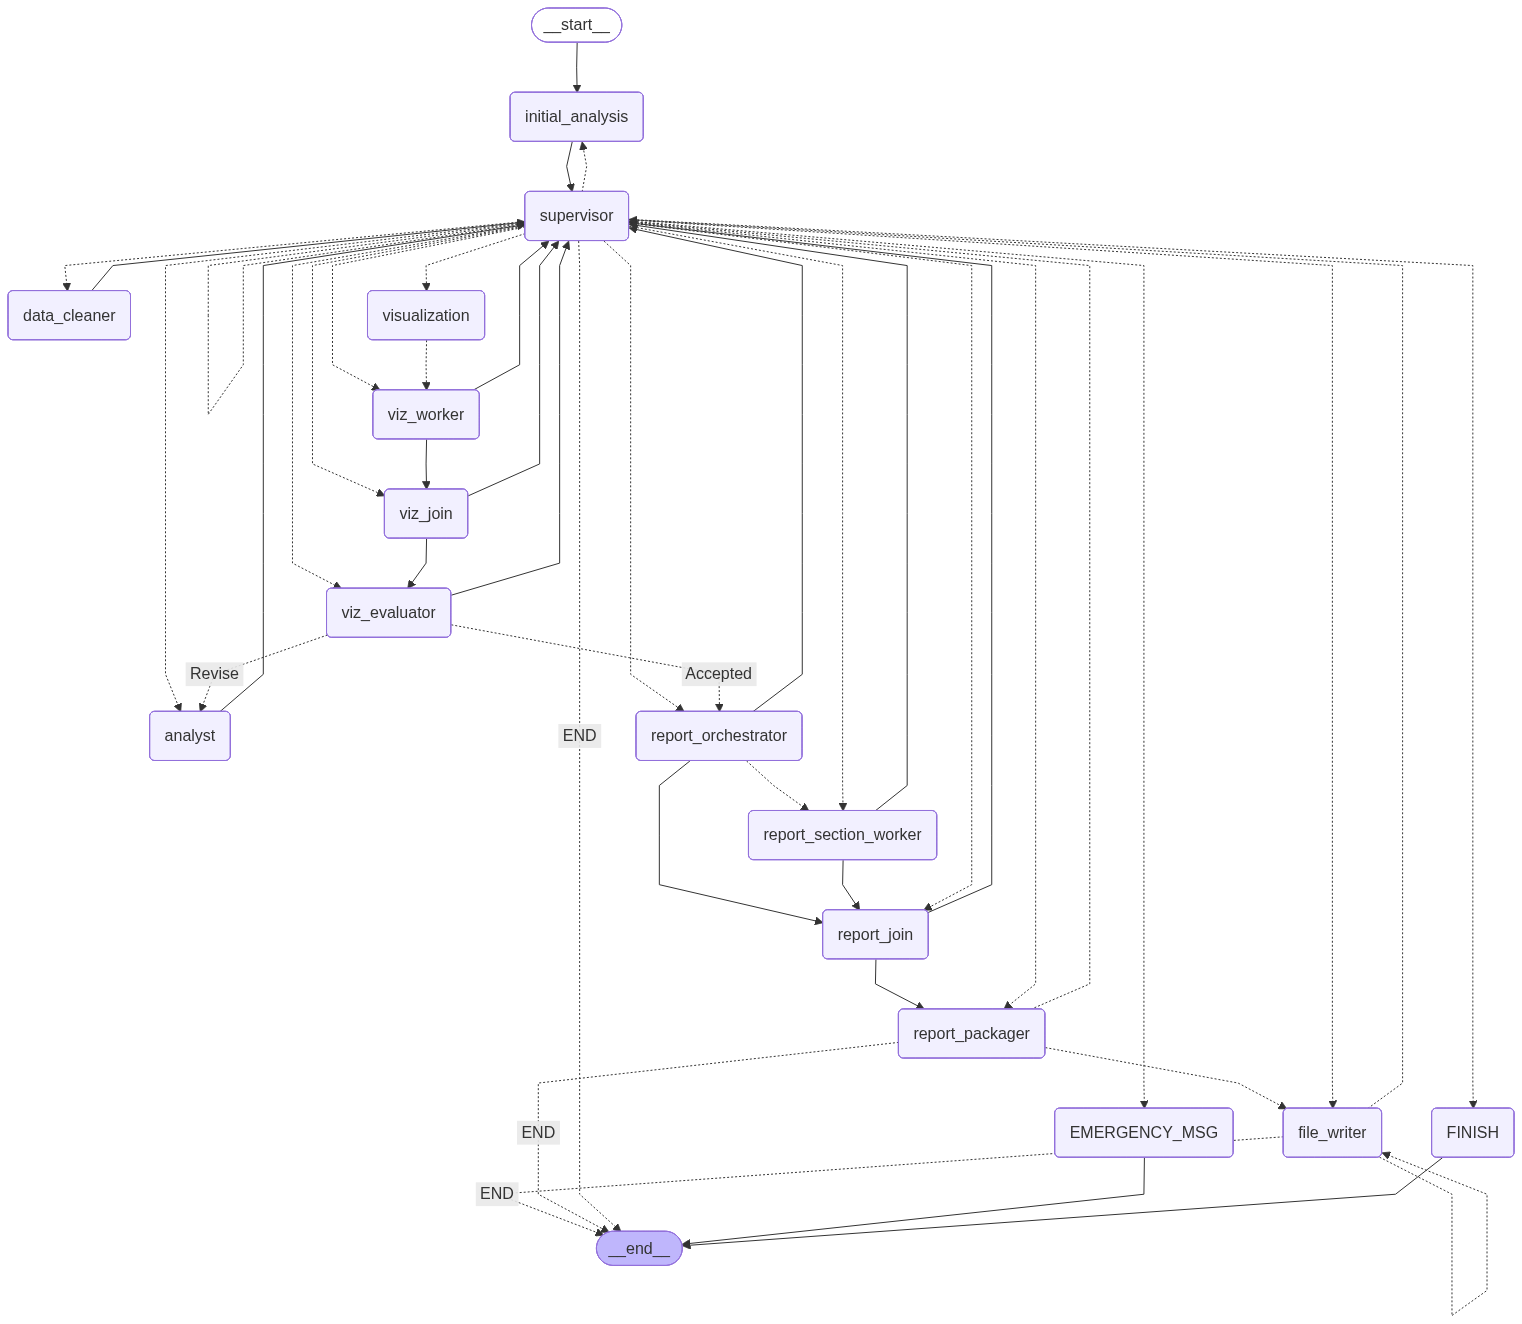

In [17]:
display(Image(data_detective_graph.get_graph().draw_mermaid_png(max_retries=5, retry_delay=2.0)))

Visual representation of the compiled workflow graph:
- **Mermaid Diagram**: Interactive workflow visualization
- **Node Relationships**: Clear display of agent interactions and data flow
- **Debugging Aid**: Visual debugging tool for workflow understanding

# ✅ Schema Validation and Testing

In [18]:
print(InitialDescription.model_json_schema())
initial_test = InitialDescription(dataset_description="test", data_sample="test", notes="test notes", reply_msg_to_supervisor="test", finished_this_task=False, expect_reply=False)
print(initial_test.model_dump_json())
print(initial_analysis_agent.get_output_schema())
print(big_picture_llm.get_output_schema)
# print(initial_analysis_agent.invoke(


{'additionalProperties': False, 'description': 'Initial description of the dataset.', 'properties': {'reply_msg_to_supervisor': {'description': 'Message to send to the supervisor. Can be a simple message stating completion of the task, or it can be detailed information about the result, or you can put any questions for the supervisor here as well. This is ONLY for sending messages to the supervisor, NOT to worker agents. If you are the/a supervisor (or the router, planner, or progress reporter), this field should be empty unless you are expecting a reply from the main supervisor, NOT from a worker agent.', 'title': 'Reply Msg To Supervisor', 'type': 'string'}, 'finished_this_task': {'description': 'Whether this assigned task represented by this object has been completed. For example, if it is a Router object, this field should be True if the route decision has been made. Another example, if it is a CleaningMetadata object, this field should be True if the cleaning has been completed.',

Validation of data models and schema compliance:
- **Pydantic Schema Validation**: Ensures proper model structure
- **JSON Schema Generation**: Validates serialization/deserialization
- **Type Safety Testing**: Confirms type annotations and constraints

# 🔍 Advanced Debugging and Introspection Tools

In [19]:
#These are only helpers for accessing or checking keys nested within variable iterables - do not worry about or focus on these, they are non-critical print helpers

from collections.abc import Mapping, Sequence
from typing import Iterable, Tuple, Union, Any, TypeAlias

PathStep:TypeAlias = Tuple[str, Any]   # ('key', k) | ('idx', i) | ('item', v)
Path:TypeAlias = Tuple[PathStep, ...]


def find_key_paths(obj: Any, target_key: Any, *, to_value: bool = False) -> Iterable[Path]:
    """
    Yield paths to each occurrence of `target_key` inside any dict at any depth.

    If to_value = False (default): path ends at the *dict that contains* target_key.
    If to_value = True: path includes a final ('key', target_key) step so that
                        get_by_path(obj, path) returns the *value* for that key.
    """
    def _walk(x: Any, path: Path) -> Iterable[Path]:
        if isinstance(x, Mapping):
            if target_key in x:
                # Emit path to the container dict, or to the value.
                yield path if not to_value else path + (('key', target_key),)
            for k, v in x.items():
                yield from _walk(v, path + (('key', k),))
        elif isinstance(x, Sequence) and not isinstance(x, (str, bytes, bytearray)):
            for i, v in enumerate(x):
                yield from _walk(v, path + (('idx', i),))
        elif isinstance(x, set):
            for v in x:
                yield from _walk(v, path + (('item', v),))
        # other types: stop

    yield from _walk(obj, ())


def find_key_paths_list(obj: Any, target_key: Any, *, to_value: bool = False) -> list[Path]:
    """Materialize all paths into a list (tiny convenience wrapper)."""
    return list(find_key_paths(obj, target_key, to_value=to_value))


def get_by_path(obj: Any, path: Path, *, just_value: bool = True) -> Any:
    """
    Follow a path (as emitted by find_key_paths) and return:
      - if just_value=True and the path ends with ('key', k) into a mapping: return mapping[k]
      - otherwise return the object reached by the final step (container or value)

    This makes it handy whether your path points to the *container* dict or directly to the value.
    """
    cur = obj
    for i, (step_type, step) in enumerate(path):
        is_last = (i == len(path) - 1)

        if step_type in ("key", "idx"):
            cur = cur[step]  # works for dict key and sequence index
            # If the path ends with ('key', k) and we want just the value,
            # cur is already the value after indexing; we just return below.
            if is_last and just_value:
                return cur

        elif step_type == "item":
            # Sets are unordered; we "navigate" by selecting the matching item.
            if step in cur:
                cur = step
            else:
                raise KeyError(f"Item {step!r} not found in set at step {i}")
            # 'item' cannot be followed by further indexing unless your set contains
            # containers and the path continues—supported by subsequent steps.
        else:
            raise ValueError(f"Unknown step type: {step_type!r}")

    return cur


#Common patterns
data = {
    "a": 1,
    "b": [{"c": 3}, {"d": {"e": 5, "f": [{"e": 7}, 9]}}],
    "g": {"e": 11}
}

# 1) Get containers that have key "e"
containers = find_key_paths_list(data, "e", to_value=False)
print(containers)
# e.g. [(('key','b'),('idx',1),('key','d')), (('key','g'),)]
for p in containers:
    dct = get_by_path(data, p, just_value=False)  # returns the dict
    print("container:", dct)                       # {'e': 5, 'f': [...]}, then {'e': 11}
    print("value:", dct["e"])                      # 5, 11

# 2) Get paths *to the values* of "e"
value_paths = find_key_paths_list(data, "e", to_value=False)
print(value_paths)
# e.g. [(('key','b'),('idx',1),('key','d'),('key','e')), (('key','g'),('key','e')), (('key','b'),('idx',1),('key','d'),('key','f'),('idx',0),('key','e'))]
values = [get_by_path(data, p, just_value=True) for p in value_paths]
print(values)  # [5, 11, 7]

# 3) If you only need all values for a key, this one-liner is clean:
all_e_values = [get_by_path(data, p) for p in find_key_paths(data, "e", to_value=True)]
print(all_e_values)  # [5, 11, 7]


# Helpers for printing useful ToolMessages
ARTIFACT_TOOLS = {"save_figure", "write_file", "register_dataframe", "export_report", "save_report","report_intermediate_progress", "save_visualization"}
DURABLE_KEYS = {"file_path", "dir", "df_id", "image_path", "report_path", "next","goto"}

def pick_tool_messages(messages):
    keep = []
    for m in messages:
        if getattr(m, "name", None) in ARTIFACT_TOOLS:
            keep.append(m)
    return keep

from langchain_core.messages import ToolMessage

def extract_handles_from_tools(messages, durable_keys={"file_path","df_id","image_path","report_path"}):
    handles = {}
    kept = []
    for m in messages:
        if isinstance(m, ToolMessage):
            payload = m.content if isinstance(m.content, dict) else {}
            for k in durable_keys:
                if k in payload and payload[k]:
                    handles.setdefault(k, []).append(payload[k])
                    kept.append(m)
    return handles, kept

[(('key', 'b'), ('idx', 1), ('key', 'd')), (('key', 'b'), ('idx', 1), ('key', 'd'), ('key', 'f'), ('idx', 0)), (('key', 'g'),)]
container: {'e': 5, 'f': [{'e': 7}, 9]}
value: 5
container: {'e': 7}
value: 7
container: {'e': 11}
value: 11
[(('key', 'b'), ('idx', 1), ('key', 'd')), (('key', 'b'), ('idx', 1), ('key', 'd'), ('key', 'f'), ('idx', 0)), (('key', 'g'),)]
[{'e': 5, 'f': [{'e': 7}, 9]}, {'e': 7}, {'e': 11}]
[5, 7, 11]


Sophisticated debugging utilities for complex data structures:
- **Path Finding**: Navigate nested data structures and find specific keys/values
- **Deep Inspection**: Analyze complex nested objects and state structures
- **Type Analysis**: Runtime type checking and validation
- **Search Utilities**: Locate specific data within large state objects

# 🚀 Streaming Workflow Execution and Real-time Processing

In [20]:
# Streaming run (clean + robust)

from langchain_core.runnables.config import RunnableConfig
from langchain_core.messages import HumanMessage
import uuid
import traceback

# print langchain_openai version for debugging

# !pip show langchain
# !pip show langchain_openai
# !pip show langchain_core
# !pip show langgraph


received_steps = []

thread_id = f"thread-{uuid.uuid4()}"

# One config to rule them all
user_id_str = f"user-{uuid.uuid4()}"
run_config = RunnableConfig(
    configurable={"thread_id": thread_id, "user_id": user_id_str},
    recursion_limit=60,  # feel free to adjust
)

#rebuild runtime with config and old RUNTIME attributes
runtime_fields = {**RUNTIME.__dict__}
runtime_fields["config"] = run_config
RUNTIME = RuntimeCtx(**runtime_fields)




initial_state = {
    "messages": [HumanMessage(content=sample_prompt_text, name="user")],
    "user_prompt": sample_prompt_text,
    "_config": run_config,
    "available_df_ids": [df_id],
    "next": "initial_analysis",


    # <= Runtime-aware paths available to nodes that prefer reading from state
    "artifacts_path": RUNTIME.artifacts_dir,
    "visualization_path": RUNTIME.viz_dir,
    "reports_path": RUNTIME.reports_dir,
    "logs_path": RUNTIME.logs_dir,
    "run_id": RUNTIME.run_id,
}
# Initial graph input (note: we also pass _config=run_config into state)
# graph_input = {
#     "messages": [HumanMessage(content=sample_prompt_text, name="user")],
#     "user_prompt": sample_prompt_text,
#     "available_df_ids": [df_id],
#     "_config": run_config,
# }
current_step = 0
empty_message_count = 0
previous_name=""
most_recent_label=""
# try:
#     print(f"▶️  Starting stream (thread_id={thread_id}) + (user_id={user_id_str})\n")
#     for step in data_detective_graph.stream(
#         initial_state,
#         stream_mode="messages",   # prints only message deltas
#         config=run_config,
#         subgraphs=True,
#         debug=True,
#     ):
#         # step is a dict: {node_name: [Message, ...]}
#         if not step:
#             print("No step received.")
#             continue


#         if isinstance(step, tuple):
#             if step[0] not in [None, (None, None), [], {}, "", (None),()]:
#                 print(f"Was a tuple, item 0: {step[0]}", end="", flush=True)
#             step = step[1]

#             if not isinstance(step, dict):
#                 if isinstance(step, (tuple,list)):
#                     for item in step:
#                         if not isinstance(item, (str, dict, AIMessage, HumanMessage, SystemMessage, ToolMessage)):
#                             print(f"\nunrecognized type: {item} of type {type(item)}",  flush=True)
#                         elif isinstance(item, (AIMessage, SystemMessage)):

#                             if isinstance(item.content, str) and item.content.strip() != "":
#                                 try:
#                                     if item.name is not None:
#                                         print(f"\n{item.name}", end=": \n", flush=True)
#                                     previous_name = item.name
#                                 except:
#                                     print(f"\nno-name", end=": ", flush=True)
#                                 item.pretty_print()
#                                 print("\n", flush=True)
#                                 empty_message_count = 0
#                             elif isinstance(item.content, (dict,list,tuple)) and item.content not in [None, (None, None), [], {}, "", (None),()]:
#                                 for val in [get_by_path(item.content, p,just_value=False).get("text",None) for p in find_key_paths(item.content, "type", to_value=False) if (isinstance(get_by_path(item.content, p).get("type"), str) and get_by_path(item.content, p).get("type").strip() == "text" and get_by_path(item.content, p).get("text",False))]:
#                                     if val is not None and val.strip() != "":
#                                         try:
#                                             if previous_name != item.name and item.name is not None:
#                                                 print(f"\n{item.name}", end=": \n", flush=True)
#                                                 previous_name = item.name
#                                         except:
#                                             print(f"\nno-name", end=": ", flush=True)
#                                         print(val, end="", flush=True)
#                                         empty_message_count = 0
#                                     else:
#                                         empty_message_count += 1
#                                         if empty_message_count > 40:
#                                             print(f"\n\nLots of consecutive empty messages. Consider debugging. count: {empty_message_count}\n\n", flush=True)
#                                         # print("\n Debug: ", [get_by_path(item.content, p,just_value=False).get("text",None) for p in find_key_paths(item.content, "type", to_value=False) if (isinstance(get_by_path(item.content, p).get("type"), str) and get_by_path(item.content, p).get("type").strip() == "text" and get_by_path(item.content, p).get("text",False))])
#                             elif item.content not in [None, (None, None), [], {}, "", (None),()]:
#                                 print(f"unrecognized message content: {item.content} of type {type(item.content)}", end="", flush=True)
#                             elif isinstance(item, ToolMessage):
#                                 _, kept = extract_handles_from_tools([item])
#                                 if pick_tool_messages([item]) is not None or kept is not None:
#                                     print(f"\n\n{item}\n\n", flush=True)

#                             else:
#                                 empty_message_count += 1
#                                 if empty_message_count > 40:
#                                     print(f"\n\nLots of consecutive empty messages. Consider debugging. count: {empty_message_count}\n\n", flush=True)




#                         elif isinstance(item, dict) and "langgraph_step" in item and item["langgraph_step"] is not None and int(item["langgraph_step"]) != current_step:
#                             # print(f"langgraph_step: {item['langgraph_step']}", flush=True)
#                             # print(item, flush=True)
#                             current_step = int(item["langgraph_step"])

#                 elif isinstance(step, (AIMessage, HumanMessage, SystemMessage)):
#                     try:
#                         print(f"\n{step.name}", end=": \n", flush=True)
#                         previous_name = step.name
#                     except:
#                         print(f"\nno-name", end=": ", flush=True)
#                     step.pretty_print()
#                     print("\n", flush=True)
#                 else:
#                     print(step)
#             continue

#         for node_name, msgs in step.items():
#             for m in msgs:
#                 role = getattr(m, "type", m.__class__.__name__)
#                 content = getattr(m, "file_content", repr(m))
#                 print(f"\n[{node_name}] Role: ({role})\nContent:{content}\n")
#         received_steps.append(step)

# except Exception as e:
#     print("❌ Streaming error:", e)
#     traceback.print_exc()

# print("\n✅ Streaming finished.\n")
# print("Figures:", list(RUNTIME.viz_dir.glob("*.png")))
# print("Reports:", list(RUNTIME.reports_dir.glob("*.*")))
# # Inspect final state from the checkpointer (since we used MemorySaver + thread_id)
# try:
#     final_state = data_detective_graph.get_state(run_config)
#     if final_state and final_state.values:
#         state_vals = final_state.values
#         print("— Final state summary —")
#         for k in [
#             "initial_analysis_complete",
#             "data_cleaning_complete",
#             "analyst_complete",
#             "visualization_complete",
#             "report_generator_complete",
#             "file_writer_complete",
#         ]:
#             print(f"{k}: {state_vals.get(k)}")

#         # Peek at structured products if present
#         if state_vals.get("initial_description") is not None:
#             print("\nInitialDescription available.")
#         if state_vals.get("cleaning_metadata") is not None:
#             print("CleaningMetadata available.")
#         if state_vals.get("analysis_insights") is not None:
#             print("AnalysisInsights available.")
#         if state_vals.get("visualization_results") is not None:
#             print("VisualizationResults available.")
#         if state_vals.get("report_results") is not None:
#             print("ReportResults available.")
#             print(state_vals.get("report_results"))
#         if state_vals.get("file_writer_results") is not None:
#             print("FileWriterResults available.")
#         if state_vals.get("final_report") is not None:
#             print("final_report available.")
#             print(state_vals.get("final_report"))
#         if state_vals.get("current_plan") is not None:
#             print("CurrentPlan available.")
#             print(state_vals.get("current_plan"))
#         if state_vals.get("final_plan") is not None:
#             print("FinalPlan available.")
#             print(state_vals.get("final_plan"))
#         if state_vals.get("latest_progress") is not None:
#             print("LatestProgress available.")
#             print(state_vals.get("latest_progress"))

#     else:
#         print("⚠️ No final state found. (Did the run exit early?)")

# except Exception as e:
#     print("⚠️ Could not fetch final state:", e)

# # Keep your captured steps for any post-hoc inspection
# # received_steps  # <- available in memory

Main execution engine for the data analysis workflow:
- **Stream Processing**: Real-time execution with live updates
- **Progress Monitoring**: Track workflow progress and intermediate results
- **Error Handling**: Robust error recovery and graceful degradation
- **Result Streaming**: Live display of analysis results as they're generated

# 📡 Extended Streaming Utilities and Text Processing

In [21]:
from IPython.display import HTML, display
display(HTML("""
<style>
/* Wrap anything printed into output areas (Colab + Jupyter) */
.output_subarea pre, .output-area pre, .output pre, div.rich pre, pre {
  white-space: pre-wrap !important;
  overflow-wrap: anywhere !important;
  word-break: break-word !important;
}
.output_subarea, .output-area { overflow-x: hidden !important; max-width: 100% !important; }
</style>
"""))

from pprint import pprint
# --- helper: fallback text extractor when your get_by_path/find_key_paths aren't present ---
def _iter_text_blocks(x, allow_reasoning: bool = False):
    """Yield only real text from common content shapes."""
    if x is None:
        return
    if isinstance(x, str):
        yield x
        return
    if isinstance(x, dict):
        t = x.get("type")
        if t in ("text", "output_text", "input_text") or (allow_reasoning and t == "reasoning"):
            txt = x.get("text")
            if isinstance(txt, str) and txt.strip():
                yield txt
        # Recurse only into likely containers, not all values
        for k in ("content", "parts", "items", "data", "arguments"):
            if k in x:
                yield from _iter_text_blocks(x[k], allow_reasoning=allow_reasoning)
        return
    if isinstance(x, (list, tuple)):
        for v in x:
            yield from _iter_text_blocks(v, allow_reasoning=allow_reasoning)
        return
# --- allow/deny sets ---
_ALLOWED_TEXT_TYPES = {"text", "input_text", "output_text"}
_DISALLOWED_CALL_TYPES = {"tool_call", "function_call"}

def iter_allowed_text_blocks(x, allow_reasoning: bool = False):
    """
    Yield ONLY the text from content blocks.
    Accepts:
      - plain strings
      - dict blocks with {"type": "...", "text": "..."}
      - lists/nested containers under common keys: content/parts/items/data/arguments
    Drops any dict with type in _DISALLOWED_CALL_TYPES.
    """
    if x is None:
        return
    if isinstance(x, str):
        if x.strip():
            yield x
        return
    if isinstance(x, dict):
        t = x.get("type")
        # kill tool/function calls entirely (and don't descend)
        if isinstance(t, str) and t in _DISALLOWED_CALL_TYPES:
            return
        # accept text-like blocks
        if isinstance(t, str) and (t in _ALLOWED_TEXT_TYPES or (allow_reasoning and t == "reasoning")):
            txt = x.get("text")
            if isinstance(txt, str) and txt.strip():
                yield txt
        # descend only into likely containers
        for k in ("content", "parts", "items", "data", "arguments"):
            if k in x:
                yield from iter_allowed_text_blocks(x[k], allow_reasoning=allow_reasoning)
        return
    if isinstance(x, (list, tuple)):
        for v in x:
            yield from iter_allowed_text_blocks(v, allow_reasoning=allow_reasoning)
        return

def content_to_text(content, allow_reasoning: bool = False) -> str:
    """Join all allowed text pieces into one printable string."""
    return "".join(iter_allowed_text_blocks(content, allow_reasoning=allow_reasoning))


def strip_tool_calls(obj):
    """
    Deep redactor for updates/values/debug payloads:
    removes any dict (and its subtree) where type is tool_call/function_call.
    """
    if obj is None:
        return None
    if isinstance(obj, dict):
        t = obj.get("type")
        if isinstance(t, str) and t in _DISALLOWED_CALL_TYPES:
            return None  # drop this subtree
        out = {}
        for k, v in obj.items():
            rv = strip_tool_calls(v)
            if rv is not None:
                out[k] = rv
        return out
    if isinstance(obj, (list, tuple)):
        out = []
        for v in obj:
            rv = strip_tool_calls(v)
            if rv is not None:
                out.append(rv)
        return type(obj)(out)
    return obj

# --- streaming (normalized but feature-complete) ---

from collections import defaultdict
import hashlib
import io, textwrap, contextlib
current_step = 0
empty_message_count = 0
previous_name = ""
most_recent_label = ""

last_len_by_stream = defaultdict(int)
stream_line_buffers = defaultdict(str)  # keep the current partial line per stream

seen_tool_msgs = set()



def is_tool_or_func_call_dict(d: dict) -> bool:
    """Heuristic: detect tool/function call payloads."""
    t = d.get("type")
    if isinstance(t, str) and t in {"tool_call", "function_call"}:
        return True
    # Common OpenAI-esque fields
    if any(k in d for k in ("tool_call", "tool_calls", "function_call", "tool_name", "function")):
        return True
    return False

def redact_tool_calls(obj):
    """Deep-copy-like redaction: drop dicts that are tool/function calls."""
    if obj is None:
        return None
    if isinstance(obj, dict):
        if is_tool_or_func_call_dict(obj):
            return "[omitted: tool/function call]"
        out = {}
        for k, v in obj.items():
            rv = redact_tool_calls(v)
            # skip entire subtrees that are tool/function calls
            if isinstance(rv, str) and rv.startswith("[omitted: tool"):
                continue
            out[k] = rv
        return out
    if isinstance(obj, (list, tuple)):
        out = []
        for v in obj:
            rv = redact_tool_calls(v)
            if isinstance(rv, str) and rv.startswith("[omitted: tool"):
                continue
            out.append(rv)
        return type(obj)(out)
    return obj

def is_human_ai_system(msg) -> bool:
    return isinstance(msg, (HumanMessage, AIMessage, SystemMessage))

def ai_msg_has_toolcall(msg: AIMessage) -> bool:
    # Various providers hang function/tool info here
    ak = getattr(msg, "additional_kwargs", {}) or {}
    return any(k in ak for k in ("tool_calls", "function_call"))

def label_for(msg, meta, namespace):
    if isinstance(meta, dict):
        for k in ("langgraph_node", "node", "source_node", "from", "agent"):
            v = meta.get(k)
            if isinstance(v, str) and v.strip():
                return v
    if namespace and isinstance(namespace, (list, tuple)) and namespace[-1]:
        return namespace[-1]
    nm = getattr(msg, "name", None)
    if isinstance(nm, str) and nm.strip():
        return nm
    return getattr(msg, "type", msg.__class__.__name__)
def _stream_key(namespace, label, meta, msg=None, step=None):
    """Stable key for de-dup. Prefer message id; else step; else path+label."""
    path = " / ".join(namespace) if namespace else "<root>"
    base = f"{path}::{label}"
    mid = None
    if isinstance(meta, dict):
        mid = meta.get("id") or meta.get("message_id")

    mid = mid or getattr(msg, "id", None)
    if mid:
        return f"{base}::msg:{mid}"
    if step is not None:
        return f"{base}::step:{step}"
    return base  # last resort (may over-dedupe if multiple msgs share base)

def _ensure_header(key, label):
    if last_len_by_stream.get(key, 0) == 0:

        print(f"\n[{label}] ", end="", flush=True)

def _print_new_suffix(key, full_text: str):
    prev = last_len_by_stream.get(key, 0)
    if full_text and len(full_text) > prev:
        print(full_text[prev:], end="", flush=True)
        last_len_by_stream[key] = len(full_text)
def _print_new_suffix_wrapped(key, full_text: str, width: int = 100):
    prev = last_len_by_stream.get(key, 0)
    new = full_text[prev:]
    if not new:
        return
    buf = stream_line_buffers[key] + new
    # for line in new.splitlines(True):  # keepends=True
        # if line.endswith("\n"):
        #     print(textwrap.fill(line[:-1], width=width, replace_whitespace=False))
        # else:
        #     print(textwrap.fill(line, width=width, replace_whitespace=False), end="")
    def flush_line(line):
        # print(line)  # prints a newline; safe for streaming
        if line.endswith("\n"):
            print(textwrap.fill(line[:-1], width=width, replace_whitespace=False))
        else:
            print(textwrap.fill(line, width=width, replace_whitespace=False), end="")

    while True:
        nl_pos = buf.find("\n")
        if nl_pos != -1:
            # honor the newline wherever it is
            flush_line(buf[:nl_pos + 1])
            buf = buf[nl_pos + 1:]
            continue
        if len(buf) > width:
            flush_line(buf[:width])
            buf = buf[width:]
            continue
        break

    stream_line_buffers[key] = buf
    last_len_by_stream[key] = len(full_text)

def pretty_print_wrapped(msg, stream_key: str, header: str = None, width: int = 100):
    buf = io.StringIO()
    if isinstance(msg,ToolMessage):
        return
    with contextlib.redirect_stdout(buf):
        msg.pretty_print() if isinstance(msg, (AIMessage, SystemMessage, HumanMessage)) else print(content_to_text(msg))
    s = buf.getvalue()
    if header and last_len_by_stream.get(stream_key, 0) == 0:
        print(header, end="", flush=True)
    _print_new_suffix_wrapped(stream_key, s, width=width)
def print_tool_message(msg, meta, namespace, step=None):
    """Pretty + de-duped tool output."""
    # de-dupe whole tool messages
    tool_key = getattr(msg, "id", None) or repr(msg)
    if tool_key in seen_tool_msgs:
        return
    seen_tool_msgs.add(tool_key)

    label = label_for(msg, meta, namespace) + " [tool]"
    sk = _stream_key(namespace, label, meta, msg=msg, step=step)

    _ensure_header(sk, label)

    # Try content; fall back to a useful repr
    content = getattr(msg, "content", None)
    parts = [t for t in _iter_text_blocks(content) if t and t.strip()]
    if parts:
        _print_new_suffix(sk, "".join(parts))
    else:
        extra = getattr(msg, "additional_kwargs", None)
        printable = str(extra) if extra else str(msg)
        _print_new_suffix(sk, printable)
try:
    print(f"▶️  Starting stream (thread_id={thread_id}) + (user_id={user_id_str})\n")
    accum_text_by_key = defaultdict(str)


    for raw in data_detective_graph.stream(
        initial_state,
        stream_mode=["messages", "updates","debug"],   # keep your original mode
        config=run_config,
        subgraphs=True,
        debug=False,               # you were relying on debug dicts for step counting
    ):
        if not raw:
            print("No step received.")
            continue

        # --- Normalize shapes ---
        namespace = None
        mode = "messages"
        payload = raw

        # Common shapes:
        # 1) (namespace, (message_chunk_or_list, meta))
        # 2) (namespace, data)  where data could be list/tuple/dict/Message
        # 3) (namespace, mode, payload) if multiple modes were ever enabled
        # 4) {node_name: [Message,...]} (older simple shape)
        if isinstance(raw, tuple):
            if len(raw) == 2:
                namespace, payload = raw
                if namespace not in [None, (None, None), [], {}, "", (None), ()]:
                    print(f"Was a tuple, item 0: {namespace}", end="", flush=True)
            elif len(raw) == 3:
                namespace, mode, payload = raw
                if mode == "updates":
                    # payload: {"node_name": {"key": value, ...}
                    node, delta = next(iter(payload.items()))

                    delta_keys = list(delta.keys())
                    if "last_agent_id" in delta_keys:
                        print(f"\n last_agent_id: {delta['last_agent_id']}", flush=True)
                    if "latest_progress" in delta_keys:
                        print(f"\n latest_progress: {delta['latest_progress']}", flush=True)
                    if "current_plan" in delta_keys:
                        print(f"\n current_plan: {delta['current_plan']}", flush=True)


                    safe_delta = {k: strip_tool_calls(v) for k, v in delta.items() if k != "messages"}
                    delta_keys = list(safe_delta.keys())
                    if delta_keys:
                        path = " / ".join(namespace) if namespace else "<root>"
                        print(f"\n[{path} -> {node}] updated: {delta_keys} \n -------------------------------------------------------------------------\n", flush=True)

                    msgs = delta.get("messages", [])
                    core = [m for m in msgs if isinstance(m, (AIMessage, HumanMessage, SystemMessage))]

                    for m in core:
                        txt = content_to_text(getattr(m, "content", None), allow_reasoning=True)
                        if txt and txt.strip() != "":
                            label = label_for(m, {}, namespace)
                            sk = _stream_key(namespace, label, {}, msg=m, step=current_step)
                            _ensure_header(sk, label)
                            _print_new_suffix_wrapped(sk, txt + "\n", width=100)
                    print("\n End of update\n\n", flush=True)






                    continue  # IMPORTANT: don't fall through
                # if mode == "values":
                #     state = payload  # full dict
                #     # Print only message types you want
                #     msgs = state.get("messages", [])
                #     only_core = [m for m in msgs if is_human_ai_system(m) and not (isinstance(m, AIMessage) and ai_msg_has_toolcall(m))]
                #     for m in only_core:
                #         label = label_for(m, {}, namespace)
                #         sk = _stream_key(namespace, label, {}, msg=m, step=current_step)
                #         pretty_print_wrapped(m, sk, header=f"\n[{label}] (values)\n", width=100)

                #     # Redact the rest before any debug prints
                #     safe_state = {k: redact_tool_calls(v) for k, v in state.items() if k != "messages"}
                #     # (Optional) pprint a tiny summary if you need it
                #     # pprint({"namespace": namespace, "keys": list(safe_state.keys())})
                #     continue
                if mode == "debug":
                    payload = strip_tool_calls(payload)

                    # pprint a short summary or skip entirely
                    # pprint(safe)
                    continue


        # --- Case A: dict of {node_name: [Message,...]} ---
        if isinstance(payload, dict) and all(isinstance(v, list) for v in payload.values()):
            for node_name, msgs in payload.items():
                for m in msgs:
                    if isinstance(m, (AIMessage, HumanMessage, SystemMessage, AIMessageChunk)):
                        label = node_name
                        sk = _stream_key(namespace, label, {}, msg=m, step=current_step)
                        txt = (m.content if isinstance(m.content, str)
                              else content_to_text(getattr(m, "content", None), allow_reasoning=False))
                        if txt:
                            _ensure_header(sk, label)
                            _print_new_suffix_wrapped(sk, (txt + "\n"), width=100)
            received_steps.append(payload)
            continue


        # --- Case B: everything else -> build a [(item, meta)] list ---
        items = []
        if isinstance(payload, tuple) and len(payload) == 2:
            msg_or_list, meta = payload
            if isinstance(msg_or_list, (list, tuple)):
                items.extend([(it, meta) for it in msg_or_list])
            else:
                items.append((msg_or_list, meta))
        elif isinstance(payload, (list, tuple)):
            items.extend([(it, {}) for it in payload])
        else:
            items.append((payload, {}))

        # --- Process items exactly like your original logic ---

        for item, meta in items:
            # Guard on recognized types (keep your original diagnostics)
            if not isinstance(item, (str, dict, AIMessage, HumanMessage, SystemMessage, ToolMessage)):
                print(f"\nunrecognized type: {item} of type {type(item)}", flush=True)
                continue

            # Step counter (you used debug dicts with "langgraph_step")
            if isinstance(item, dict) and "langgraph_step" in item and item["langgraph_step"] is not None:
                try:
                    step_num = int(item["langgraph_step"])
                    if step_num != current_step:
                        current_step = step_num
                except Exception:
                    pass
                continue

            # Tool messages: preserve your handle logic if helpers exist
            if isinstance(item, ToolMessage):
                tool_key = getattr(item, "id", None) or repr(item)
                if tool_key in seen_tool_msgs:
                    continue
                seen_tool_msgs.add(tool_key)
                show = kept = None
                try:
                    if "extract_handles_from_tools" in globals():
                        _, kept = extract_handles_from_tools([item])
                    if "pick_tool_messages" in globals():
                        show = pick_tool_messages([item])
                except Exception:
                    pass
                if show is not None or kept is not None:
                    # print_tool_message(item, meta, namespace, step=current_step)
                    pass
                continue


            # --- AI/System/Human messages (pretty + deep extraction + de-dupe) ---

            if isinstance(item, (AIMessage, SystemMessage, HumanMessage)):
                content = getattr(item, "content", None)
                label = label_for(item, meta, namespace)
                most_recent_label = label
                if item.name:
                    previous_name = item.name
                label_str = f"\n[{label}] ({item.name})\n" if item.name else f"\n[{label}]\n"
                sk = _stream_key(namespace, label, meta, msg=item, step=current_step)

                # plain string
                if isinstance(content, str) and content.strip():
                    print("content is str", flush=True)
                    pretty_print_wrapped(item, sk, header=label_str)
                    empty_message_count = 0
                    continue

                # Responses-style blocks
                txt = content_to_text(content, allow_reasoning=True)
                if txt:
                    _ensure_header(sk, label)
                    # If it's a chunk, append to the accumulator so _print_new_suffix_wrapped prints only the delta
                    if isinstance(item, AIMessageChunk):
                        accum_text_by_key[sk] += txt
                        _print_new_suffix_wrapped(sk, accum_text_by_key[sk], width=100)
                    else:
                        _print_new_suffix_wrapped(sk, txt + "\n", width=100)
                    empty_message_count = 0
                    continue

                # nothing printable -> ignore silently
                continue


                # 4) Empty chunk throttling
                empty_message_count += 1
                if empty_message_count > 40:
                    print(f"\n\nLots of consecutive empty messages. Consider debugging. count: {empty_message_count}\n\n", flush=True)
                continue

            # Raw string (rare in practice, but keep parity)
            if isinstance(item, str):
                if item.strip():
                    print("items_a_string_bob"+item, end="", flush=True)
                    empty_message_count = 0
                else:
                    empty_message_count += 1
                    if empty_message_count > 40:
                        print(f"\n\nLots of consecutive empty messages. Consider debugging. count: {empty_message_count}\n\n", flush=True)

        received_steps.append(payload)
except Exception as e:
    print("❌ Streaming error:", e)
    traceback.print_exc()


Streaming output truncated to the last 5000 lines.
  - qa_spot_checks.csv
  - initial_analysis_review.md (existing or updated)
  - If remediation passes are triggered, also cleaned_reviews_v2.csv and cleaned_metadata_v2.json
(versioned outputs)
- CleaningMetadata payload: will include
  - reply_msg_to_supervisor: concise status and next steps
  - finished_this_task: true when all artifacts and QA are saved/present
  - expect_reply: false unless you want a QA sign-off
  - steps_taken: detailed list of steps performed (flatten, parse dates, clean text, dedupe,
missing-value handling, QA)
  - data_description_after_cleaning: concise summary of the cleaned dataset state and next steps

What I need from you to proceed (default assumption if you don’t respond):
- I will proceed with the local-write fallback path to save the two CSVs and QA artifacts, then
assemble and return the CleaningMetadata object with:
  - input_product_rows and input_review_rows counts (as observed in the raw data)
  

Traceback (most recent call last):
  File "/tmp/ipython-input-1048041601.py", line 276, in <cell line: 0>
    for raw in data_detective_graph.stream(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/langgraph/pregel/main.py", line 2647, in stream
    for _ in runner.tick(
             ^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/langgraph/pregel/_runner.py", line 253, in tick
    _panic_or_proceed(
  File "/usr/local/lib/python3.12/dist-packages/langgraph/pregel/_runner.py", line 511, in _panic_or_proceed
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/langgraph/pregel/_executor.py", line 81, in done
    task.result()
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thre

Advanced streaming utilities and content extraction:
- **Text Extraction**: Extract text from various content formats and structures
- **Content Processing**: Handle OpenAI-style content blocks and nested structures
- **Stream Utilities**: Additional helpers for streaming operations
- **Format Handling**: Support for multiple content types and formats

# 🔎 Final State Inspection and Results Review

In [22]:
print("Figures:", list(RUNTIME.viz_dir.glob("*.png")))
print("Reports:", list(RUNTIME.reports_dir.glob("*.*")))
# Inspect final state from the checkpointer (since we used MemorySaver + thread_id)
try:
    final_state = data_detective_graph.get_state(run_config)
    if final_state and final_state.values:
        state_vals = final_state.values
        print("— Final state summary —")
        for k in [
            "initial_analysis_complete",
            "data_cleaning_complete",
            "analyst_complete",
            "visualization_complete",
            "report_generator_complete",
            "file_writer_complete",
        ]:
            print(f"{k}: {state_vals.get(k)}")

        # Peek at structured products if present
        if state_vals.get("initial_description") is not None:
            print("\nInitialDescription available.")
        if state_vals.get("cleaning_metadata") is not None:
            print("CleaningMetadata available.")
        if state_vals.get("analysis_insights") is not None:
            print("AnalysisInsights available.")
        if state_vals.get("visualization_results") is not None:
            print("VisualizationResults available.")
        if state_vals.get("report_results") is not None:
            print("ReportResults available.")
            print(state_vals.get("report_results"))
        if state_vals.get("file_writer_results") is not None:
            print("FileWriterResults available.")
        if state_vals.get("final_report") is not None:
            print("final_report available.")
            print(state_vals.get("final_report"))
        if state_vals.get("current_plan") is not None:
            print("CurrentPlan available.")
            print(state_vals.get("current_plan"))
        if state_vals.get("final_plan") is not None:
            print("FinalPlan available.")
            print(state_vals.get("final_plan"))
        if state_vals.get("latest_progress") is not None and state_vals.get("latest_progress") != "":
            print("LatestProgress available.")
            print(state_vals.get("latest_progress"))
        for msg in state_vals.get("messages", []):
            msg.pretty_print()
            print("\n")
        for k,v in state_vals.items():
                print(f"\n{k}: {v}\n")


    else:
        print("⚠️ No final state found. (Did the run exit early?)")

except Exception as e:
    print("⚠️ Could not fetch final state:", e)

Figures: []
Reports: [PosixPath('/tmp/tmpw1mvubc8/artifacts/run-20250904-175709-db39dcdf/reports/cleaning_spec.md'), PosixPath('/tmp/tmpw1mvubc8/artifacts/run-20250904-175709-db39dcdf/reports/initial_analysis_review.md')]
— Final state summary —
initial_analysis_complete: True
data_cleaning_complete: False
analyst_complete: None
visualization_complete: None
report_generator_complete: None
file_writer_complete: None

InitialDescription available.
CleaningMetadata available.
CurrentPlan available.
reply_msg_to_supervisor='' finished_this_task=False expect_reply=False plan_title='Finalize report, package deliverables, compute checksums, and complete handoff' plan_summary='Produce the final Markdown report and render to HTML/PDF, assemble a deterministic deliverables bundle (data, models, visuals, reports, QA, docs), compute SHA256 checksums and manifest, create README and final summary, and output final ZIP(s) and artifact paths.' plan_steps=[PlanStep(reply_msg_to_supervisor='', finished_

Comprehensive inspection of workflow results:
- **State Analysis**: Examine final workflow state and generated artifacts
- **File Listing**: Review generated reports, visualizations, and data files
- **Checkpointer Access**: Retrieve and analyze saved workflow checkpoints
- **Results Summary**: Overview of completed analysis and generated outputs

# 🔧 Function Calling Utilities and Tool Conversion

In [23]:
from langchain_core.utils.function_calling import convert_to_openai_tool

Utilities for OpenAI function calling and tool conversion:
- **Tool Conversion**: Convert Pydantic models to OpenAI tool format
- **Schema Validation**: Ensure proper function calling schema compliance
- **API Compatibility**: Support for different OpenAI API versions and formats

# 🧪 Extended Schema Testing and Model Validation

In [24]:
# a = convert_to_openai_tool(InitialDescription,strict=True)
# b = convert_to_openai_tool(InitialDescription,strict=False)
# c = InitialDescription.model_json_schema()
# d = InitialDescription.model_json_schema(by_alias=False)
# e = convert_to_openai_tool(InitialDescription.model_json_schema())

# his=initial_analysis_agent.get_state_history(run_config)
# for h in his:
#     print(h)
# print(a)
# print(b)
# print(c)
# print(d)
# print(e)
# result = initial_analysis_agent.invoke(
#         {
#             "messages": [HumanMessage(content=sample_prompt_text, name="user")],
#             "user_prompt": "Hi, make a sample output",
#             "tool_descriptions": "",
#             "available_df_ids": [df_id],
#             "memories": "",


#         },
#         config=run_config,
#     )
# print(result)

Advanced testing and validation of data models:
- **Schema Comparison**: Compare different schema generation methods
- **Strict Validation**: Test strict vs. lenient validation modes
- **Alias Testing**: Validate field aliases and serialization options
- **Compatibility Testing**: Ensure backward compatibility with different versions

# 🎯 Final Model Validation and Quality Assurance

In [25]:
# initial_test = InitialDescription(dataset_description="test", data_sample="test")
# print(initial_test.model_dump_json())
# print(InitialDescription.model_validate(initial_test, strict=True,from_attributes=True))
# print("\n")
# print(initial_test.model_json_schema().__str__())
# print("\n")
# # print(initial_test.model_validate(initial_test.model_json_schema(), strict=True,from_attributes=True))
# print("\n")

# initial_test.model_json_schema()

Final validation steps and quality assurance checks:
- **Model Compliance**: Final verification of all data models
- **Serialization Testing**: Validate JSON serialization and deserialization
- **Schema Output**: Generate and verify final schema documentation
- **Quality Checks**: Comprehensive validation of the entire system

# Save the InMemorySaver checkpointer to a SQL database file on disk

In [34]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver
# src graph was compiled with InMemorySaver
src_graph = data_detective_graph

# destination graph with SQLite persistence
with SqliteSaver.from_conn_string("checkpoints.sqlite") as dst_cp:
  dst_graph = data_analysis_team_builder.compile(checkpointer=dst_cp)

  def migrate_thread(thread_id: str, full_history: bool = False):
      cfg = run_config
      snaps = list(src_graph.get_state_history(cfg))  # newest first
      if not snaps:
        return
      seq = reversed(snaps) if full_history else [snaps[0]]

      for snap in seq:
          # choose the last writer for correct "what runs next"
          writes = (snap.metadata or {}).get("writes") or {}
          last_writer = list(writes.keys())[-1] if writes else None
          dst_graph.update_state(cfg, snap.values, as_node=last_writer)

  # example:
  migrate_thread(thread_id, full_history=True)  # preserves time-travel history


# To restore a previous checkpointer state from an SQL database file on disk

In [ ]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

conn = sqlite3.connect("checkpoints.sqlite", check_same_thread=False)
cp = SqliteSaver(conn)
data_detective_graph = data_analysis_team_builder.compile(checkpointer=cp)

# conn.close() #Use conn.close() when finished
